# Old Anger camera analysis
***

This code was used to reduce the anger camera data taken at HFIR April-May 2022. That experiment tested the magnetic offset of the correction coil, characterized the efficiency of the RF flipper, and the wide-angle MWP (which failed). MIEZE was also attempted, but it seems like we did not analyze the data.

In [456]:
# -*- coding: utf-8 -*-
"""
Created on Wed Apr 17 11:25:02 2019

@author: 8jd
"""
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mplc
import scipy.constants as sc
import struct
import scipy.optimize as opt
import glob
from mpl_toolkits.mplot3d import Axes3D
import os

#img is the limits for filtering data outside of the image
imgpar = [[0,1500],[0,1500]]
#imgpar = [[200,350],[150,300]]

spatialscale = 512./116.
#returns raw data and BG data, filtered by the imgdim and BG dim
def loadData(openfile, imgdim):
    listdata = []
    BGdata = []
    maxt = 0
    dummy = np.zeros(shape=(3))
    with open(openfile, "rb") as f:
        bytesin = f.read(24)
        while bytesin:
            temp = struct.unpack('3d', bytesin)
            dummy[0] = temp[0]
            dummy[1] = temp[1] * spatialscale
            dummy[2] = temp[2] * spatialscale
            listdata.append([dummy[0], int(dummy[1]-imgpar[0][0]), int(dummy[2]-imgpar[1][0])])
            
            bytesin = f.read(24)
    return listdata, BGdata

#This framestack is full image (spatially integrated)
#Think the raw data format is time in ticks (100ns/tick), position scaled to some length
def framestack(inarray, period, Nperiods, nbins):
    t_hist = np.zeros(shape=(nbins))
    binsize = period / nbins
    dlen = len(inarray)
    curindex = 0
    for i in range(0, dlen):
        curindex = int(np.floor( (inarray[i][0] % period) / binsize ))
        t_hist[curindex] += 1
    plt.plot(t_hist)
    return

def plotTotal(inarray):
    t_hist = np.zeros(shape=(int(max(map(lambda x: x[0], inarray)))+1))
    dlen = len(inarray)
    curindex = 0
    for i in range(0, dlen):
        curindex = int(np.floor( (inarray[i][0])))
        t_hist[curindex] += 1
    plt.plot(t_hist)
    return
    
def BGsubtractIMG(inImg, BG):
    ydim = int(max(map(lambda x: x[1], BG)) +1)
    xdim = int(max(map(lambda x: x[2], BG)) + 1)
    BGave = len(BG)/ (ydim * xdim)
    result = np.array(inImg)
    xlen = len(inImg)
    ylen = len(inImg[0])
    for i in range(0, xlen):
        for j in range(0,ylen):
            result[i][j] -= BGave
    return result

def ShowImage(inImage):
    fig, ax = plt.subplots(1,1, figsize=(8,6))
    im = ax.imshow(inImage, origin="lower", aspect="auto")
    fig.colorbar(im)
    fig.tight_layout()
    plt.show()
    
def MakeImage(inarray):
    ydim = int(max(map(lambda x: x[1], inarray)) + 1)
    xdim = int(max(map(lambda x: x[2], inarray)) + 1)
    img = np.zeros(shape=(xdim, ydim))
    dlen = len(inarray)
    for i in range(0, dlen):
        xind = int(inarray[i][1])
        yind = int(inarray[i][2])
        img[yind][xind] += 1
    
    return img

#This function combines bins in time, need to take care to change scale when using
def BinDataT(inData, n):
    bSize = n
    result = np.array(inData)
    nData = len(inData)
    for i in range(0, nData):
        result[i][0] = np.floor(result[i][0] / bSize)
    return result
    
#This function bins spatial dimensions, need to take care to change scale when using
def BinImg(inImg, xbinsize, ybinsize):
    xdim = len(inImg[0])
    ydim = len(inImg)
    ybins = int(np.floor(ydim/ybinsize))
    xbins = int(np.floor(xdim/xbinsize))
    result = np.zeros(shape=(ybins, xbins))
        
    for xb in range(0, xbins):
        curx = xb * xbinsize
        for yb in range(0, ybins):
              cury = yb * ybinsize
              for x in range(curx, curx + xbinsize):
                  for y in range(cury, cury+ybinsize):
                      result[yb][xb] += int(inImg[y][x])
    return result
    
def BinRaw(inData, xbinsize, ybinsize):
    result = []
    #lastXbin = np.floor(max(map(lambda x: x[1], inData)) / xbinsize)
    #lastYbin = np.floor(max(map(lambda x: x[2], inData)) / ybinsize)
    for datum in inData:
        newXbin = datum[1]/xbinsize
        newYbin = datum[2]/ybinsize
        #if (newXbin > lastXbin):
        #    continue
        #if (newYbin > lastYbin):
        #    continue
        result.append([datum[0], int(np.floor(newXbin)), int(np.floor(newYbin))])
    return np.array(result)

def fitfun(x, a, f, phase, c):
    return c + a * np.sin(2*sc.pi*f *x + phase)

def tfit(tData, par0):
    t = np.linspace(0, len(tData), len(tData))
    #frequency estimate is in kHz, converted to pixels
    par0[0] = np.std(tData)
    par0[3] = np.mean(tData)
    popt, pcov = opt.curve_fit(fitfun, t, tData, p0 = par0, maxfev=1000000,ftol=1e-8)
    tt = np.linspace(0, len(tData), 1000)
    plt.plot(tt, fitfun(tt, *popt), linestyle="-", color='b')
    plt.plot(tData, linestyle="None", marker="o", color='r')
    plt.show()
    return popt

def T_analysis_byPixel(inData, par0):
    maxt = int(max(map(lambda x: x[0], inData)))
    #using hash table to uniquely identify each pixel 
    maxx = int(max(map(lambda x: x[1], inData)))
    maxy = int(max(map(lambda x: x[2], inData)))
    hashmax = maxx*(maxy + 1) + maxy
    #hash: i_x*(n_y - 1) + i_y (or vice versa)
    #iterate through all data once, separating into different hash groups.
    #then analyze the hash lists separately
    hashlist = np.zeros(shape=(hashmax+1, maxt+1), dtype=np.int32)
    for datum in inData:
        curhash = int(datum[1]*(maxy + 1) + datum[2])
        hashlist[curhash][int(datum[0])] += 1
    imgOut = np.zeros(shape=(maxy+1, maxx+1))
    for i in range(0, hashmax):
        tlist = hashlist[i]
        pixeldata = tfit(tlist, par0)
        xpix = int(np.floor((i / (maxy + 1)) ))
        ypix = int(i % (maxy + 1))
        #currently outputs in degrees
        imgOut[ypix][xpix] = 360*pixeldata[2]/(2.*sc.pi) #select which item from the fit you want to view
    return imgOut

def totalCounts(inData):
    return len(inData)

def scanCounts(f_i, f_f, imgdim, BGdim, directory):
    result = []
    filelist = []
    filenum = ""
    filenumlist = []
    configlist = []
    for filename in glob.glob(directory+"MURR*.dat"):
        filenum = filename[filename.find("MURR")+4:filename.find(".dat")]
        if (int(filenum) >= f_i and int(filenum) <= f_f):
            filelist.append(filename)
            filenumlist.append(filenum)
            configlist.append(getConfig(filenum, directory))
    for filename in filelist:
        data, BG = loadData(filename, imgdim, BGdim)
        BGperPix = totalCounts(BG) / ((BGdim[0][1] - BGdim[0][0]) * (BGdim[1][1] - BGdim[1][0]))
        rawcount = totalCounts(data)
        finalcount = rawcount - BGperPix * ((imgdim[0][1] - imgdim[0][0]) * (imgdim[1][1] - imgdim[1][0]))
        result.append(finalcount)
    return filenumlist, np.array(configlist), np.array(result)
 
#easier if runID is input as a string
#Big run did 2D scan of B2 and G2, try 3D plot or heatmap type plot
def getConfig(runID, direct):
    result = []
    for line in open(direct + "logfile.txt", "r"):
        element = line.find("MURR" + runID)
        if element > 0:
            result.append(round(float(line[line.find("__B1")+5:line.find("_B2")]) + 1e-4, 2)) #append B1 value
            result.append(round(float(line[line.find("_B2")+4:line.find("_G1")])+ 1e-4, 2)) #append B2 value
            result.append(round(float(line[line.find("_G1")+4:line.find("_G2")])+ 1e-4, 2)) #append G1 value
            result.append(round(float(line[line.find("_G2")+4:line.find("_N1")])+ 1e-4, 2)) #append G2 value
            result.append(round(float(line[line.find("_N1")+4:line.find("_N2")])+ 1e-4, 2)) #append N1 value
            result.append(round(float(line[line.find("_N2")+4:line.find("_RF1Fre")])+ 1e-4, 2)) #append N2 value
            result.append(round(float(line[line.find("_RF1Fre")+8:line.find("_RF1Amp")])+ 1e-4, 2)) #append RF1Freq value
            result.append(round(float(line[line.find("_RF1Amp")+8:line.find("_RF1phase")])+ 1e-4, 2)) #append RF1Amp value
            result.append(round(float(line[line.find("_RF1phase")+10:line.find("_RF2Fre")])+ 1e-4, 2)) #append RF1phase value
            result.append(round(float(line[line.find("_RF2Fre")+8:line.find("_RF2Amp")])+ 1e-4, 2)) #append RF2Freq value
            result.append(round(float(line[line.find("_RF2Amp")+8:line.find("_RF2phase")])+ 1e-4, 2)) #append RF2Amp value
            result.append(round(float(line[line.find("_RF2phase")+10])+ 1e-4, 2)) #append RF2phase value
            return result
    return result
            
def plot2dparam(configlist, countlist, n1, n2):
    histx, histy = convertarraystohist(configlist[:,n1], configlist[:,n2], countlist)
    h, xe, ye, im = plt.hist2d(histx, histy, bins=[50,27])
    plt.clf()
    plt.close()
    ext = [xe[0], xe[-1], ye[0], ye[-1]]
    fig, ax = plt.subplots(1,1, figsize=(8,6))
    plt.imshow(h.T, extent=ext, origin="lower", interpolation="None", aspect='auto')
    cb = fig.colorbar(im)
    cb.ax.tick_params(labelsize=16)
    plt.tick_params(which='both', labelsize=16)
    ax.set_ylabel("$B_{rf}$ [Vpp]", fontsize=18)
    #plt.yticks(np.linspace(0,len(ylab),4), np.round(np.array([ylab[0],ylab[int(len(ylab)/3)], ylab[int(len(ylab)*2/3)], ylab[len(ylab)-1]]),2), fontsize=16)
    ax.set_xlabel("Gradient field [A]", fontsize=18)
    fig.tight_layout()
    plt.show()
    
def convertarraystohist(x, y, z):
    outx = []
    outy = []
    ndata = len(z)
    for i in range(0, ndata):
        for j in range(0, int(z[i])):
            outx.append(x[i])
            outy.append(y[i])
    return outx, outy

def convertarraystoimg(x, y, z):
    sort1 = sorted(set(x))
    sort2 = sorted(set(y))
    stepx = round(abs(sort1[1] - sort1[0]),2)
    stepy = round(abs(sort2[1] - sort2[0]),2)
    minx = int(min(x)*100)
    miny = int(min(y)*100)
    result = np.zeros(shape=(len(sort2), len(sort1)))
    #flipping x and y d/t image being row/col opposite of standard x/y notation
    xlabel = np.round(np.copy(sort1),2)
    ylabel = np.round(np.copy(sort2),2)
    ndata = len(z)
    for i in range(0, ndata):
        result[int(np.floor((y[i]*100-miny)/(stepy*100))), int(np.floor((x[i]*100-minx)/(stepx*100)))] = z[i]
    return result, xlabel, ylabel
 
def show2DdataImage(img, xlab, ylab):
    fig, ax = plt.subplots(1,1, figsize=(8,6))
    ext = [xlab[0], xlab[-1], ylab[0], ylab[-1]]
    im = ax.imshow(img, origin="lower", extent=ext, aspect="auto", interpolation="None")
    cb = fig.colorbar(im)
    cb.ax.tick_params(labelsize=16)
    plt.tick_params(which='both', labelsize=16)
    ax.set_ylabel("$B_{rf}$ [Vpp]", fontsize=18)
    #plt.yticks(np.linspace(0,len(ylab),4), np.round(np.array([ylab[0],ylab[int(len(ylab)/3)], ylab[int(len(ylab)*2/3)], ylab[len(ylab)-1]]),2), fontsize=16)
    ax.set_xlabel("Gradient field [A]", fontsize=18)
    fig.tight_layout()
    plt.show()    

def reduce_data(first, last, print_fnames=False, print_raw=False, print_BGsub=False, \
    print_ROI=False, print_summed=False):    #will include both starting and ending indicies
    
    direct = "C:/Users/Larmor/Dropbox/AngerCamera/Wide_Angle_NSE_2022/"
    
    #binsize = 3    # number of pixels binned together per side, each pixel is 0.2 mm x 0.2 mm. e.g. bin size 3 means the binned pixel is 3 x 3 = 9 pixels
    binsize = 3 #5
    
    names = np.arange(first, last + 1, 1, dtype=int)
    filenames = ["CG4B" + str(i) + ".dat" for i in names]
    
    if (print_fnames == True):
        print("Files used:", filenames)
        print("Bin size = ",binsize)
        print("Binned pixel size (mm) = ",  round(binsize*.2,3))
        
    ROIsumlist = np.zeros((len(names)))
    BGsumlist = np.zeros((len(names)))
    BGperpixellist = np.zeros((len(names)))

    ROIImages = []    #stores the background corrected region of interest 2d arrays

    MissingFiles = []
    for i in np.arange(len(names)):
        if os.path.exists(direct+filenames[i]) == True:
            data, BG = loadData(direct+filenames[i], imgpar)
            RawImg = MakeImage(data) 
            BinnedImg = BinImg(RawImg, binsize, binsize)    #returns 2d np array
            
            if (print_raw == True):
                print('Raw Image:')
                ShowImage(BinnedImg)    #NOT BG subtracted!

            zstart = 1 #read from vertical axis of images
            zend = int(480/binsize) #MAGIC, DO NOT CHANGE
            xstart = 1 #read from horizontal axis image 
            xend = int(480/binsize)

            rowrange = np.arange(xstart, xend + 1, 1)
            columnrange = np.arange(zstart, zend + 1, 1)

            BGzstart = 0 #read from vertical axis of images
            BGzend = 40
            BGxstart = 0 #read from horizontal axis image 
            BGxend = 40

            BGrowrange = np.arange(BGxstart, BGxend + 1, 1)
            BGcolumnrange = np.arange(BGzstart, BGzend + 1, 1)

            for c in BGcolumnrange:
                for r in BGrowrange:
                    BGsumlist[i] += BinnedImg[c,r]     #total number of background counts
            numBGpixels = len(BGrowrange)*len(BGcolumnrange)

            BGperpixellist[i] =  BGsumlist[i]/numBGpixels
            
            BGcorrectionxrange = rowrange
            BGcorrectionzrange = columnrange
            for c in BGcorrectionzrange:
                for r in BGcorrectionxrange:
                    BinnedImg[c,r] -= BGperpixellist[i]

            if (print_BGsub == True):
                print("Subscan name: ",filenames[i])
                print("BG per pixel:", BGperpixellist[i])
                ShowImage(BinnedImg)    #BG subtracted

            #Defines the region of interest; MAGIC NUMBERS, DO NOT CHANGE
            #Correction coil region of interest:
            ROIzstart = int(80/binsize) #read from vertical axis of images #100
            ROIzend = int(330/binsize)
            ROIxstart = int(175/binsize) #read from horizontal axis image 
            ROIxend = int(425/binsize)#325
            """ROIzstart = int(150/binsize) #read from vertical axis of images
            ROIzend = int(390/binsize)
            ROIxstart = int(120/binsize) #read from horizontal axis image 
            ROIxend = int(360/binsize)"""
            """ROIzstart = int(225/binsize) #read from vertical axis of images
            ROIzend = int(325/binsize)
            ROIxstart = int(200/binsize) #read from horizontal axis image 
            ROIxend = int(275/binsize)"""
            
            ROIrowrange = np.arange(xstart, xend + 1, 1)
            ROIcolumnrange = np.arange(zstart, zend + 1, 1)

            for c in ROIcolumnrange:
                for r in ROIrowrange:
                    ROIsumlist[i] += BinnedImg[c,r]
                    
            if (print_ROI == True):
                print("Total counts in ROI: ", ROIsumlist[i], "\n")
                ShowImage(BinnedImg[ROIzstart:ROIzend,ROIxstart:ROIxend])
            
            ROIImages.append(BinnedImg[ROIzstart:ROIzend,ROIxstart:ROIxend])

        else:
            MissingFiles.append(filenames[i])

    summedROI = np.zeros((np.shape(ROIImages[0])))    #stores summed ROI 2d array
    ROI_z = np.shape(ROIImages[0])[0]
    ROI_x = np.shape(ROIImages[0])[1]

    for i in range(len(ROIImages)):    #sums the images
        for j in range(ROI_z):
            for k in range(ROI_x):
                summedROI[j][k] += ROIImages[i][j][k]

    Total = sum(sum(summedROI))
    if (print_summed == True):
        print("Total counts in summed ROI: ", Total)
        ShowImage(summedROI)

    if (len(MissingFiles) != 0):
        print("Warning! Missing files: ", MissingFiles)
    
    return [summedROI, Total]    #returns the summed, BG corrected, ROI 2d array of counts

C:/Users/Larmor/Dropbox/AngerCamera/Wide_Angle_NSE_2022/CG4B6144.dat


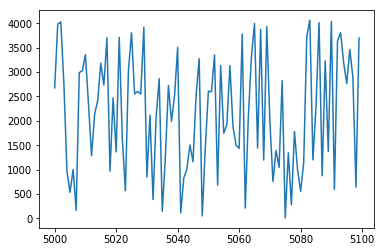

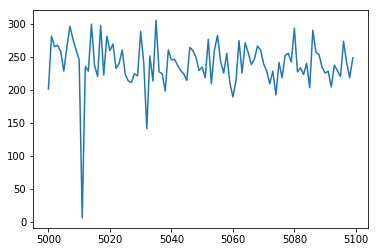

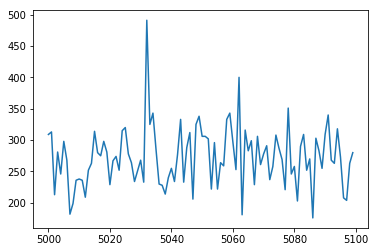

In [217]:
thing = "C:/Users/Larmor/Dropbox/AngerCamera/Wide_Angle_NSE_2022/"+"CG4B"+str(6144)+".dat"
print(thing)

data_temp, BG = loadData(thing,imgpar)

time_pic = BinDataT(data_temp,1)
time_pic = np.array(time_pic)
    
fig1 = plt.plot(range(5000,5100), time_pic[5000:5100,0])
plt.show()
fig2 = plt.plot(range(5000,5100), time_pic[5000:5100,1])
plt.show()
fig3 = plt.plot(range(5000,5100), time_pic[5000:5100,2])
plt.show()

Files used: ['CG4B2215.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Raw Image:


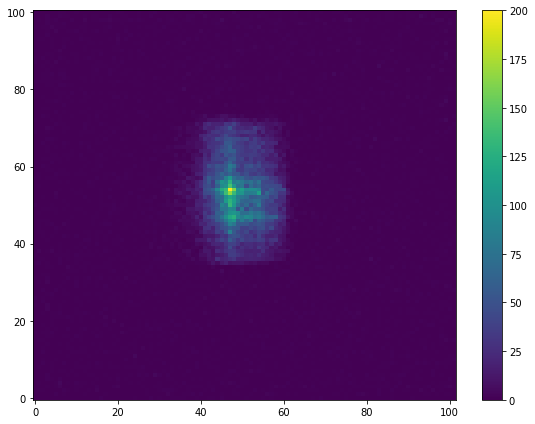

Total counts in summed ROI:  17585.477096966093


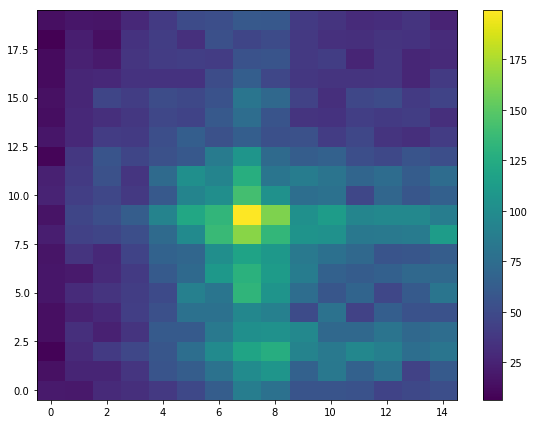

17585.477096966093


'temp2, tot2 = reduce_data(2216,2216, print_fnames=True, print_raw=False, print_BGsub=False,     print_ROI=False, print_summed=True)\nprint(tot2)'

In [86]:
temp, tot = reduce_data(2215,2215, print_fnames=True, print_raw=True, print_BGsub=False, \
    print_ROI=False, print_summed=True)
print(tot)

"""temp2, tot2 = reduce_data(2216,2216, print_fnames=True, print_raw=False, print_BGsub=False, \
    print_ROI=False, print_summed=True)
print(tot2)"""

Start of Flipping Mode Anger Camera Measurements (RF OFF)

In [36]:
#RF off
#b2 scan, b1 = 2, nutator1 =-5
zero_counts = []    #add all subscans that are zero counts here

currents = np.arange(-2.5,-1.5,.1)
print("Currents used: ", currents, " \n Total=", len(currents), "\n")
high_counts = []
high_totals = []
start = 488
subscans = 10

for i in range(len(currents)):
    print("Current=", round(currents[i],3))
    if ((start + (subscans - 1) + int(i)*subscans) not in zero_counts):
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans, \
                          print_summed=False, print_fnames=False)
        high_counts.append(run[0])
        high_totals.append(run[1])
    else: 
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans - 1, \
                          print_summed=False, print_fnames=False)
        high_counts.append(run[0])
        high_totals.append(run[1])
        print("Warning: one subscan failed!")
        
Peak_h = max(high_totals)
Trough_h = min(high_totals)
Peak_current_h = np.argmax(high_totals)
Trough_current_h = np.argmin(high_totals)

print("\n Peak counts: ", Peak_h, "\n Current: ", round(currents[Peak_current_h],3), "\n")
print("\n Trough counts: ", Trough_h, "\n Current: ", round(currents[Trough_current_h],3), "\n")


Currents used:  [-2.5 -2.4 -2.3 -2.2 -2.1 -2.  -1.9 -1.8 -1.7 -1.6]  
 Total= 10 

Current= -2.5
Current= -2.4
Current= -2.3
Current= -2.2
Current= -2.1
Current= -2.0
Current= -1.9
Current= -1.8
Current= -1.7
Current= -1.6

 Peak counts:  915535.9583581202 
 Current:  -2.0 


 Trough counts:  838631.5217132664 
 Current:  -1.6 



905310.0290832175


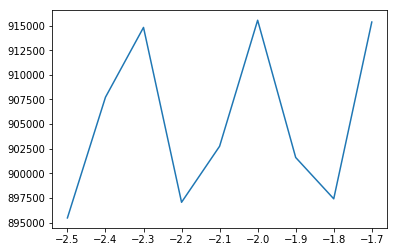

In [39]:
fig = plt.plot(currents[:-1], high_totals[:-1])
high_av = np.average(high_totals[:-1])
print(high_av)

In [40]:
#RF off
#b2 scan, b1 = 2, nutator1 =5
zero_counts = []    #add all subscans that are zero counts here

currents = np.arange(-2.5,-1.5,.1)
print("Currents used: ", currents, " \n Total=", len(currents), "\n")
high_counts = []
high_totals = []
start = 588
subscans = 10

for i in range(len(currents)):
    print("Current=", round(currents[i],3))
    if ((start + (subscans - 1) + int(i)*subscans) not in zero_counts):
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans, \
                          print_summed=False, print_fnames=False)
        high_counts.append(run[0])
        high_totals.append(run[1])
    else: 
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans - 1, \
                          print_summed=False, print_fnames=False)
        high_counts.append(run[0])
        high_totals.append(run[1])
        print("Warning: one subscan failed!")
        
Peak_h = max(high_totals)
Trough_h = min(high_totals)
Peak_current_h = np.argmax(high_totals)
Trough_current_h = np.argmin(high_totals)

print("\n Peak counts: ", Peak_h, "\n Current: ", round(currents[Peak_current_h],3), "\n")
print("\n Trough counts: ", Trough_h, "\n Current: ", round(currents[Trough_current_h],3), "\n")


Currents used:  [-2.5 -2.4 -2.3 -2.2 -2.1 -2.  -1.9 -1.8 -1.7 -1.6]  
 Total= 10 

Current= -2.5
Current= -2.4
Current= -2.3
Current= -2.2
Current= -2.1
Current= -2.0
Current= -1.9
Current= -1.8
Current= -1.7
Current= -1.6

 Peak counts:  110064.00832837602 
 Current:  -1.6 


 Trough counts:  40091.99048185599 
 Current:  -1.9 



49646.41139533345
18.235155445058265


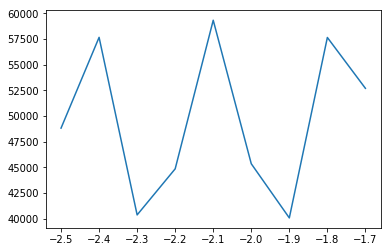

In [42]:
fig = plt.plot(currents[:-1], high_totals[:-1])
low_av = np.average(high_totals[:-1])
print(low_av)
print(high_av/low_av)

Currents used:  [2.5 2.4 2.3 2.2 2.1 2.  1.9 1.8 1.7 1.6]  
 Total= 10 

Current= 2.5
Files used: ['CG4B688.dat', 'CG4B689.dat', 'CG4B690.dat', 'CG4B691.dat', 'CG4B692.dat', 'CG4B693.dat', 'CG4B694.dat', 'CG4B695.dat', 'CG4B696.dat', 'CG4B697.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  912406.6668649613


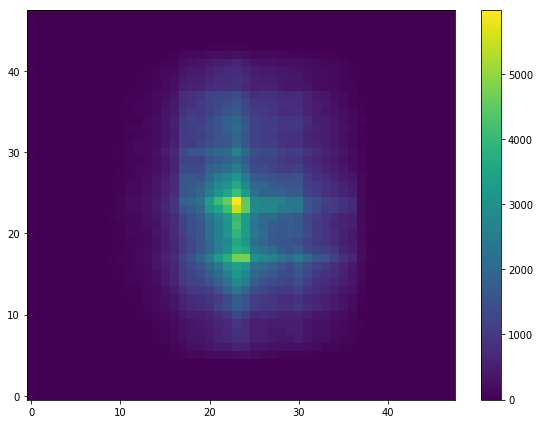

Current= 2.4
Files used: ['CG4B698.dat', 'CG4B699.dat', 'CG4B700.dat', 'CG4B701.dat', 'CG4B702.dat', 'CG4B703.dat', 'CG4B704.dat', 'CG4B705.dat', 'CG4B706.dat', 'CG4B707.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  909795.9167162403


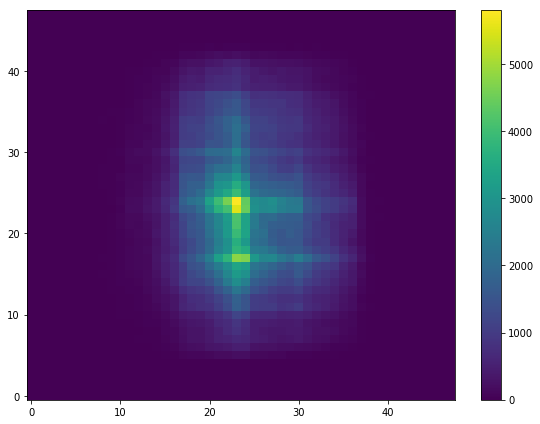

Current= 2.3
Files used: ['CG4B708.dat', 'CG4B709.dat', 'CG4B710.dat', 'CG4B711.dat', 'CG4B712.dat', 'CG4B713.dat', 'CG4B714.dat', 'CG4B715.dat', 'CG4B716.dat', 'CG4B717.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  887530.9625223086


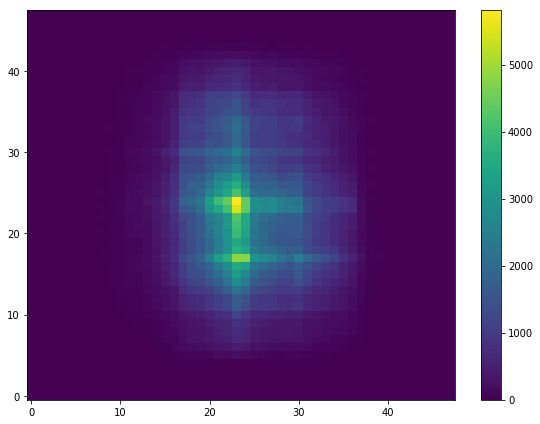

Current= 2.2
Files used: ['CG4B718.dat', 'CG4B719.dat', 'CG4B720.dat', 'CG4B721.dat', 'CG4B722.dat', 'CG4B723.dat', 'CG4B724.dat', 'CG4B725.dat', 'CG4B726.dat', 'CG4B727.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  905279.4979179057


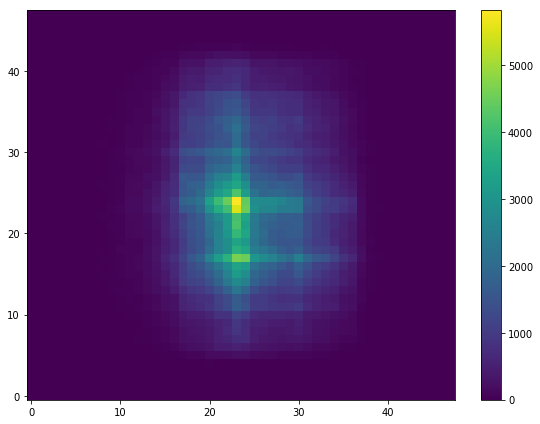

Current= 2.1
Files used: ['CG4B728.dat', 'CG4B729.dat', 'CG4B730.dat', 'CG4B731.dat', 'CG4B732.dat', 'CG4B733.dat', 'CG4B734.dat', 'CG4B735.dat', 'CG4B736.dat', 'CG4B737.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  913791.9583581202


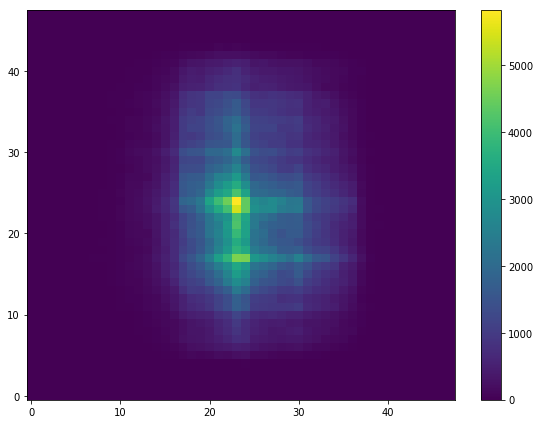

Current= 2.0
Files used: ['CG4B738.dat', 'CG4B739.dat', 'CG4B740.dat', 'CG4B741.dat', 'CG4B742.dat', 'CG4B743.dat', 'CG4B744.dat', 'CG4B745.dat', 'CG4B746.dat', 'CG4B747.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  894178.0130874485


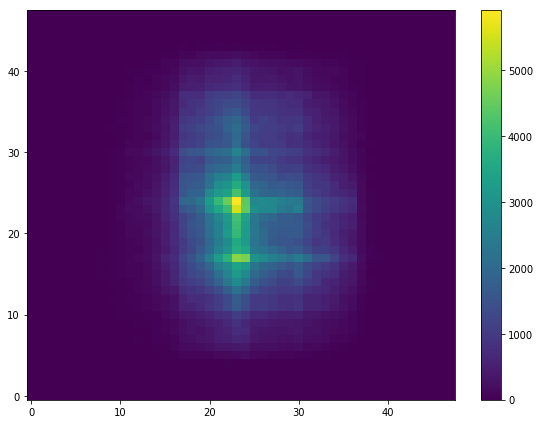

Current= 1.9
Files used: ['CG4B748.dat', 'CG4B749.dat', 'CG4B750.dat', 'CG4B751.dat', 'CG4B752.dat', 'CG4B753.dat', 'CG4B754.dat', 'CG4B755.dat', 'CG4B756.dat', 'CG4B757.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  893917.3027959539


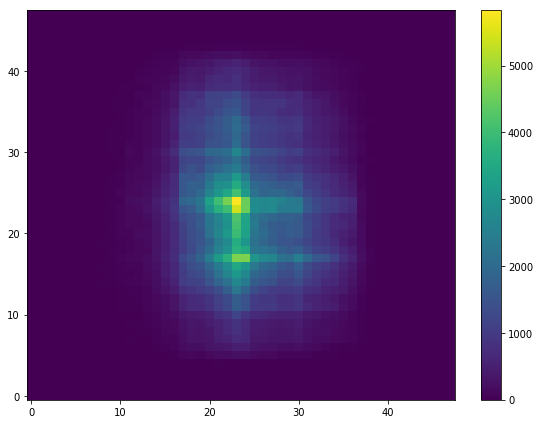

Current= 1.8
Files used: ['CG4B758.dat', 'CG4B759.dat', 'CG4B760.dat', 'CG4B761.dat', 'CG4B762.dat', 'CG4B763.dat', 'CG4B764.dat', 'CG4B765.dat', 'CG4B766.dat', 'CG4B767.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  915983.3093396786


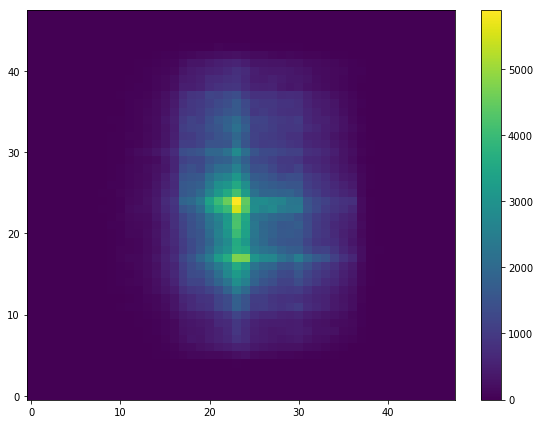

Current= 1.7
Files used: ['CG4B768.dat', 'CG4B769.dat', 'CG4B770.dat', 'CG4B771.dat', 'CG4B772.dat', 'CG4B773.dat', 'CG4B774.dat', 'CG4B775.dat', 'CG4B776.dat', 'CG4B777.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  904548.3902439032


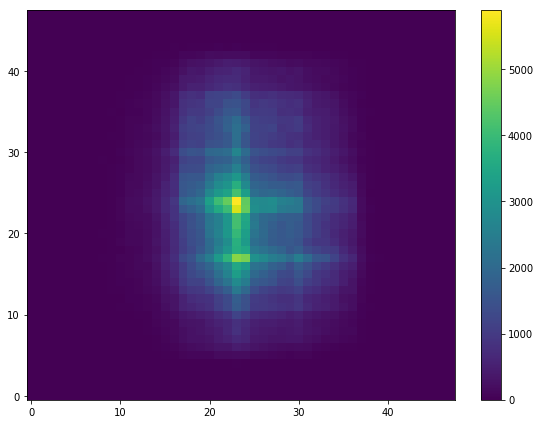

Current= 1.6
Files used: ['CG4B778.dat', 'CG4B779.dat', 'CG4B780.dat', 'CG4B781.dat', 'CG4B782.dat', 'CG4B783.dat', 'CG4B784.dat', 'CG4B785.dat', 'CG4B786.dat', 'CG4B787.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  819358.4009518154


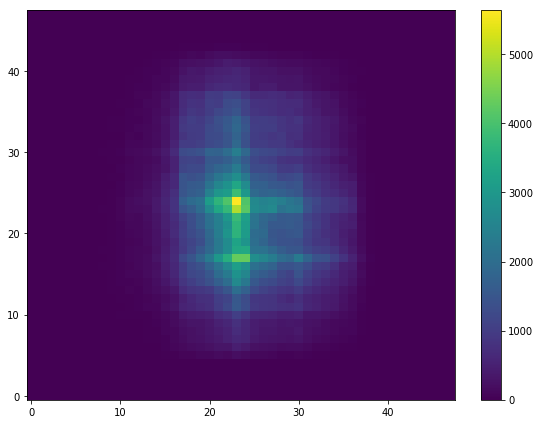


 Peak counts:  915983.3093396786 
 Current:  1.8 


 Trough counts:  819358.4009518154 
 Current:  1.6 



In [5]:
#RF off
#b1 scan, b2 = -2, nutator1 =-5
zero_counts = []    #add all subscans that are zero counts here

currents = np.arange(2.5,1.5,-.1)
print("Currents used: ", currents, " \n Total=", len(currents), "\n")
high_counts = []
high_totals = []
start = 688
subscans = 10

for i in range(len(currents)):
    print("Current=", round(currents[i],3))
    if ((start + (subscans - 1) + int(i)*subscans) not in zero_counts):
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans, \
                          print_summed=True, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
    else: 
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans - 1, \
                          print_summed=True, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
        print("Warning: one subscan failed!")
        
Peak_h = max(high_totals)
Trough_h = min(high_totals)
Peak_current_h = np.argmax(high_totals)
Trough_current_h = np.argmin(high_totals)

print("\n Peak counts: ", Peak_h, "\n Current: ", round(currents[Peak_current_h],3), "\n")
print("\n Trough counts: ", Trough_h, "\n Current: ", round(currents[Trough_current_h],3), "\n")


Currents used:  [2.5 2.4 2.3 2.2 2.1 2.  1.9 1.8 1.7 1.6]  
 Total= 10 

Current= 2.5
Files used: ['CG4B788.dat', 'CG4B789.dat', 'CG4B790.dat', 'CG4B791.dat', 'CG4B792.dat', 'CG4B793.dat', 'CG4B794.dat', 'CG4B795.dat', 'CG4B796.dat', 'CG4B797.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  59894.569303985736


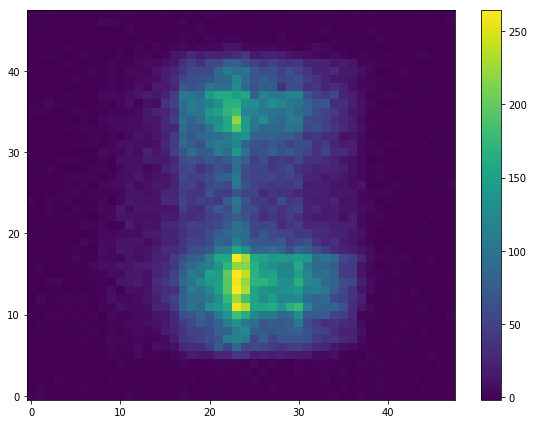

Current= 2.4
Files used: ['CG4B798.dat', 'CG4B799.dat', 'CG4B800.dat', 'CG4B801.dat', 'CG4B802.dat', 'CG4B803.dat', 'CG4B804.dat', 'CG4B805.dat', 'CG4B806.dat', 'CG4B807.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  56953.20107079128


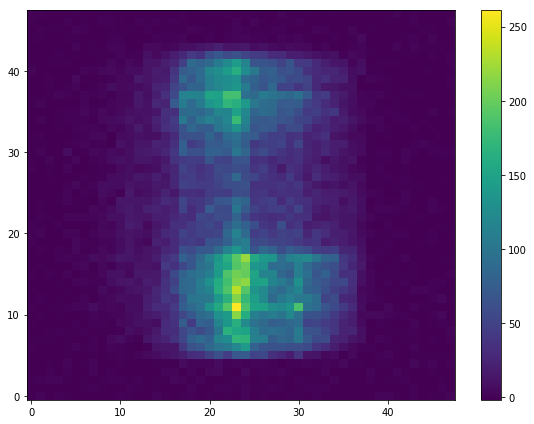

Current= 2.3
Files used: ['CG4B808.dat', 'CG4B809.dat', 'CG4B810.dat', 'CG4B811.dat', 'CG4B812.dat', 'CG4B813.dat', 'CG4B814.dat', 'CG4B815.dat', 'CG4B816.dat', 'CG4B817.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  85363.1969066032


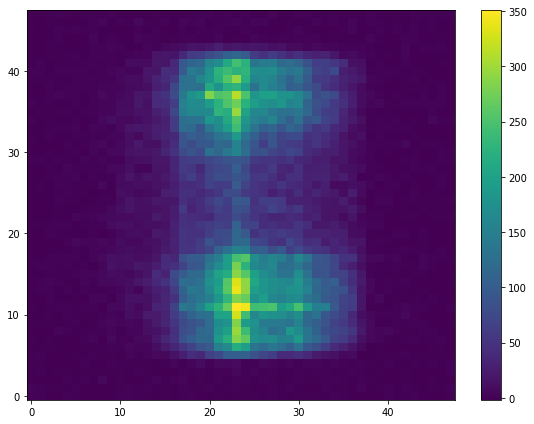

Current= 2.2
Files used: ['CG4B818.dat', 'CG4B819.dat', 'CG4B820.dat', 'CG4B821.dat', 'CG4B822.dat', 'CG4B823.dat', 'CG4B824.dat', 'CG4B825.dat', 'CG4B826.dat', 'CG4B827.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  68745.39619274247


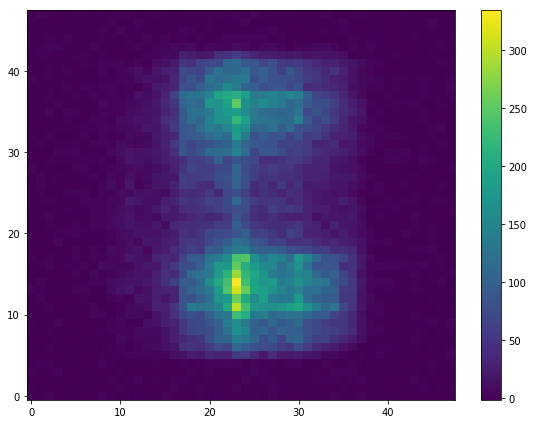

Current= 2.1
Files used: ['CG4B828.dat', 'CG4B829.dat', 'CG4B830.dat', 'CG4B831.dat', 'CG4B832.dat', 'CG4B833.dat', 'CG4B834.dat', 'CG4B835.dat', 'CG4B836.dat', 'CG4B837.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  51508.61332540156


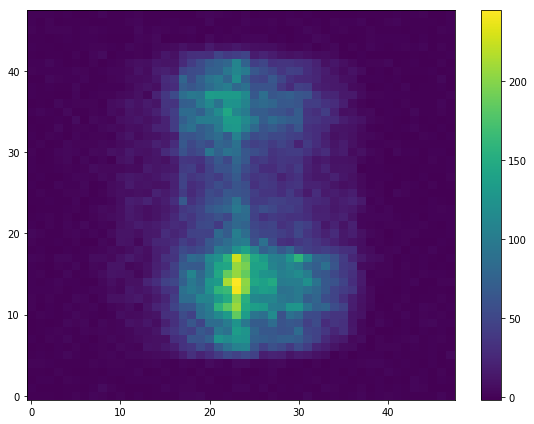

Current= 2.0
Files used: ['CG4B838.dat', 'CG4B839.dat', 'CG4B840.dat', 'CG4B841.dat', 'CG4B842.dat', 'CG4B843.dat', 'CG4B844.dat', 'CG4B845.dat', 'CG4B846.dat', 'CG4B847.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  77966.71445568123


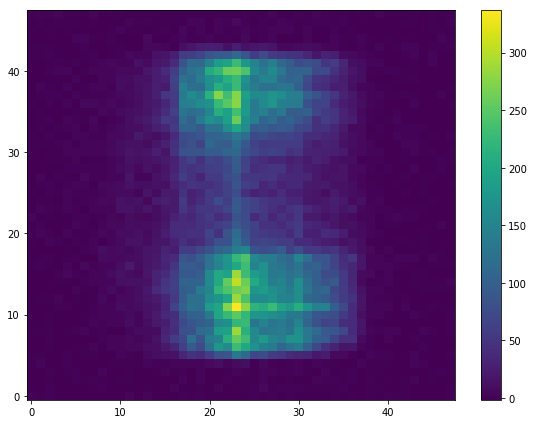

Current= 1.9
Files used: ['CG4B848.dat', 'CG4B849.dat', 'CG4B850.dat', 'CG4B851.dat', 'CG4B852.dat', 'CG4B853.dat', 'CG4B854.dat', 'CG4B855.dat', 'CG4B856.dat', 'CG4B857.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  80253.36109458655


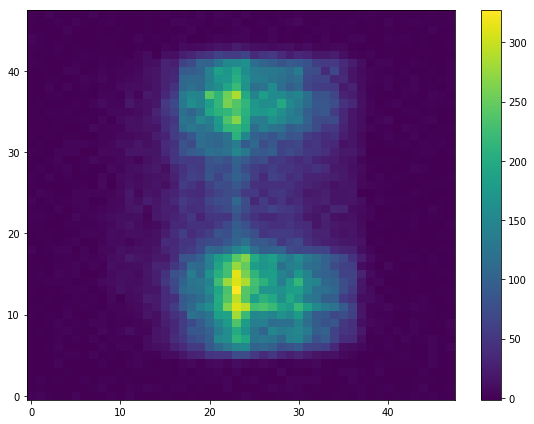

Current= 1.8
Files used: ['CG4B858.dat', 'CG4B859.dat', 'CG4B860.dat', 'CG4B861.dat', 'CG4B862.dat', 'CG4B863.dat', 'CG4B864.dat', 'CG4B865.dat', 'CG4B866.dat', 'CG4B867.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  53159.218322427056


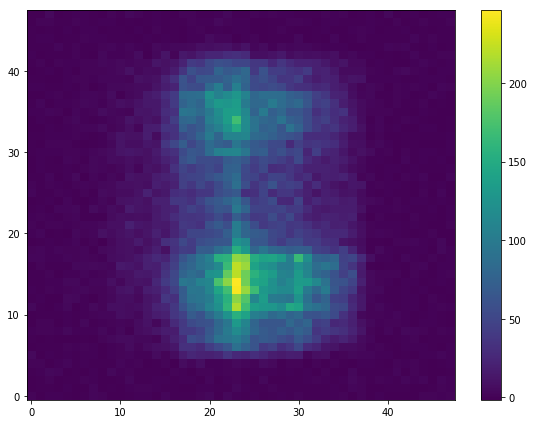

Current= 1.7
Files used: ['CG4B868.dat', 'CG4B869.dat', 'CG4B870.dat', 'CG4B871.dat', 'CG4B872.dat', 'CG4B873.dat', 'CG4B874.dat', 'CG4B875.dat', 'CG4B876.dat', 'CG4B877.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  65759.93575252825


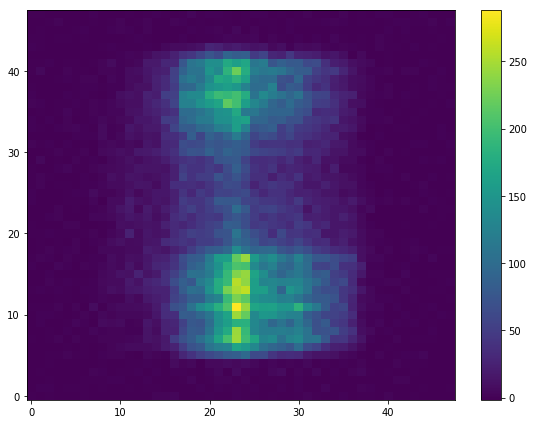

Current= 1.6
Files used: ['CG4B878.dat', 'CG4B879.dat', 'CG4B880.dat', 'CG4B881.dat', 'CG4B882.dat', 'CG4B883.dat', 'CG4B884.dat', 'CG4B885.dat', 'CG4B886.dat', 'CG4B887.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  153996.99524092805


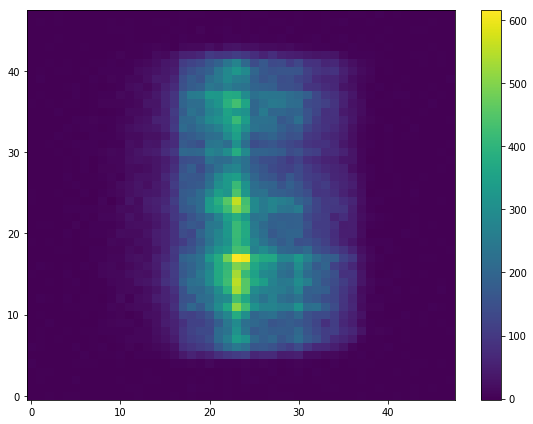


 Peak counts:  153996.99524092805 
 Current:  1.6 


 Trough counts:  51508.61332540156 
 Current:  2.1 



In [6]:
#RF off
#b1 scan, b2 = -2, nutator1 =5
zero_counts = []    #add all subscans that are zero counts here

currents = np.arange(2.5,1.5,-.1)
print("Currents used: ", currents, " \n Total=", len(currents), "\n")
high_counts = []
high_totals = []
start = 788
subscans = 10

for i in range(len(currents)):
    print("Current=", round(currents[i],3))
    if ((start + (subscans - 1) + int(i)*subscans) not in zero_counts):
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans, \
                          print_summed=True, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
    else: 
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans - 1, \
                          print_summed=True, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
        print("Warning: one subscan failed!")
        
Peak_h = max(high_totals)
Trough_h = min(high_totals)
Peak_current_h = np.argmax(high_totals)
Trough_current_h = np.argmin(high_totals)

print("\n Peak counts: ", Peak_h, "\n Current: ", round(currents[Peak_current_h],3), "\n")
print("\n Trough counts: ", Trough_h, "\n Current: ", round(currents[Trough_current_h],3), "\n")


Currents used:  [-6.5 -6.4 -6.3 -6.2 -6.1 -6.  -5.9 -5.8 -5.7 -5.6]  
 Total= 10 

Current= -6.5
Files used: ['CG4B888.dat', 'CG4B889.dat', 'CG4B890.dat', 'CG4B891.dat', 'CG4B892.dat', 'CG4B893.dat', 'CG4B894.dat', 'CG4B895.dat', 'CG4B896.dat', 'CG4B897.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  895402.5217132664


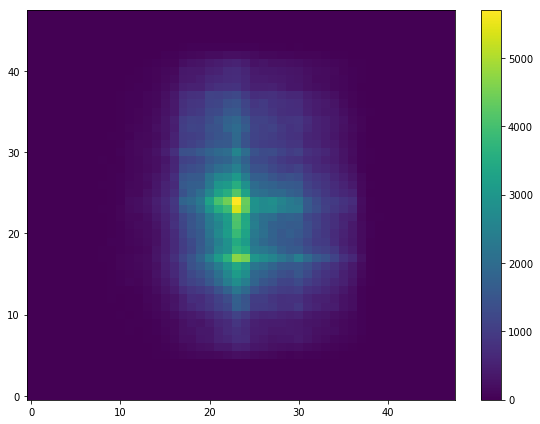

Current= -6.4
Files used: ['CG4B898.dat', 'CG4B899.dat', 'CG4B900.dat', 'CG4B901.dat', 'CG4B902.dat', 'CG4B903.dat', 'CG4B904.dat', 'CG4B905.dat', 'CG4B906.dat', 'CG4B907.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  885130.8245092207


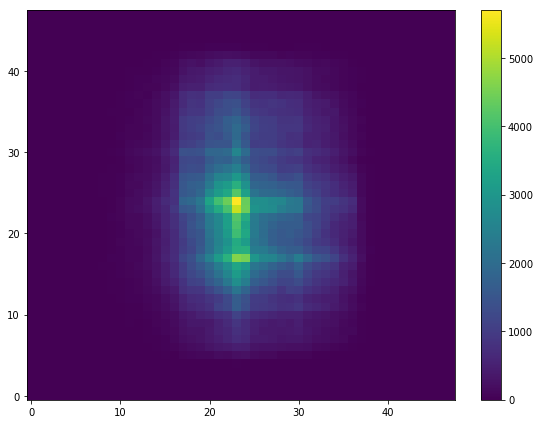

Current= -6.3
Files used: ['CG4B908.dat', 'CG4B909.dat', 'CG4B910.dat', 'CG4B911.dat', 'CG4B912.dat', 'CG4B913.dat', 'CG4B914.dat', 'CG4B915.dat', 'CG4B916.dat', 'CG4B917.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  876820.2099940514


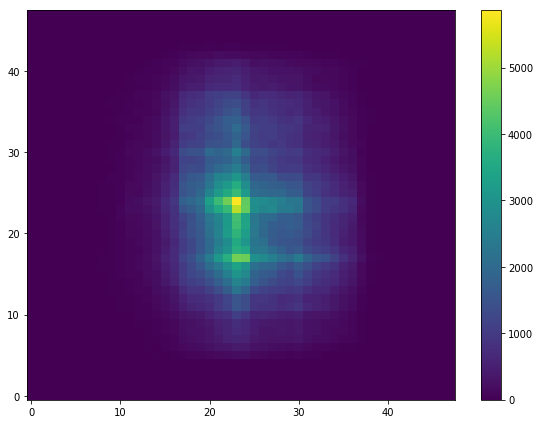

Current= -6.2
Files used: ['CG4B918.dat', 'CG4B919.dat', 'CG4B920.dat', 'CG4B921.dat', 'CG4B922.dat', 'CG4B923.dat', 'CG4B924.dat', 'CG4B925.dat', 'CG4B926.dat', 'CG4B927.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  893217.5371802492


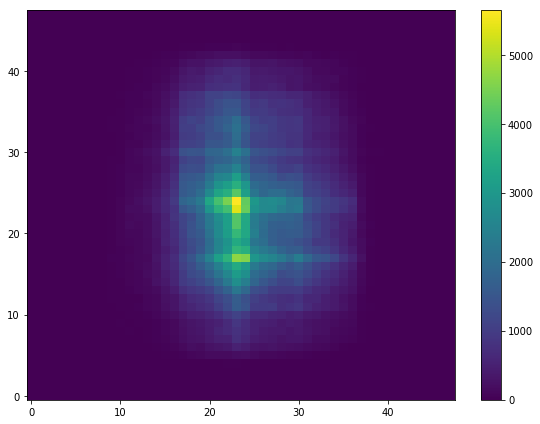

Current= -6.1
Files used: ['CG4B928.dat', 'CG4B929.dat', 'CG4B930.dat', 'CG4B931.dat', 'CG4B932.dat', 'CG4B933.dat', 'CG4B934.dat', 'CG4B935.dat', 'CG4B936.dat', 'CG4B937.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  891694.1992861391


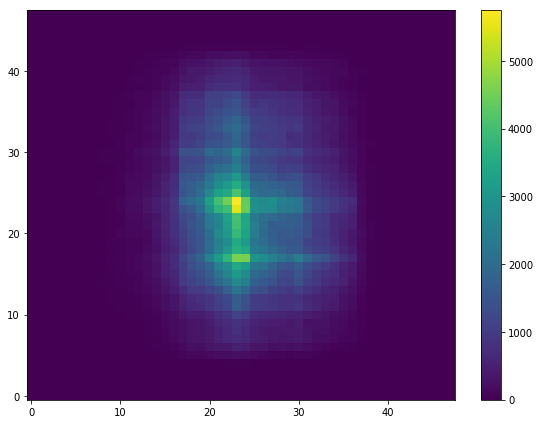

Current= -6.0
Files used: ['CG4B938.dat', 'CG4B939.dat', 'CG4B940.dat', 'CG4B941.dat', 'CG4B942.dat', 'CG4B943.dat', 'CG4B944.dat', 'CG4B945.dat', 'CG4B946.dat', 'CG4B947.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  875210.9976204636


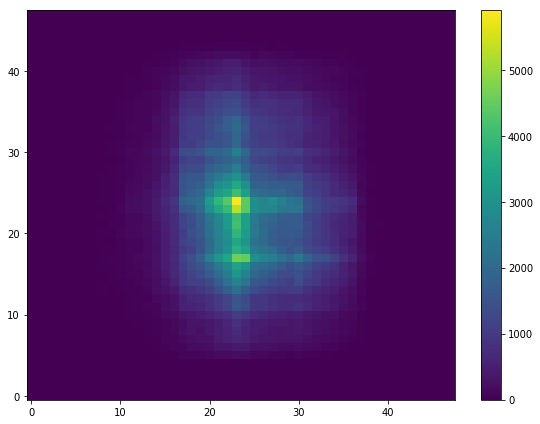

Current= -5.9
Files used: ['CG4B948.dat', 'CG4B949.dat', 'CG4B950.dat', 'CG4B951.dat', 'CG4B952.dat', 'CG4B953.dat', 'CG4B954.dat', 'CG4B955.dat', 'CG4B956.dat', 'CG4B957.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  887252.5919095785


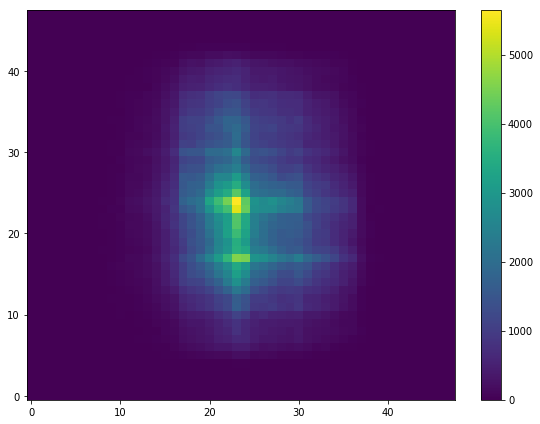

Current= -5.8
Files used: ['CG4B958.dat', 'CG4B959.dat', 'CG4B960.dat', 'CG4B961.dat', 'CG4B962.dat', 'CG4B963.dat', 'CG4B964.dat', 'CG4B965.dat', 'CG4B966.dat', 'CG4B967.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  895243.045806068


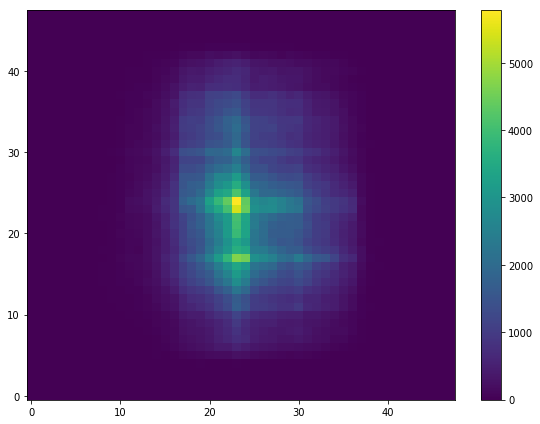

Current= -5.7
Files used: ['CG4B968.dat', 'CG4B969.dat', 'CG4B970.dat', 'CG4B971.dat', 'CG4B972.dat', 'CG4B973.dat', 'CG4B974.dat', 'CG4B975.dat', 'CG4B976.dat', 'CG4B977.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  876932.2385484828


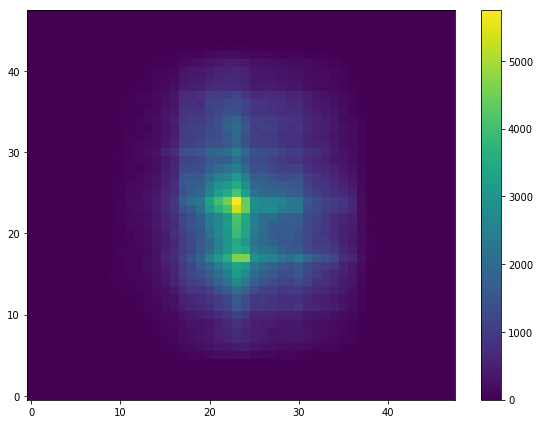

Current= -5.6
Files used: ['CG4B978.dat', 'CG4B979.dat', 'CG4B980.dat', 'CG4B981.dat', 'CG4B982.dat', 'CG4B983.dat', 'CG4B984.dat', 'CG4B985.dat', 'CG4B986.dat', 'CG4B987.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  810006.8435455097


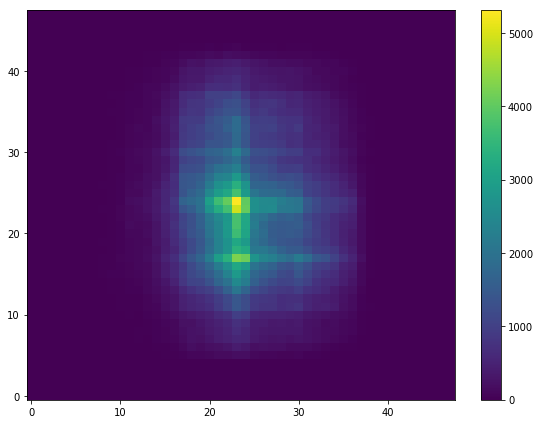


 Peak counts:  895402.5217132664 
 Current:  -6.5 


 Trough counts:  810006.8435455097 
 Current:  -5.6 



In [7]:
#RF off
#b2 scan, b1 = 6, nutator1 =-5
zero_counts = []    #add all subscans that are zero counts here

currents = np.arange(-6.5,-5.5,.1)
print("Currents used: ", currents, " \n Total=", len(currents), "\n")
high_counts = []
high_totals = []
start = 888
subscans = 10

for i in range(len(currents)):
    print("Current=", round(currents[i],3))
    if ((start + (subscans - 1) + int(i)*subscans) not in zero_counts):
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans, \
                          print_summed=True, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
    else: 
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans - 1, \
                          print_summed=True, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
        print("Warning: one subscan failed!")
        
Peak_h = max(high_totals)
Trough_h = min(high_totals)
Peak_current_h = np.argmax(high_totals)
Trough_current_h = np.argmin(high_totals)

print("\n Peak counts: ", Peak_h, "\n Current: ", round(currents[Peak_current_h],3), "\n")
print("\n Trough counts: ", Trough_h, "\n Current: ", round(currents[Trough_current_h],3), "\n")


Currents used:  [-6.5 -6.4 -6.3 -6.2 -6.1 -6.  -5.9 -5.8 -5.7 -5.6]  
 Total= 10 

Current= -6.5
Files used: ['CG4B988.dat', 'CG4B989.dat', 'CG4B990.dat', 'CG4B991.dat', 'CG4B992.dat', 'CG4B993.dat', 'CG4B994.dat', 'CG4B995.dat', 'CG4B996.dat', 'CG4B997.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  72537.07376561577


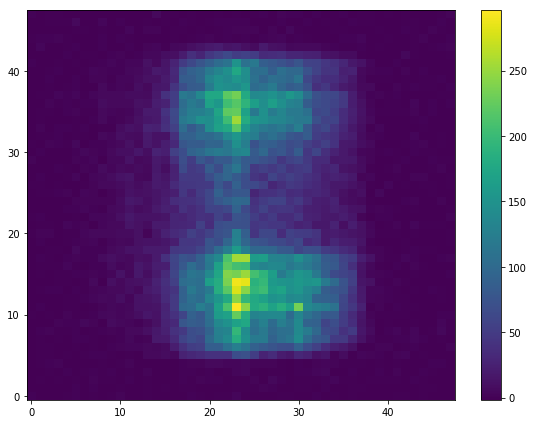

Current= -6.4
Files used: ['CG4B998.dat', 'CG4B999.dat', 'CG4B1000.dat', 'CG4B1001.dat', 'CG4B1002.dat', 'CG4B1003.dat', 'CG4B1004.dat', 'CG4B1005.dat', 'CG4B1006.dat', 'CG4B1007.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  60426.185603807164


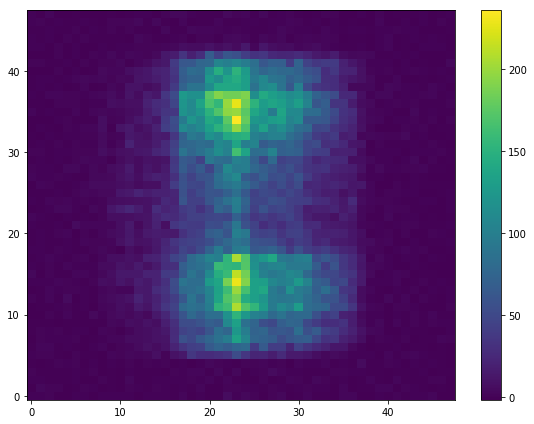

Current= -6.3
Files used: ['CG4B1008.dat', 'CG4B1009.dat', 'CG4B1010.dat', 'CG4B1011.dat', 'CG4B1012.dat', 'CG4B1013.dat', 'CG4B1014.dat', 'CG4B1015.dat', 'CG4B1016.dat', 'CG4B1017.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  80262.68352171336


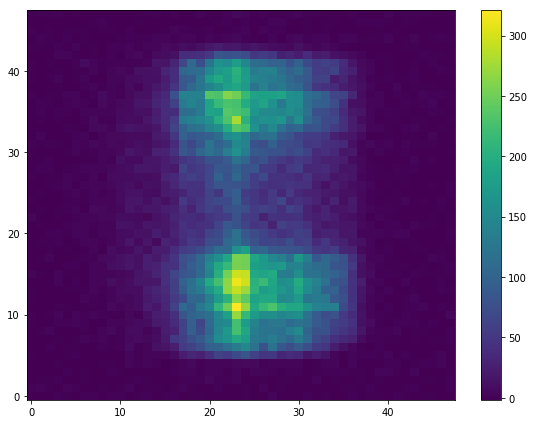

Current= -6.2
Files used: ['CG4B1018.dat', 'CG4B1019.dat', 'CG4B1020.dat', 'CG4B1021.dat', 'CG4B1022.dat', 'CG4B1023.dat', 'CG4B1024.dat', 'CG4B1025.dat', 'CG4B1026.dat', 'CG4B1027.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  78299.00594883997


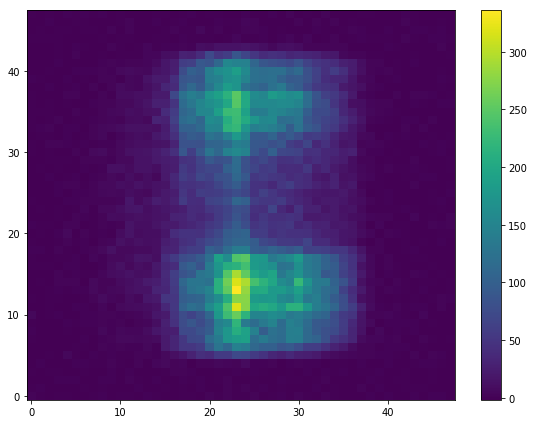

Current= -6.1
Files used: ['CG4B1028.dat', 'CG4B1029.dat', 'CG4B1030.dat', 'CG4B1031.dat', 'CG4B1032.dat', 'CG4B1033.dat', 'CG4B1034.dat', 'CG4B1035.dat', 'CG4B1036.dat', 'CG4B1037.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  59821.01665675191


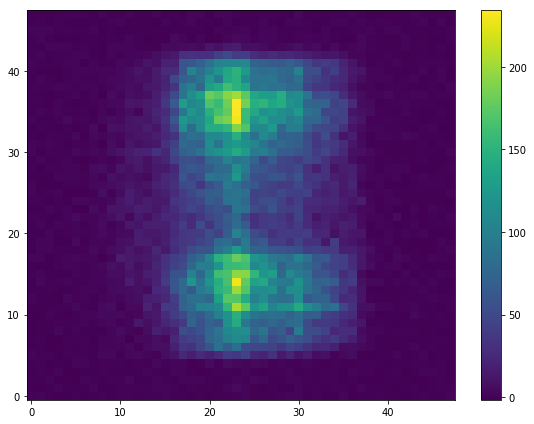

Current= -6.0
Files used: ['CG4B1038.dat', 'CG4B1039.dat', 'CG4B1040.dat', 'CG4B1041.dat', 'CG4B1042.dat', 'CG4B1043.dat', 'CG4B1044.dat', 'CG4B1045.dat', 'CG4B1046.dat', 'CG4B1047.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  75535.83700178476


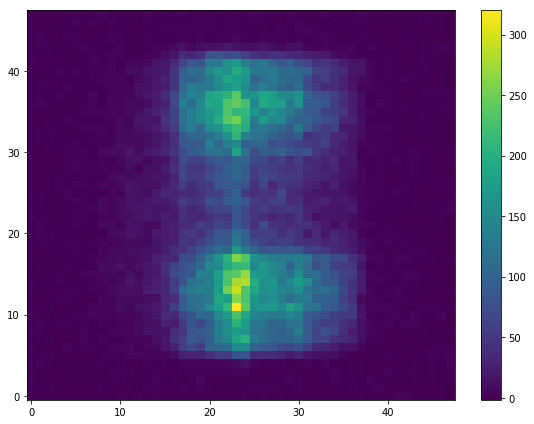

Current= -5.9
Files used: ['CG4B1048.dat', 'CG4B1049.dat', 'CG4B1050.dat', 'CG4B1051.dat', 'CG4B1052.dat', 'CG4B1053.dat', 'CG4B1054.dat', 'CG4B1055.dat', 'CG4B1056.dat', 'CG4B1057.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  83882.60023795361


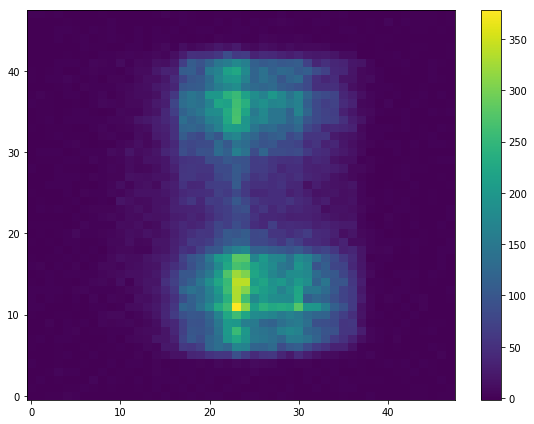

Current= -5.8
Files used: ['CG4B1058.dat', 'CG4B1059.dat', 'CG4B1060.dat', 'CG4B1061.dat', 'CG4B1062.dat', 'CG4B1063.dat', 'CG4B1064.dat', 'CG4B1065.dat', 'CG4B1066.dat', 'CG4B1067.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  63396.97501487204


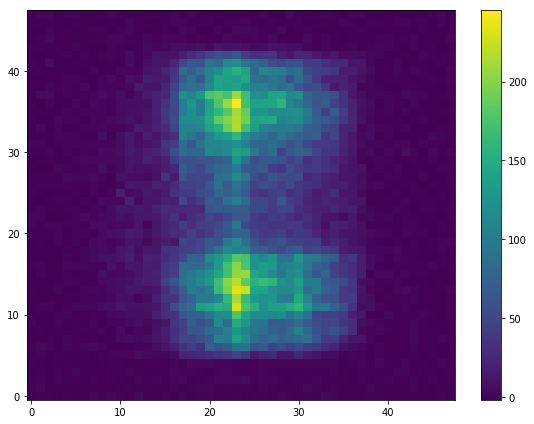

Current= -5.7
Files used: ['CG4B1068.dat', 'CG4B1069.dat', 'CG4B1070.dat', 'CG4B1071.dat', 'CG4B1072.dat', 'CG4B1073.dat', 'CG4B1074.dat', 'CG4B1075.dat', 'CG4B1076.dat', 'CG4B1077.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  69084.56276026179


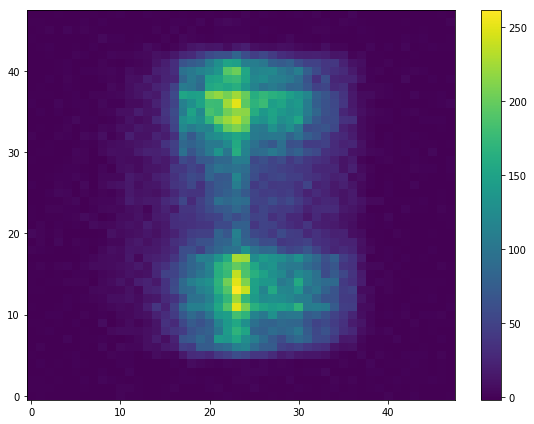

Current= -5.6
Files used: ['CG4B1078.dat', 'CG4B1079.dat', 'CG4B1080.dat', 'CG4B1081.dat', 'CG4B1082.dat', 'CG4B1083.dat', 'CG4B1084.dat', 'CG4B1085.dat', 'CG4B1086.dat', 'CG4B1087.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  153017.3307555026


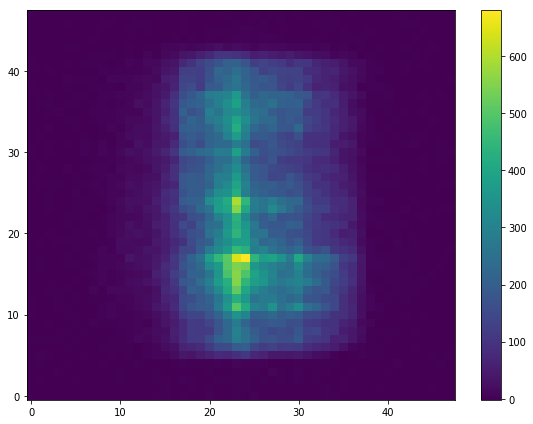


 Peak counts:  153017.3307555026 
 Current:  -5.6 


 Trough counts:  59821.01665675191 
 Current:  -6.1 



In [8]:
#RF off
#b2 scan, b1 = 6, nutator1 =5
zero_counts = []    #add all subscans that are zero counts here

currents = np.arange(-6.5,-5.5,.1)
print("Currents used: ", currents, " \n Total=", len(currents), "\n")
high_counts = []
high_totals = []
start = 988
subscans = 10

for i in range(len(currents)):
    print("Current=", round(currents[i],3))
    if ((start + (subscans - 1) + int(i)*subscans) not in zero_counts):
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans, \
                          print_summed=True, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
    else: 
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans - 1, \
                          print_summed=True, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
        print("Warning: one subscan failed!")
        
Peak_h = max(high_totals)
Trough_h = min(high_totals)
Peak_current_h = np.argmax(high_totals)
Trough_current_h = np.argmin(high_totals)

print("\n Peak counts: ", Peak_h, "\n Current: ", round(currents[Peak_current_h],3), "\n")
print("\n Trough counts: ", Trough_h, "\n Current: ", round(currents[Trough_current_h],3), "\n")


Currents used:  [6.5 6.4 6.3 6.2 6.1 6.  5.9 5.8 5.7 5.6]  
 Total= 10 

Current= 6.5
Files used: ['CG4B1088.dat', 'CG4B1089.dat', 'CG4B1090.dat', 'CG4B1091.dat', 'CG4B1092.dat', 'CG4B1093.dat', 'CG4B1094.dat', 'CG4B1095.dat', 'CG4B1096.dat', 'CG4B1097.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  869683.8042831641


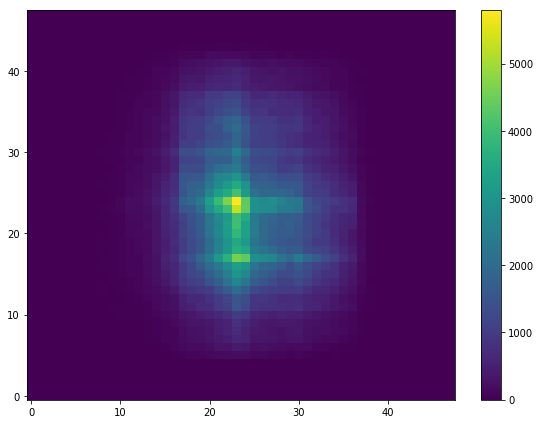

Current= 6.4
Files used: ['CG4B1098.dat', 'CG4B1099.dat', 'CG4B1100.dat', 'CG4B1101.dat', 'CG4B1102.dat', 'CG4B1103.dat', 'CG4B1104.dat', 'CG4B1105.dat', 'CG4B1106.dat', 'CG4B1107.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  893350.9161213563


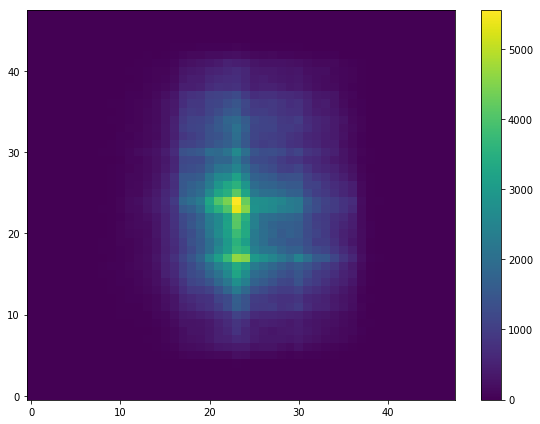

Current= 6.3
Files used: ['CG4B1108.dat', 'CG4B1109.dat', 'CG4B1110.dat', 'CG4B1111.dat', 'CG4B1112.dat', 'CG4B1113.dat', 'CG4B1114.dat', 'CG4B1115.dat', 'CG4B1116.dat', 'CG4B1117.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  869272.0541344432


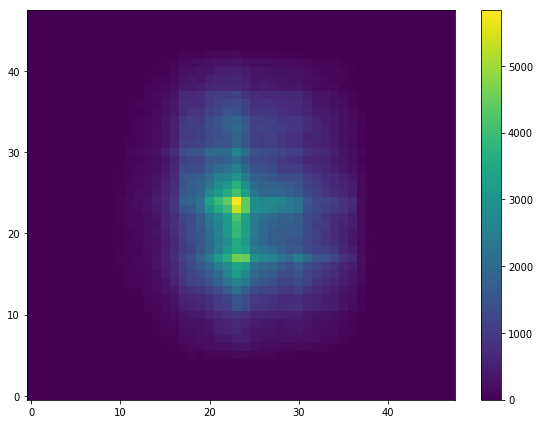

Current= 6.2
Files used: ['CG4B1118.dat', 'CG4B1119.dat', 'CG4B1120.dat', 'CG4B1121.dat', 'CG4B1122.dat', 'CG4B1123.dat', 'CG4B1124.dat', 'CG4B1125.dat', 'CG4B1126.dat', 'CG4B1127.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  859393.9512195123


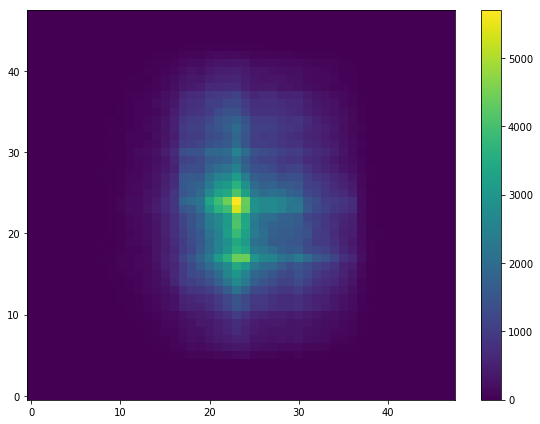

Current= 6.1
Files used: ['CG4B1128.dat', 'CG4B1129.dat', 'CG4B1130.dat', 'CG4B1131.dat', 'CG4B1132.dat', 'CG4B1133.dat', 'CG4B1134.dat', 'CG4B1135.dat', 'CG4B1136.dat', 'CG4B1137.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  893882.947055325


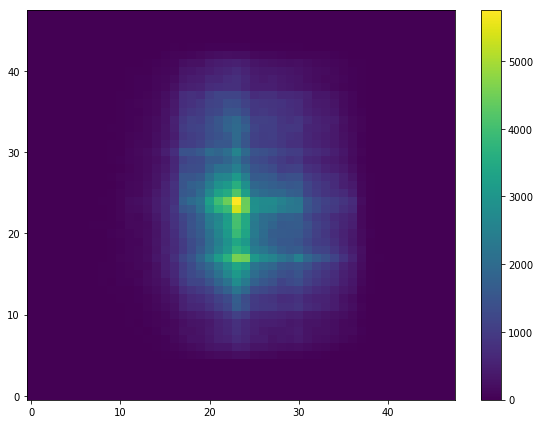

Current= 6.0
Files used: ['CG4B1138.dat', 'CG4B1139.dat', 'CG4B1140.dat', 'CG4B1141.dat', 'CG4B1142.dat', 'CG4B1143.dat', 'CG4B1144.dat', 'CG4B1145.dat', 'CG4B1146.dat', 'CG4B1147.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  880864.5936942303


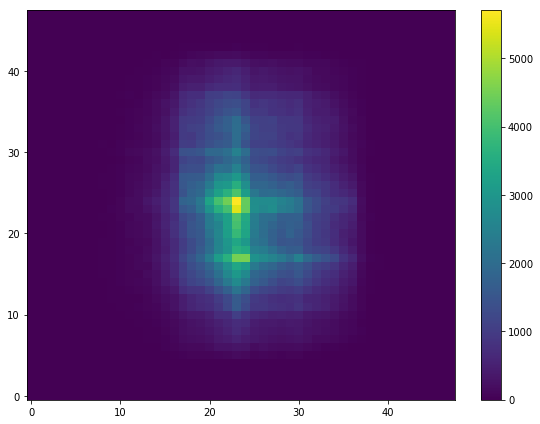

Current= 5.9
Files used: ['CG4B1148.dat', 'CG4B1149.dat', 'CG4B1150.dat', 'CG4B1151.dat', 'CG4B1152.dat', 'CG4B1153.dat', 'CG4B1154.dat', 'CG4B1155.dat', 'CG4B1156.dat', 'CG4B1157.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  858034.444378347


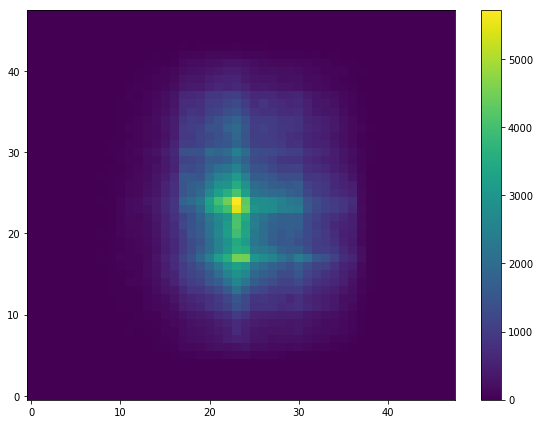

Current= 5.8
Files used: ['CG4B1158.dat', 'CG4B1159.dat', 'CG4B1160.dat', 'CG4B1161.dat', 'CG4B1162.dat', 'CG4B1163.dat', 'CG4B1164.dat', 'CG4B1165.dat', 'CG4B1166.dat', 'CG4B1167.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  881375.602617489


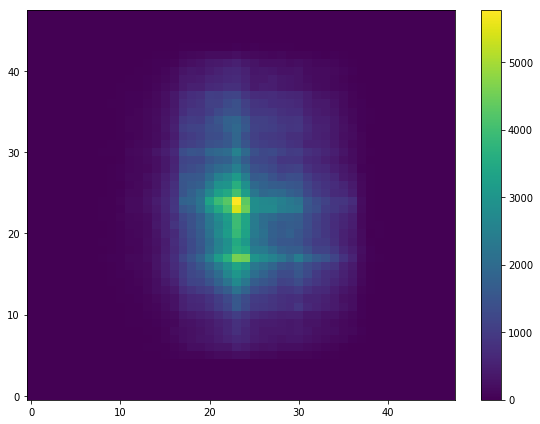

Current= 5.7
Files used: ['CG4B1168.dat', 'CG4B1169.dat', 'CG4B1170.dat', 'CG4B1171.dat', 'CG4B1172.dat', 'CG4B1173.dat', 'CG4B1174.dat', 'CG4B1175.dat', 'CG4B1176.dat', 'CG4B1177.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  890900.6859012493


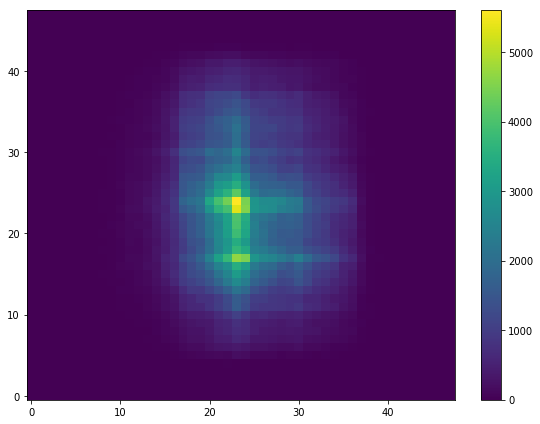

Current= 5.6
Files used: ['CG4B1178.dat', 'CG4B1179.dat', 'CG4B1180.dat', 'CG4B1181.dat', 'CG4B1182.dat', 'CG4B1183.dat', 'CG4B1184.dat', 'CG4B1185.dat', 'CG4B1186.dat', 'CG4B1187.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  795631.9048185619


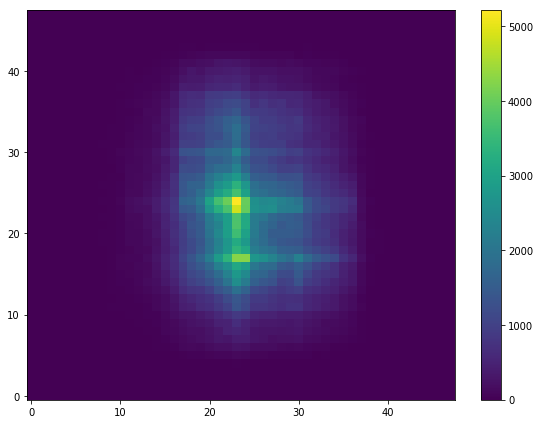


 Peak counts:  893882.947055325 
 Current:  6.1 


 Trough counts:  795631.9048185619 
 Current:  5.6 



In [9]:
#RF off
#b1 scan, b2 = -6, nutator1 =-5
zero_counts = []    #add all subscans that are zero counts here

currents = np.arange(6.5,5.5,-.1)
print("Currents used: ", currents, " \n Total=", len(currents), "\n")
high_counts = []
high_totals = []
start = 1088
subscans = 10

for i in range(len(currents)):
    print("Current=", round(currents[i],3))
    if ((start + (subscans - 1) + int(i)*subscans) not in zero_counts):
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans, \
                          print_summed=True, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
    else: 
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans - 1, \
                          print_summed=True, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
        print("Warning: one subscan failed!")
        
Peak_h = max(high_totals)
Trough_h = min(high_totals)
Peak_current_h = np.argmax(high_totals)
Trough_current_h = np.argmin(high_totals)

print("\n Peak counts: ", Peak_h, "\n Current: ", round(currents[Peak_current_h],3), "\n")
print("\n Trough counts: ", Trough_h, "\n Current: ", round(currents[Trough_current_h],3), "\n")


Currents used:  [6.5 6.4 6.3 6.2 6.1 6.  5.9 5.8 5.7 5.6]  
 Total= 10 

Current= 6.5
Files used: ['CG4B1188.dat', 'CG4B1189.dat', 'CG4B1190.dat', 'CG4B1191.dat', 'CG4B1192.dat', 'CG4B1193.dat', 'CG4B1194.dat', 'CG4B1195.dat', 'CG4B1196.dat', 'CG4B1197.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  75804.85246876873


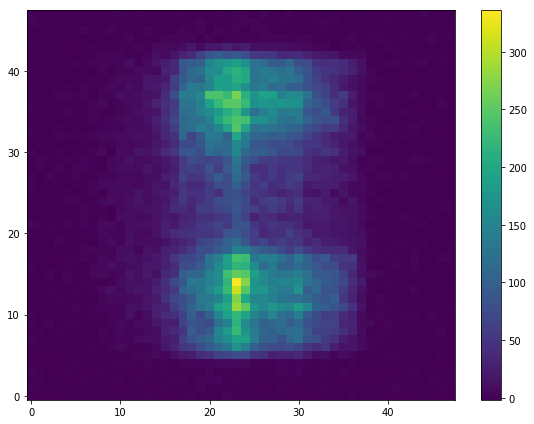

Current= 6.4
Files used: ['CG4B1198.dat', 'CG4B1199.dat', 'CG4B1200.dat', 'CG4B1201.dat', 'CG4B1202.dat', 'CG4B1203.dat', 'CG4B1204.dat', 'CG4B1205.dat', 'CG4B1206.dat', 'CG4B1207.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  54825.57822724571


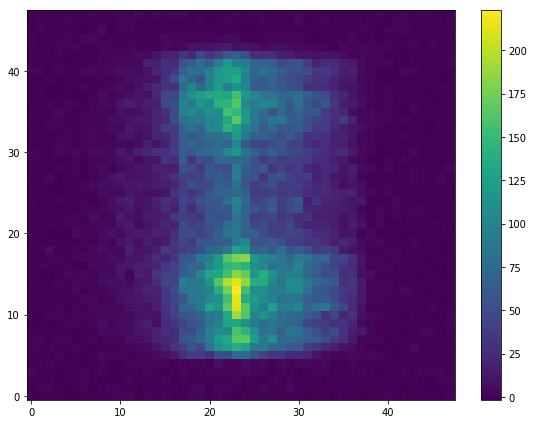

Current= 6.3
Files used: ['CG4B1208.dat', 'CG4B1209.dat', 'CG4B1210.dat', 'CG4B1211.dat', 'CG4B1212.dat', 'CG4B1213.dat', 'CG4B1214.dat', 'CG4B1215.dat', 'CG4B1216.dat', 'CG4B1217.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  78583.91195716843


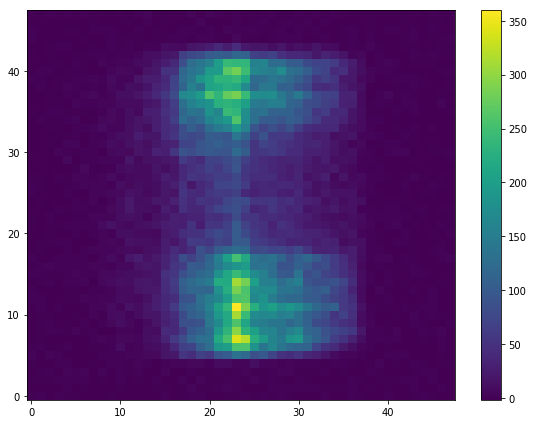

Current= 6.2
Files used: ['CG4B1218.dat', 'CG4B1219.dat', 'CG4B1220.dat', 'CG4B1221.dat', 'CG4B1222.dat', 'CG4B1223.dat', 'CG4B1224.dat', 'CG4B1225.dat', 'CG4B1226.dat', 'CG4B1227.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  82719.07614515175


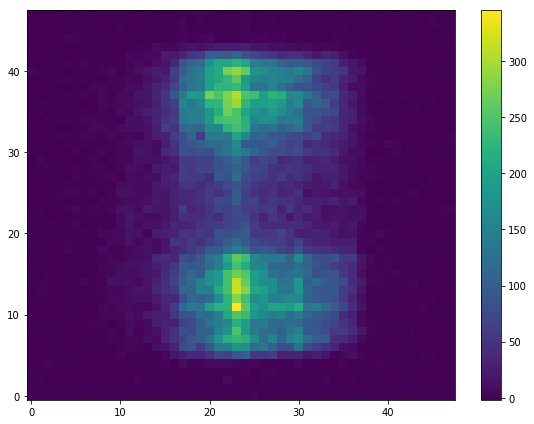

Current= 6.1
Files used: ['CG4B1228.dat', 'CG4B1229.dat', 'CG4B1230.dat', 'CG4B1231.dat', 'CG4B1232.dat', 'CG4B1233.dat', 'CG4B1234.dat', 'CG4B1235.dat', 'CG4B1236.dat', 'CG4B1237.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  54377.80190362877


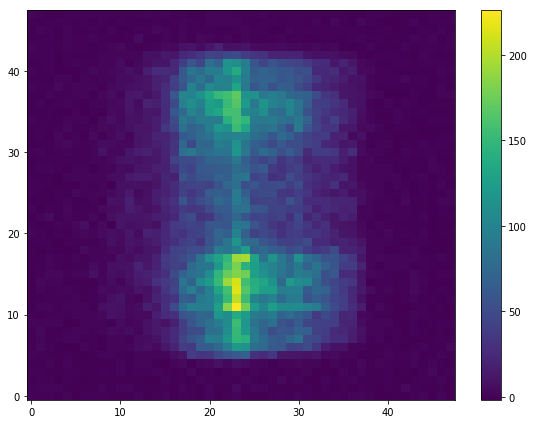

Current= 6.0
Files used: ['CG4B1238.dat', 'CG4B1239.dat', 'CG4B1240.dat', 'CG4B1241.dat', 'CG4B1242.dat', 'CG4B1243.dat', 'CG4B1244.dat', 'CG4B1245.dat', 'CG4B1246.dat', 'CG4B1247.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  68516.57406305778


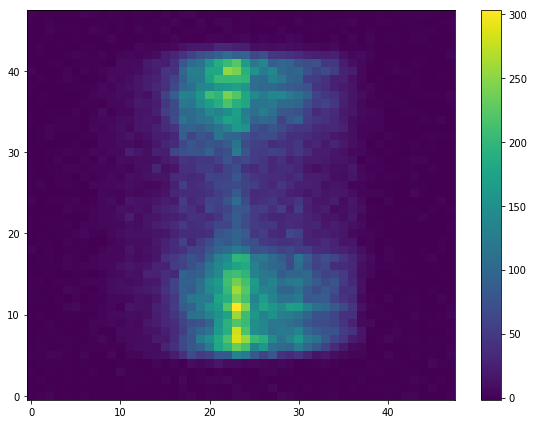

Current= 5.9
Files used: ['CG4B1248.dat', 'CG4B1249.dat', 'CG4B1250.dat', 'CG4B1251.dat', 'CG4B1252.dat', 'CG4B1253.dat', 'CG4B1254.dat', 'CG4B1255.dat', 'CG4B1256.dat', 'CG4B1257.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  87332.55443188574


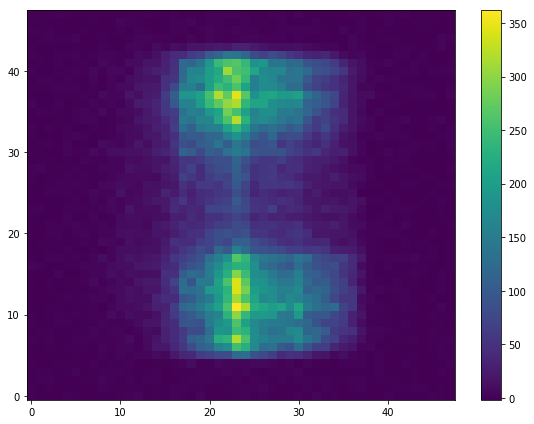

Current= 5.8
Files used: ['CG4B1258.dat', 'CG4B1259.dat', 'CG4B1260.dat', 'CG4B1261.dat', 'CG4B1262.dat', 'CG4B1263.dat', 'CG4B1264.dat', 'CG4B1265.dat', 'CG4B1266.dat', 'CG4B1267.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  60938.961927424185


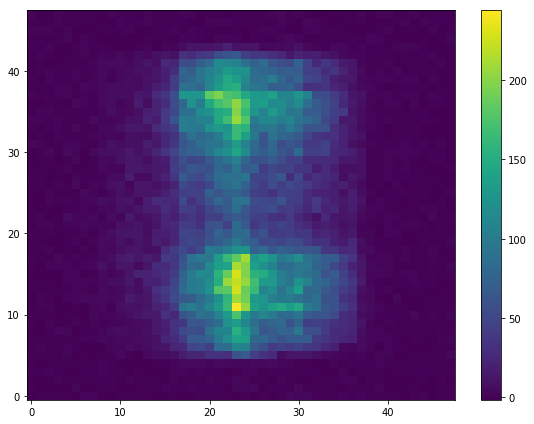

Current= 5.7
Files used: ['CG4B1268.dat', 'CG4B1269.dat', 'CG4B1270.dat', 'CG4B1271.dat', 'CG4B1272.dat', 'CG4B1273.dat', 'CG4B1274.dat', 'CG4B1275.dat', 'CG4B1276.dat', 'CG4B1277.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  56861.06960142771


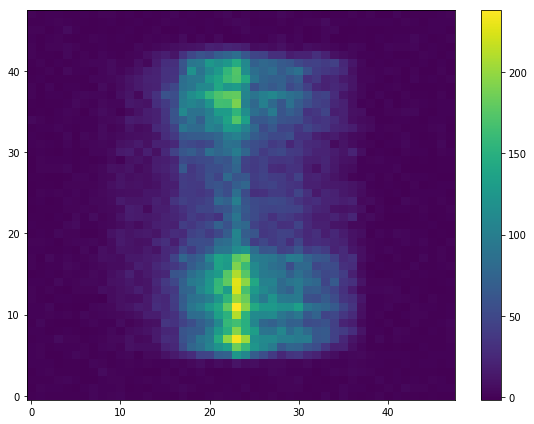

Current= 5.6
Files used: ['CG4B1278.dat', 'CG4B1279.dat', 'CG4B1280.dat', 'CG4B1281.dat', 'CG4B1282.dat', 'CG4B1283.dat', 'CG4B1284.dat', 'CG4B1285.dat', 'CG4B1286.dat', 'CG4B1287.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  151951.99762046378


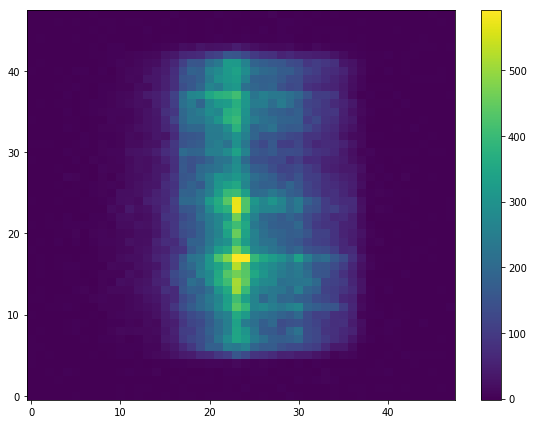


 Peak counts:  151951.99762046378 
 Current:  5.6 


 Trough counts:  54377.80190362877 
 Current:  6.1 



In [10]:
#RF off
#b1 scan, b2 = -6, nutator1 =5
zero_counts = []    #add all subscans that are zero counts here

currents = np.arange(6.5,5.5,-.1)
print("Currents used: ", currents, " \n Total=", len(currents), "\n")
high_counts = []
high_totals = []
start = 1188
subscans = 10

for i in range(len(currents)):
    print("Current=", round(currents[i],3))
    if ((start + (subscans - 1) + int(i)*subscans) not in zero_counts):
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans, \
                          print_summed=True, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
    else: 
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans - 1, \
                          print_summed=True, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
        print("Warning: one subscan failed!")
        
Peak_h = max(high_totals)
Trough_h = min(high_totals)
Peak_current_h = np.argmax(high_totals)
Trough_current_h = np.argmin(high_totals)

print("\n Peak counts: ", Peak_h, "\n Current: ", round(currents[Peak_current_h],3), "\n")
print("\n Trough counts: ", Trough_h, "\n Current: ", round(currents[Trough_current_h],3), "\n")


Currents used:  [-9.  -8.9 -8.8 -8.7 -8.6 -8.5 -8.4 -8.3 -8.2 -8.1]  
 Total= 10 

Current= -9.0
Files used: ['CG4B1288.dat', 'CG4B1289.dat', 'CG4B1290.dat', 'CG4B1291.dat', 'CG4B1292.dat', 'CG4B1293.dat', 'CG4B1294.dat', 'CG4B1295.dat', 'CG4B1296.dat', 'CG4B1297.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  862301.6222486611


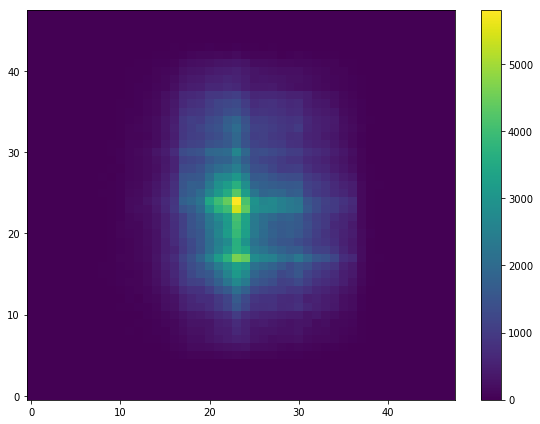

Current= -8.9
Files used: ['CG4B1298.dat', 'CG4B1299.dat', 'CG4B1300.dat', 'CG4B1301.dat', 'CG4B1302.dat', 'CG4B1303.dat', 'CG4B1304.dat', 'CG4B1305.dat', 'CG4B1306.dat', 'CG4B1307.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  881433.2409280179


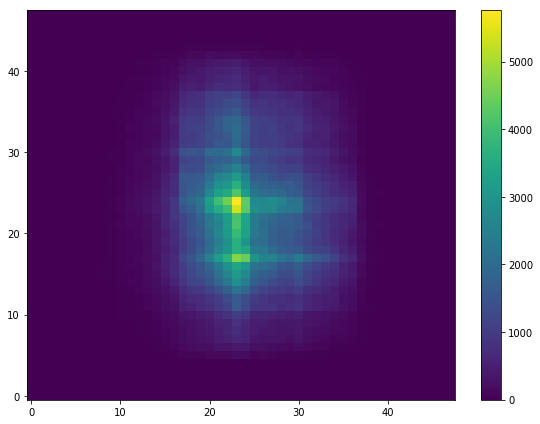

Current= -8.8
Files used: ['CG4B1308.dat', 'CG4B1309.dat', 'CG4B1310.dat', 'CG4B1311.dat', 'CG4B1312.dat', 'CG4B1313.dat', 'CG4B1314.dat', 'CG4B1315.dat', 'CG4B1316.dat', 'CG4B1317.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  874587.0850684119


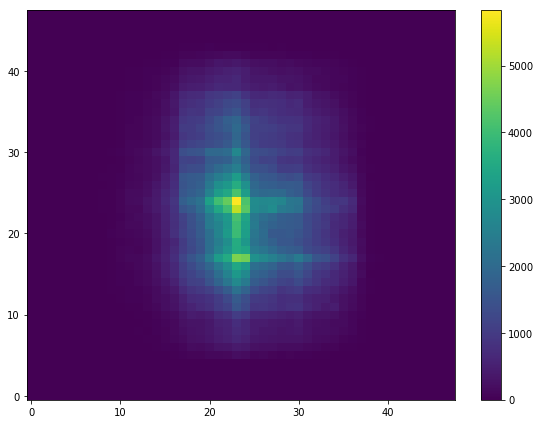

Current= -8.7
Files used: ['CG4B1318.dat', 'CG4B1319.dat', 'CG4B1320.dat', 'CG4B1321.dat', 'CG4B1322.dat', 'CG4B1323.dat', 'CG4B1324.dat', 'CG4B1325.dat', 'CG4B1326.dat', 'CG4B1327.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  859532.2956573472


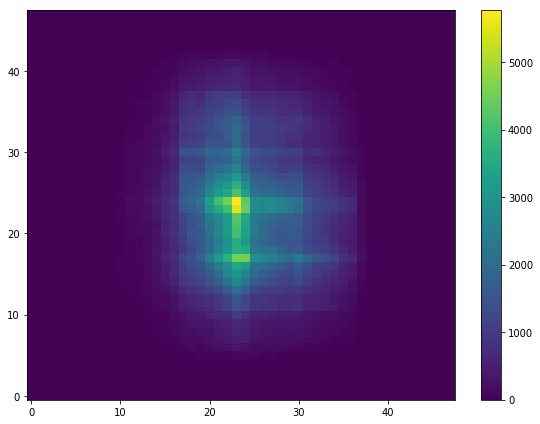

Current= -8.6
Files used: ['CG4B1328.dat', 'CG4B1329.dat', 'CG4B1330.dat', 'CG4B1331.dat', 'CG4B1332.dat', 'CG4B1333.dat', 'CG4B1334.dat', 'CG4B1335.dat', 'CG4B1336.dat', 'CG4B1337.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  877172.1903628793


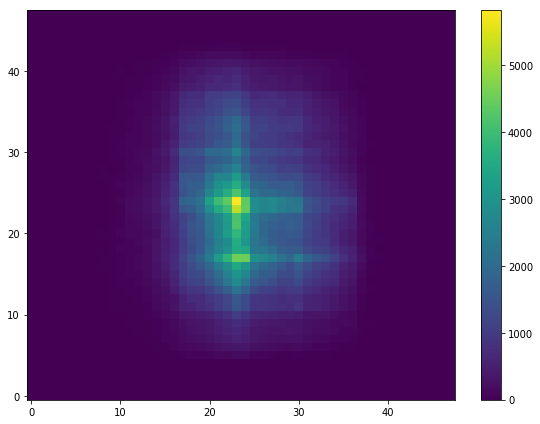

Current= -8.5
Files used: ['CG4B1338.dat', 'CG4B1339.dat', 'CG4B1340.dat', 'CG4B1341.dat', 'CG4B1342.dat', 'CG4B1343.dat', 'CG4B1344.dat', 'CG4B1345.dat', 'CG4B1346.dat', 'CG4B1347.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  879853.640095182


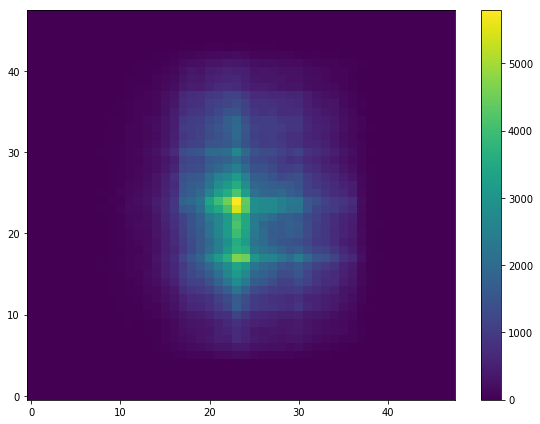

Current= -8.4
Files used: ['CG4B1348.dat', 'CG4B1349.dat', 'CG4B1350.dat', 'CG4B1351.dat', 'CG4B1352.dat', 'CG4B1353.dat', 'CG4B1354.dat', 'CG4B1355.dat', 'CG4B1356.dat', 'CG4B1357.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  860637.9952409272


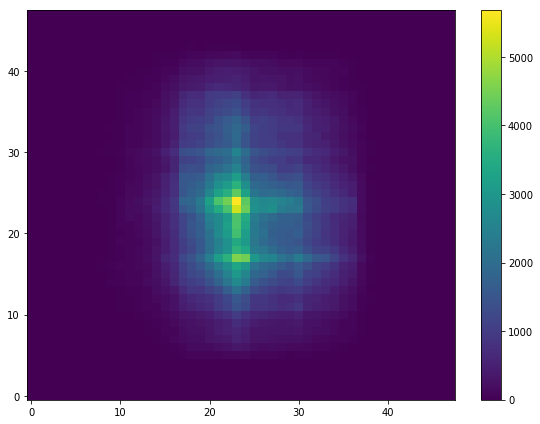

Current= -8.3
Files used: ['CG4B1358.dat', 'CG4B1359.dat', 'CG4B1360.dat', 'CG4B1361.dat', 'CG4B1362.dat', 'CG4B1363.dat', 'CG4B1364.dat', 'CG4B1365.dat', 'CG4B1366.dat', 'CG4B1367.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  870974.3682331934


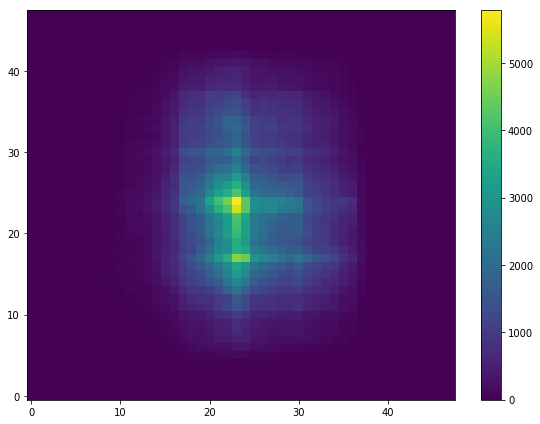

Current= -8.2
Files used: ['CG4B1368.dat', 'CG4B1369.dat', 'CG4B1370.dat', 'CG4B1371.dat', 'CG4B1372.dat', 'CG4B1373.dat', 'CG4B1374.dat', 'CG4B1375.dat', 'CG4B1376.dat', 'CG4B1377.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  884926.8155859609


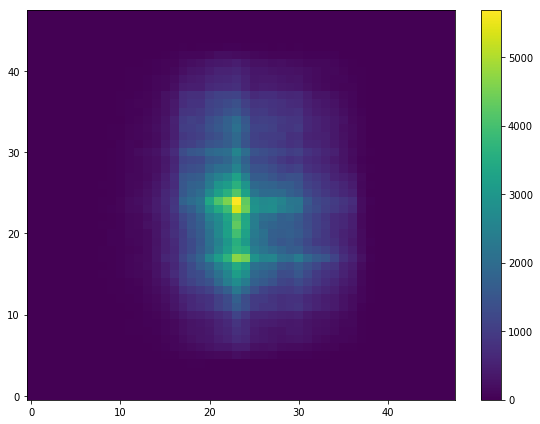

Current= -8.1
Files used: ['CG4B1378.dat', 'CG4B1379.dat', 'CG4B1380.dat', 'CG4B1381.dat', 'CG4B1382.dat', 'CG4B1383.dat', 'CG4B1384.dat', 'CG4B1385.dat', 'CG4B1386.dat', 'CG4B1387.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  800020.2736466397


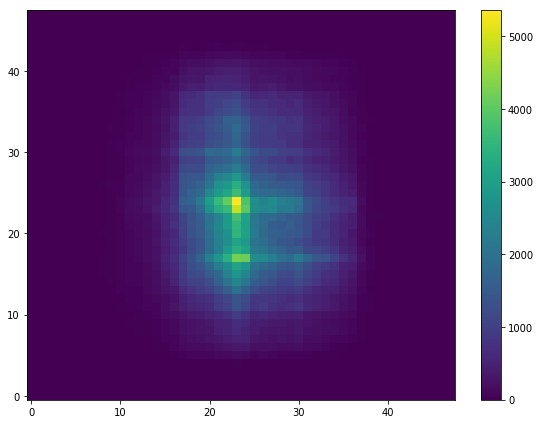


 Peak counts:  884926.8155859609 
 Current:  -8.2 


 Trough counts:  800020.2736466397 
 Current:  -8.1 



In [11]:
#RF off
#b2 scan, b1 = 8.5, nutator1 =-5
zero_counts = []    #add all subscans that are zero counts here

currents = np.arange(-9,-8,.1)
print("Currents used: ", currents, " \n Total=", len(currents), "\n")
high_counts = []
high_totals = []
start = 1288
subscans = 10

for i in range(len(currents)):
    print("Current=", round(currents[i],3))
    if ((start + (subscans - 1) + int(i)*subscans) not in zero_counts):
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans, \
                          print_summed=True, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
    else: 
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans - 1, \
                          print_summed=True, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
        print("Warning: one subscan failed!")
        
Peak_h = max(high_totals)
Trough_h = min(high_totals)
Peak_current_h = np.argmax(high_totals)
Trough_current_h = np.argmin(high_totals)

print("\n Peak counts: ", Peak_h, "\n Current: ", round(currents[Peak_current_h],3), "\n")
print("\n Trough counts: ", Trough_h, "\n Current: ", round(currents[Trough_current_h],3), "\n")


Currents used:  [-9.  -8.9 -8.8 -8.7 -8.6 -8.5 -8.4 -8.3 -8.2 -8.1]  
 Total= 10 

Current= -9.0
Files used: ['CG4B1388.dat', 'CG4B1389.dat', 'CG4B1390.dat', 'CG4B1391.dat', 'CG4B1392.dat', 'CG4B1393.dat', 'CG4B1394.dat', 'CG4B1395.dat', 'CG4B1396.dat', 'CG4B1397.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  95120.12908982733


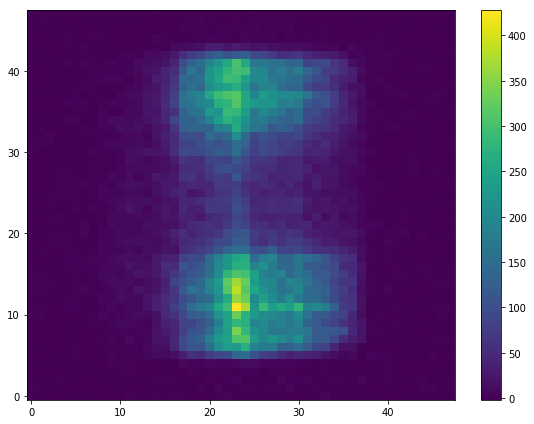

Current= -8.9
Files used: ['CG4B1398.dat', 'CG4B1399.dat', 'CG4B1400.dat', 'CG4B1401.dat', 'CG4B1402.dat', 'CG4B1403.dat', 'CG4B1404.dat', 'CG4B1405.dat', 'CG4B1406.dat', 'CG4B1407.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  86053.6115407495


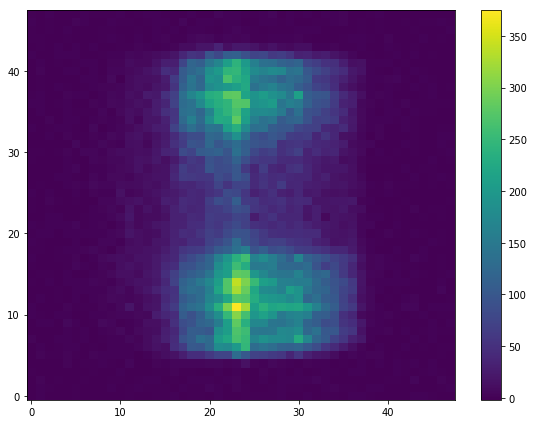

Current= -8.8
Files used: ['CG4B1408.dat', 'CG4B1409.dat', 'CG4B1410.dat', 'CG4B1411.dat', 'CG4B1412.dat', 'CG4B1413.dat', 'CG4B1414.dat', 'CG4B1415.dat', 'CG4B1416.dat', 'CG4B1417.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  72386.70791195717


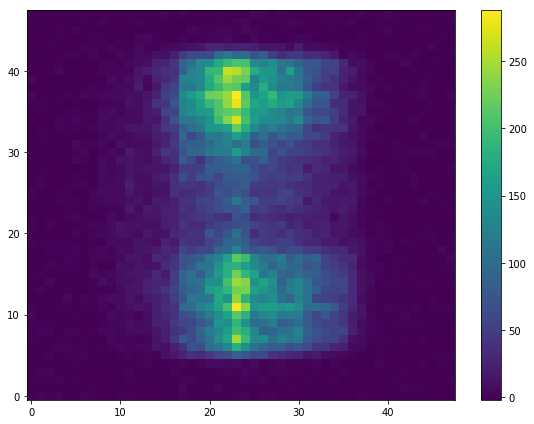

Current= -8.7
Files used: ['CG4B1418.dat', 'CG4B1419.dat', 'CG4B1420.dat', 'CG4B1421.dat', 'CG4B1422.dat', 'CG4B1423.dat', 'CG4B1424.dat', 'CG4B1425.dat', 'CG4B1426.dat', 'CG4B1427.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  92315.96252230815


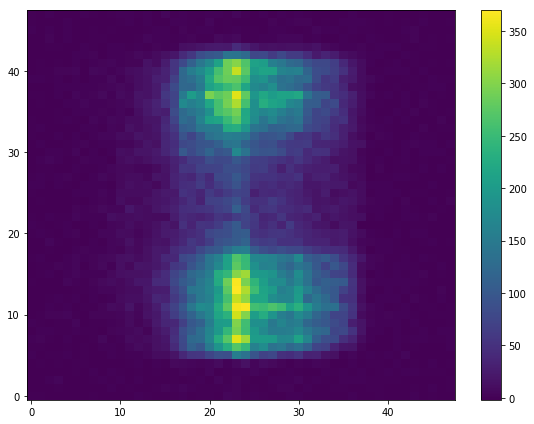

Current= -8.6
Files used: ['CG4B1428.dat', 'CG4B1429.dat', 'CG4B1430.dat', 'CG4B1431.dat', 'CG4B1432.dat', 'CG4B1433.dat', 'CG4B1434.dat', 'CG4B1435.dat', 'CG4B1436.dat', 'CG4B1437.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  90589.2058298632


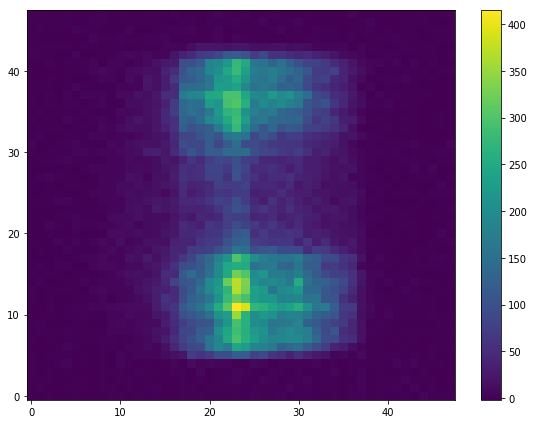

Current= -8.5
Files used: ['CG4B1438.dat', 'CG4B1439.dat', 'CG4B1440.dat', 'CG4B1441.dat', 'CG4B1442.dat', 'CG4B1443.dat', 'CG4B1444.dat', 'CG4B1445.dat', 'CG4B1446.dat', 'CG4B1447.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  71655.96252230811


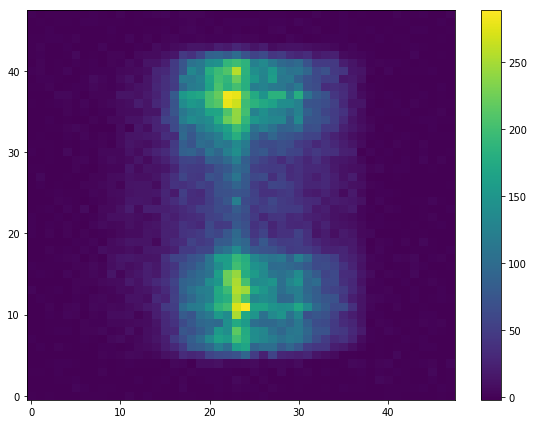

Current= -8.4
Files used: ['CG4B1448.dat', 'CG4B1449.dat', 'CG4B1450.dat', 'CG4B1451.dat', 'CG4B1452.dat', 'CG4B1453.dat', 'CG4B1454.dat', 'CG4B1455.dat', 'CG4B1456.dat', 'CG4B1457.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  87163.71683521711


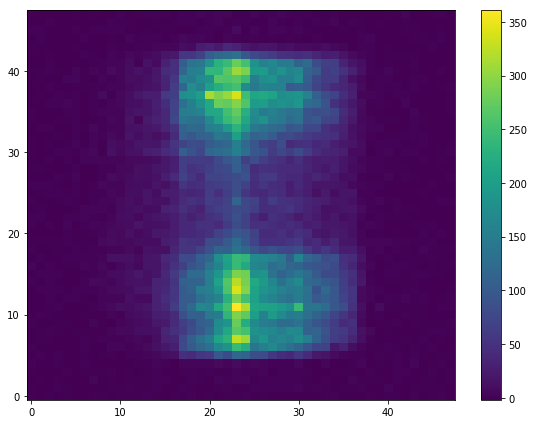

Current= -8.3
Files used: ['CG4B1458.dat', 'CG4B1459.dat', 'CG4B1460.dat', 'CG4B1461.dat', 'CG4B1462.dat', 'CG4B1463.dat', 'CG4B1464.dat', 'CG4B1465.dat', 'CG4B1466.dat', 'CG4B1467.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  96601.85068411646


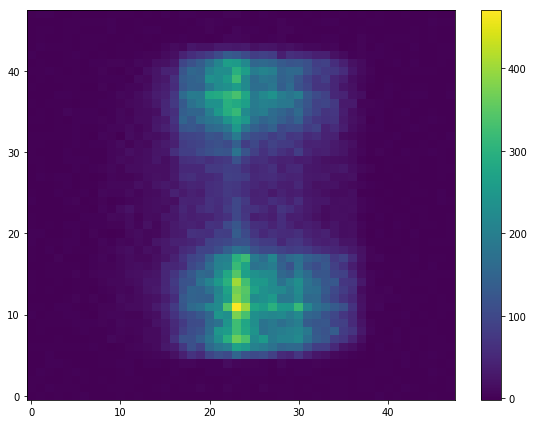

Current= -8.2
Files used: ['CG4B1468.dat', 'CG4B1469.dat', 'CG4B1470.dat', 'CG4B1471.dat', 'CG4B1472.dat', 'CG4B1473.dat', 'CG4B1474.dat', 'CG4B1475.dat', 'CG4B1476.dat', 'CG4B1477.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  74981.73646638899


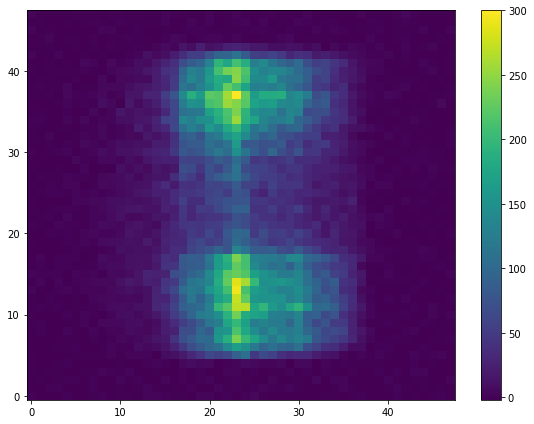

Current= -8.1
Files used: ['CG4B1478.dat', 'CG4B1479.dat', 'CG4B1480.dat', 'CG4B1481.dat', 'CG4B1482.dat', 'CG4B1483.dat', 'CG4B1484.dat', 'CG4B1485.dat', 'CG4B1486.dat', 'CG4B1487.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  144433.56989886993


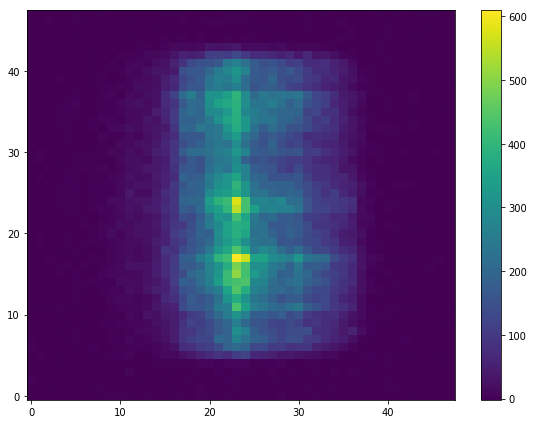


 Peak counts:  144433.56989886993 
 Current:  -8.1 


 Trough counts:  71655.96252230811 
 Current:  -8.5 



In [12]:
#RF off
#b2 scan, b1 = 8.5, nutator1 =5
zero_counts = []    #add all subscans that are zero counts here

currents = np.arange(-9,-8,.1)
print("Currents used: ", currents, " \n Total=", len(currents), "\n")
high_counts = []
high_totals = []
start = 1388
subscans = 10

for i in range(len(currents)):
    print("Current=", round(currents[i],3))
    if ((start + (subscans - 1) + int(i)*subscans) not in zero_counts):
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans, \
                          print_summed=True, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
    else: 
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans - 1, \
                          print_summed=True, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
        print("Warning: one subscan failed!")
        
Peak_h = max(high_totals)
Trough_h = min(high_totals)
Peak_current_h = np.argmax(high_totals)
Trough_current_h = np.argmin(high_totals)

print("\n Peak counts: ", Peak_h, "\n Current: ", round(currents[Peak_current_h],3), "\n")
print("\n Trough counts: ", Trough_h, "\n Current: ", round(currents[Trough_current_h],3), "\n")


Currents used:  [9.  8.9 8.8 8.7 8.6 8.5 8.4 8.3 8.2 8.1]  
 Total= 10 

Current= 9.0
Files used: ['CG4B1488.dat', 'CG4B1489.dat', 'CG4B1490.dat', 'CG4B1491.dat', 'CG4B1492.dat', 'CG4B1493.dat', 'CG4B1494.dat', 'CG4B1495.dat', 'CG4B1496.dat', 'CG4B1497.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  885934.3747769184


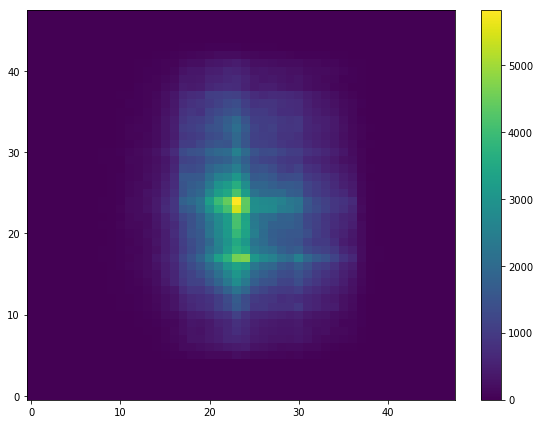

Current= 8.9
Files used: ['CG4B1498.dat', 'CG4B1499.dat', 'CG4B1500.dat', 'CG4B1501.dat', 'CG4B1502.dat', 'CG4B1503.dat', 'CG4B1504.dat', 'CG4B1505.dat', 'CG4B1506.dat', 'CG4B1507.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  898596.3004164188


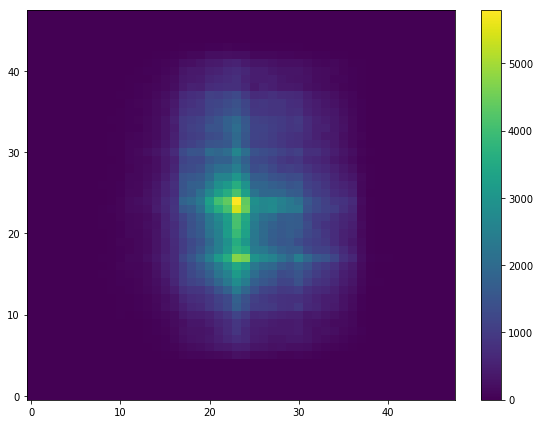

Current= 8.8
Files used: ['CG4B1508.dat', 'CG4B1509.dat', 'CG4B1510.dat', 'CG4B1511.dat', 'CG4B1512.dat', 'CG4B1513.dat', 'CG4B1514.dat', 'CG4B1515.dat', 'CG4B1516.dat', 'CG4B1517.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  903336.776323618


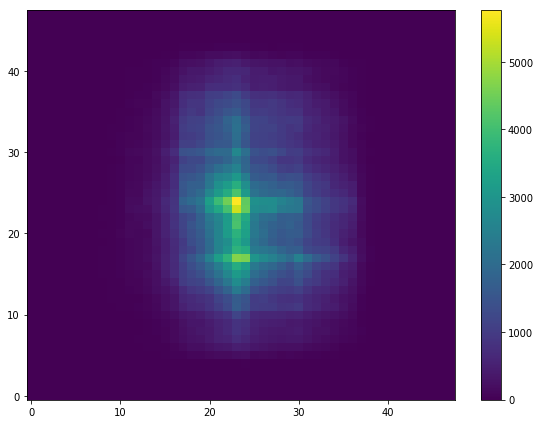

Current= 8.7
Files used: ['CG4B1518.dat', 'CG4B1519.dat', 'CG4B1520.dat', 'CG4B1521.dat', 'CG4B1522.dat', 'CG4B1523.dat', 'CG4B1524.dat', 'CG4B1525.dat', 'CG4B1526.dat', 'CG4B1527.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  885535.3200475916


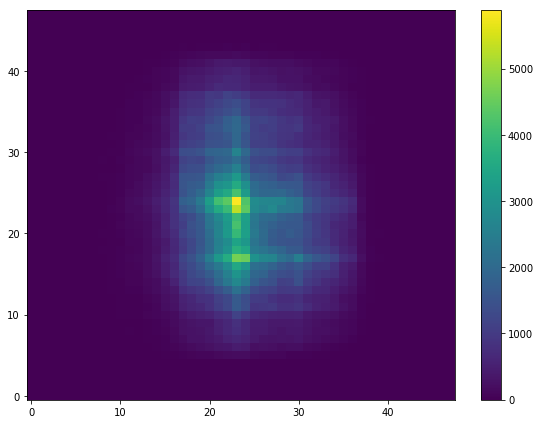

Current= 8.6
Files used: ['CG4B1528.dat', 'CG4B1529.dat', 'CG4B1530.dat', 'CG4B1531.dat', 'CG4B1532.dat', 'CG4B1533.dat', 'CG4B1534.dat', 'CG4B1535.dat', 'CG4B1536.dat', 'CG4B1537.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  894203.9256395004


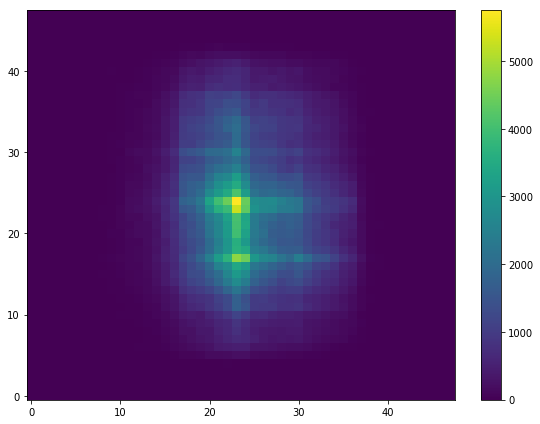

Current= 8.5
Files used: ['CG4B1538.dat', 'CG4B1539.dat', 'CG4B1540.dat', 'CG4B1541.dat', 'CG4B1542.dat', 'CG4B1543.dat', 'CG4B1544.dat', 'CG4B1545.dat', 'CG4B1546.dat', 'CG4B1547.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  908863.102914931


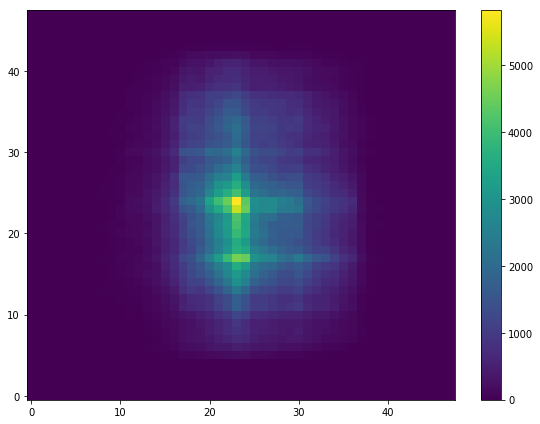

Current= 8.4
Files used: ['CG4B1548.dat', 'CG4B1549.dat', 'CG4B1550.dat', 'CG4B1551.dat', 'CG4B1552.dat', 'CG4B1553.dat', 'CG4B1554.dat', 'CG4B1555.dat', 'CG4B1556.dat', 'CG4B1557.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  890169.0963712061


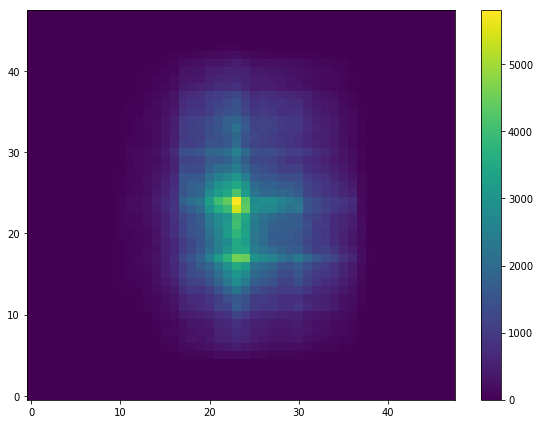

Current= 8.3
Files used: ['CG4B1558.dat', 'CG4B1559.dat', 'CG4B1560.dat', 'CG4B1561.dat', 'CG4B1562.dat', 'CG4B1563.dat', 'CG4B1564.dat', 'CG4B1565.dat', 'CG4B1566.dat', 'CG4B1567.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  887422.214753124


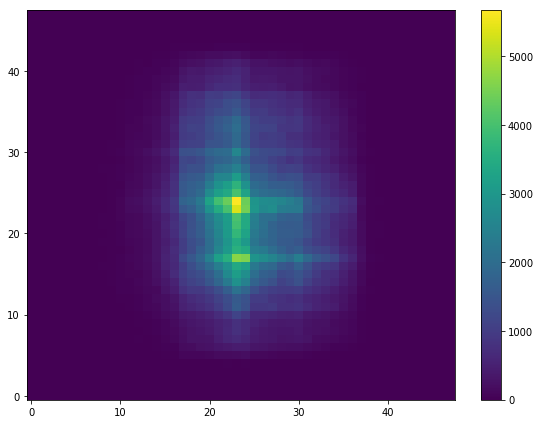

Current= 8.2
Files used: ['CG4B1568.dat', 'CG4B1569.dat', 'CG4B1570.dat', 'CG4B1571.dat', 'CG4B1572.dat', 'CG4B1573.dat', 'CG4B1574.dat', 'CG4B1575.dat', 'CG4B1576.dat', 'CG4B1577.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  908091.8792385492


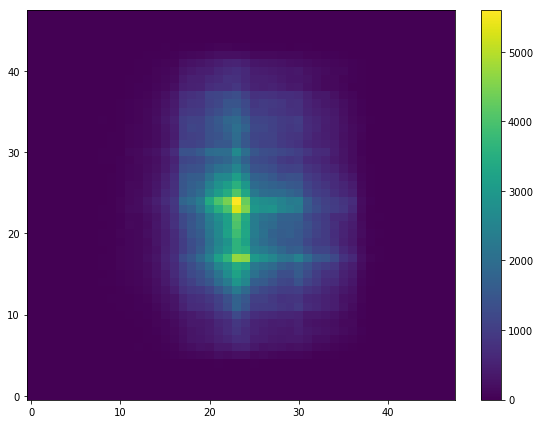

Current= 8.1
Files used: ['CG4B1578.dat', 'CG4B1579.dat', 'CG4B1580.dat', 'CG4B1581.dat', 'CG4B1582.dat', 'CG4B1583.dat', 'CG4B1584.dat', 'CG4B1585.dat', 'CG4B1586.dat', 'CG4B1587.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  834437.0237953607


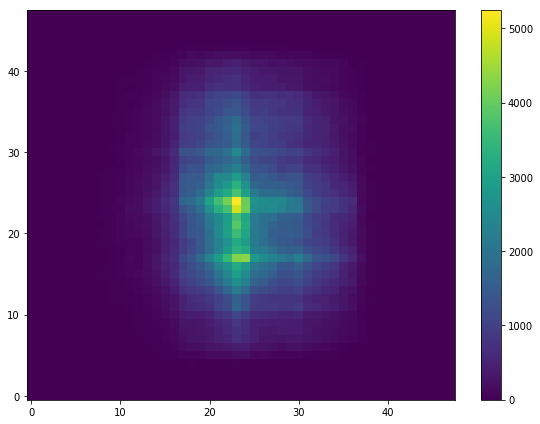


 Peak counts:  908863.102914931 
 Current:  8.5 


 Trough counts:  834437.0237953607 
 Current:  8.1 



In [13]:
#RF off
#b1 scan, b2 = -8.5, nutator1 =-5
zero_counts = []    #add all subscans that are zero counts here

currents = np.arange(9,8,-.1)
print("Currents used: ", currents, " \n Total=", len(currents), "\n")
high_counts = []
high_totals = []
start = 1488
subscans = 10

for i in range(len(currents)):
    print("Current=", round(currents[i],3))
    if ((start + (subscans - 1) + int(i)*subscans) not in zero_counts):
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans, \
                          print_summed=True, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
    else: 
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans - 1, \
                          print_summed=True, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
        print("Warning: one subscan failed!")
        
Peak_h = max(high_totals)
Trough_h = min(high_totals)
Peak_current_h = np.argmax(high_totals)
Trough_current_h = np.argmin(high_totals)

print("\n Peak counts: ", Peak_h, "\n Current: ", round(currents[Peak_current_h],3), "\n")
print("\n Trough counts: ", Trough_h, "\n Current: ", round(currents[Trough_current_h],3), "\n")


Currents used:  [9.  8.9 8.8 8.7 8.6 8.5 8.4 8.3 8.2 8.1]  
 Total= 10 

Current= 9.0
Files used: ['CG4B1588.dat', 'CG4B1589.dat', 'CG4B1590.dat', 'CG4B1591.dat', 'CG4B1592.dat', 'CG4B1593.dat', 'CG4B1594.dat', 'CG4B1595.dat', 'CG4B1596.dat', 'CG4B1597.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  68725.86555621657


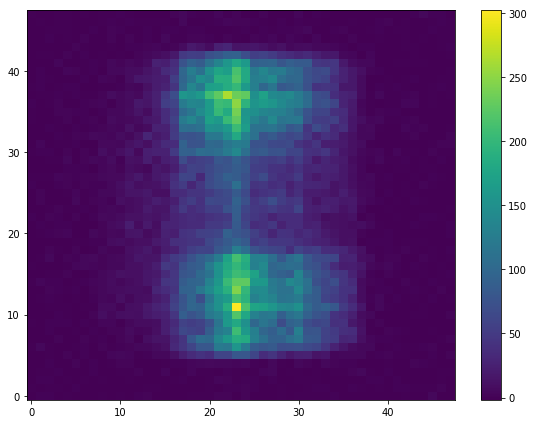

Current= 8.9
Files used: ['CG4B1598.dat', 'CG4B1599.dat', 'CG4B1600.dat', 'CG4B1601.dat', 'CG4B1602.dat', 'CG4B1603.dat', 'CG4B1604.dat', 'CG4B1605.dat', 'CG4B1606.dat', 'CG4B1607.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  60079.744794765014


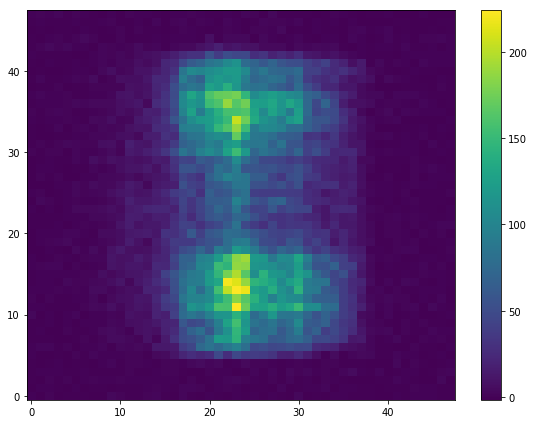

Current= 8.8
Files used: ['CG4B1608.dat', 'CG4B1609.dat', 'CG4B1610.dat', 'CG4B1611.dat', 'CG4B1612.dat', 'CG4B1613.dat', 'CG4B1614.dat', 'CG4B1615.dat', 'CG4B1616.dat', 'CG4B1617.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  49293.29744199888


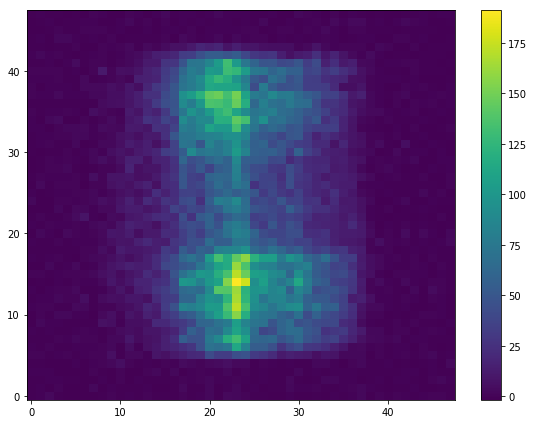

Current= 8.7
Files used: ['CG4B1618.dat', 'CG4B1619.dat', 'CG4B1620.dat', 'CG4B1621.dat', 'CG4B1622.dat', 'CG4B1623.dat', 'CG4B1624.dat', 'CG4B1625.dat', 'CG4B1626.dat', 'CG4B1627.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  66158.87209994049


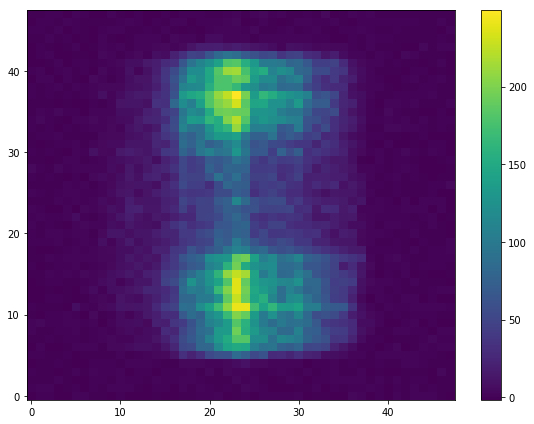

Current= 8.6
Files used: ['CG4B1628.dat', 'CG4B1629.dat', 'CG4B1630.dat', 'CG4B1631.dat', 'CG4B1632.dat', 'CG4B1633.dat', 'CG4B1634.dat', 'CG4B1635.dat', 'CG4B1636.dat', 'CG4B1637.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  65022.87447947643


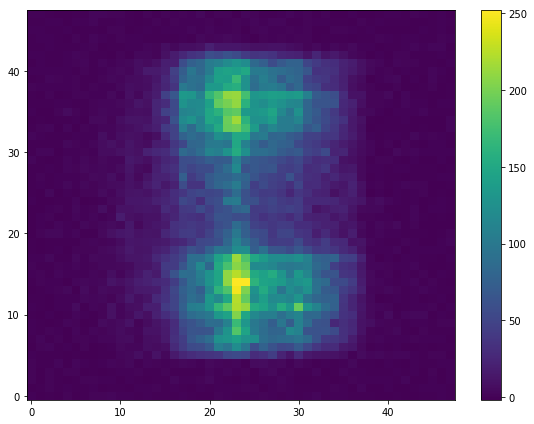

Current= 8.5
Files used: ['CG4B1638.dat', 'CG4B1639.dat', 'CG4B1640.dat', 'CG4B1641.dat', 'CG4B1642.dat', 'CG4B1643.dat', 'CG4B1644.dat', 'CG4B1645.dat', 'CG4B1646.dat', 'CG4B1647.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  48588.15050565131


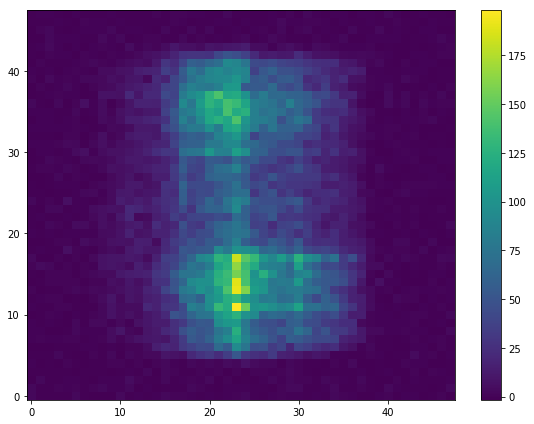

Current= 8.4
Files used: ['CG4B1648.dat', 'CG4B1649.dat', 'CG4B1650.dat', 'CG4B1651.dat', 'CG4B1652.dat', 'CG4B1653.dat', 'CG4B1654.dat', 'CG4B1655.dat', 'CG4B1656.dat', 'CG4B1657.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  60309.21415823915


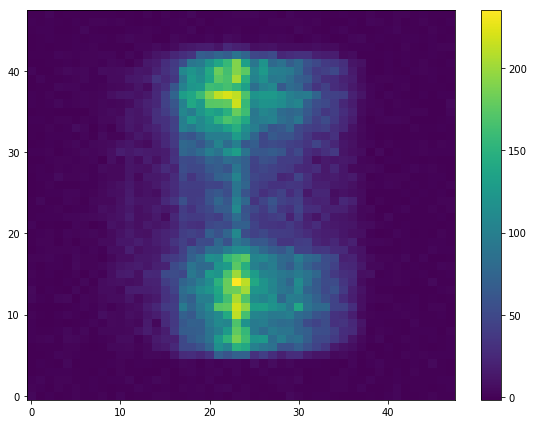

Current= 8.3
Files used: ['CG4B1658.dat', 'CG4B1659.dat', 'CG4B1660.dat', 'CG4B1661.dat', 'CG4B1662.dat', 'CG4B1663.dat', 'CG4B1664.dat', 'CG4B1665.dat', 'CG4B1666.dat', 'CG4B1667.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  70730.07376561576


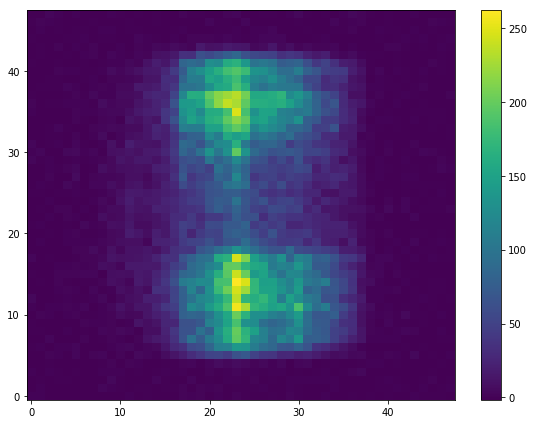

Current= 8.2
Files used: ['CG4B1668.dat', 'CG4B1669.dat', 'CG4B1670.dat', 'CG4B1671.dat', 'CG4B1672.dat', 'CG4B1673.dat', 'CG4B1674.dat', 'CG4B1675.dat', 'CG4B1676.dat', 'CG4B1677.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  52505.709696609156


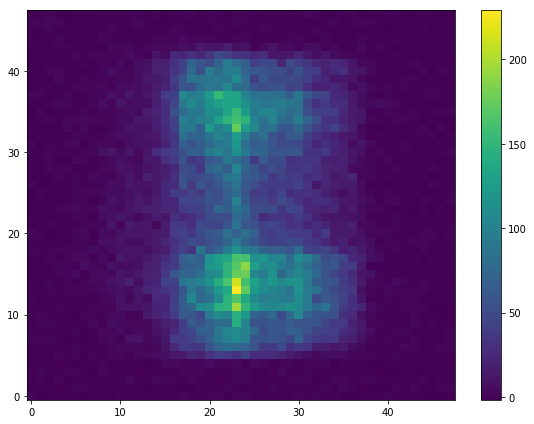

Current= 8.1
Files used: ['CG4B1678.dat', 'CG4B1679.dat', 'CG4B1680.dat', 'CG4B1681.dat', 'CG4B1682.dat', 'CG4B1683.dat', 'CG4B1684.dat', 'CG4B1685.dat', 'CG4B1686.dat', 'CG4B1687.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  120890.26472337879


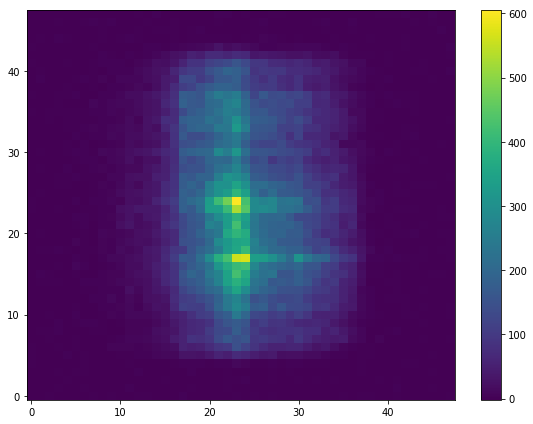


 Peak counts:  120890.26472337879 
 Current:  8.1 


 Trough counts:  48588.15050565131 
 Current:  8.5 



In [14]:
#RF off
#b1 scan, b2 = -8.5, nutator1 =5
zero_counts = []    #add all subscans that are zero counts here

currents = np.arange(9,8,-.1)
print("Currents used: ", currents, " \n Total=", len(currents), "\n")
high_counts = []
high_totals = []
start = 1588
subscans = 10

for i in range(len(currents)):
    print("Current=", round(currents[i],3))
    if ((start + (subscans - 1) + int(i)*subscans) not in zero_counts):
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans, \
                          print_summed=True, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
    else: 
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans - 1, \
                          print_summed=True, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
        print("Warning: one subscan failed!")
        
Peak_h = max(high_totals)
Trough_h = min(high_totals)
Peak_current_h = np.argmax(high_totals)
Trough_current_h = np.argmin(high_totals)

print("\n Peak counts: ", Peak_h, "\n Current: ", round(currents[Peak_current_h],3), "\n")
print("\n Trough counts: ", Trough_h, "\n Current: ", round(currents[Trough_current_h],3), "\n")


In [43]:
#RF off
#b2 scan, b1 = 15, nutator1 =-5
zero_counts = []    #add all subscans that are zero counts here

currents = np.arange(-15.5,-14.5,.1)
print("Currents used: ", currents, " \n Total=", len(currents), "\n")
high_counts = []
high_totals = []
start = 1688
subscans = 10

for i in range(len(currents)):
    print("Current=", round(currents[i],3))
    if ((start + (subscans - 1) + int(i)*subscans) not in zero_counts):
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans, \
                          print_summed=False, print_fnames=False)
        high_counts.append(run[0])
        high_totals.append(run[1])
    else: 
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans - 1, \
                          print_summed=False, print_fnames=False)
        high_counts.append(run[0])
        high_totals.append(run[1])
        print("Warning: one subscan failed!")
        
Peak_h = max(high_totals)
Trough_h = min(high_totals)
Peak_current_h = np.argmax(high_totals)
Trough_current_h = np.argmin(high_totals)

print("\n Peak counts: ", Peak_h, "\n Current: ", round(currents[Peak_current_h],3), "\n")
print("\n Trough counts: ", Trough_h, "\n Current: ", round(currents[Trough_current_h],3), "\n")


Currents used:  [-15.5 -15.4 -15.3 -15.2 -15.1 -15.  -14.9 -14.8 -14.7 -14.6]  
 Total= 10 

Current= -15.5
Current= -15.4
Current= -15.3
Current= -15.2
Current= -15.1
Current= -15.0
Current= -14.9
Current= -14.8
Current= -14.7
Current= -14.6

 Peak counts:  893518.4866151096 
 Current:  -14.9 


 Trough counts:  825169.9952409272 
 Current:  -14.6 



890208.6391698061


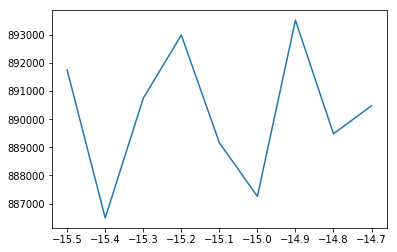

In [44]:
fig = plt.plot(currents[:-1], high_totals[:-1])
high_av = np.average(high_totals[:-1])
print(high_av)

In [45]:
#RF off
#b2 scan, b1 = 15, nutator1 = 5
zero_counts = []    #add all subscans that are zero counts here

currents = np.arange(-15.5,-14.5,.1)
print("Currents used: ", currents, " \n Total=", len(currents), "\n")
high_counts = []
high_totals = []
start = 1788
subscans = 10

for i in range(len(currents)):
    print("Current=", round(currents[i],3))
    if ((start + (subscans - 1) + int(i)*subscans) not in zero_counts):
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans, \
                          print_summed=False, print_fnames=False)
        high_counts.append(run[0])
        high_totals.append(run[1])
    else: 
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans - 1, \
                          print_summed=False, print_fnames=False)
        high_counts.append(run[0])
        high_totals.append(run[1])
        print("Warning: one subscan failed!")
        
Peak_h = max(high_totals)
Trough_h = min(high_totals)
Peak_current_h = np.argmax(high_totals)
Trough_current_h = np.argmin(high_totals)

print("\n Peak counts: ", Peak_h, "\n Current: ", round(currents[Peak_current_h],3), "\n")
print("\n Trough counts: ", Trough_h, "\n Current: ", round(currents[Trough_current_h],3), "\n")


Currents used:  [-15.5 -15.4 -15.3 -15.2 -15.1 -15.  -14.9 -14.8 -14.7 -14.6]  
 Total= 10 

Current= -15.5
Current= -15.4
Current= -15.3
Current= -15.2
Current= -15.1
Current= -15.0
Current= -14.9
Current= -14.8
Current= -14.7
Current= -14.6

 Peak counts:  133076.35276621053 
 Current:  -14.6 


 Trough counts:  61253.455681142164 
 Current:  -15.5 



65317.02703417274
13.629044057747215


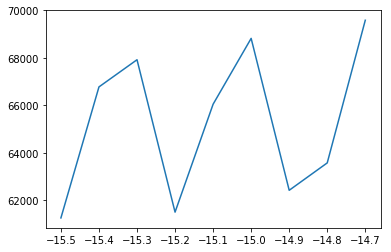

In [46]:
fig = plt.plot(currents[:-1], high_totals[:-1])
low_av = np.average(high_totals[:-1])
print(low_av)
print(high_av/low_av)

Currents used:  [15.5 15.4 15.3 15.2 15.1 15.  14.9 14.8 14.7 14.6]  
 Total= 10 

Current= 15.5
Files used: ['CG4B1888.dat', 'CG4B1889.dat', 'CG4B1890.dat', 'CG4B1891.dat', 'CG4B1892.dat', 'CG4B1893.dat', 'CG4B1894.dat', 'CG4B1895.dat', 'CG4B1896.dat', 'CG4B1897.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  890827.6882807851


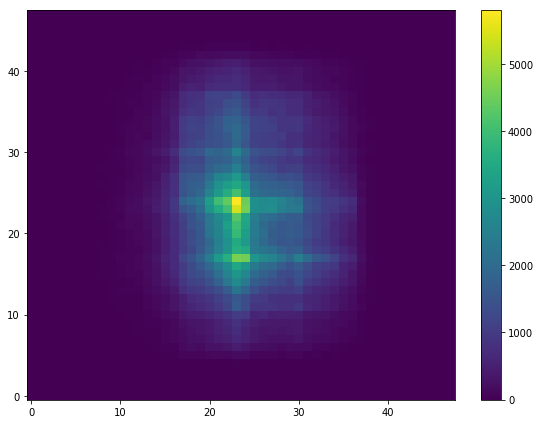

Current= 15.4
Files used: ['CG4B1898.dat', 'CG4B1899.dat', 'CG4B1900.dat', 'CG4B1901.dat', 'CG4B1902.dat', 'CG4B1903.dat', 'CG4B1904.dat', 'CG4B1905.dat', 'CG4B1906.dat', 'CG4B1907.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  876289.8703152877


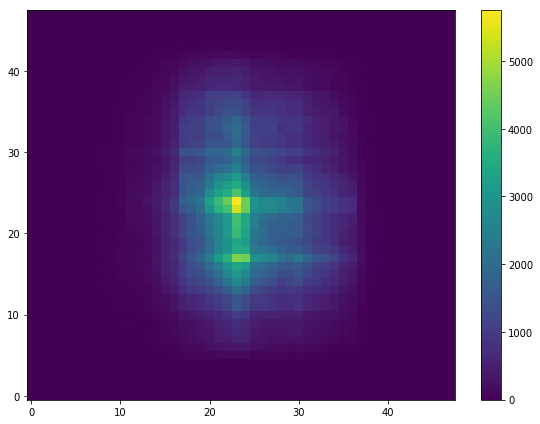

Current= 15.3
Files used: ['CG4B1908.dat', 'CG4B1909.dat', 'CG4B1910.dat', 'CG4B1911.dat', 'CG4B1912.dat', 'CG4B1913.dat', 'CG4B1914.dat', 'CG4B1915.dat', 'CG4B1916.dat', 'CG4B1917.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  886420.1052944674


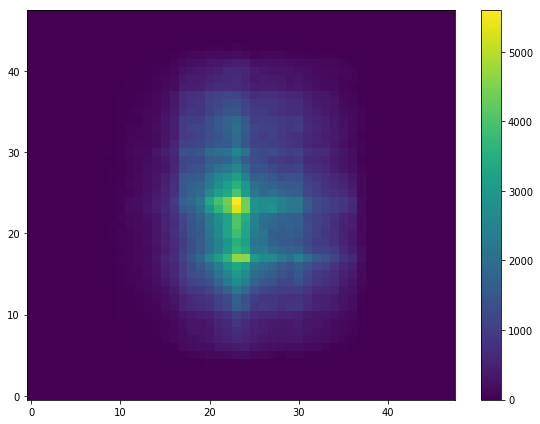

Current= 15.2
Files used: ['CG4B1918.dat', 'CG4B1919.dat', 'CG4B1920.dat', 'CG4B1921.dat', 'CG4B1922.dat', 'CG4B1923.dat', 'CG4B1924.dat', 'CG4B1925.dat', 'CG4B1926.dat', 'CG4B1927.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  892109.0672218922


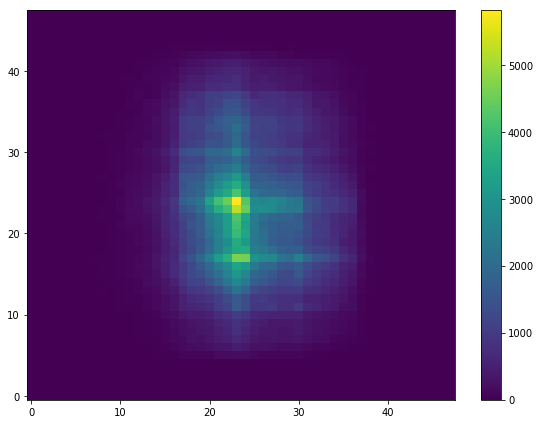

Current= 15.1
Files used: ['CG4B1928.dat', 'CG4B1929.dat', 'CG4B1930.dat', 'CG4B1931.dat', 'CG4B1932.dat', 'CG4B1933.dat', 'CG4B1934.dat', 'CG4B1935.dat', 'CG4B1936.dat', 'CG4B1937.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  875488.78584176


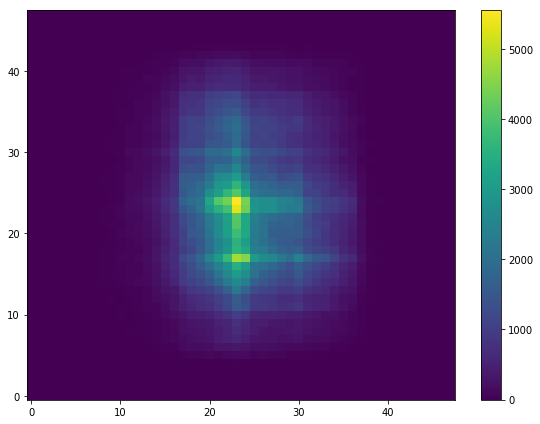

Current= 15.0
Files used: ['CG4B1938.dat', 'CG4B1939.dat', 'CG4B1940.dat', 'CG4B1941.dat', 'CG4B1942.dat', 'CG4B1943.dat', 'CG4B1944.dat', 'CG4B1945.dat', 'CG4B1946.dat', 'CG4B1947.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  882987.7882212964


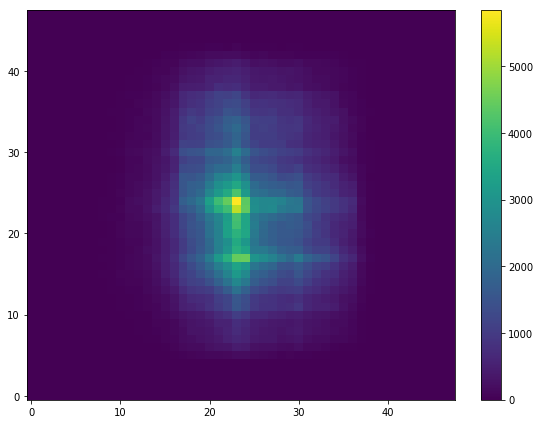

Current= 14.9
Files used: ['CG4B1948.dat', 'CG4B1949.dat', 'CG4B1950.dat', 'CG4B1951.dat', 'CG4B1952.dat', 'CG4B1953.dat', 'CG4B1954.dat', 'CG4B1955.dat', 'CG4B1956.dat', 'CG4B1957.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  894677.0820939915


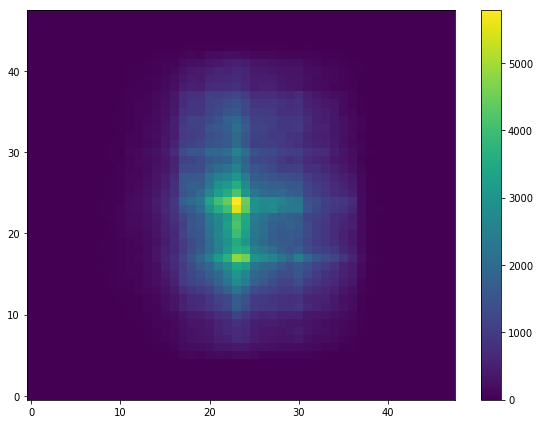

Current= 14.8
Files used: ['CG4B1958.dat', 'CG4B1959.dat', 'CG4B1960.dat', 'CG4B1961.dat', 'CG4B1962.dat', 'CG4B1963.dat', 'CG4B1964.dat', 'CG4B1965.dat', 'CG4B1966.dat', 'CG4B1967.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  881139.948245092


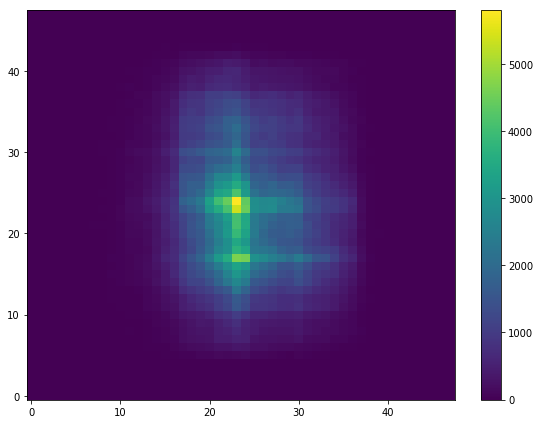

Current= 14.7
Files used: ['CG4B1968.dat', 'CG4B1969.dat', 'CG4B1970.dat', 'CG4B1971.dat', 'CG4B1972.dat', 'CG4B1973.dat', 'CG4B1974.dat', 'CG4B1975.dat', 'CG4B1976.dat', 'CG4B1977.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  876113.860797144


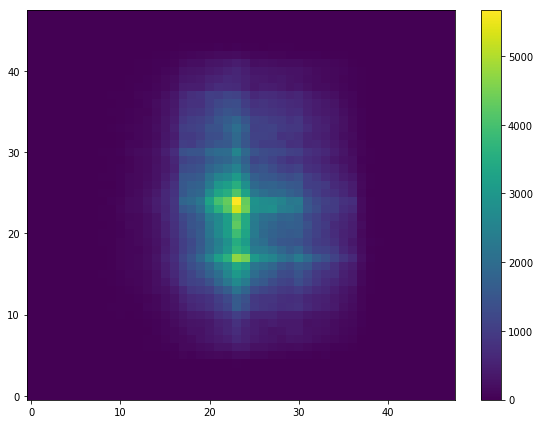

Current= 14.6
Files used: ['CG4B1978.dat', 'CG4B1979.dat', 'CG4B1980.dat', 'CG4B1981.dat', 'CG4B1982.dat', 'CG4B1983.dat', 'CG4B1984.dat', 'CG4B1985.dat', 'CG4B1986.dat', 'CG4B1987.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  823955.1832242708


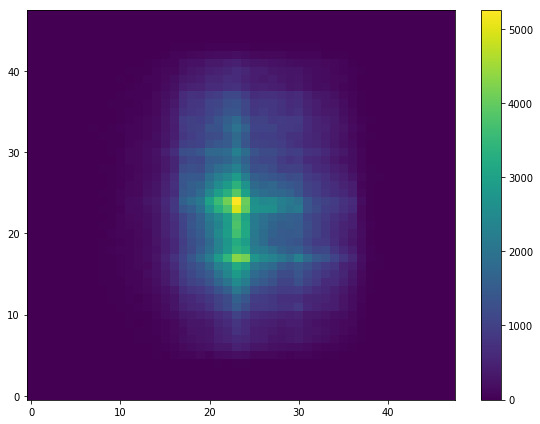


 Peak counts:  894677.0820939915 
 Current:  14.9 


 Trough counts:  823955.1832242708 
 Current:  14.6 



In [17]:
#RF off
#b1 scan, b2 = -15, nutator1 =-5
zero_counts = []    #add all subscans that are zero counts here

currents = np.arange(15.5,14.5,-.1)
print("Currents used: ", currents, " \n Total=", len(currents), "\n")
high_counts = []
high_totals = []
start = 1888
subscans = 10

for i in range(len(currents)):
    print("Current=", round(currents[i],3))
    if ((start + (subscans - 1) + int(i)*subscans) not in zero_counts):
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans, \
                          print_summed=True, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
    else: 
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans - 1, \
                          print_summed=True, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
        print("Warning: one subscan failed!")
        
Peak_h = max(high_totals)
Trough_h = min(high_totals)
Peak_current_h = np.argmax(high_totals)
Trough_current_h = np.argmin(high_totals)

print("\n Peak counts: ", Peak_h, "\n Current: ", round(currents[Peak_current_h],3), "\n")
print("\n Trough counts: ", Trough_h, "\n Current: ", round(currents[Trough_current_h],3), "\n")


Currents used:  [15.5 15.4 15.3 15.2 15.1 15.  14.9 14.8 14.7 14.6]  
 Total= 10 

Current= 15.5
Files used: ['CG4B1988.dat', 'CG4B1989.dat', 'CG4B1990.dat', 'CG4B1991.dat', 'CG4B1992.dat', 'CG4B1993.dat', 'CG4B1994.dat', 'CG4B1995.dat', 'CG4B1996.dat', 'CG4B1997.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  70908.64544913743


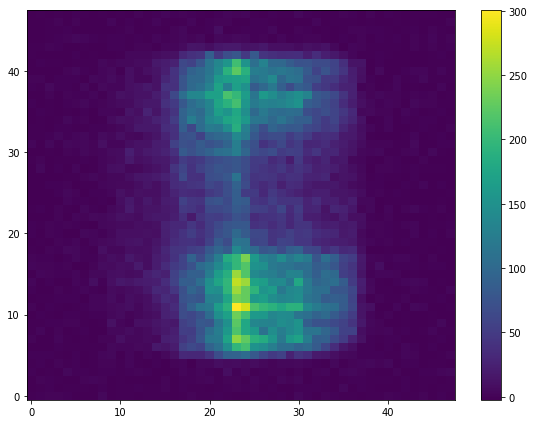

Current= 15.4
Files used: ['CG4B1998.dat', 'CG4B1999.dat', 'CG4B2000.dat', 'CG4B2001.dat', 'CG4B2002.dat', 'CG4B2003.dat', 'CG4B2004.dat', 'CG4B2005.dat', 'CG4B2006.dat', 'CG4B2007.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  79918.94824509224


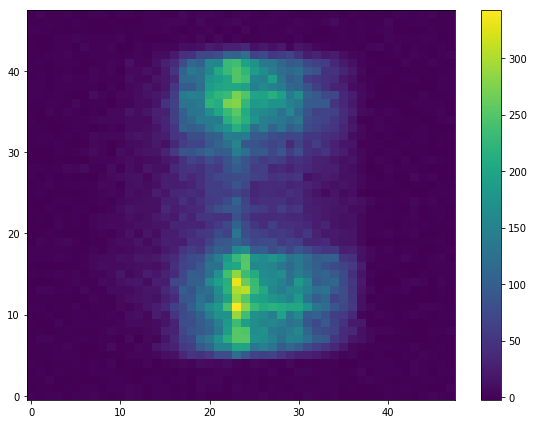

Current= 15.3
Files used: ['CG4B2008.dat', 'CG4B2009.dat', 'CG4B2010.dat', 'CG4B2011.dat', 'CG4B2012.dat', 'CG4B2013.dat', 'CG4B2014.dat', 'CG4B2015.dat', 'CG4B2016.dat', 'CG4B2017.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  67152.2266508031


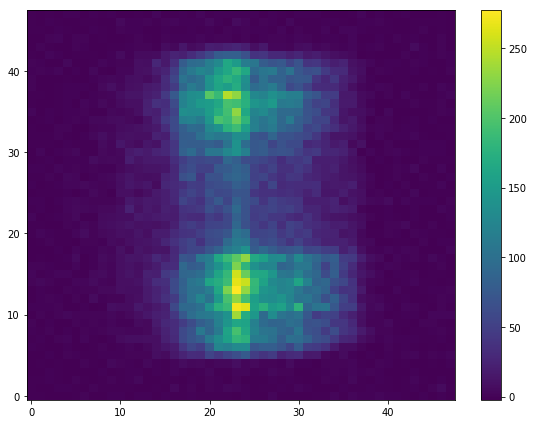

Current= 15.2
Files used: ['CG4B2018.dat', 'CG4B2019.dat', 'CG4B2020.dat', 'CG4B2021.dat', 'CG4B2022.dat', 'CG4B2023.dat', 'CG4B2024.dat', 'CG4B2025.dat', 'CG4B2026.dat', 'CG4B2027.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  67160.10826888747


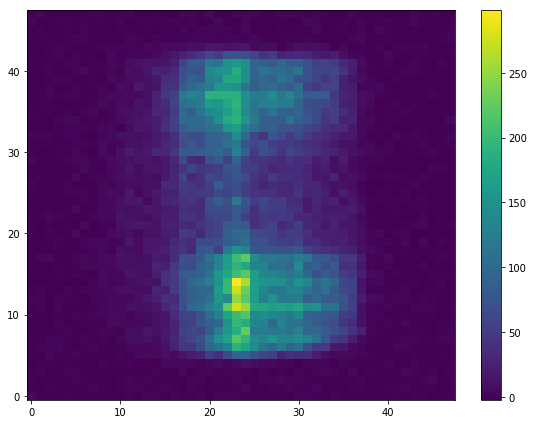

Current= 15.1
Files used: ['CG4B2028.dat', 'CG4B2029.dat', 'CG4B2030.dat', 'CG4B2031.dat', 'CG4B2032.dat', 'CG4B2033.dat', 'CG4B2034.dat', 'CG4B2035.dat', 'CG4B2036.dat', 'CG4B2037.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  79950.01189767981


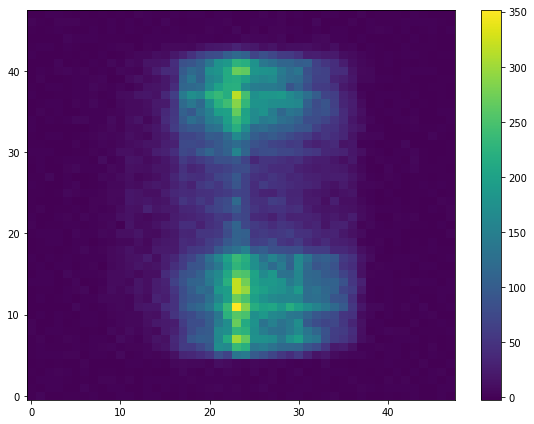

Current= 15.0
Files used: ['CG4B2038.dat', 'CG4B2039.dat', 'CG4B2040.dat', 'CG4B2041.dat', 'CG4B2042.dat', 'CG4B2043.dat', 'CG4B2044.dat', 'CG4B2045.dat', 'CG4B2046.dat', 'CG4B2047.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  70287.63890541346


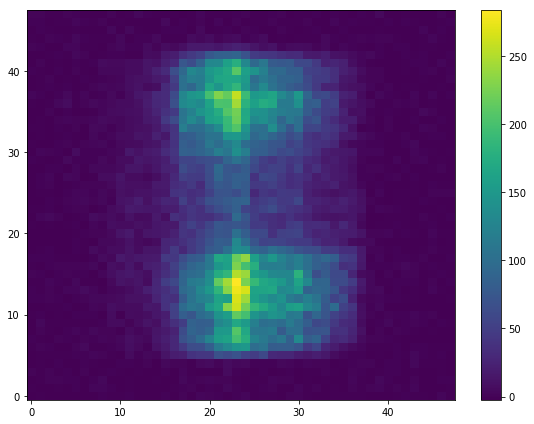

Current= 14.9
Files used: ['CG4B2048.dat', 'CG4B2049.dat', 'CG4B2050.dat', 'CG4B2051.dat', 'CG4B2052.dat', 'CG4B2053.dat', 'CG4B2054.dat', 'CG4B2055.dat', 'CG4B2056.dat', 'CG4B2057.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  63958.8423557406


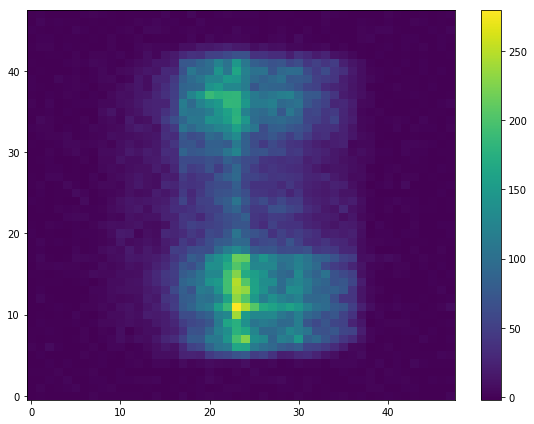

Current= 14.8
Files used: ['CG4B2058.dat', 'CG4B2059.dat', 'CG4B2060.dat', 'CG4B2061.dat', 'CG4B2062.dat', 'CG4B2063.dat', 'CG4B2064.dat', 'CG4B2065.dat', 'CG4B2066.dat', 'CG4B2067.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  77920.82034503273


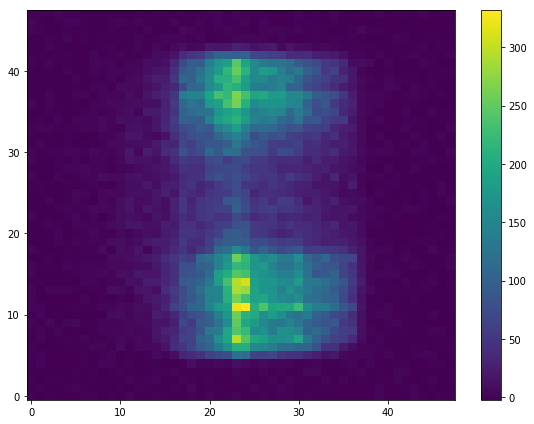

Current= 14.7
Files used: ['CG4B2068.dat', 'CG4B2069.dat', 'CG4B2070.dat', 'CG4B2071.dat', 'CG4B2072.dat', 'CG4B2073.dat', 'CG4B2074.dat', 'CG4B2075.dat', 'CG4B2076.dat', 'CG4B2077.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  74678.22843545508


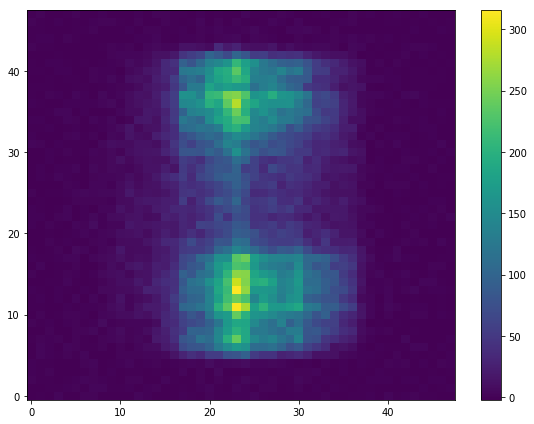

Current= 14.6
Files used: ['CG4B2078.dat', 'CG4B2079.dat', 'CG4B2080.dat', 'CG4B2081.dat', 'CG4B2082.dat', 'CG4B2083.dat', 'CG4B2084.dat', 'CG4B2085.dat', 'CG4B2086.dat', 'CG4B2087.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  130313.55740630579


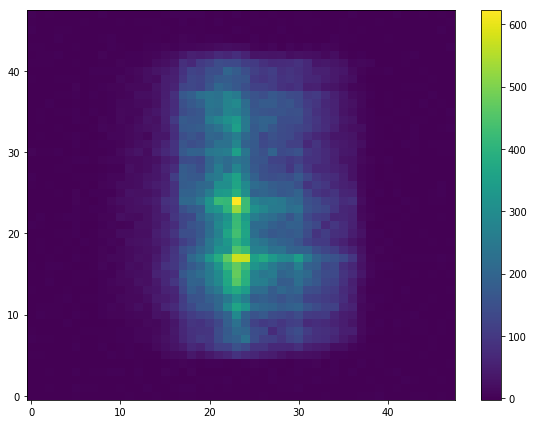


 Peak counts:  130313.55740630579 
 Current:  14.6 


 Trough counts:  63958.8423557406 
 Current:  14.9 



In [18]:
#RF off
#b1 scan, b2 = -15, nutator1 =5
zero_counts = []    #add all subscans that are zero counts here

currents = np.arange(15.5,14.5,-.1)
print("Currents used: ", currents, " \n Total=", len(currents), "\n")
high_counts = []
high_totals = []
start = 1988
subscans = 10

for i in range(len(currents)):
    print("Current=", round(currents[i],3))
    if ((start + (subscans - 1) + int(i)*subscans) not in zero_counts):
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans, \
                          print_summed=True, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
    else: 
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans - 1, \
                          print_summed=True, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
        print("Warning: one subscan failed!")
        
Peak_h = max(high_totals)
Trough_h = min(high_totals)
Peak_current_h = np.argmax(high_totals)
Trough_current_h = np.argmin(high_totals)

print("\n Peak counts: ", Peak_h, "\n Current: ", round(currents[Peak_current_h],3), "\n")
print("\n Trough counts: ", Trough_h, "\n Current: ", round(currents[Trough_current_h],3), "\n")


Currents used:  [-19.55   -19.5375 -19.525  -19.5125 -19.5    -19.4875 -19.475  -19.4625
 -19.45   -19.4375 -19.425  -19.4125 -19.4    -19.3875 -19.375  -19.3625
 -19.35   -19.3375 -19.325  -19.3125 -19.3    -19.2875 -19.275  -19.2625
 -19.25   -19.2375 -19.225  -19.2125 -19.2    -19.1875 -19.175  -19.1625
 -19.15   -19.1375 -19.125  -19.1125 -19.1    -19.0875 -19.075  -19.0625
 -19.05   -19.0375 -19.025  -19.0125 -19.    ]  
 Total= 45 

Current= -19.55
Files used: ['CG4B2557.dat', 'CG4B2558.dat', 'CG4B2559.dat', 'CG4B2560.dat', 'CG4B2561.dat', 'CG4B2562.dat', 'CG4B2563.dat', 'CG4B2564.dat', 'CG4B2565.dat', 'CG4B2566.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1740269.2676978013


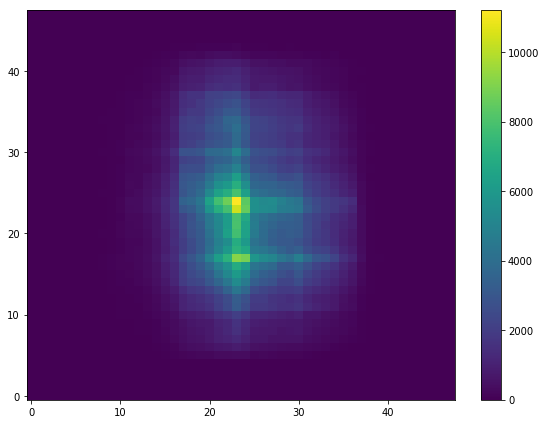

Current= -19.538
Files used: ['CG4B2567.dat', 'CG4B2568.dat', 'CG4B2569.dat', 'CG4B2570.dat', 'CG4B2571.dat', 'CG4B2572.dat', 'CG4B2573.dat', 'CG4B2574.dat', 'CG4B2575.dat', 'CG4B2576.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1746359.1844140412


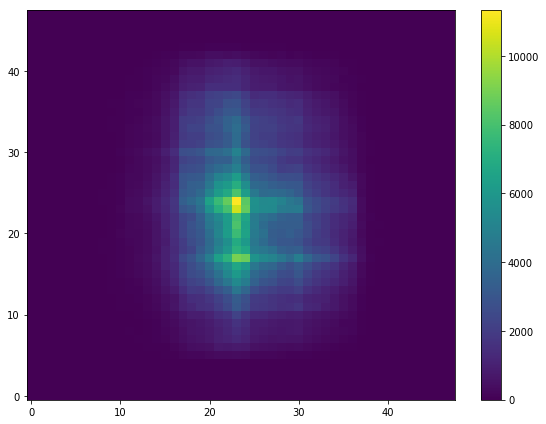

Current= -19.525
Files used: ['CG4B2577.dat', 'CG4B2578.dat', 'CG4B2579.dat', 'CG4B2580.dat', 'CG4B2581.dat', 'CG4B2582.dat', 'CG4B2583.dat', 'CG4B2584.dat', 'CG4B2585.dat', 'CG4B2586.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1753220.3884592517


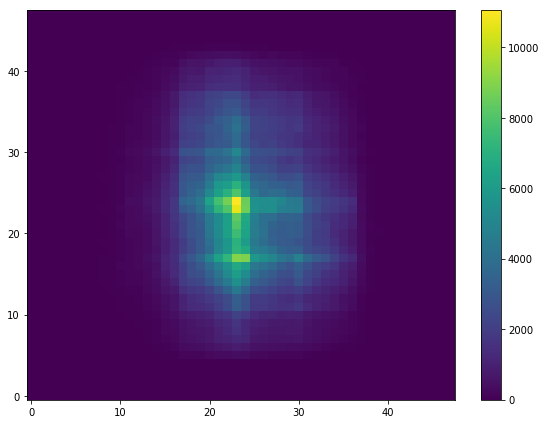

Current= -19.513
Files used: ['CG4B2587.dat', 'CG4B2588.dat', 'CG4B2589.dat', 'CG4B2590.dat', 'CG4B2591.dat', 'CG4B2592.dat', 'CG4B2593.dat', 'CG4B2594.dat', 'CG4B2595.dat', 'CG4B2596.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1757782.9232599651


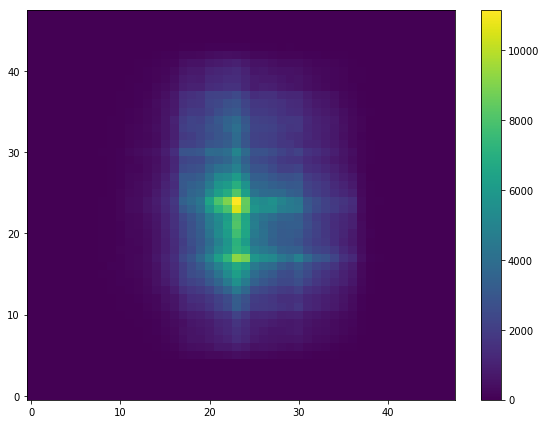

Current= -19.5
Files used: ['CG4B2597.dat', 'CG4B2598.dat', 'CG4B2599.dat', 'CG4B2600.dat', 'CG4B2601.dat', 'CG4B2602.dat', 'CG4B2603.dat', 'CG4B2604.dat', 'CG4B2605.dat', 'CG4B2606.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1766320.355145745


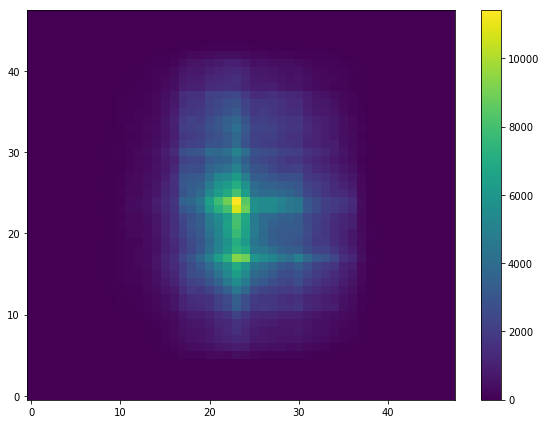

Current= -19.488
Files used: ['CG4B2607.dat', 'CG4B2608.dat', 'CG4B2609.dat', 'CG4B2610.dat', 'CG4B2611.dat', 'CG4B2612.dat', 'CG4B2613.dat', 'CG4B2614.dat', 'CG4B2615.dat', 'CG4B2616.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1763119.5038667466


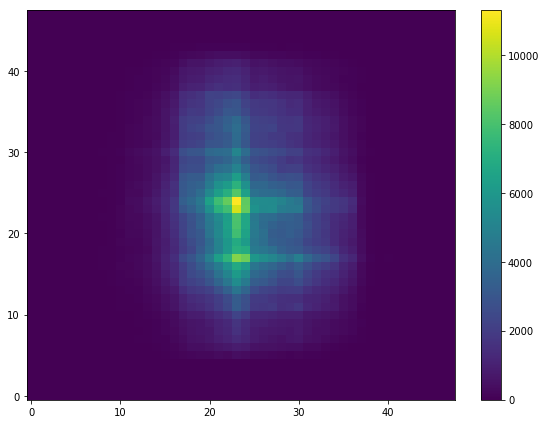

Current= -19.475
Files used: ['CG4B2617.dat', 'CG4B2618.dat', 'CG4B2619.dat', 'CG4B2620.dat', 'CG4B2621.dat', 'CG4B2622.dat', 'CG4B2623.dat', 'CG4B2624.dat', 'CG4B2625.dat', 'CG4B2626.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1760255.8352171327


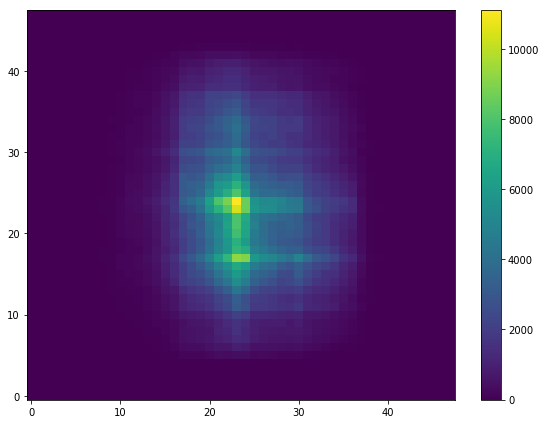

Current= -19.463
Files used: ['CG4B2627.dat', 'CG4B2628.dat', 'CG4B2629.dat', 'CG4B2630.dat', 'CG4B2631.dat', 'CG4B2632.dat', 'CG4B2633.dat', 'CG4B2634.dat', 'CG4B2635.dat', 'CG4B2636.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1742273.5169541962


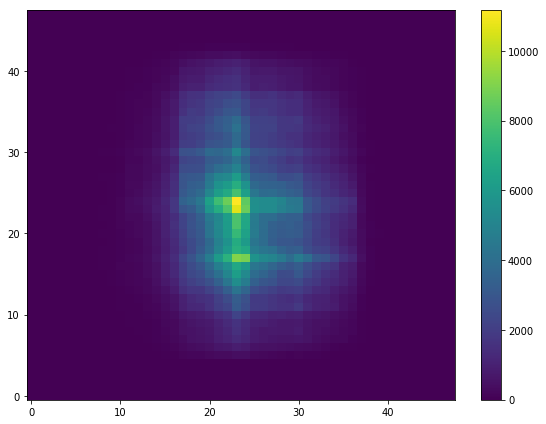

Current= -19.45
Files used: ['CG4B2637.dat', 'CG4B2638.dat', 'CG4B2639.dat', 'CG4B2640.dat', 'CG4B2641.dat', 'CG4B2642.dat', 'CG4B2643.dat', 'CG4B2644.dat', 'CG4B2645.dat', 'CG4B2646.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1719142.821534799


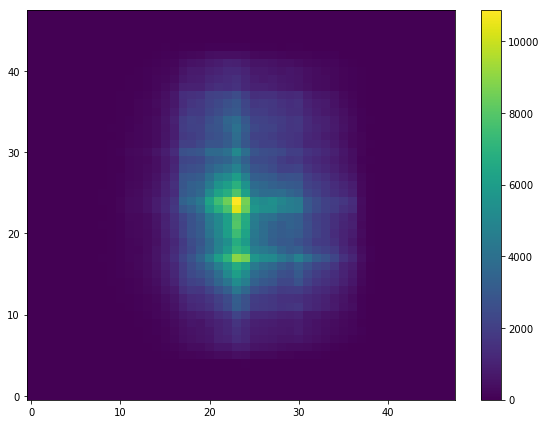

Current= -19.438
Files used: ['CG4B2647.dat', 'CG4B2648.dat', 'CG4B2649.dat', 'CG4B2650.dat', 'CG4B2651.dat', 'CG4B2652.dat', 'CG4B2653.dat', 'CG4B2654.dat', 'CG4B2655.dat', 'CG4B2656.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1676268.4598453296


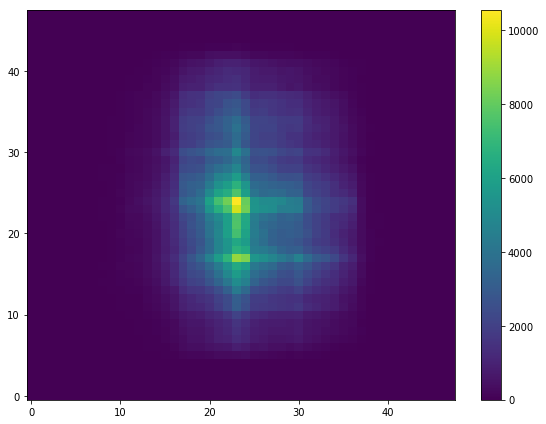

Current= -19.425
Files used: ['CG4B2657.dat', 'CG4B2658.dat', 'CG4B2659.dat', 'CG4B2660.dat', 'CG4B2661.dat', 'CG4B2662.dat', 'CG4B2663.dat', 'CG4B2664.dat', 'CG4B2665.dat', 'CG4B2666.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1619357.3521713268


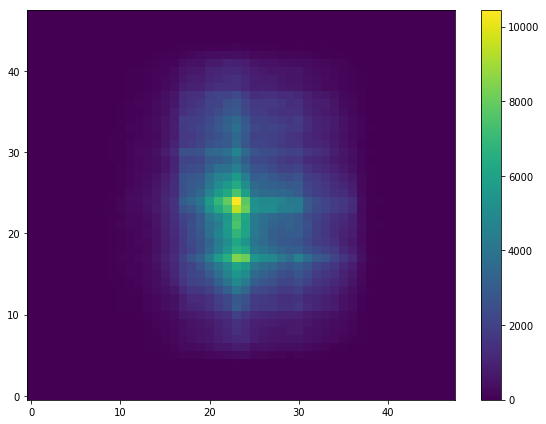

Current= -19.413
Files used: ['CG4B2667.dat', 'CG4B2668.dat', 'CG4B2669.dat', 'CG4B2670.dat', 'CG4B2671.dat', 'CG4B2672.dat', 'CG4B2673.dat', 'CG4B2674.dat', 'CG4B2675.dat', 'CG4B2676.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1546587.1017251634


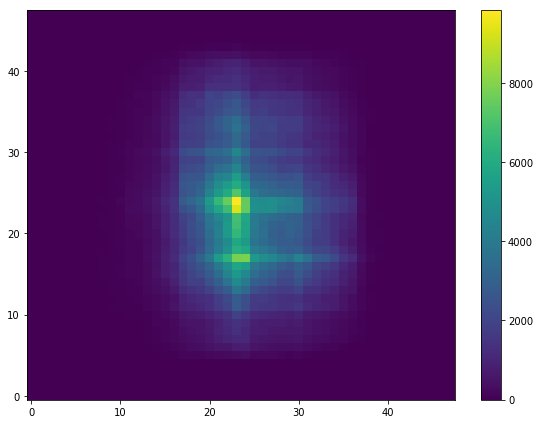

Current= -19.4
Files used: ['CG4B2677.dat', 'CG4B2678.dat', 'CG4B2679.dat', 'CG4B2680.dat', 'CG4B2681.dat', 'CG4B2682.dat', 'CG4B2683.dat', 'CG4B2684.dat', 'CG4B2685.dat', 'CG4B2686.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1462082.7459845324


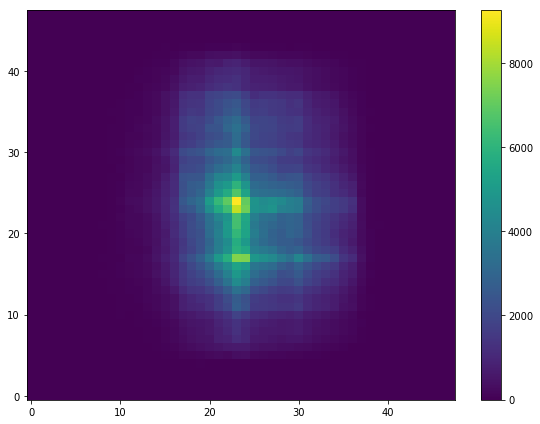

Current= -19.388
Files used: ['CG4B2687.dat', 'CG4B2688.dat', 'CG4B2689.dat', 'CG4B2690.dat', 'CG4B2691.dat', 'CG4B2692.dat', 'CG4B2693.dat', 'CG4B2694.dat', 'CG4B2695.dat', 'CG4B2696.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1348992.58774539


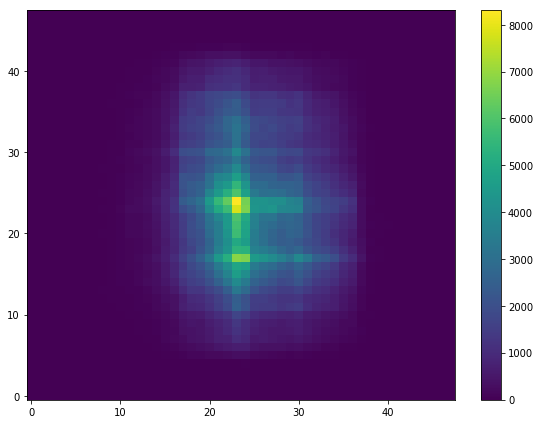

Current= -19.375
Files used: ['CG4B2697.dat', 'CG4B2698.dat', 'CG4B2699.dat', 'CG4B2700.dat', 'CG4B2701.dat', 'CG4B2702.dat', 'CG4B2703.dat', 'CG4B2704.dat', 'CG4B2705.dat', 'CG4B2706.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1230378.3878643685


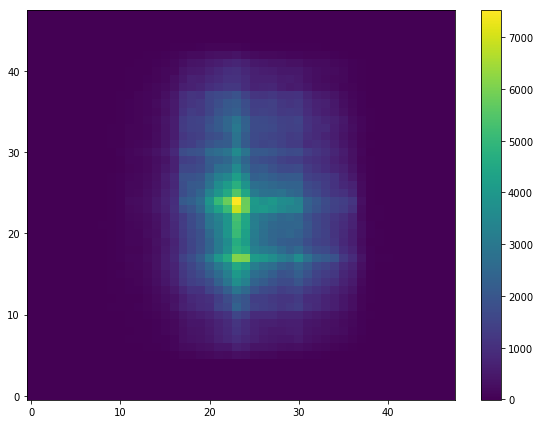

Current= -19.363
Files used: ['CG4B2707.dat', 'CG4B2708.dat', 'CG4B2709.dat', 'CG4B2710.dat', 'CG4B2711.dat', 'CG4B2712.dat', 'CG4B2713.dat', 'CG4B2714.dat', 'CG4B2715.dat', 'CG4B2716.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1102799.8019036292


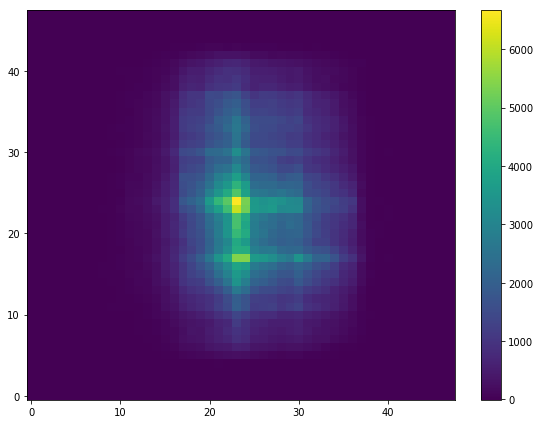

Current= -19.35
Files used: ['CG4B2717.dat', 'CG4B2718.dat', 'CG4B2719.dat', 'CG4B2720.dat', 'CG4B2721.dat', 'CG4B2722.dat', 'CG4B2723.dat', 'CG4B2724.dat', 'CG4B2725.dat', 'CG4B2726.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  954929.5496728136


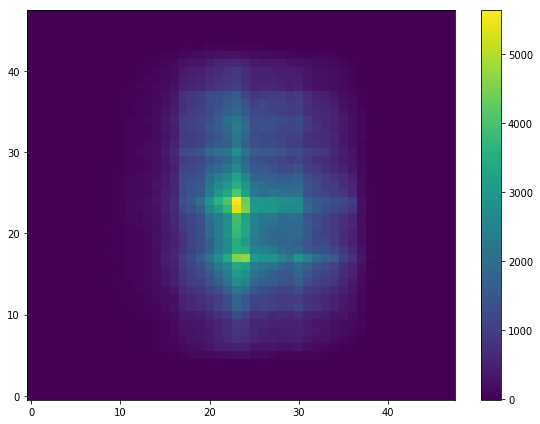

Current= -19.338
Files used: ['CG4B2727.dat', 'CG4B2728.dat', 'CG4B2729.dat', 'CG4B2730.dat', 'CG4B2731.dat', 'CG4B2732.dat', 'CG4B2733.dat', 'CG4B2734.dat', 'CG4B2735.dat', 'CG4B2736.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  813972.5490779296


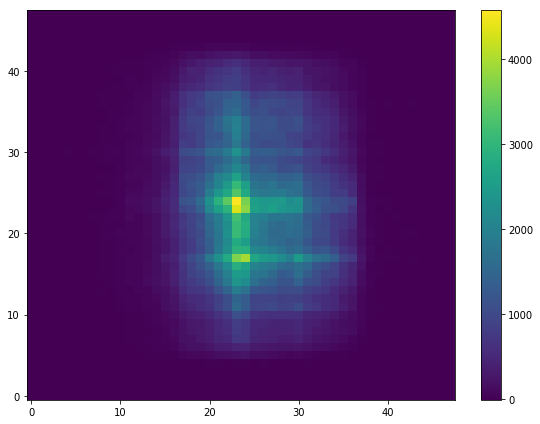

Current= -19.325
Files used: ['CG4B2737.dat', 'CG4B2738.dat', 'CG4B2739.dat', 'CG4B2740.dat', 'CG4B2741.dat', 'CG4B2742.dat', 'CG4B2743.dat', 'CG4B2744.dat', 'CG4B2745.dat', 'CG4B2746.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  679338.9256395004


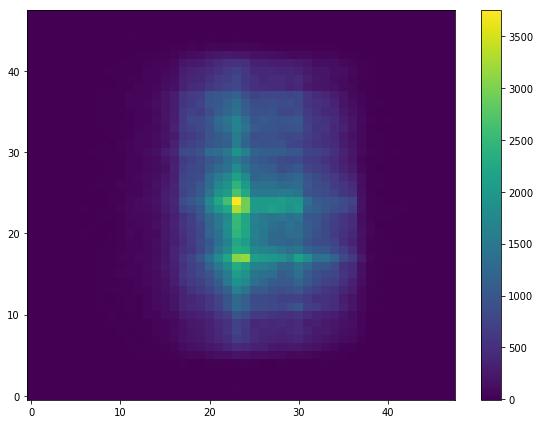

Current= -19.313
Files used: ['CG4B2747.dat', 'CG4B2748.dat', 'CG4B2749.dat', 'CG4B2750.dat', 'CG4B2751.dat', 'CG4B2752.dat', 'CG4B2753.dat', 'CG4B2754.dat', 'CG4B2755.dat', 'CG4B2756.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  531287.1338489004


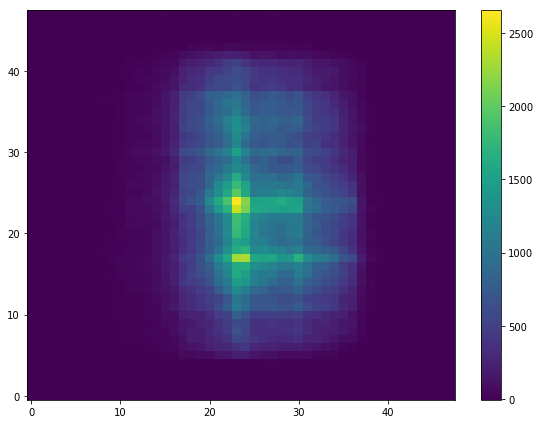

Current= -19.3
Files used: ['CG4B2757.dat', 'CG4B2758.dat', 'CG4B2759.dat', 'CG4B2760.dat', 'CG4B2761.dat', 'CG4B2762.dat', 'CG4B2763.dat', 'CG4B2764.dat', 'CG4B2765.dat', 'CG4B2766.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  406633.7519333733


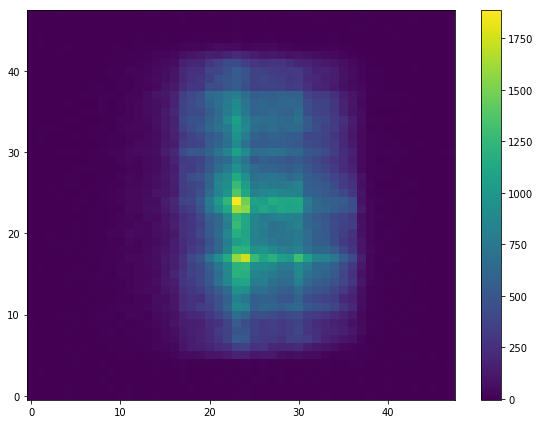

Current= -19.288
Files used: ['CG4B2767.dat', 'CG4B2768.dat', 'CG4B2769.dat', 'CG4B2770.dat', 'CG4B2771.dat', 'CG4B2772.dat', 'CG4B2773.dat', 'CG4B2774.dat', 'CG4B2775.dat', 'CG4B2776.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  308427.4271267103


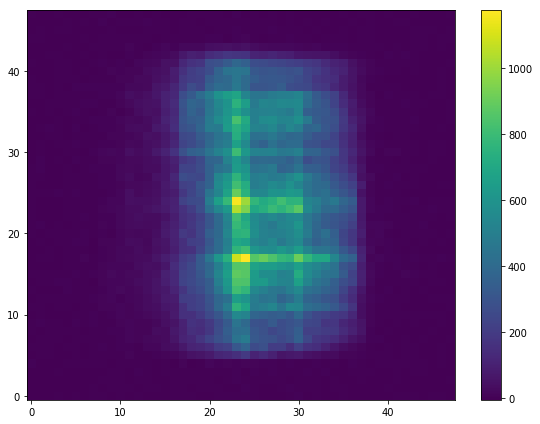

Current= -19.275
Files used: ['CG4B2777.dat', 'CG4B2778.dat', 'CG4B2779.dat', 'CG4B2780.dat', 'CG4B2781.dat', 'CG4B2782.dat', 'CG4B2783.dat', 'CG4B2784.dat', 'CG4B2785.dat', 'CG4B2786.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  227116.93158834014


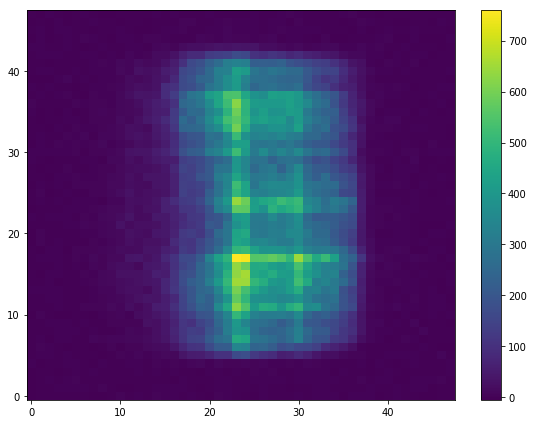

Current= -19.263
Files used: ['CG4B2787.dat', 'CG4B2788.dat', 'CG4B2789.dat', 'CG4B2790.dat', 'CG4B2791.dat', 'CG4B2792.dat', 'CG4B2793.dat', 'CG4B2794.dat', 'CG4B2795.dat', 'CG4B2796.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  179029.20345032724


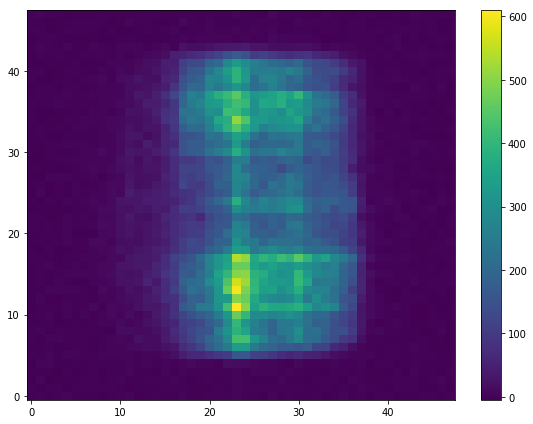

Current= -19.25
Files used: ['CG4B2797.dat', 'CG4B2798.dat', 'CG4B2799.dat', 'CG4B2800.dat', 'CG4B2801.dat', 'CG4B2802.dat', 'CG4B2803.dat', 'CG4B2804.dat', 'CG4B2805.dat', 'CG4B2806.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  163855.5871505055


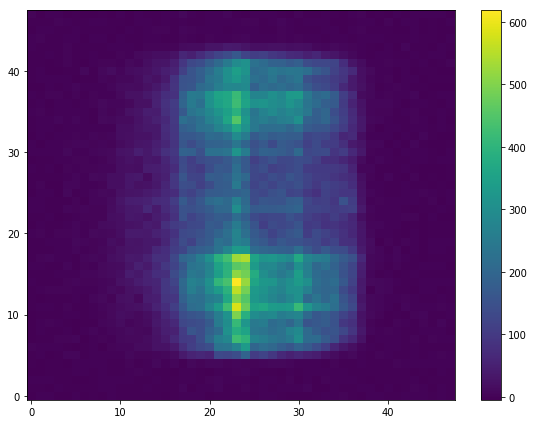

Current= -19.238
Files used: ['CG4B2807.dat', 'CG4B2808.dat', 'CG4B2809.dat', 'CG4B2810.dat', 'CG4B2811.dat', 'CG4B2812.dat', 'CG4B2813.dat', 'CG4B2814.dat', 'CG4B2815.dat', 'CG4B2816.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  181936.85484830465


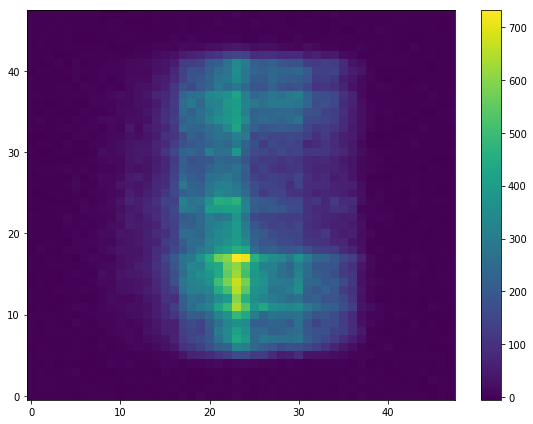

Current= -19.225
Files used: ['CG4B2817.dat', 'CG4B2818.dat', 'CG4B2819.dat', 'CG4B2820.dat', 'CG4B2821.dat', 'CG4B2822.dat', 'CG4B2823.dat', 'CG4B2824.dat', 'CG4B2825.dat', 'CG4B2826.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  231766.19274241533


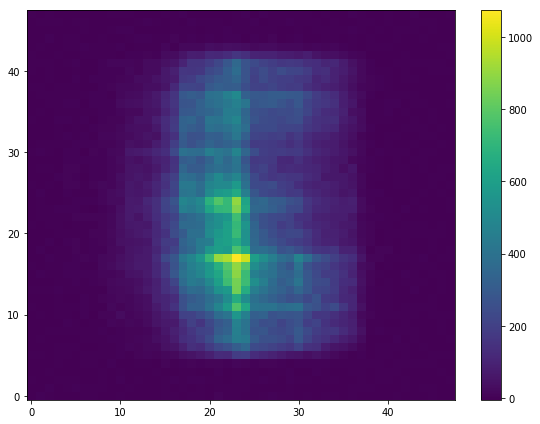

Current= -19.213
Files used: ['CG4B2827.dat', 'CG4B2828.dat', 'CG4B2829.dat', 'CG4B2830.dat', 'CG4B2831.dat', 'CG4B2832.dat', 'CG4B2833.dat', 'CG4B2834.dat', 'CG4B2835.dat', 'CG4B2836.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  309416.8947055323


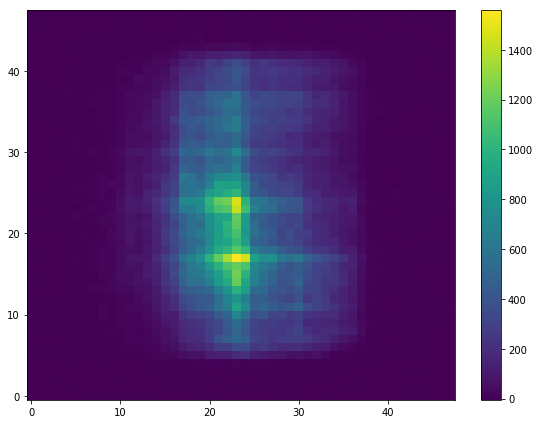

Current= -19.2
Files used: ['CG4B2837.dat', 'CG4B2838.dat', 'CG4B2839.dat', 'CG4B2840.dat', 'CG4B2841.dat', 'CG4B2842.dat', 'CG4B2843.dat', 'CG4B2844.dat', 'CG4B2845.dat', 'CG4B2846.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  414815.1344437835


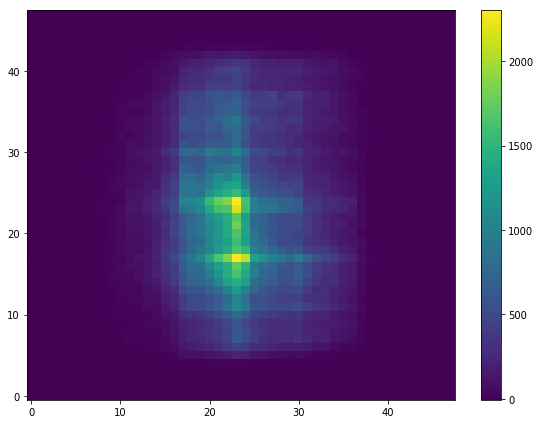

Current= -19.188
Files used: ['CG4B2847.dat', 'CG4B2848.dat', 'CG4B2849.dat', 'CG4B2850.dat', 'CG4B2851.dat', 'CG4B2852.dat', 'CG4B2853.dat', 'CG4B2854.dat', 'CG4B2855.dat', 'CG4B2856.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  540359.1701368237


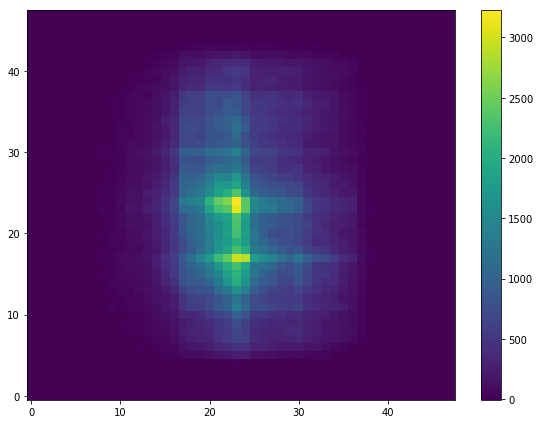

Current= -19.175
Files used: ['CG4B2857.dat', 'CG4B2858.dat', 'CG4B2859.dat', 'CG4B2860.dat', 'CG4B2861.dat', 'CG4B2862.dat', 'CG4B2863.dat', 'CG4B2864.dat', 'CG4B2865.dat', 'CG4B2866.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  678157.7317073172


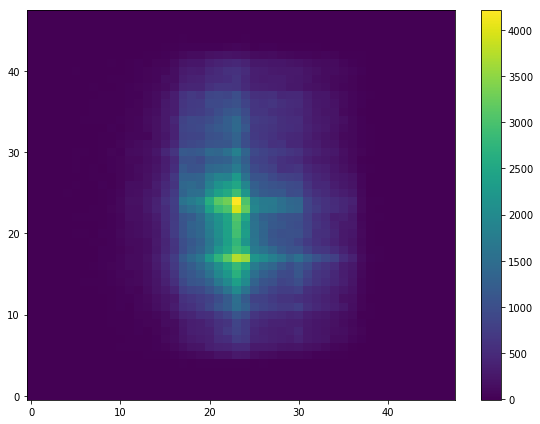

Current= -19.163
Files used: ['CG4B2867.dat', 'CG4B2868.dat', 'CG4B2869.dat', 'CG4B2870.dat', 'CG4B2871.dat', 'CG4B2872.dat', 'CG4B2873.dat', 'CG4B2874.dat', 'CG4B2875.dat', 'CG4B2876.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  835915.7209994035


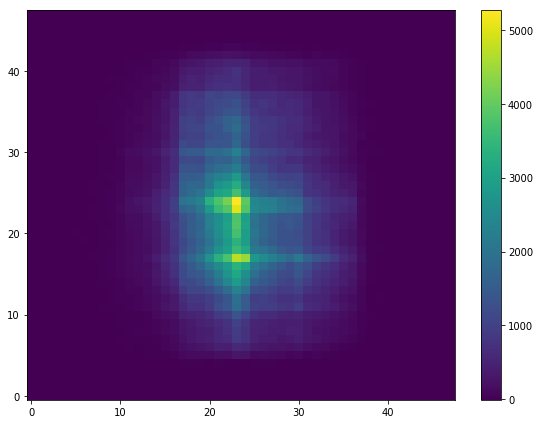

Current= -19.15
Files used: ['CG4B2877.dat', 'CG4B2878.dat', 'CG4B2879.dat', 'CG4B2880.dat', 'CG4B2881.dat', 'CG4B2882.dat', 'CG4B2883.dat', 'CG4B2884.dat', 'CG4B2885.dat', 'CG4B2886.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  990567.0422367641


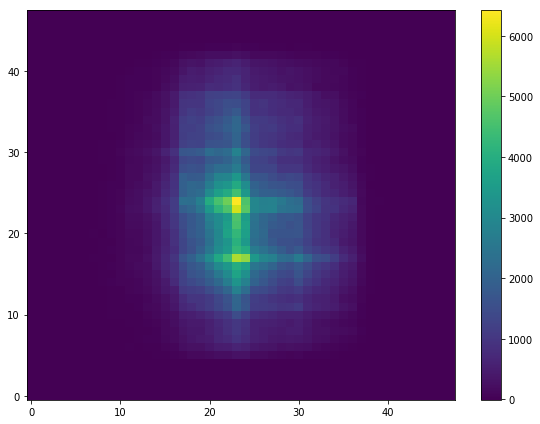

Current= -19.138
Files used: ['CG4B2887.dat', 'CG4B2888.dat', 'CG4B2889.dat', 'CG4B2890.dat', 'CG4B2891.dat', 'CG4B2892.dat', 'CG4B2893.dat', 'CG4B2894.dat', 'CG4B2895.dat', 'CG4B2896.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1136457.5776323616


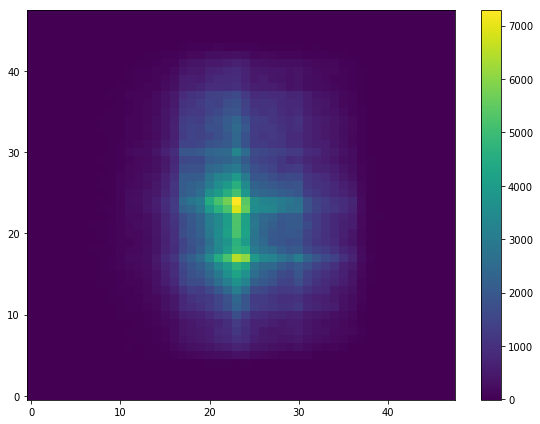

Current= -19.125
Files used: ['CG4B2897.dat', 'CG4B2898.dat', 'CG4B2899.dat', 'CG4B2900.dat', 'CG4B2901.dat', 'CG4B2902.dat', 'CG4B2903.dat', 'CG4B2904.dat', 'CG4B2905.dat', 'CG4B2906.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1274916.4003569302


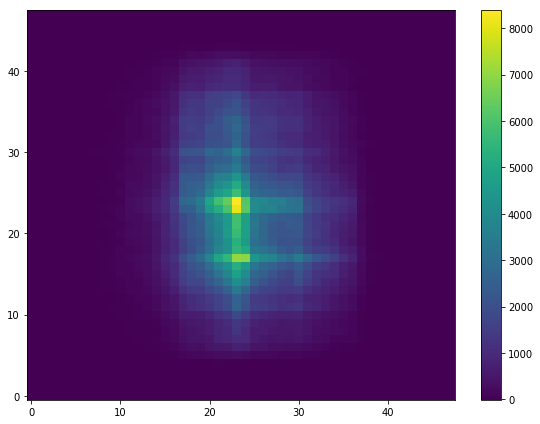

Current= -19.113
Files used: ['CG4B2907.dat', 'CG4B2908.dat', 'CG4B2909.dat', 'CG4B2910.dat', 'CG4B2911.dat', 'CG4B2912.dat', 'CG4B2913.dat', 'CG4B2914.dat', 'CG4B2915.dat', 'CG4B2916.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1401545.6549672815


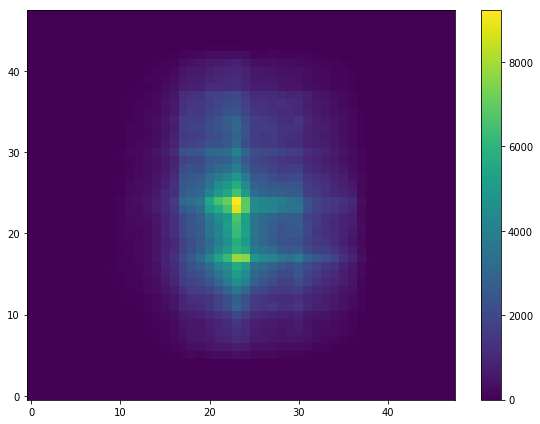

Current= -19.1
Files used: ['CG4B2917.dat', 'CG4B2918.dat', 'CG4B2919.dat', 'CG4B2920.dat', 'CG4B2921.dat', 'CG4B2922.dat', 'CG4B2923.dat', 'CG4B2924.dat', 'CG4B2925.dat', 'CG4B2926.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1508848.0101130295


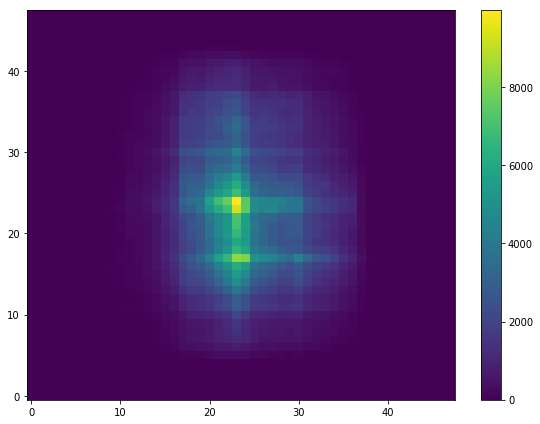

Current= -19.088
Files used: ['CG4B2927.dat', 'CG4B2928.dat', 'CG4B2929.dat', 'CG4B2930.dat', 'CG4B2931.dat', 'CG4B2932.dat', 'CG4B2933.dat', 'CG4B2934.dat', 'CG4B2935.dat', 'CG4B2936.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1596682.5871505057


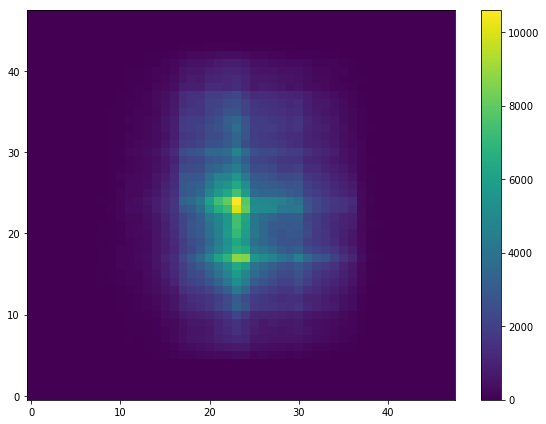

Current= -19.075
Files used: ['CG4B2937.dat', 'CG4B2938.dat', 'CG4B2939.dat', 'CG4B2940.dat', 'CG4B2941.dat', 'CG4B2942.dat', 'CG4B2943.dat', 'CG4B2944.dat', 'CG4B2945.dat', 'CG4B2946.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1664641.3789411066


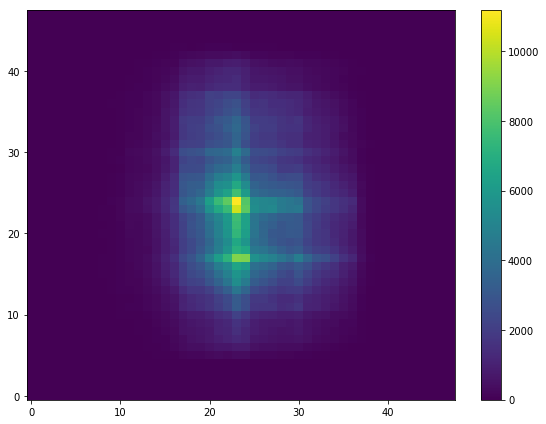

Current= -19.063
Files used: ['CG4B2947.dat', 'CG4B2948.dat', 'CG4B2949.dat', 'CG4B2950.dat', 'CG4B2951.dat', 'CG4B2952.dat', 'CG4B2953.dat', 'CG4B2954.dat', 'CG4B2955.dat', 'CG4B2956.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1712168.480071384


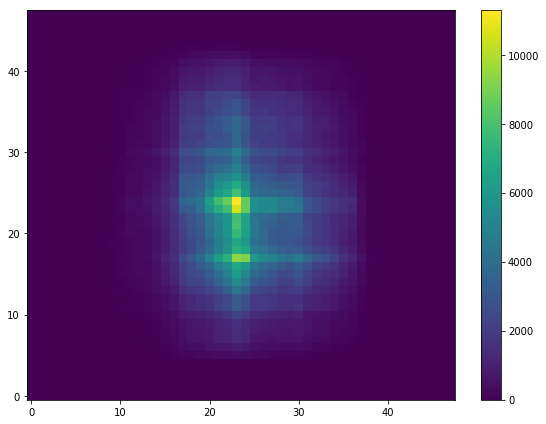

Current= -19.05
Files used: ['CG4B2957.dat', 'CG4B2958.dat', 'CG4B2959.dat', 'CG4B2960.dat', 'CG4B2961.dat', 'CG4B2962.dat', 'CG4B2963.dat', 'CG4B2964.dat', 'CG4B2965.dat', 'CG4B2966.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1740965.9494348583


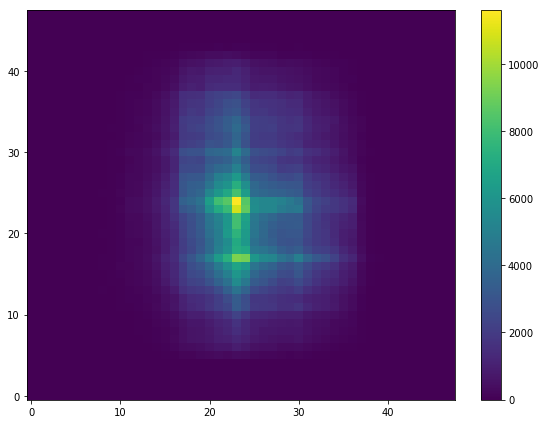

Current= -19.038
Files used: ['CG4B2967.dat', 'CG4B2968.dat', 'CG4B2969.dat', 'CG4B2970.dat', 'CG4B2971.dat', 'CG4B2972.dat', 'CG4B2973.dat', 'CG4B2974.dat', 'CG4B2975.dat', 'CG4B2976.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1757111.5151695444


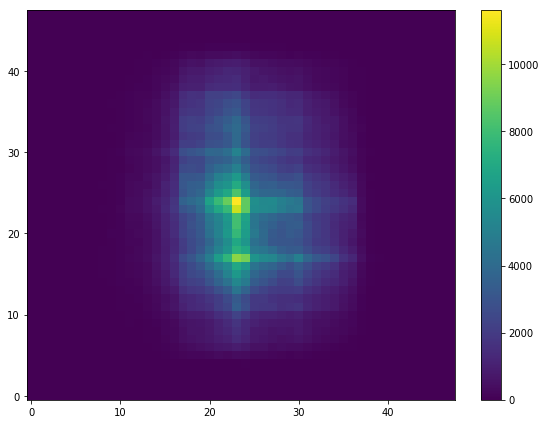

Current= -19.025
Files used: ['CG4B2977.dat', 'CG4B2978.dat', 'CG4B2979.dat', 'CG4B2980.dat', 'CG4B2981.dat', 'CG4B2982.dat', 'CG4B2983.dat', 'CG4B2984.dat', 'CG4B2985.dat', 'CG4B2986.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1765648.164187983


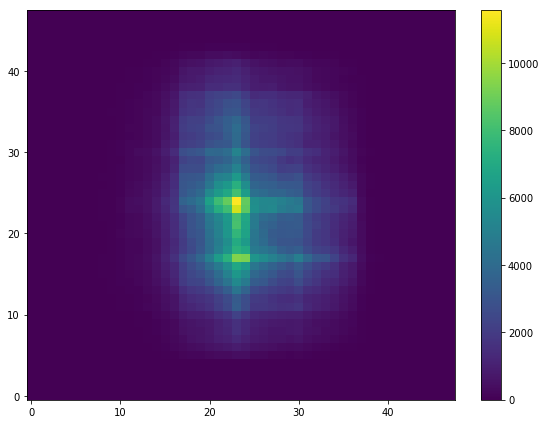

Current= -19.013
Files used: ['CG4B2987.dat', 'CG4B2988.dat', 'CG4B2989.dat', 'CG4B2990.dat', 'CG4B2991.dat', 'CG4B2992.dat', 'CG4B2993.dat', 'CG4B2994.dat', 'CG4B2995.dat', 'CG4B2996.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1760141.0850684121


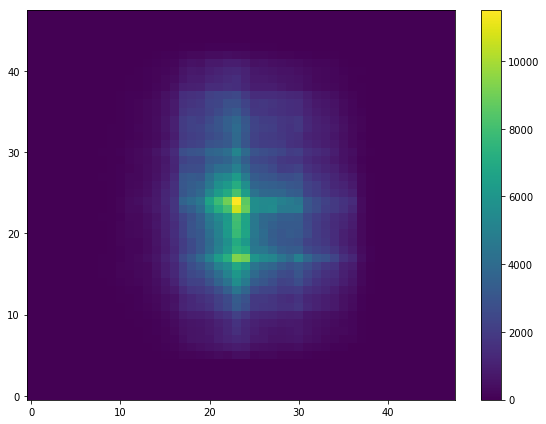

Current= -19.0
Files used: ['CG4B2997.dat', 'CG4B2998.dat', 'CG4B2999.dat', 'CG4B3000.dat', 'CG4B3001.dat', 'CG4B3002.dat', 'CG4B3003.dat', 'CG4B3004.dat', 'CG4B3005.dat', 'CG4B3006.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1751521.354550861


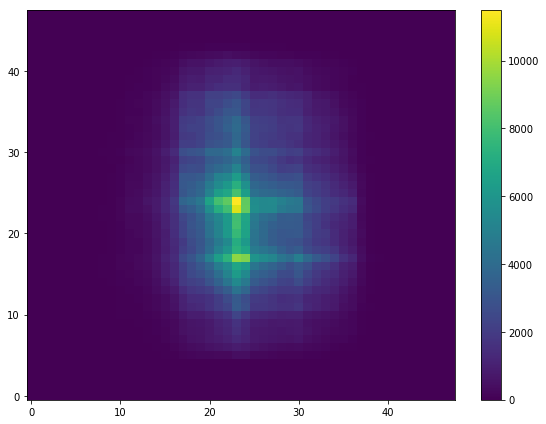


 Peak counts:  1766320.355145745 
 Current:  -19.5 


 Trough counts:  163855.5871505055 
 Current:  -19.25 



In [19]:
#RF2 on
#b1 scan, b1 = 19.55, nutator1 =-5
zero_counts = []    #add all subscans that are zero counts here

currents = np.arange(-19.55,-19.,.0125)
print("Currents used: ", currents, " \n Total=", len(currents), "\n")
high_counts = []
high_totals = []
start = 2557
subscans = 10

for i in range(len(currents)):
    print("Current=", round(currents[i],3))
    if ((start + (subscans - 1) + int(i)*subscans) not in zero_counts):
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans, \
                          print_summed=True, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
    else: 
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans - 1, \
                          print_summed=True, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
        print("Warning: one subscan failed!")
        
Peak_h = max(high_totals)
Trough_h = min(high_totals)
Peak_current_h = np.argmax(high_totals)
Trough_current_h = np.argmin(high_totals)

print("\n Peak counts: ", Peak_h, "\n Current: ", round(currents[Peak_current_h],3), "\n")
print("\n Trough counts: ", Trough_h, "\n Current: ", round(currents[Trough_current_h],3), "\n")


Currents used:  [-19.55   -19.5375 -19.525  -19.5125 -19.5    -19.4875 -19.475  -19.4625
 -19.45   -19.4375 -19.425  -19.4125 -19.4    -19.3875 -19.375  -19.3625
 -19.35   -19.3375 -19.325  -19.3125 -19.3    -19.2875 -19.275  -19.2625
 -19.25   -19.2375 -19.225  -19.2125 -19.2    -19.1875 -19.175  -19.1625
 -19.15   -19.1375 -19.125  -19.1125 -19.1    -19.0875 -19.075  -19.0625
 -19.05   -19.0375 -19.025  -19.0125 -19.    ]  
 Total= 45 

Current= -19.55
Files used: ['CG4B3117.dat', 'CG4B3118.dat', 'CG4B3119.dat', 'CG4B3120.dat', 'CG4B3121.dat', 'CG4B3122.dat', 'CG4B3123.dat', 'CG4B3124.dat', 'CG4B3125.dat', 'CG4B3126.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  42999.06603212368


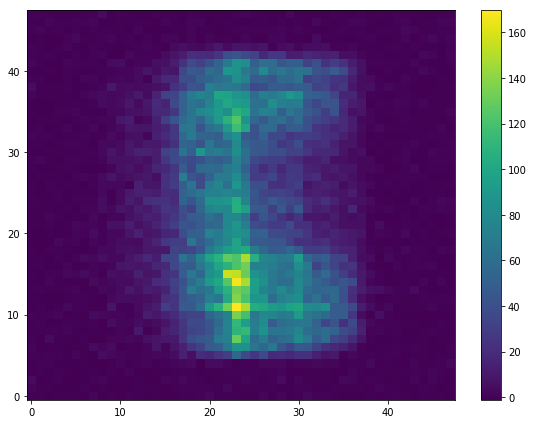

Current= -19.538
Files used: ['CG4B3127.dat', 'CG4B3128.dat', 'CG4B3129.dat', 'CG4B3130.dat', 'CG4B3131.dat', 'CG4B3132.dat', 'CG4B3133.dat', 'CG4B3134.dat', 'CG4B3135.dat', 'CG4B3136.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  42981.11659726346


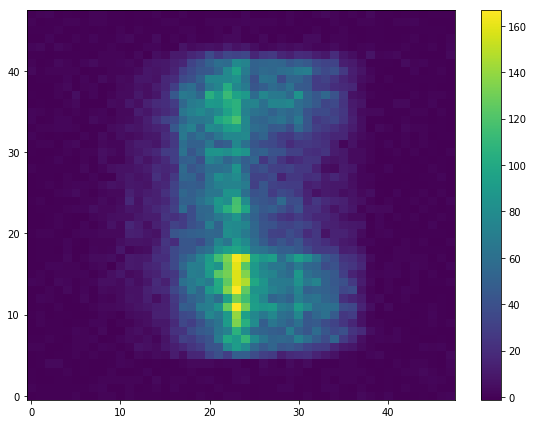

Current= -19.525
Files used: ['CG4B3137.dat', 'CG4B3138.dat', 'CG4B3139.dat', 'CG4B3140.dat', 'CG4B3141.dat', 'CG4B3142.dat', 'CG4B3143.dat', 'CG4B3144.dat', 'CG4B3145.dat', 'CG4B3146.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  42226.29863176687


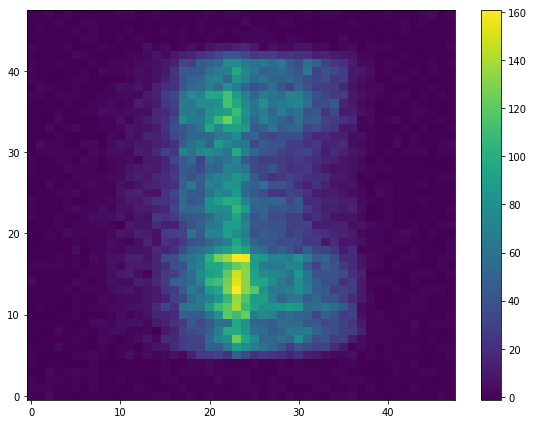

Current= -19.513
Files used: ['CG4B3147.dat', 'CG4B3148.dat', 'CG4B3149.dat', 'CG4B3150.dat', 'CG4B3151.dat', 'CG4B3152.dat', 'CG4B3153.dat', 'CG4B3154.dat', 'CG4B3155.dat', 'CG4B3156.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  41419.66924449732


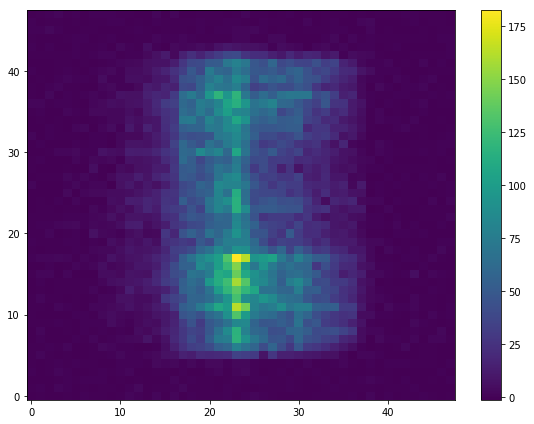

Current= -19.5
Files used: ['CG4B3157.dat', 'CG4B3158.dat', 'CG4B3159.dat', 'CG4B3160.dat', 'CG4B3161.dat', 'CG4B3162.dat', 'CG4B3163.dat', 'CG4B3164.dat', 'CG4B3165.dat', 'CG4B3166.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  39695.20642474712


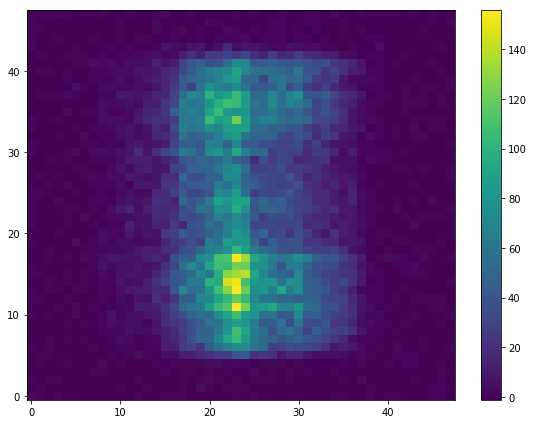

Current= -19.488
Files used: ['CG4B3167.dat', 'CG4B3168.dat', 'CG4B3169.dat', 'CG4B3170.dat', 'CG4B3171.dat', 'CG4B3172.dat', 'CG4B3173.dat', 'CG4B3174.dat', 'CG4B3175.dat', 'CG4B3176.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  38011.01784651989


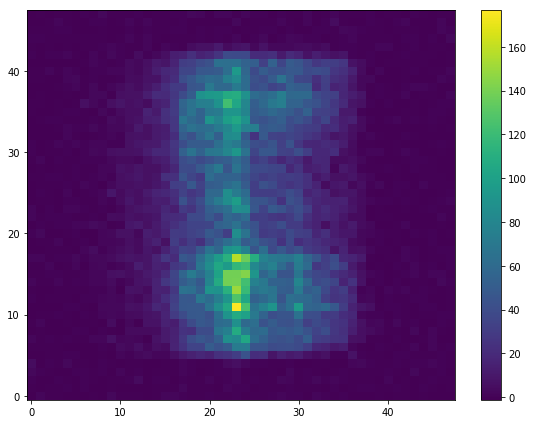

Current= -19.475
Files used: ['CG4B3177.dat', 'CG4B3178.dat', 'CG4B3179.dat', 'CG4B3180.dat', 'CG4B3181.dat', 'CG4B3182.dat', 'CG4B3183.dat', 'CG4B3184.dat', 'CG4B3185.dat', 'CG4B3186.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  36611.27007733497


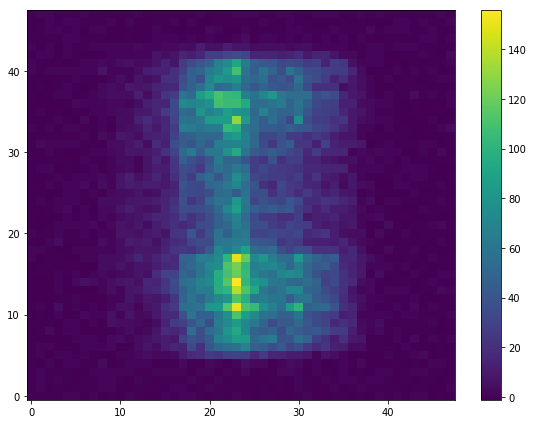

Current= -19.463
Files used: ['CG4B3187.dat', 'CG4B3188.dat', 'CG4B3189.dat', 'CG4B3190.dat', 'CG4B3191.dat', 'CG4B3192.dat', 'CG4B3193.dat', 'CG4B3194.dat', 'CG4B3195.dat', 'CG4B3196.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  35130.44318857826


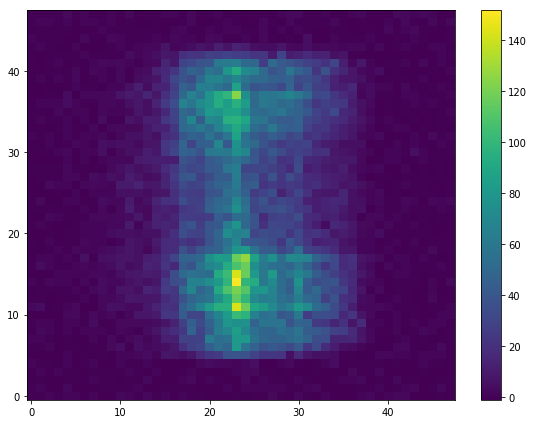

Current= -19.45
Files used: ['CG4B3197.dat', 'CG4B3198.dat', 'CG4B3199.dat', 'CG4B3200.dat', 'CG4B3201.dat', 'CG4B3202.dat', 'CG4B3203.dat', 'CG4B3204.dat', 'CG4B3205.dat', 'CG4B3206.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  35082.57703747772


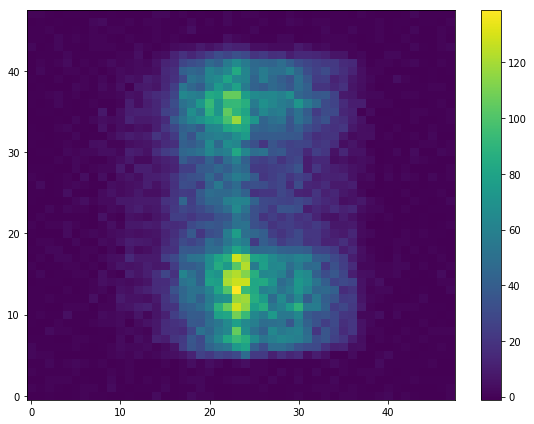

Current= -19.438
Files used: ['CG4B3207.dat', 'CG4B3208.dat', 'CG4B3209.dat', 'CG4B3210.dat', 'CG4B3211.dat', 'CG4B3212.dat', 'CG4B3213.dat', 'CG4B3214.dat', 'CG4B3215.dat', 'CG4B3216.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  36430.43010113035


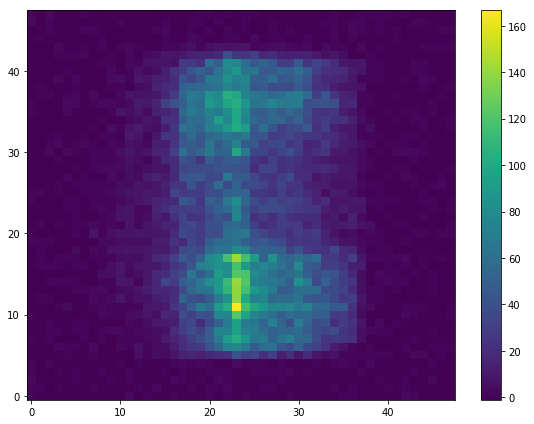

Current= -19.425
Files used: ['CG4B3217.dat', 'CG4B3218.dat', 'CG4B3219.dat', 'CG4B3220.dat', 'CG4B3221.dat', 'CG4B3222.dat', 'CG4B3223.dat', 'CG4B3224.dat', 'CG4B3225.dat', 'CG4B3226.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  40381.99583581198


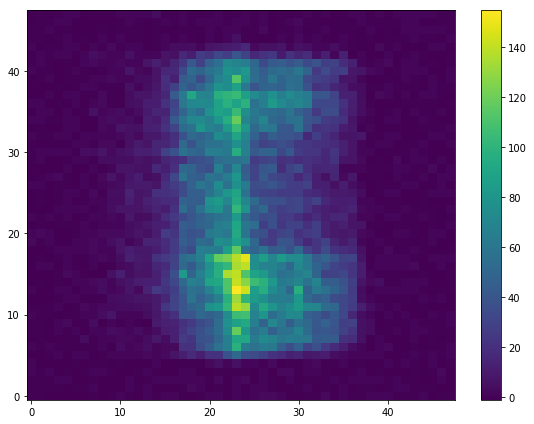

Current= -19.413
Files used: ['CG4B3227.dat', 'CG4B3228.dat', 'CG4B3229.dat', 'CG4B3230.dat', 'CG4B3231.dat', 'CG4B3232.dat', 'CG4B3233.dat', 'CG4B3234.dat', 'CG4B3235.dat', 'CG4B3236.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  46164.19988102319


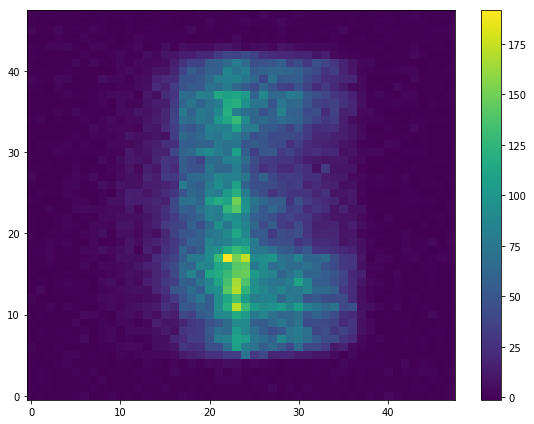

Current= -19.4
Files used: ['CG4B3237.dat', 'CG4B3238.dat', 'CG4B3239.dat', 'CG4B3240.dat', 'CG4B3241.dat', 'CG4B3242.dat', 'CG4B3243.dat', 'CG4B3244.dat', 'CG4B3245.dat', 'CG4B3246.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  54979.033313503794


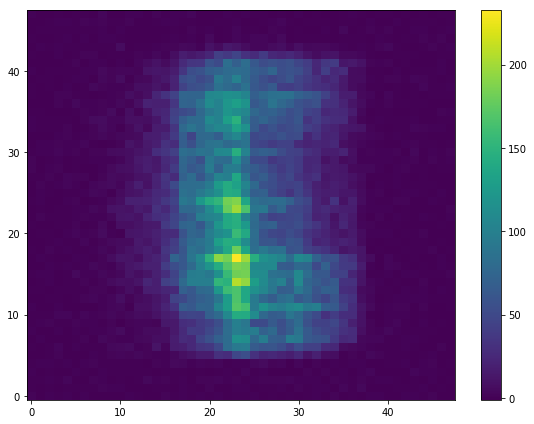

Current= -19.388
Files used: ['CG4B3247.dat', 'CG4B3248.dat', 'CG4B3249.dat', 'CG4B3250.dat', 'CG4B3251.dat', 'CG4B3252.dat', 'CG4B3253.dat', 'CG4B3254.dat', 'CG4B3255.dat', 'CG4B3256.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  69667.2284354551


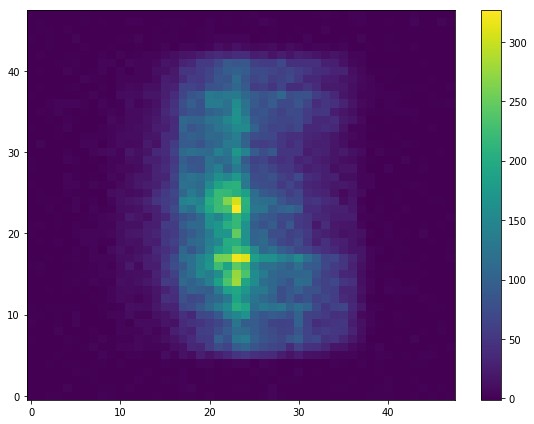

Current= -19.375
Files used: ['CG4B3257.dat', 'CG4B3258.dat', 'CG4B3259.dat', 'CG4B3260.dat', 'CG4B3261.dat', 'CG4B3262.dat', 'CG4B3263.dat', 'CG4B3264.dat', 'CG4B3265.dat', 'CG4B3266.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  86504.79654967276


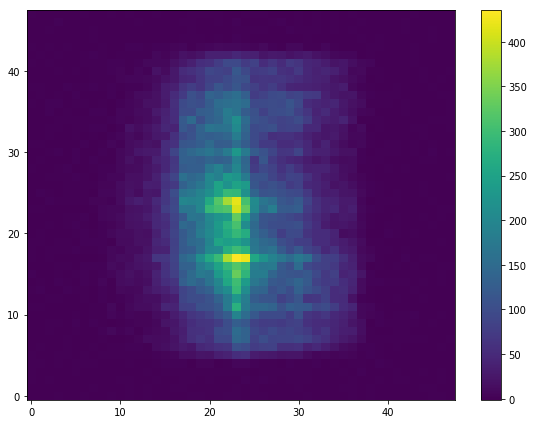

Current= -19.363
Files used: ['CG4B3267.dat', 'CG4B3268.dat', 'CG4B3269.dat', 'CG4B3270.dat', 'CG4B3271.dat', 'CG4B3272.dat', 'CG4B3273.dat', 'CG4B3274.dat', 'CG4B3275.dat', 'CG4B3276.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  106477.77037477682


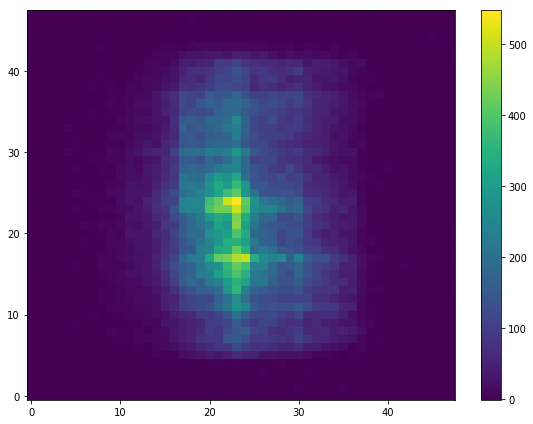

Current= -19.35
Files used: ['CG4B3277.dat', 'CG4B3278.dat', 'CG4B3279.dat', 'CG4B3280.dat', 'CG4B3281.dat', 'CG4B3282.dat', 'CG4B3283.dat', 'CG4B3284.dat', 'CG4B3285.dat', 'CG4B3286.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  133235.29446757858


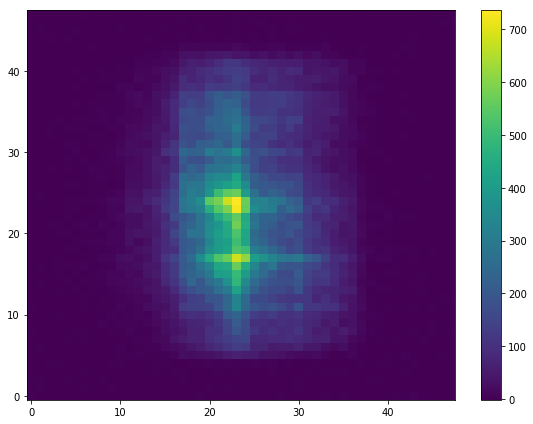

Current= -19.338
Files used: ['CG4B3287.dat', 'CG4B3288.dat', 'CG4B3289.dat', 'CG4B3290.dat', 'CG4B3291.dat', 'CG4B3292.dat', 'CG4B3293.dat', 'CG4B3294.dat', 'CG4B3295.dat', 'CG4B3296.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  162123.5074360503


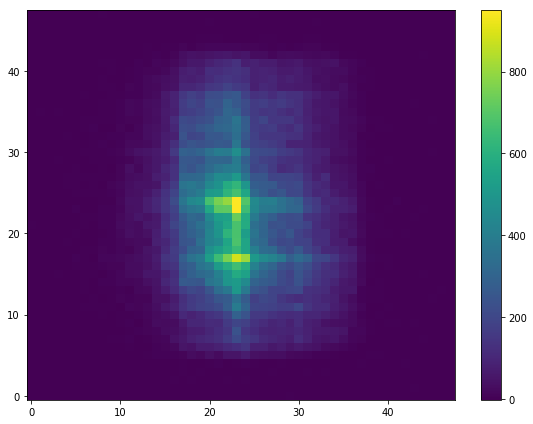

Current= -19.325
Files used: ['CG4B3297.dat', 'CG4B3298.dat', 'CG4B3299.dat', 'CG4B3300.dat', 'CG4B3301.dat', 'CG4B3302.dat', 'CG4B3303.dat', 'CG4B3304.dat', 'CG4B3305.dat', 'CG4B3306.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  191670.2575847713


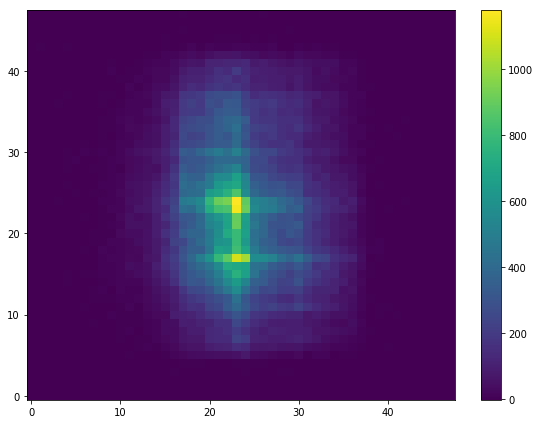

Current= -19.313
Files used: ['CG4B3307.dat', 'CG4B3308.dat', 'CG4B3309.dat', 'CG4B3310.dat', 'CG4B3311.dat', 'CG4B3312.dat', 'CG4B3313.dat', 'CG4B3314.dat', 'CG4B3315.dat', 'CG4B3316.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  229193.78405710895


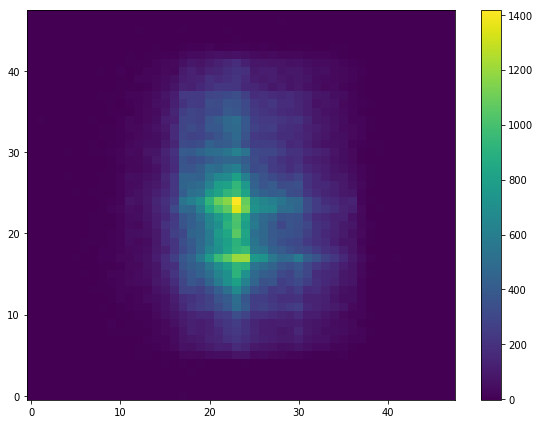

Current= -19.3
Files used: ['CG4B3317.dat', 'CG4B3318.dat', 'CG4B3319.dat', 'CG4B3320.dat', 'CG4B3321.dat', 'CG4B3322.dat', 'CG4B3323.dat', 'CG4B3324.dat', 'CG4B3325.dat', 'CG4B3326.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  266181.22070196347


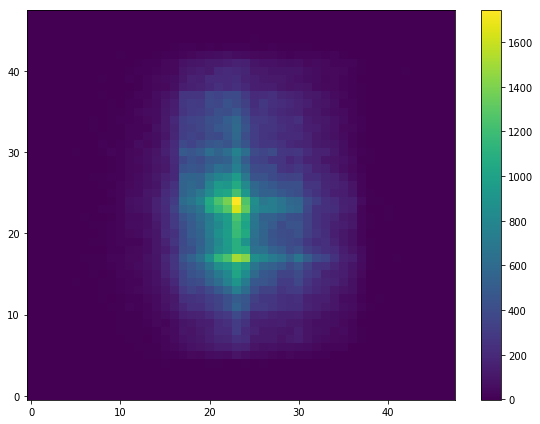

Current= -19.288
Files used: ['CG4B3327.dat', 'CG4B3328.dat', 'CG4B3329.dat', 'CG4B3330.dat', 'CG4B3331.dat', 'CG4B3332.dat', 'CG4B3333.dat', 'CG4B3334.dat', 'CG4B3335.dat', 'CG4B3336.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  303486.33670434274


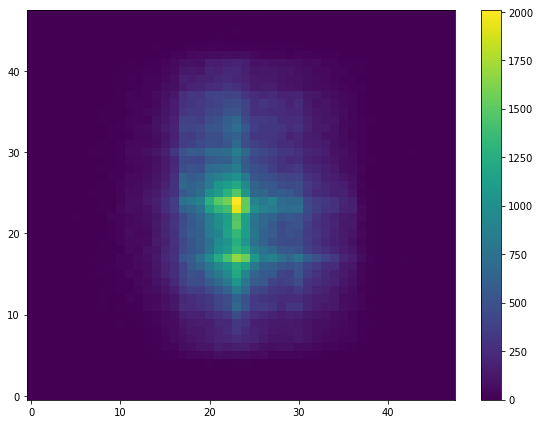

Current= -19.275
Files used: ['CG4B3337.dat', 'CG4B3338.dat', 'CG4B3339.dat', 'CG4B3340.dat', 'CG4B3341.dat', 'CG4B3342.dat', 'CG4B3343.dat', 'CG4B3344.dat', 'CG4B3345.dat', 'CG4B3346.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  338755.48602022545


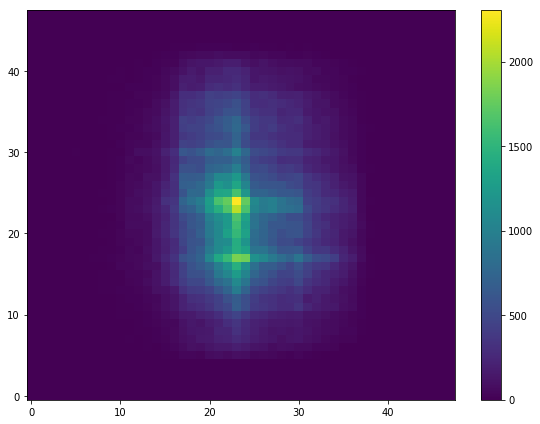

Current= -19.263
Files used: ['CG4B3347.dat', 'CG4B3348.dat', 'CG4B3349.dat', 'CG4B3350.dat', 'CG4B3351.dat', 'CG4B3352.dat', 'CG4B3353.dat', 'CG4B3354.dat', 'CG4B3355.dat', 'CG4B3356.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  371993.7317073175


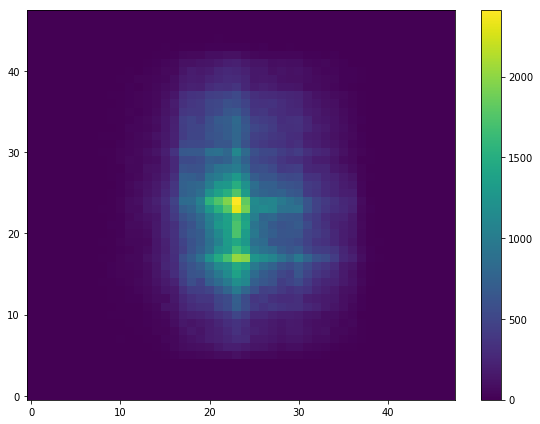

Current= -19.25
Files used: ['CG4B3357.dat', 'CG4B3358.dat', 'CG4B3359.dat', 'CG4B3360.dat', 'CG4B3361.dat', 'CG4B3362.dat', 'CG4B3363.dat', 'CG4B3364.dat', 'CG4B3365.dat', 'CG4B3366.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  398769.23200475954


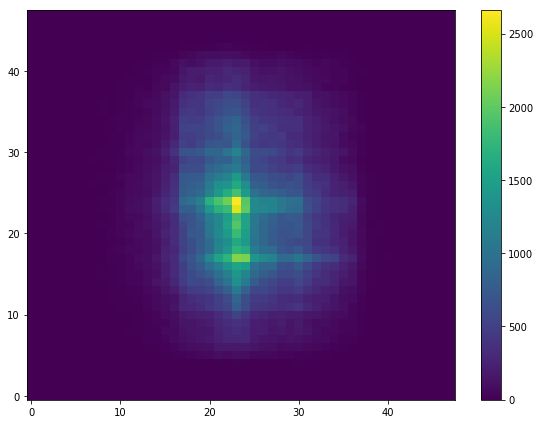

Current= -19.238
Files used: ['CG4B3367.dat', 'CG4B3368.dat', 'CG4B3369.dat', 'CG4B3370.dat', 'CG4B3371.dat', 'CG4B3372.dat', 'CG4B3373.dat', 'CG4B3374.dat', 'CG4B3375.dat', 'CG4B3376.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  422789.25163593126


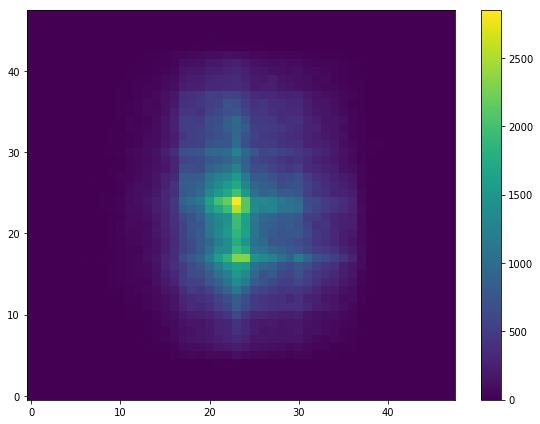

Current= -19.225
Files used: ['CG4B3377.dat', 'CG4B3378.dat', 'CG4B3379.dat', 'CG4B3380.dat', 'CG4B3381.dat', 'CG4B3382.dat', 'CG4B3383.dat', 'CG4B3384.dat', 'CG4B3385.dat', 'CG4B3386.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  438319.79119571677


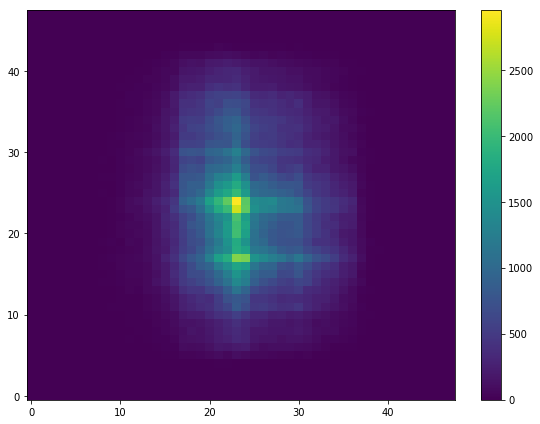

Current= -19.213
Files used: ['CG4B3387.dat', 'CG4B3388.dat', 'CG4B3389.dat', 'CG4B3390.dat', 'CG4B3391.dat', 'CG4B3392.dat', 'CG4B3393.dat', 'CG4B3394.dat', 'CG4B3395.dat', 'CG4B3396.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  446574.62224866106


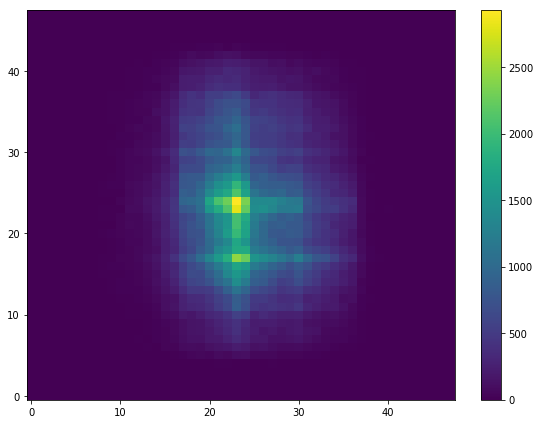

Current= -19.2
Files used: ['CG4B3397.dat', 'CG4B3398.dat', 'CG4B3399.dat', 'CG4B3400.dat', 'CG4B3401.dat', 'CG4B3402.dat', 'CG4B3403.dat', 'CG4B3404.dat', 'CG4B3405.dat', 'CG4B3406.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  445444.8744794764


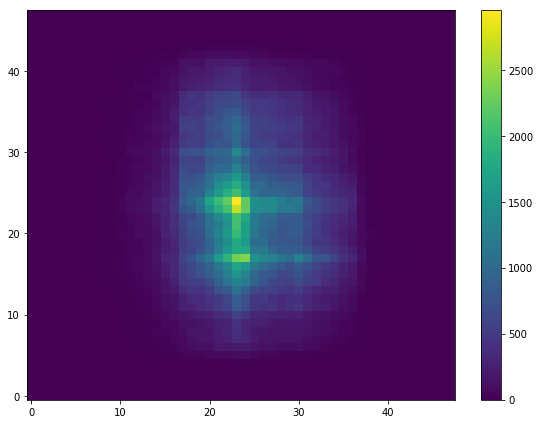

Current= -19.188
Files used: ['CG4B3407.dat', 'CG4B3408.dat', 'CG4B3409.dat', 'CG4B3410.dat', 'CG4B3411.dat', 'CG4B3412.dat', 'CG4B3413.dat', 'CG4B3414.dat', 'CG4B3415.dat', 'CG4B3416.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  437309.2207019633


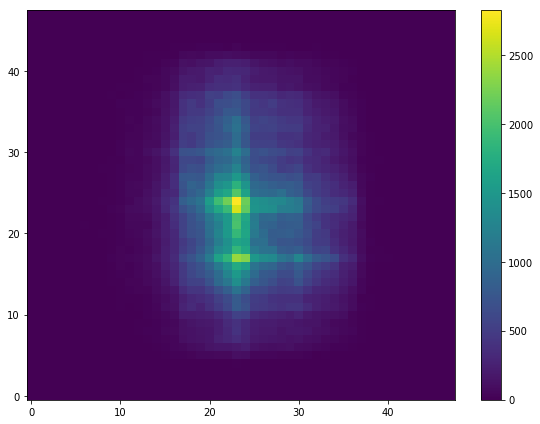

Current= -19.175
Files used: ['CG4B3417.dat', 'CG4B3418.dat', 'CG4B3419.dat', 'CG4B3420.dat', 'CG4B3421.dat', 'CG4B3422.dat', 'CG4B3423.dat', 'CG4B3424.dat', 'CG4B3425.dat', 'CG4B3426.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  420022.04521118436


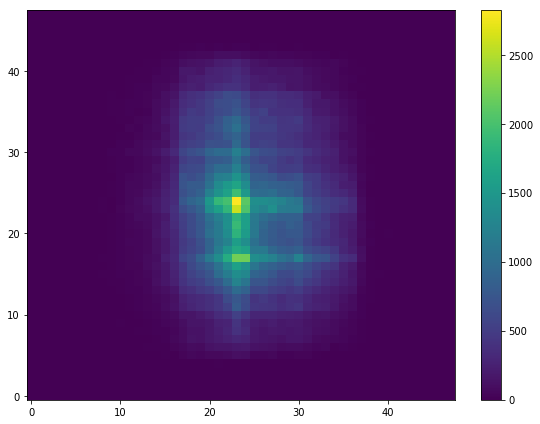

Current= -19.163
Files used: ['CG4B3427.dat', 'CG4B3428.dat', 'CG4B3429.dat', 'CG4B3430.dat', 'CG4B3431.dat', 'CG4B3432.dat', 'CG4B3433.dat', 'CG4B3434.dat', 'CG4B3435.dat', 'CG4B3436.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  395105.90481856023


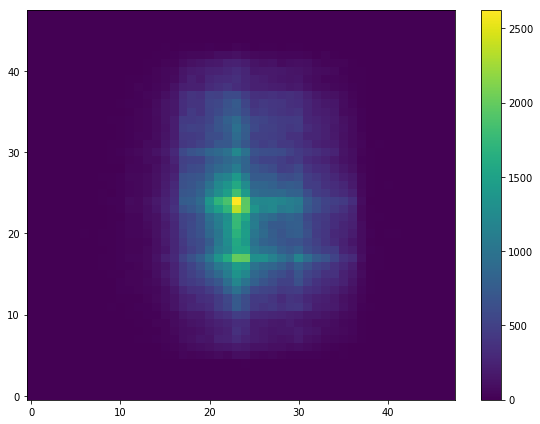

Current= -19.15
Files used: ['CG4B3437.dat', 'CG4B3438.dat', 'CG4B3439.dat', 'CG4B3440.dat', 'CG4B3441.dat', 'CG4B3442.dat', 'CG4B3443.dat', 'CG4B3444.dat', 'CG4B3445.dat', 'CG4B3446.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  363993.56930398586


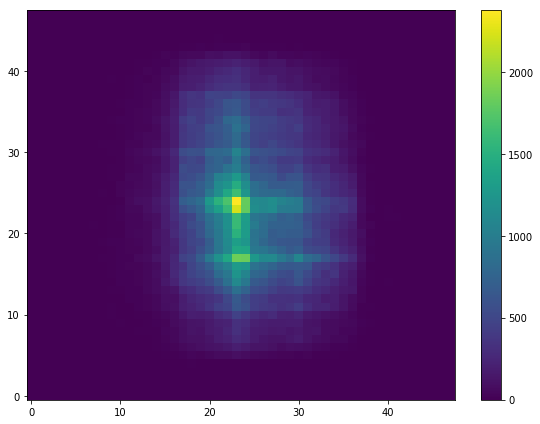

Current= -19.138
Files used: ['CG4B3447.dat', 'CG4B3448.dat', 'CG4B3449.dat', 'CG4B3450.dat', 'CG4B3451.dat', 'CG4B3452.dat', 'CG4B3453.dat', 'CG4B3454.dat', 'CG4B3455.dat', 'CG4B3456.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  330841.2795954786


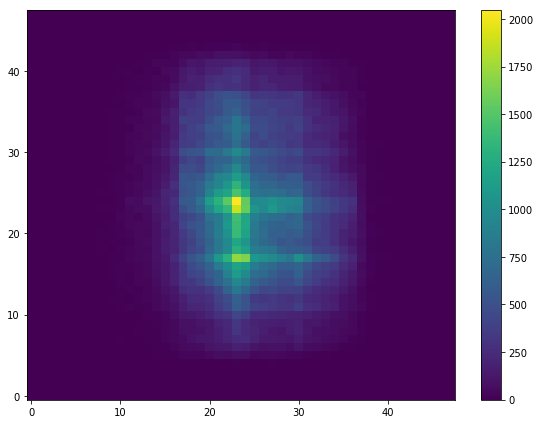

Current= -19.125
Files used: ['CG4B3457.dat', 'CG4B3458.dat', 'CG4B3459.dat', 'CG4B3460.dat', 'CG4B3461.dat', 'CG4B3462.dat', 'CG4B3463.dat', 'CG4B3464.dat', 'CG4B3465.dat', 'CG4B3466.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  293519.85187388444


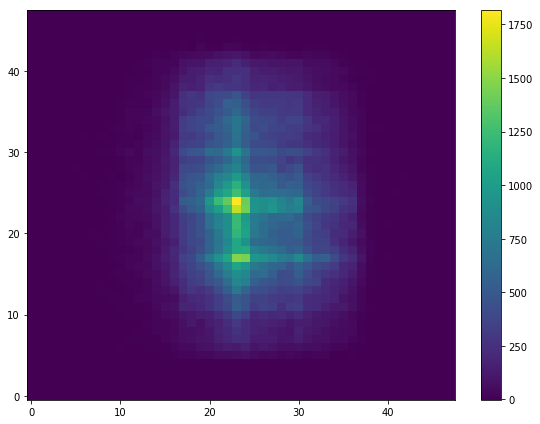

Current= -19.113
Files used: ['CG4B3467.dat', 'CG4B3468.dat', 'CG4B3469.dat', 'CG4B3470.dat', 'CG4B3471.dat', 'CG4B3472.dat', 'CG4B3473.dat', 'CG4B3474.dat', 'CG4B3475.dat', 'CG4B3476.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  254441.96787626398


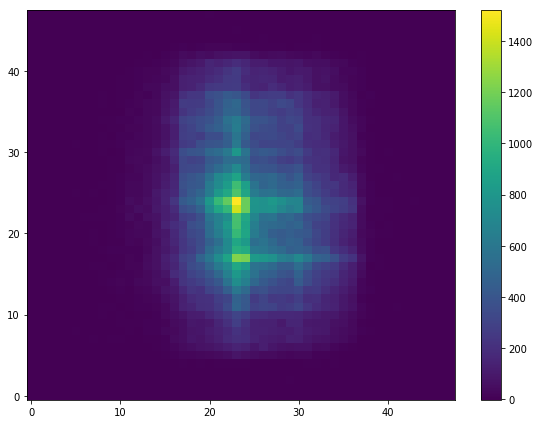

Current= -19.1
Files used: ['CG4B3477.dat', 'CG4B3478.dat', 'CG4B3479.dat', 'CG4B3480.dat', 'CG4B3481.dat', 'CG4B3482.dat', 'CG4B3483.dat', 'CG4B3484.dat', 'CG4B3485.dat', 'CG4B3486.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  216399.9042236761


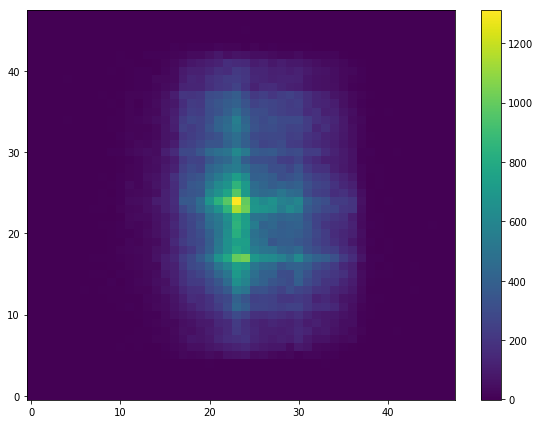

Current= -19.088
Files used: ['CG4B3487.dat', 'CG4B3488.dat', 'CG4B3489.dat', 'CG4B3490.dat', 'CG4B3491.dat', 'CG4B3492.dat', 'CG4B3493.dat', 'CG4B3494.dat', 'CG4B3495.dat', 'CG4B3496.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  179355.9744199882


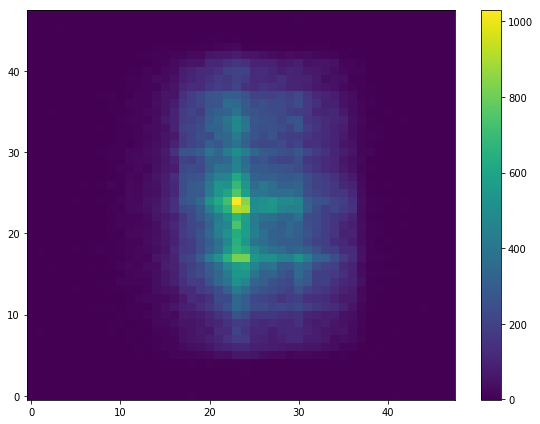

Current= -19.075
Files used: ['CG4B3497.dat', 'CG4B3498.dat', 'CG4B3499.dat', 'CG4B3500.dat', 'CG4B3501.dat', 'CG4B3502.dat', 'CG4B3503.dat', 'CG4B3504.dat', 'CG4B3505.dat', 'CG4B3506.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  145004.78346222505


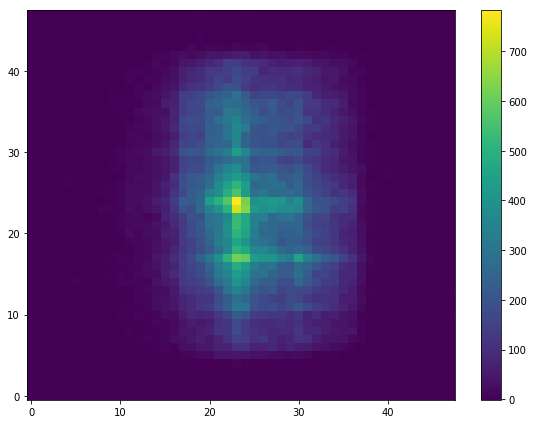

Current= -19.063
Files used: ['CG4B3507.dat', 'CG4B3508.dat', 'CG4B3509.dat', 'CG4B3510.dat', 'CG4B3511.dat', 'CG4B3512.dat', 'CG4B3513.dat', 'CG4B3514.dat', 'CG4B3515.dat', 'CG4B3516.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  116387.05532421185


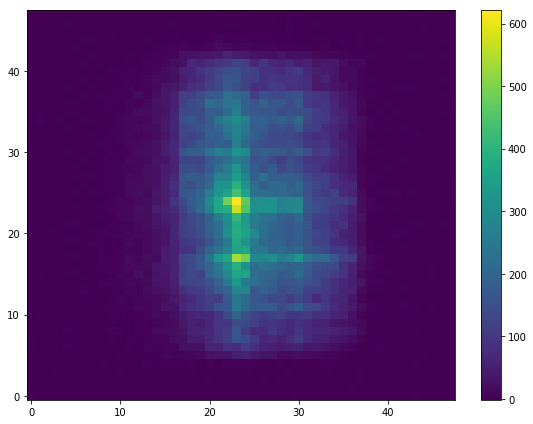

Current= -19.05
Files used: ['CG4B3517.dat', 'CG4B3518.dat', 'CG4B3519.dat', 'CG4B3520.dat', 'CG4B3521.dat', 'CG4B3522.dat', 'CG4B3523.dat', 'CG4B3524.dat', 'CG4B3525.dat', 'CG4B3526.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  91316.28554431871


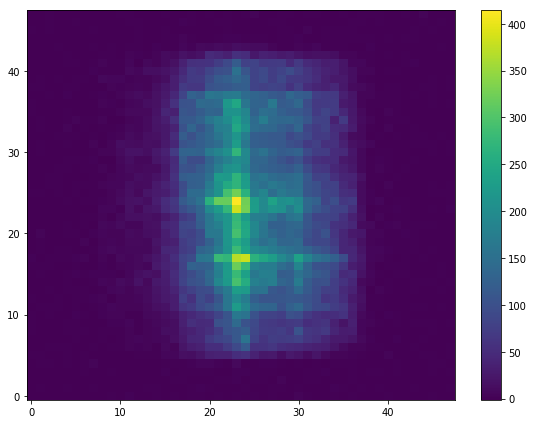

Current= -19.038
Files used: ['CG4B3527.dat', 'CG4B3528.dat', 'CG4B3529.dat', 'CG4B3530.dat', 'CG4B3531.dat', 'CG4B3532.dat', 'CG4B3533.dat', 'CG4B3534.dat', 'CG4B3535.dat', 'CG4B3536.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  71914.78108268885


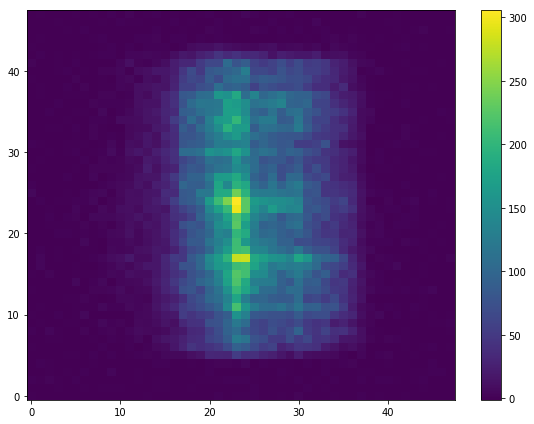

Current= -19.025
Files used: ['CG4B3537.dat', 'CG4B3538.dat', 'CG4B3539.dat', 'CG4B3540.dat', 'CG4B3541.dat', 'CG4B3542.dat', 'CG4B3543.dat', 'CG4B3544.dat', 'CG4B3545.dat', 'CG4B3546.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  56465.08804283157


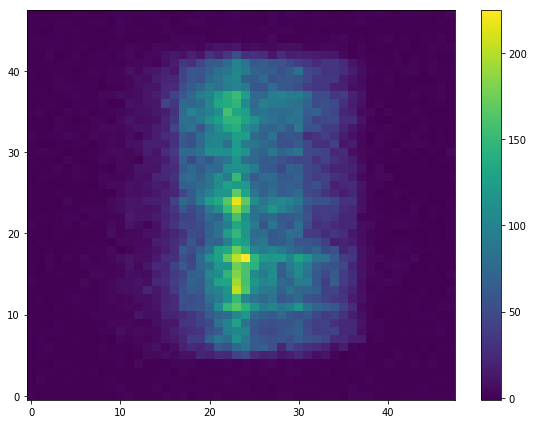

Current= -19.013
Files used: ['CG4B3547.dat', 'CG4B3548.dat', 'CG4B3549.dat', 'CG4B3550.dat', 'CG4B3551.dat', 'CG4B3552.dat', 'CG4B3553.dat', 'CG4B3554.dat', 'CG4B3555.dat', 'CG4B3556.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  45519.67578822129


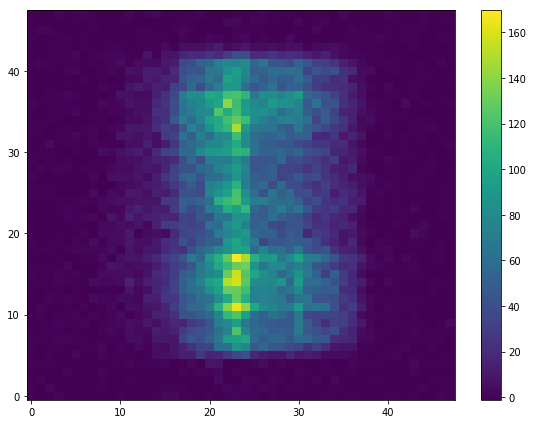

Current= -19.0
Files used: ['CG4B3557.dat', 'CG4B3558.dat', 'CG4B3559.dat', 'CG4B3560.dat', 'CG4B3561.dat', 'CG4B3562.dat', 'CG4B3563.dat', 'CG4B3564.dat', 'CG4B3565.dat', 'CG4B3566.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  39158.87091017249


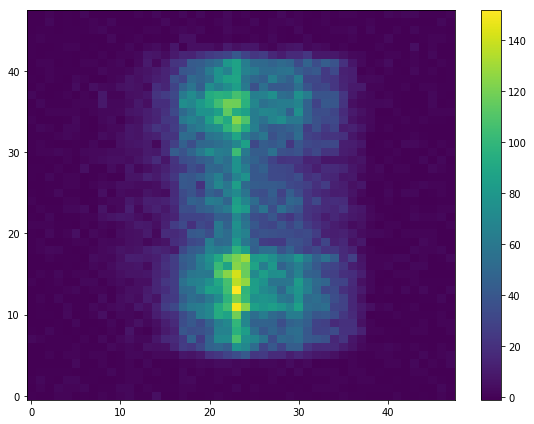


 Peak counts:  446574.62224866106 
 Current:  -19.213 


 Trough counts:  35082.57703747772 
 Current:  -19.45 



In [20]:
#RF2 on
#b1 scan, b1 = 19.55, nutator1 =-5
zero_counts = []    #add all subscans that are zero counts here

currents = np.arange(-19.55,-19.,.0125)
print("Currents used: ", currents, " \n Total=", len(currents), "\n")
low_counts = []
low_totals = []
start = 3117
subscans = 10

for i in range(len(currents)):
    print("Current=", round(currents[i],3))
    if ((start + (subscans - 1) + int(i)*subscans) not in zero_counts):
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans, \
                          print_summed=True, print_fnames=True)
        low_counts.append(run[0])
        low_totals.append(run[1])
    else: 
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans - 1, \
                          print_summed=True, print_fnames=True)
        low_counts.append(run[0])
        low_totals.append(run[1])
        print("Warning: one subscan failed!")

Peak_l = max(low_totals)
Trough_l = min(low_totals)
Peak_current_l = np.argmax(low_totals)
Trough_current_l = np.argmin(low_totals)

print("\n Peak counts: ", Peak_l, "\n Current: ", round(currents[Peak_current_l],3), "\n")
print("\n Trough counts: ", Trough_l, "\n Current: ", round(currents[Trough_current_l],3), "\n")


Logbook above, test area below

Currents used:  [-19.55   -19.5375 -19.525  -19.5125 -19.5    -19.4875 -19.475  -19.4625
 -19.45   -19.4375 -19.425  -19.4125 -19.4    -19.3875 -19.375  -19.3625
 -19.35   -19.3375 -19.325  -19.3125 -19.3    -19.2875 -19.275  -19.2625
 -19.25   -19.2375 -19.225  -19.2125 -19.2    -19.1875 -19.175  -19.1625
 -19.15   -19.1375 -19.125  -19.1125 -19.1    -19.0875 -19.075  -19.0625
 -19.05   -19.0375 -19.025  -19.0125 -19.    ]  
 Total= 45 

Current= -19.55
Files used: ['CG4B2557.dat', 'CG4B2558.dat', 'CG4B2559.dat', 'CG4B2560.dat', 'CG4B2561.dat', 'CG4B2562.dat', 'CG4B2563.dat', 'CG4B2564.dat', 'CG4B2565.dat', 'CG4B2566.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1740269.2676978013


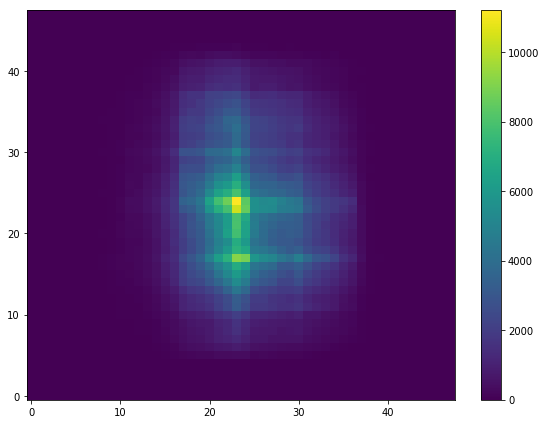

Current= -19.538
Files used: ['CG4B2567.dat', 'CG4B2568.dat', 'CG4B2569.dat', 'CG4B2570.dat', 'CG4B2571.dat', 'CG4B2572.dat', 'CG4B2573.dat', 'CG4B2574.dat', 'CG4B2575.dat', 'CG4B2576.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1746359.1844140412


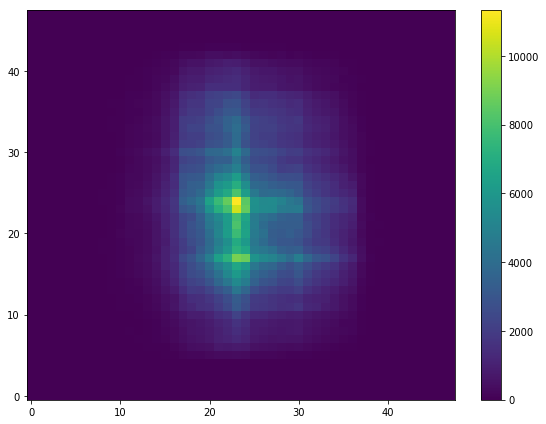

Current= -19.525
Files used: ['CG4B2577.dat', 'CG4B2578.dat', 'CG4B2579.dat', 'CG4B2580.dat', 'CG4B2581.dat', 'CG4B2582.dat', 'CG4B2583.dat', 'CG4B2584.dat', 'CG4B2585.dat', 'CG4B2586.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1753220.3884592517


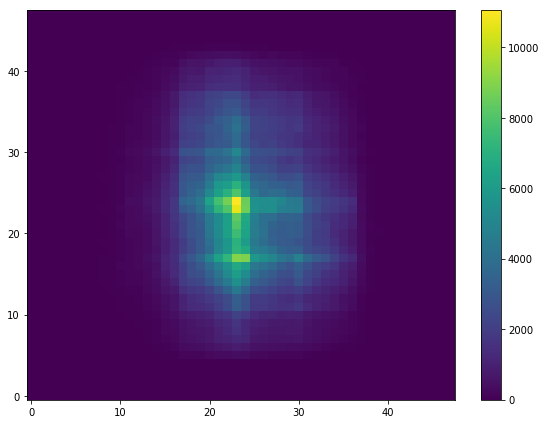

Current= -19.513
Files used: ['CG4B2587.dat', 'CG4B2588.dat', 'CG4B2589.dat', 'CG4B2590.dat', 'CG4B2591.dat', 'CG4B2592.dat', 'CG4B2593.dat', 'CG4B2594.dat', 'CG4B2595.dat', 'CG4B2596.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1757782.9232599651


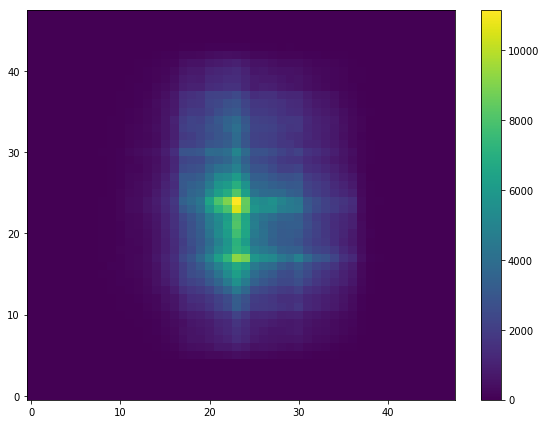

Current= -19.5
Files used: ['CG4B2597.dat', 'CG4B2598.dat', 'CG4B2599.dat', 'CG4B2600.dat', 'CG4B2601.dat', 'CG4B2602.dat', 'CG4B2603.dat', 'CG4B2604.dat', 'CG4B2605.dat', 'CG4B2606.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1766320.355145745


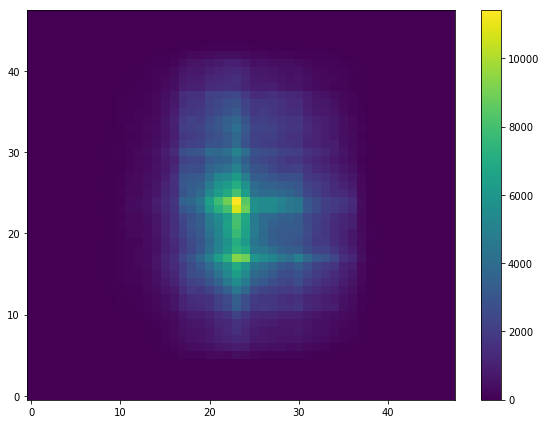

Current= -19.488
Files used: ['CG4B2607.dat', 'CG4B2608.dat', 'CG4B2609.dat', 'CG4B2610.dat', 'CG4B2611.dat', 'CG4B2612.dat', 'CG4B2613.dat', 'CG4B2614.dat', 'CG4B2615.dat', 'CG4B2616.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1763119.5038667466


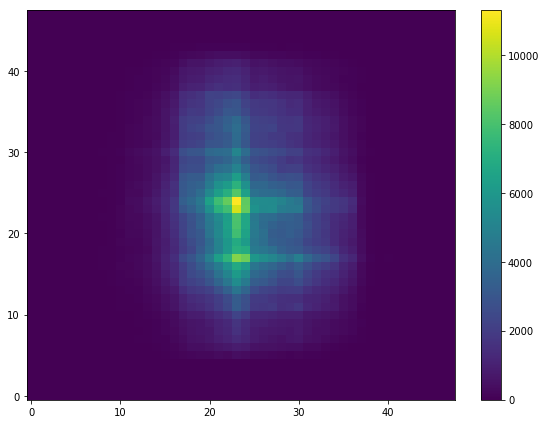

Current= -19.475
Files used: ['CG4B2617.dat', 'CG4B2618.dat', 'CG4B2619.dat', 'CG4B2620.dat', 'CG4B2621.dat', 'CG4B2622.dat', 'CG4B2623.dat', 'CG4B2624.dat', 'CG4B2625.dat', 'CG4B2626.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1760255.8352171327


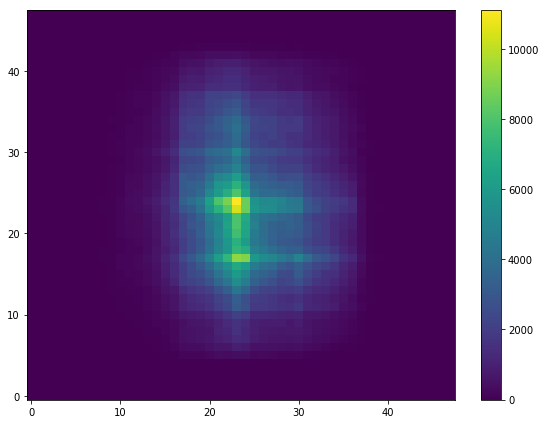

Current= -19.463
Files used: ['CG4B2627.dat', 'CG4B2628.dat', 'CG4B2629.dat', 'CG4B2630.dat', 'CG4B2631.dat', 'CG4B2632.dat', 'CG4B2633.dat', 'CG4B2634.dat', 'CG4B2635.dat', 'CG4B2636.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1742273.5169541962


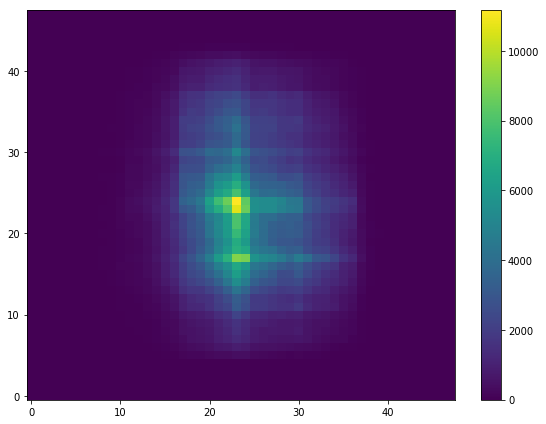

Current= -19.45
Files used: ['CG4B2637.dat', 'CG4B2638.dat', 'CG4B2639.dat', 'CG4B2640.dat', 'CG4B2641.dat', 'CG4B2642.dat', 'CG4B2643.dat', 'CG4B2644.dat', 'CG4B2645.dat', 'CG4B2646.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1719142.821534799


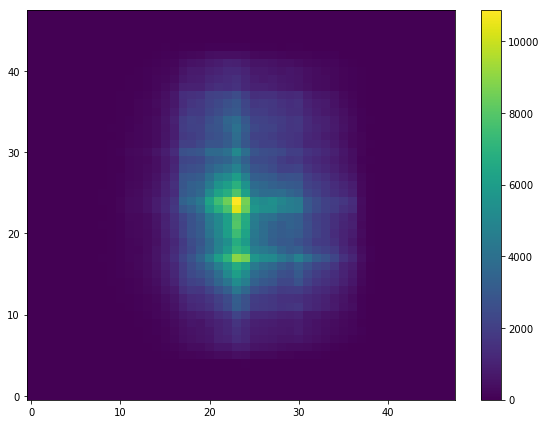

Current= -19.438
Files used: ['CG4B2647.dat', 'CG4B2648.dat', 'CG4B2649.dat', 'CG4B2650.dat', 'CG4B2651.dat', 'CG4B2652.dat', 'CG4B2653.dat', 'CG4B2654.dat', 'CG4B2655.dat', 'CG4B2656.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1676268.4598453296


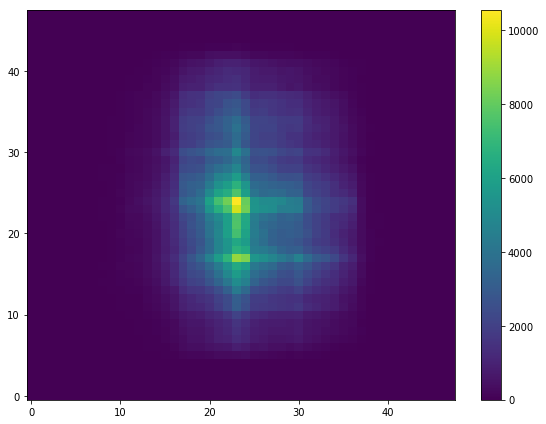

Current= -19.425
Files used: ['CG4B2657.dat', 'CG4B2658.dat', 'CG4B2659.dat', 'CG4B2660.dat', 'CG4B2661.dat', 'CG4B2662.dat', 'CG4B2663.dat', 'CG4B2664.dat', 'CG4B2665.dat', 'CG4B2666.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1619357.3521713268


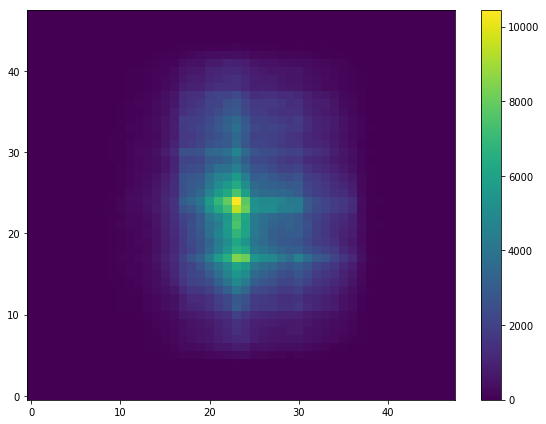

Current= -19.413
Files used: ['CG4B2667.dat', 'CG4B2668.dat', 'CG4B2669.dat', 'CG4B2670.dat', 'CG4B2671.dat', 'CG4B2672.dat', 'CG4B2673.dat', 'CG4B2674.dat', 'CG4B2675.dat', 'CG4B2676.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1546587.1017251634


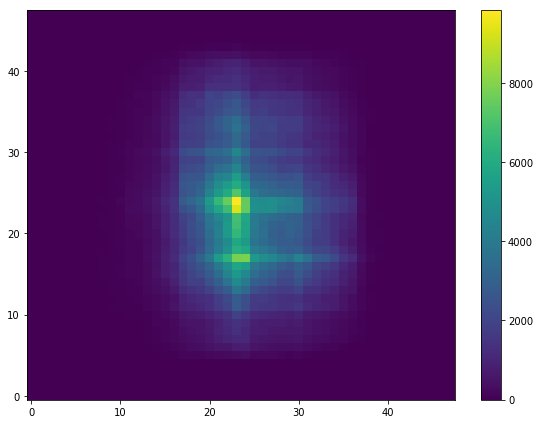

Current= -19.4
Files used: ['CG4B2677.dat', 'CG4B2678.dat', 'CG4B2679.dat', 'CG4B2680.dat', 'CG4B2681.dat', 'CG4B2682.dat', 'CG4B2683.dat', 'CG4B2684.dat', 'CG4B2685.dat', 'CG4B2686.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1462082.7459845324


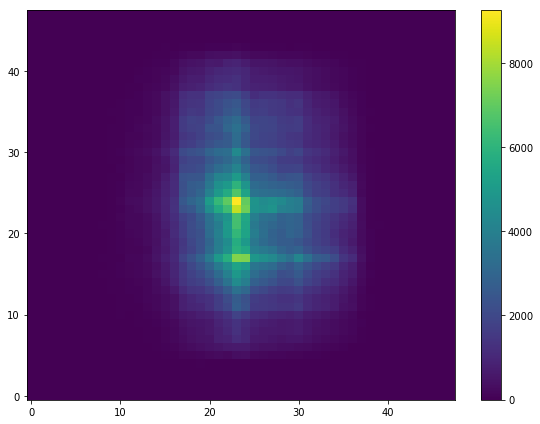

Current= -19.388
Files used: ['CG4B2687.dat', 'CG4B2688.dat', 'CG4B2689.dat', 'CG4B2690.dat', 'CG4B2691.dat', 'CG4B2692.dat', 'CG4B2693.dat', 'CG4B2694.dat', 'CG4B2695.dat', 'CG4B2696.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1348992.58774539


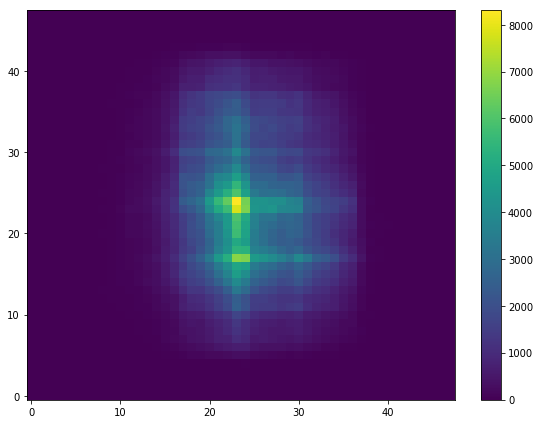

Current= -19.375
Files used: ['CG4B2697.dat', 'CG4B2698.dat', 'CG4B2699.dat', 'CG4B2700.dat', 'CG4B2701.dat', 'CG4B2702.dat', 'CG4B2703.dat', 'CG4B2704.dat', 'CG4B2705.dat', 'CG4B2706.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1230378.3878643685


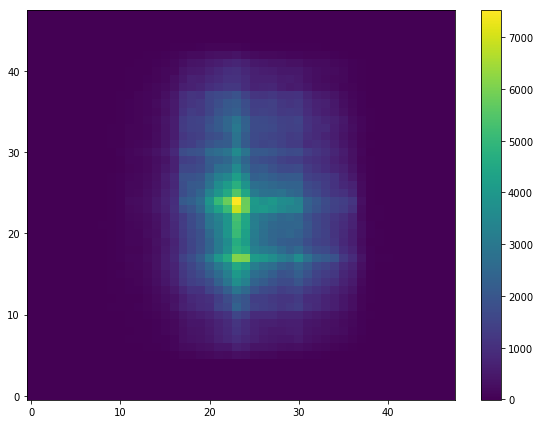

Current= -19.363
Files used: ['CG4B2707.dat', 'CG4B2708.dat', 'CG4B2709.dat', 'CG4B2710.dat', 'CG4B2711.dat', 'CG4B2712.dat', 'CG4B2713.dat', 'CG4B2714.dat', 'CG4B2715.dat', 'CG4B2716.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1102799.8019036292


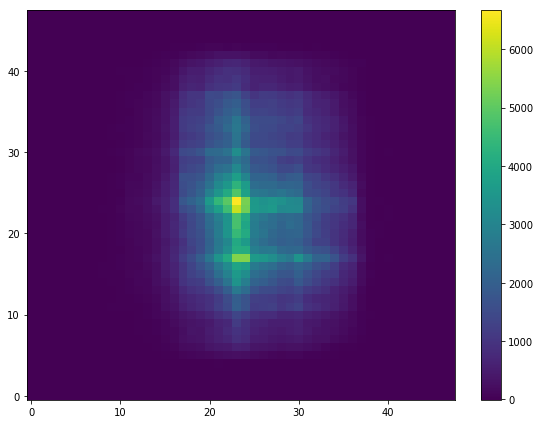

Current= -19.35
Files used: ['CG4B2717.dat', 'CG4B2718.dat', 'CG4B2719.dat', 'CG4B2720.dat', 'CG4B2721.dat', 'CG4B2722.dat', 'CG4B2723.dat', 'CG4B2724.dat', 'CG4B2725.dat', 'CG4B2726.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  954929.5496728136


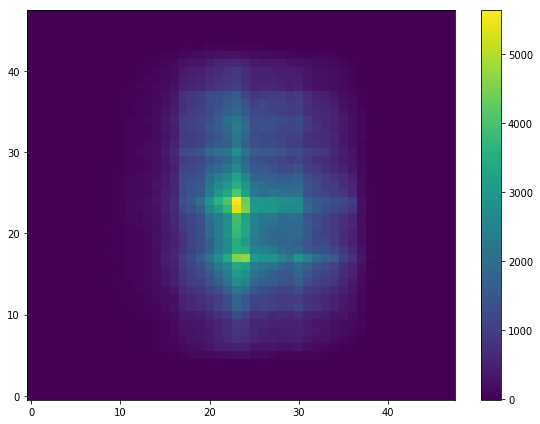

Current= -19.338
Files used: ['CG4B2727.dat', 'CG4B2728.dat', 'CG4B2729.dat', 'CG4B2730.dat', 'CG4B2731.dat', 'CG4B2732.dat', 'CG4B2733.dat', 'CG4B2734.dat', 'CG4B2735.dat', 'CG4B2736.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  813972.5490779296


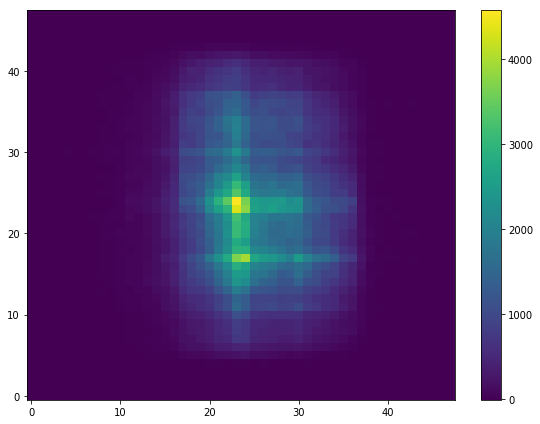

Current= -19.325
Files used: ['CG4B2737.dat', 'CG4B2738.dat', 'CG4B2739.dat', 'CG4B2740.dat', 'CG4B2741.dat', 'CG4B2742.dat', 'CG4B2743.dat', 'CG4B2744.dat', 'CG4B2745.dat', 'CG4B2746.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  679338.9256395004


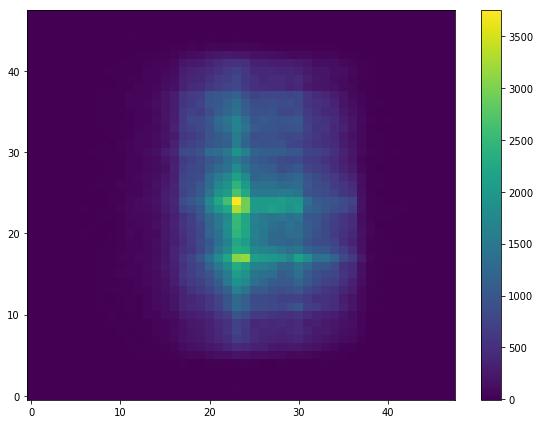

Current= -19.313
Files used: ['CG4B2747.dat', 'CG4B2748.dat', 'CG4B2749.dat', 'CG4B2750.dat', 'CG4B2751.dat', 'CG4B2752.dat', 'CG4B2753.dat', 'CG4B2754.dat', 'CG4B2755.dat', 'CG4B2756.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  531287.1338489004


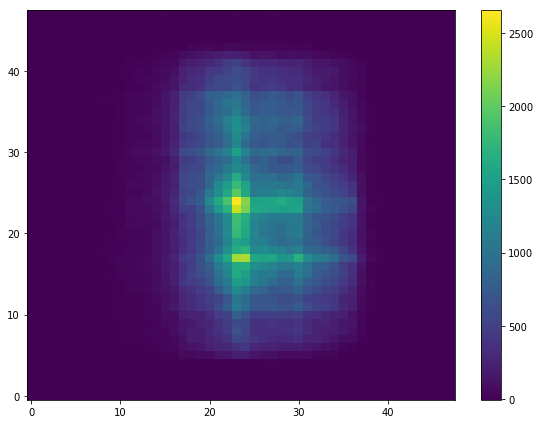

Current= -19.3
Files used: ['CG4B2757.dat', 'CG4B2758.dat', 'CG4B2759.dat', 'CG4B2760.dat', 'CG4B2761.dat', 'CG4B2762.dat', 'CG4B2763.dat', 'CG4B2764.dat', 'CG4B2765.dat', 'CG4B2766.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  406633.7519333733


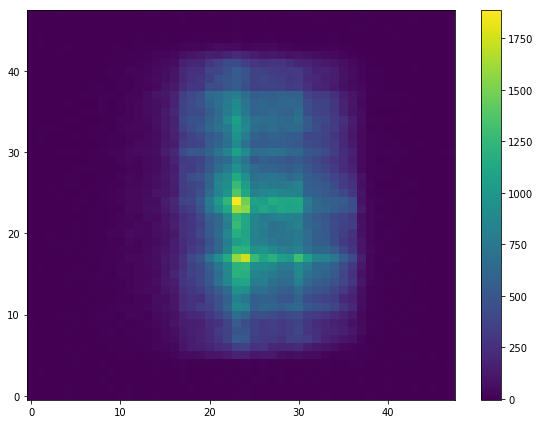

Current= -19.288
Files used: ['CG4B2767.dat', 'CG4B2768.dat', 'CG4B2769.dat', 'CG4B2770.dat', 'CG4B2771.dat', 'CG4B2772.dat', 'CG4B2773.dat', 'CG4B2774.dat', 'CG4B2775.dat', 'CG4B2776.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  308427.4271267103


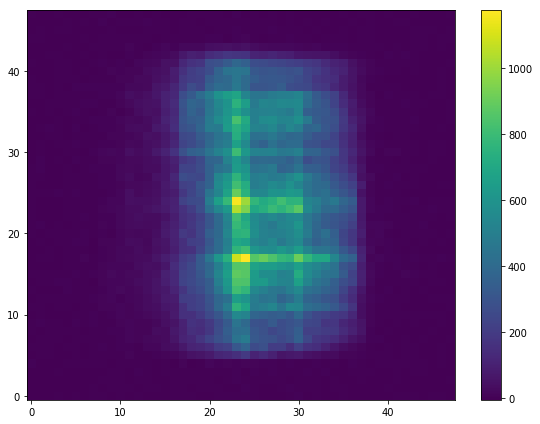

Current= -19.275
Files used: ['CG4B2777.dat', 'CG4B2778.dat', 'CG4B2779.dat', 'CG4B2780.dat', 'CG4B2781.dat', 'CG4B2782.dat', 'CG4B2783.dat', 'CG4B2784.dat', 'CG4B2785.dat', 'CG4B2786.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  227116.93158834014


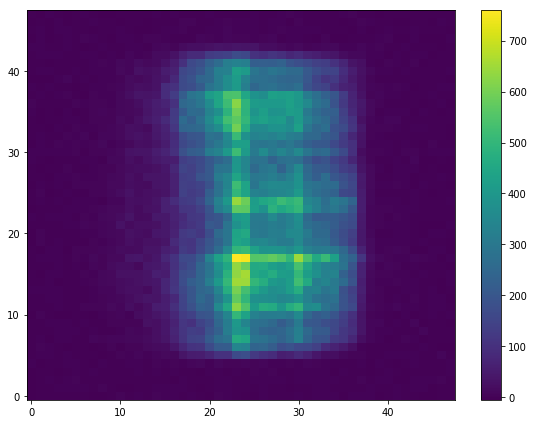

Current= -19.263
Files used: ['CG4B2787.dat', 'CG4B2788.dat', 'CG4B2789.dat', 'CG4B2790.dat', 'CG4B2791.dat', 'CG4B2792.dat', 'CG4B2793.dat', 'CG4B2794.dat', 'CG4B2795.dat', 'CG4B2796.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  179029.20345032724


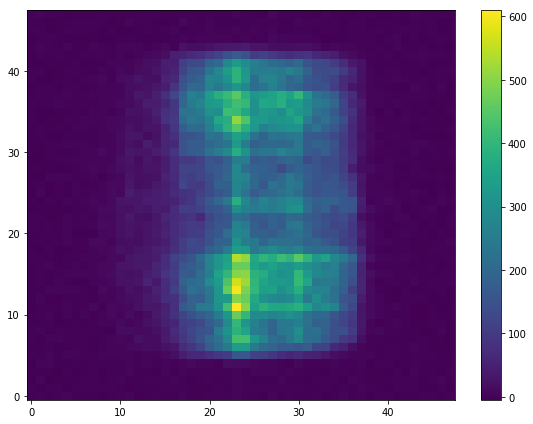

Current= -19.25
Files used: ['CG4B2797.dat', 'CG4B2798.dat', 'CG4B2799.dat', 'CG4B2800.dat', 'CG4B2801.dat', 'CG4B2802.dat', 'CG4B2803.dat', 'CG4B2804.dat', 'CG4B2805.dat', 'CG4B2806.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  163855.5871505055


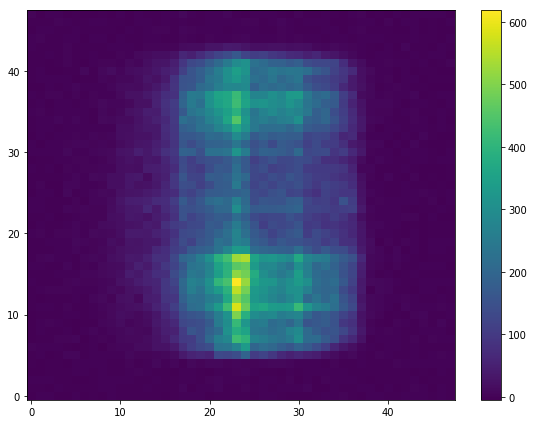

Current= -19.238
Files used: ['CG4B2807.dat', 'CG4B2808.dat', 'CG4B2809.dat', 'CG4B2810.dat', 'CG4B2811.dat', 'CG4B2812.dat', 'CG4B2813.dat', 'CG4B2814.dat', 'CG4B2815.dat', 'CG4B2816.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  181936.85484830465


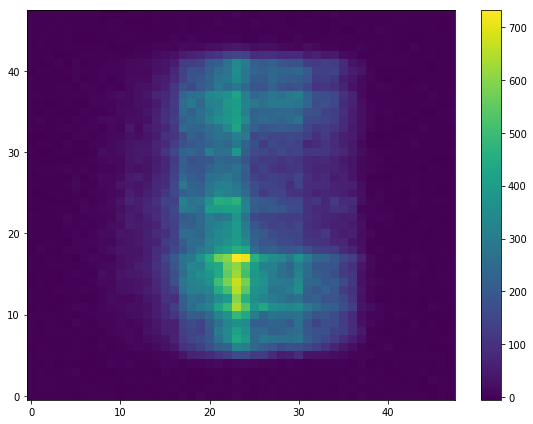

Current= -19.225
Files used: ['CG4B2817.dat', 'CG4B2818.dat', 'CG4B2819.dat', 'CG4B2820.dat', 'CG4B2821.dat', 'CG4B2822.dat', 'CG4B2823.dat', 'CG4B2824.dat', 'CG4B2825.dat', 'CG4B2826.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  231766.19274241533


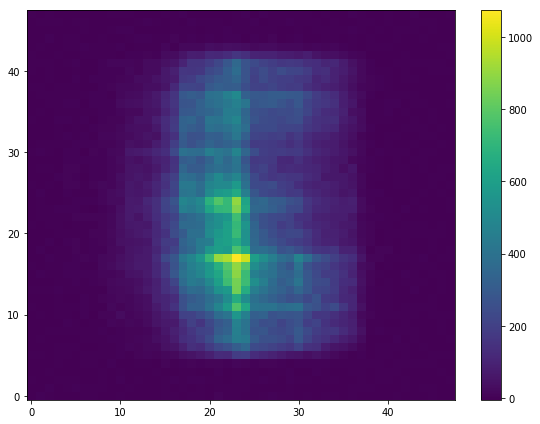

Current= -19.213
Files used: ['CG4B2827.dat', 'CG4B2828.dat', 'CG4B2829.dat', 'CG4B2830.dat', 'CG4B2831.dat', 'CG4B2832.dat', 'CG4B2833.dat', 'CG4B2834.dat', 'CG4B2835.dat', 'CG4B2836.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  309416.8947055323


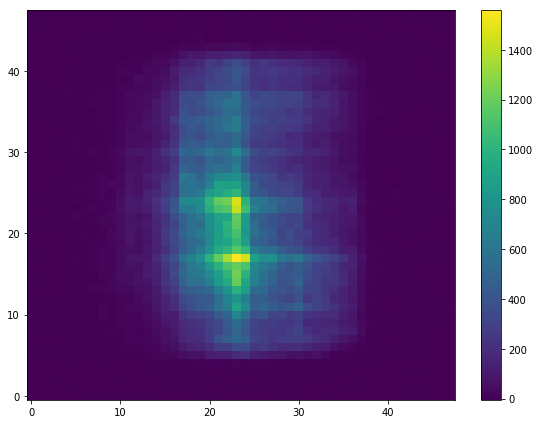

Current= -19.2
Files used: ['CG4B2837.dat', 'CG4B2838.dat', 'CG4B2839.dat', 'CG4B2840.dat', 'CG4B2841.dat', 'CG4B2842.dat', 'CG4B2843.dat', 'CG4B2844.dat', 'CG4B2845.dat', 'CG4B2846.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  414815.1344437835


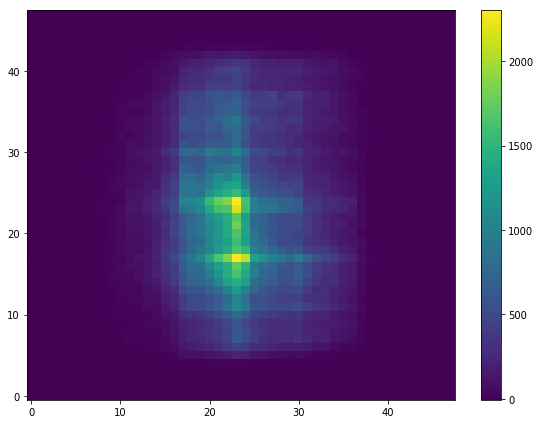

Current= -19.188
Files used: ['CG4B2847.dat', 'CG4B2848.dat', 'CG4B2849.dat', 'CG4B2850.dat', 'CG4B2851.dat', 'CG4B2852.dat', 'CG4B2853.dat', 'CG4B2854.dat', 'CG4B2855.dat', 'CG4B2856.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  540359.1701368237


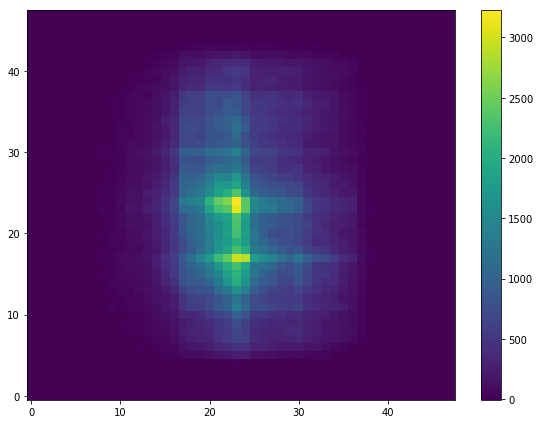

Current= -19.175
Files used: ['CG4B2857.dat', 'CG4B2858.dat', 'CG4B2859.dat', 'CG4B2860.dat', 'CG4B2861.dat', 'CG4B2862.dat', 'CG4B2863.dat', 'CG4B2864.dat', 'CG4B2865.dat', 'CG4B2866.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  678157.7317073172


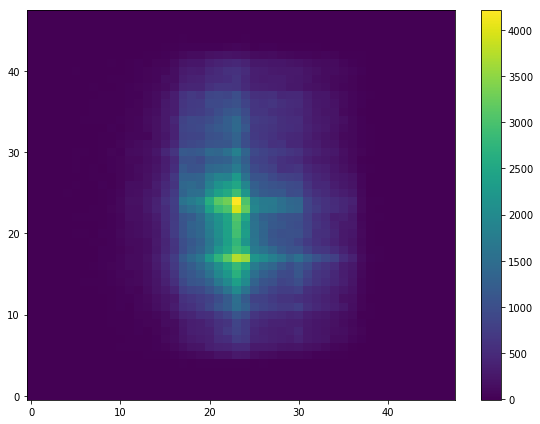

Current= -19.163
Files used: ['CG4B2867.dat', 'CG4B2868.dat', 'CG4B2869.dat', 'CG4B2870.dat', 'CG4B2871.dat', 'CG4B2872.dat', 'CG4B2873.dat', 'CG4B2874.dat', 'CG4B2875.dat', 'CG4B2876.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  835915.7209994035


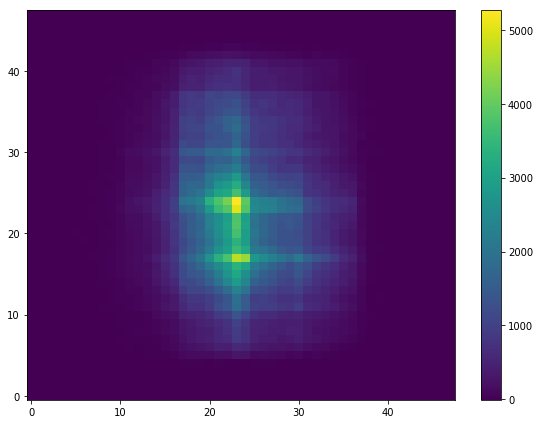

Current= -19.15
Files used: ['CG4B2877.dat', 'CG4B2878.dat', 'CG4B2879.dat', 'CG4B2880.dat', 'CG4B2881.dat', 'CG4B2882.dat', 'CG4B2883.dat', 'CG4B2884.dat', 'CG4B2885.dat', 'CG4B2886.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  990567.0422367641


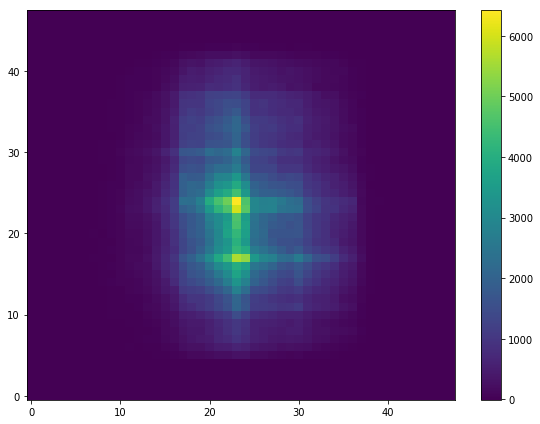

Current= -19.138
Files used: ['CG4B2887.dat', 'CG4B2888.dat', 'CG4B2889.dat', 'CG4B2890.dat', 'CG4B2891.dat', 'CG4B2892.dat', 'CG4B2893.dat', 'CG4B2894.dat', 'CG4B2895.dat', 'CG4B2896.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1136457.5776323616


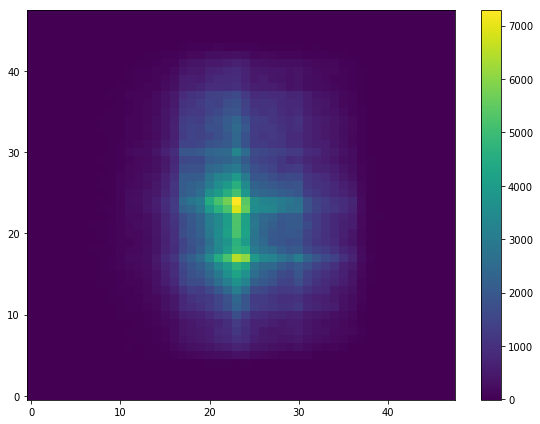

Current= -19.125
Files used: ['CG4B2897.dat', 'CG4B2898.dat', 'CG4B2899.dat', 'CG4B2900.dat', 'CG4B2901.dat', 'CG4B2902.dat', 'CG4B2903.dat', 'CG4B2904.dat', 'CG4B2905.dat', 'CG4B2906.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1274916.4003569302


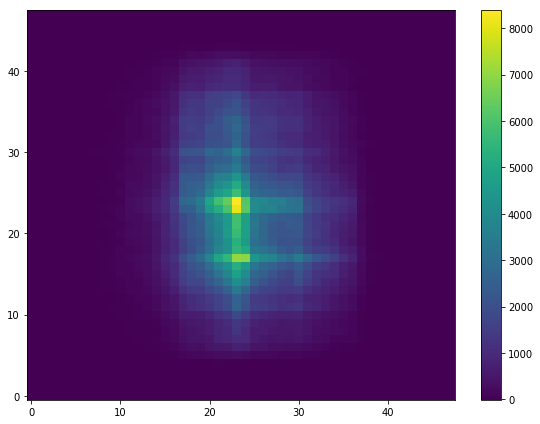

Current= -19.113
Files used: ['CG4B2907.dat', 'CG4B2908.dat', 'CG4B2909.dat', 'CG4B2910.dat', 'CG4B2911.dat', 'CG4B2912.dat', 'CG4B2913.dat', 'CG4B2914.dat', 'CG4B2915.dat', 'CG4B2916.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1401545.6549672815


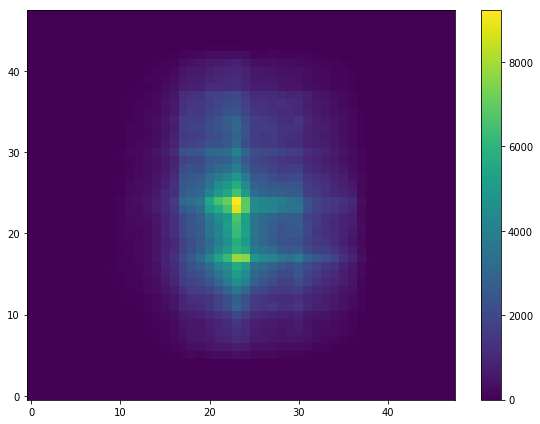

Current= -19.1
Files used: ['CG4B2917.dat', 'CG4B2918.dat', 'CG4B2919.dat', 'CG4B2920.dat', 'CG4B2921.dat', 'CG4B2922.dat', 'CG4B2923.dat', 'CG4B2924.dat', 'CG4B2925.dat', 'CG4B2926.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1508848.0101130295


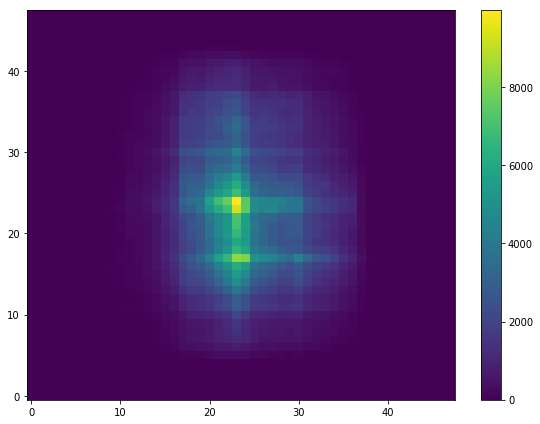

Current= -19.088
Files used: ['CG4B2927.dat', 'CG4B2928.dat', 'CG4B2929.dat', 'CG4B2930.dat', 'CG4B2931.dat', 'CG4B2932.dat', 'CG4B2933.dat', 'CG4B2934.dat', 'CG4B2935.dat', 'CG4B2936.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1596682.5871505057


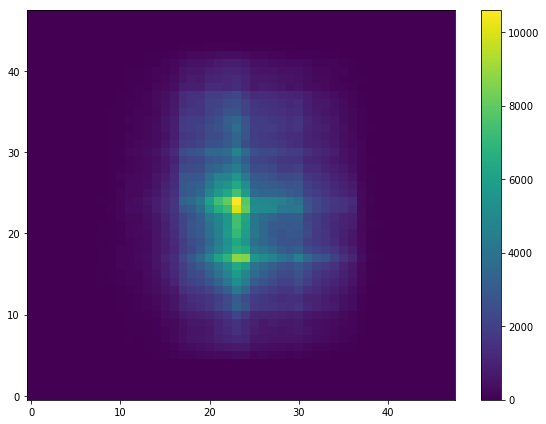

Current= -19.075
Files used: ['CG4B2937.dat', 'CG4B2938.dat', 'CG4B2939.dat', 'CG4B2940.dat', 'CG4B2941.dat', 'CG4B2942.dat', 'CG4B2943.dat', 'CG4B2944.dat', 'CG4B2945.dat', 'CG4B2946.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1664641.3789411066


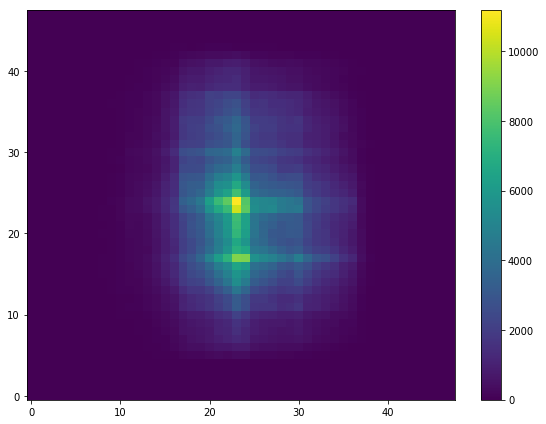

Current= -19.063
Files used: ['CG4B2947.dat', 'CG4B2948.dat', 'CG4B2949.dat', 'CG4B2950.dat', 'CG4B2951.dat', 'CG4B2952.dat', 'CG4B2953.dat', 'CG4B2954.dat', 'CG4B2955.dat', 'CG4B2956.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1712168.480071384


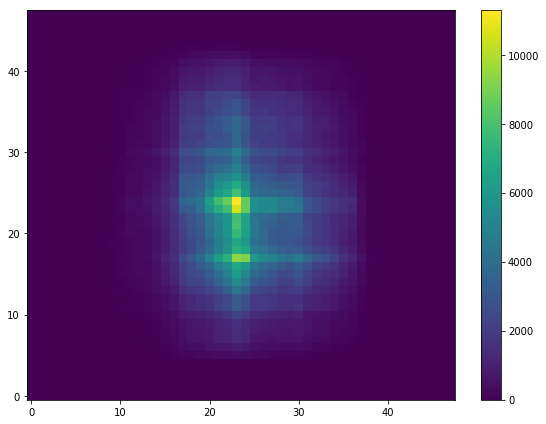

Current= -19.05
Files used: ['CG4B2957.dat', 'CG4B2958.dat', 'CG4B2959.dat', 'CG4B2960.dat', 'CG4B2961.dat', 'CG4B2962.dat', 'CG4B2963.dat', 'CG4B2964.dat', 'CG4B2965.dat', 'CG4B2966.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1740965.9494348583


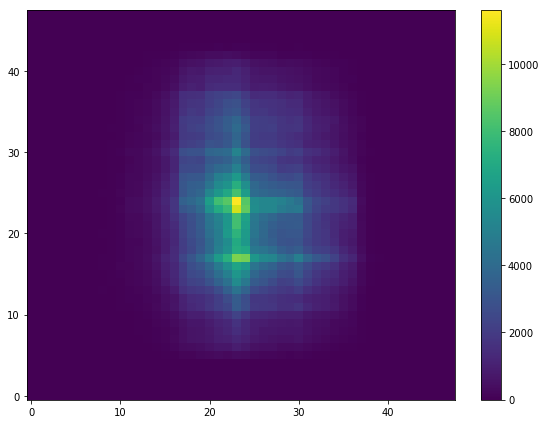

Current= -19.038
Files used: ['CG4B2967.dat', 'CG4B2968.dat', 'CG4B2969.dat', 'CG4B2970.dat', 'CG4B2971.dat', 'CG4B2972.dat', 'CG4B2973.dat', 'CG4B2974.dat', 'CG4B2975.dat', 'CG4B2976.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1757111.5151695444


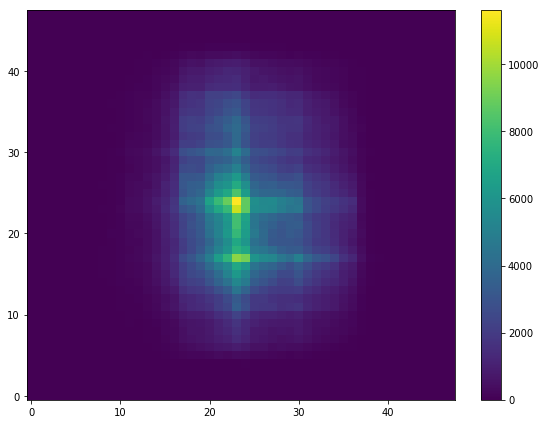

Current= -19.025
Files used: ['CG4B2977.dat', 'CG4B2978.dat', 'CG4B2979.dat', 'CG4B2980.dat', 'CG4B2981.dat', 'CG4B2982.dat', 'CG4B2983.dat', 'CG4B2984.dat', 'CG4B2985.dat', 'CG4B2986.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1765648.164187983


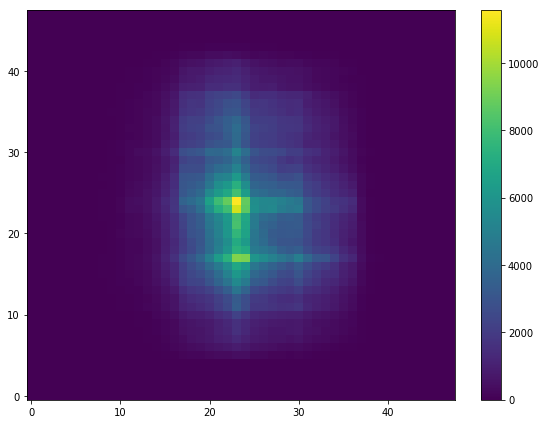

Current= -19.013
Files used: ['CG4B2987.dat', 'CG4B2988.dat', 'CG4B2989.dat', 'CG4B2990.dat', 'CG4B2991.dat', 'CG4B2992.dat', 'CG4B2993.dat', 'CG4B2994.dat', 'CG4B2995.dat', 'CG4B2996.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1760141.0850684121


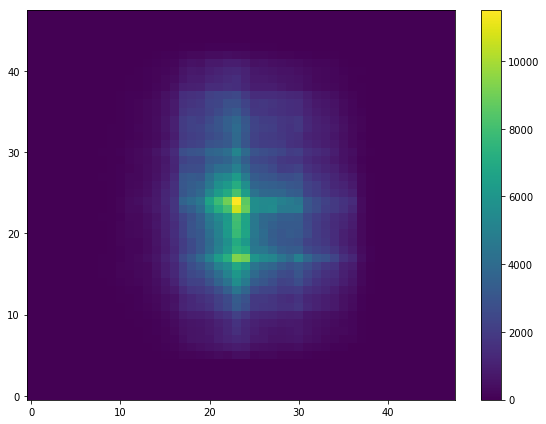

Current= -19.0
Files used: ['CG4B2997.dat', 'CG4B2998.dat', 'CG4B2999.dat', 'CG4B3000.dat', 'CG4B3001.dat', 'CG4B3002.dat', 'CG4B3003.dat', 'CG4B3004.dat', 'CG4B3005.dat', 'CG4B3006.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1751521.354550861


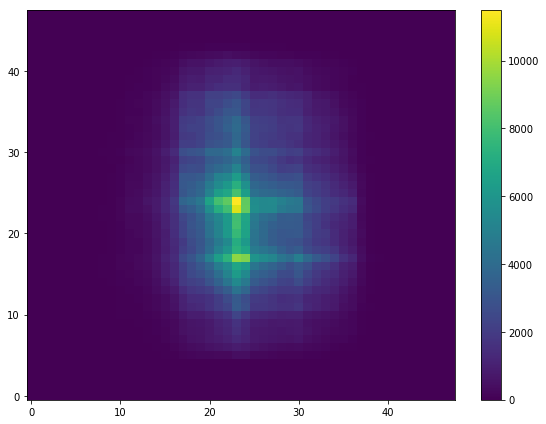


 Peak counts:  1766320.355145745 
 Current:  -19.5 


 Trough counts:  163855.5871505055 
 Current:  -19.25 



In [21]:
zero_counts = []    #add all subscans that are zero counts here

currents = np.arange(-19.55,-19.,.0125)
print("Currents used: ", currents, " \n Total=", len(currents), "\n")
high_counts = []
high_totals = []
start = 2557
subscans = 10

for i in range(len(currents)):
    print("Current=", round(currents[i],3))
    if ((start + (subscans - 1) + int(i)*subscans) not in zero_counts):
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans, \
                          print_summed=True, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
    else: 
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans - 1, \
                          print_summed=True, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
        print("Warning: one subscan failed!")
        
Peak_h = max(high_totals)
Trough_h = min(high_totals)
Peak_current_h = np.argmax(high_totals)
Trough_current_h = np.argmin(high_totals)

print("\n Peak counts: ", Peak_h, "\n Current: ", round(currents[Peak_current_h],3), "\n")
print("\n Trough counts: ", Trough_h, "\n Current: ", round(currents[Trough_current_h],3), "\n")


Currents used:  [-19.55   -19.5375 -19.525  -19.5125 -19.5    -19.4875 -19.475  -19.4625
 -19.45   -19.4375 -19.425  -19.4125 -19.4    -19.3875 -19.375  -19.3625
 -19.35   -19.3375 -19.325  -19.3125 -19.3    -19.2875 -19.275  -19.2625
 -19.25   -19.2375 -19.225  -19.2125 -19.2    -19.1875 -19.175  -19.1625
 -19.15   -19.1375 -19.125  -19.1125 -19.1    -19.0875 -19.075  -19.0625
 -19.05   -19.0375 -19.025  -19.0125 -19.    ]  
 Total= 45 

Current= -19.55
Files used: ['CG4B3117.dat', 'CG4B3118.dat', 'CG4B3119.dat', 'CG4B3120.dat', 'CG4B3121.dat', 'CG4B3122.dat', 'CG4B3123.dat', 'CG4B3124.dat', 'CG4B3125.dat', 'CG4B3126.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  42999.06603212368


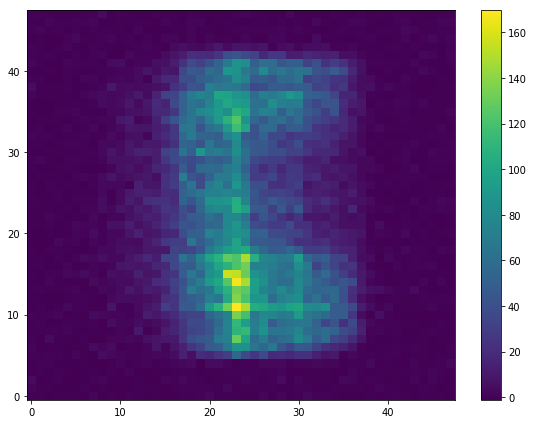

Current= -19.538
Files used: ['CG4B3127.dat', 'CG4B3128.dat', 'CG4B3129.dat', 'CG4B3130.dat', 'CG4B3131.dat', 'CG4B3132.dat', 'CG4B3133.dat', 'CG4B3134.dat', 'CG4B3135.dat', 'CG4B3136.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  42981.11659726346


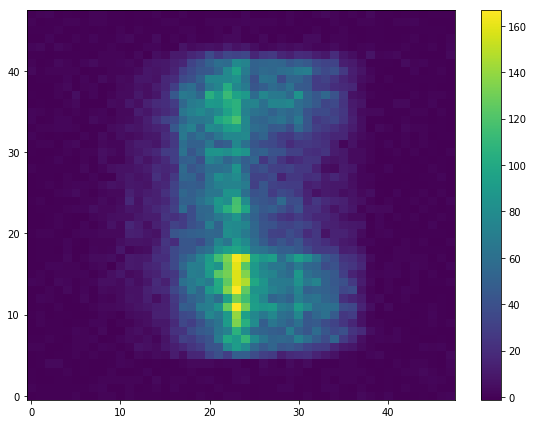

Current= -19.525
Files used: ['CG4B3137.dat', 'CG4B3138.dat', 'CG4B3139.dat', 'CG4B3140.dat', 'CG4B3141.dat', 'CG4B3142.dat', 'CG4B3143.dat', 'CG4B3144.dat', 'CG4B3145.dat', 'CG4B3146.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  42226.29863176687


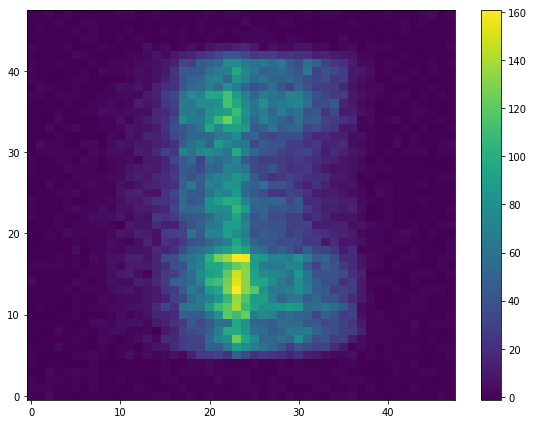

Current= -19.513
Files used: ['CG4B3147.dat', 'CG4B3148.dat', 'CG4B3149.dat', 'CG4B3150.dat', 'CG4B3151.dat', 'CG4B3152.dat', 'CG4B3153.dat', 'CG4B3154.dat', 'CG4B3155.dat', 'CG4B3156.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  41419.66924449732


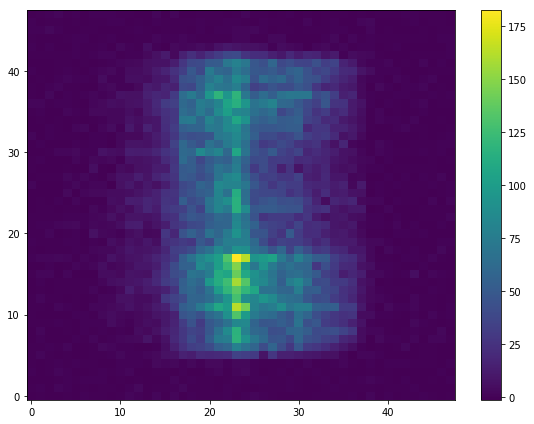

Current= -19.5
Files used: ['CG4B3157.dat', 'CG4B3158.dat', 'CG4B3159.dat', 'CG4B3160.dat', 'CG4B3161.dat', 'CG4B3162.dat', 'CG4B3163.dat', 'CG4B3164.dat', 'CG4B3165.dat', 'CG4B3166.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  39695.20642474712


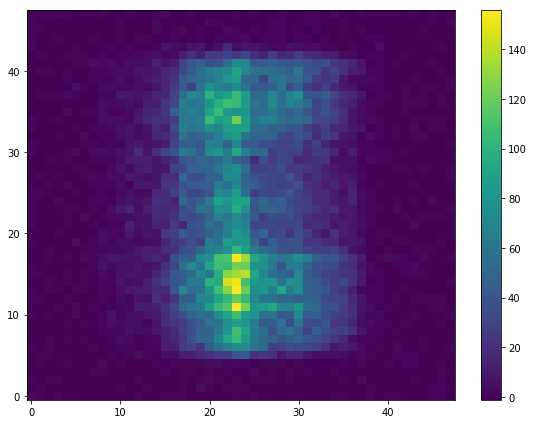

Current= -19.488
Files used: ['CG4B3167.dat', 'CG4B3168.dat', 'CG4B3169.dat', 'CG4B3170.dat', 'CG4B3171.dat', 'CG4B3172.dat', 'CG4B3173.dat', 'CG4B3174.dat', 'CG4B3175.dat', 'CG4B3176.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  38011.01784651989


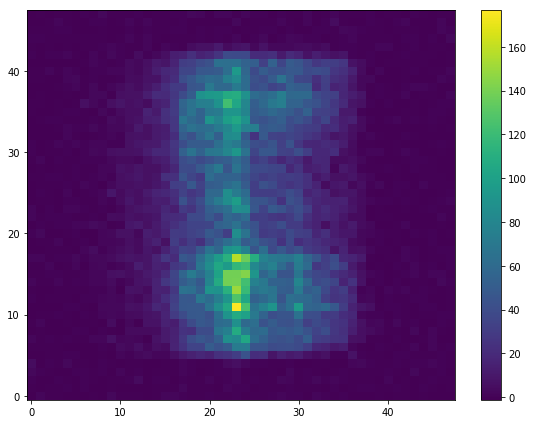

Current= -19.475
Files used: ['CG4B3177.dat', 'CG4B3178.dat', 'CG4B3179.dat', 'CG4B3180.dat', 'CG4B3181.dat', 'CG4B3182.dat', 'CG4B3183.dat', 'CG4B3184.dat', 'CG4B3185.dat', 'CG4B3186.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  36611.27007733497


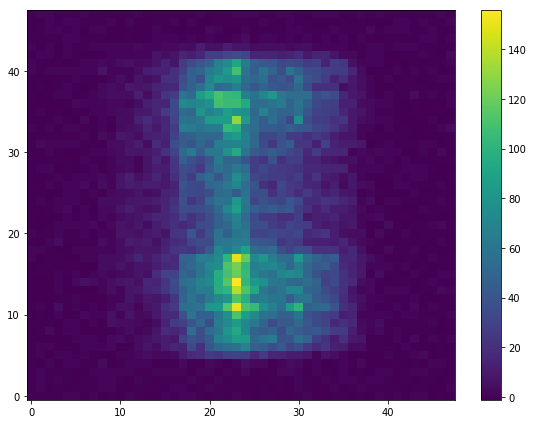

Current= -19.463
Files used: ['CG4B3187.dat', 'CG4B3188.dat', 'CG4B3189.dat', 'CG4B3190.dat', 'CG4B3191.dat', 'CG4B3192.dat', 'CG4B3193.dat', 'CG4B3194.dat', 'CG4B3195.dat', 'CG4B3196.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  35130.44318857826


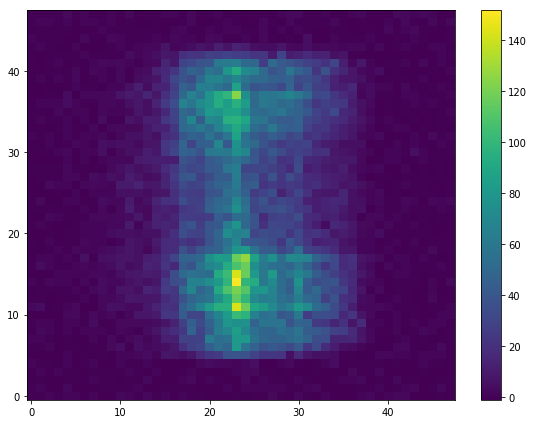

Current= -19.45
Files used: ['CG4B3197.dat', 'CG4B3198.dat', 'CG4B3199.dat', 'CG4B3200.dat', 'CG4B3201.dat', 'CG4B3202.dat', 'CG4B3203.dat', 'CG4B3204.dat', 'CG4B3205.dat', 'CG4B3206.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  35082.57703747772


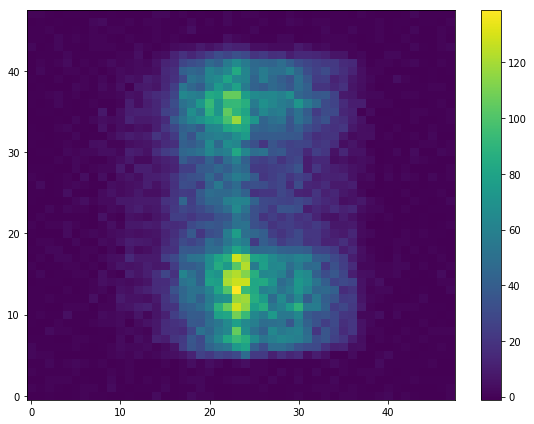

Current= -19.438
Files used: ['CG4B3207.dat', 'CG4B3208.dat', 'CG4B3209.dat', 'CG4B3210.dat', 'CG4B3211.dat', 'CG4B3212.dat', 'CG4B3213.dat', 'CG4B3214.dat', 'CG4B3215.dat', 'CG4B3216.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  36430.43010113035


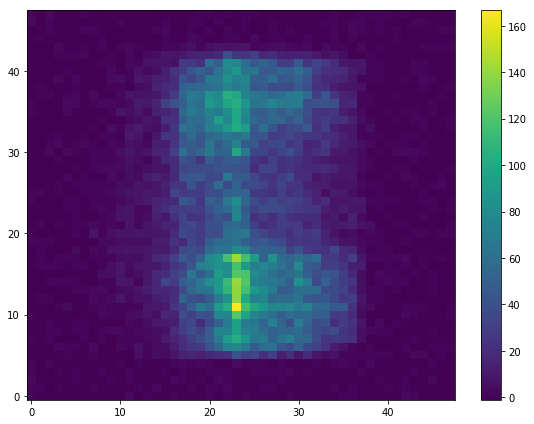

Current= -19.425
Files used: ['CG4B3217.dat', 'CG4B3218.dat', 'CG4B3219.dat', 'CG4B3220.dat', 'CG4B3221.dat', 'CG4B3222.dat', 'CG4B3223.dat', 'CG4B3224.dat', 'CG4B3225.dat', 'CG4B3226.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  40381.99583581198


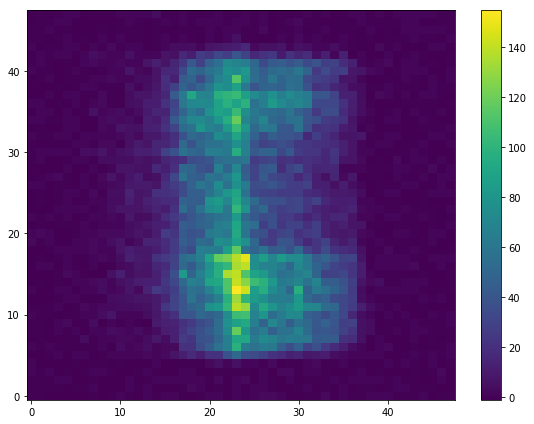

Current= -19.413
Files used: ['CG4B3227.dat', 'CG4B3228.dat', 'CG4B3229.dat', 'CG4B3230.dat', 'CG4B3231.dat', 'CG4B3232.dat', 'CG4B3233.dat', 'CG4B3234.dat', 'CG4B3235.dat', 'CG4B3236.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  46164.19988102319


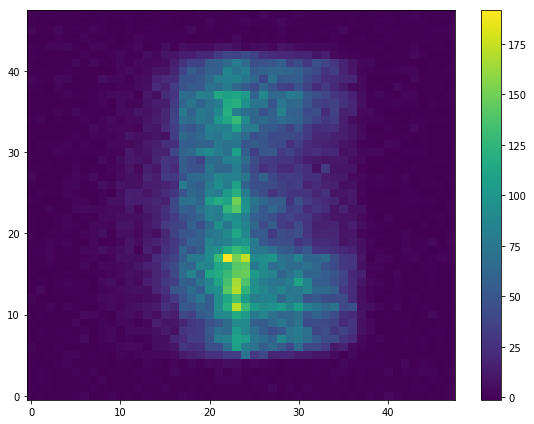

Current= -19.4
Files used: ['CG4B3237.dat', 'CG4B3238.dat', 'CG4B3239.dat', 'CG4B3240.dat', 'CG4B3241.dat', 'CG4B3242.dat', 'CG4B3243.dat', 'CG4B3244.dat', 'CG4B3245.dat', 'CG4B3246.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  54979.033313503794


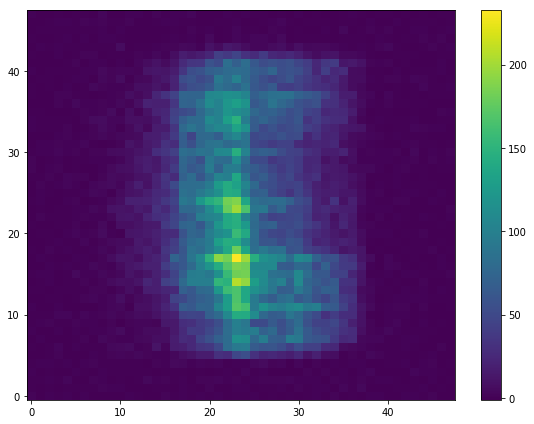

Current= -19.388
Files used: ['CG4B3247.dat', 'CG4B3248.dat', 'CG4B3249.dat', 'CG4B3250.dat', 'CG4B3251.dat', 'CG4B3252.dat', 'CG4B3253.dat', 'CG4B3254.dat', 'CG4B3255.dat', 'CG4B3256.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  69667.2284354551


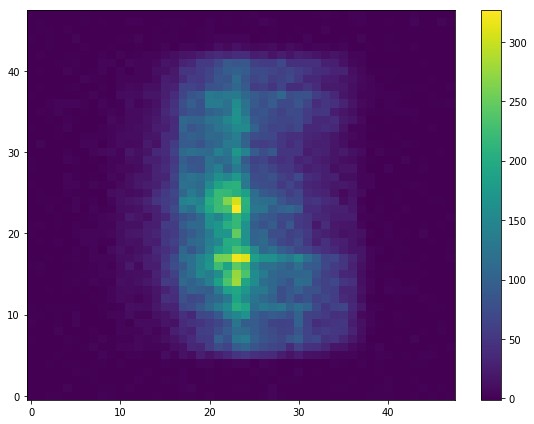

Current= -19.375
Files used: ['CG4B3257.dat', 'CG4B3258.dat', 'CG4B3259.dat', 'CG4B3260.dat', 'CG4B3261.dat', 'CG4B3262.dat', 'CG4B3263.dat', 'CG4B3264.dat', 'CG4B3265.dat', 'CG4B3266.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  86504.79654967276


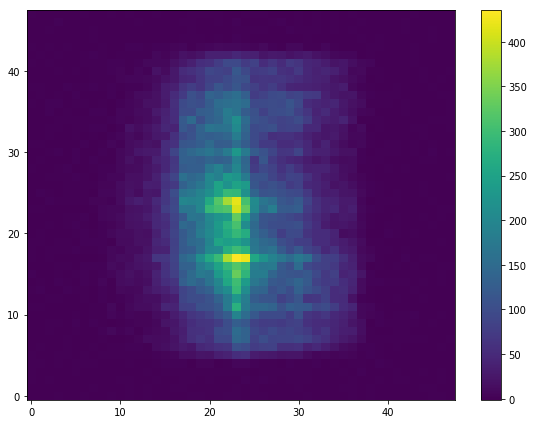

Current= -19.363
Files used: ['CG4B3267.dat', 'CG4B3268.dat', 'CG4B3269.dat', 'CG4B3270.dat', 'CG4B3271.dat', 'CG4B3272.dat', 'CG4B3273.dat', 'CG4B3274.dat', 'CG4B3275.dat', 'CG4B3276.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  106477.77037477682


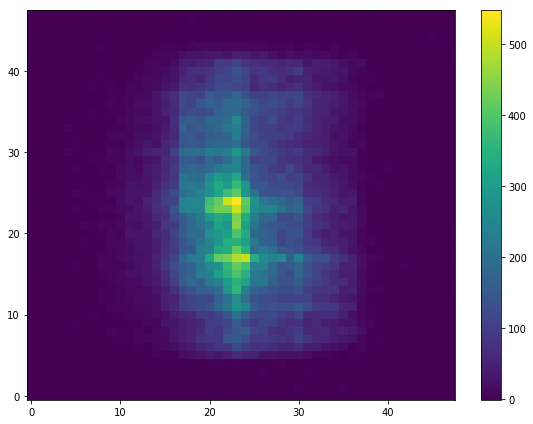

Current= -19.35
Files used: ['CG4B3277.dat', 'CG4B3278.dat', 'CG4B3279.dat', 'CG4B3280.dat', 'CG4B3281.dat', 'CG4B3282.dat', 'CG4B3283.dat', 'CG4B3284.dat', 'CG4B3285.dat', 'CG4B3286.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  133235.29446757858


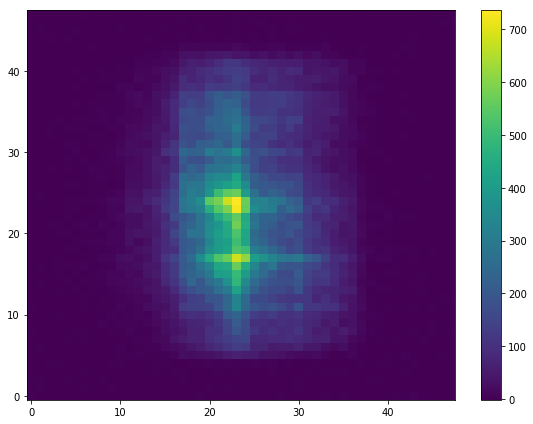

Current= -19.338
Files used: ['CG4B3287.dat', 'CG4B3288.dat', 'CG4B3289.dat', 'CG4B3290.dat', 'CG4B3291.dat', 'CG4B3292.dat', 'CG4B3293.dat', 'CG4B3294.dat', 'CG4B3295.dat', 'CG4B3296.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  162123.5074360503


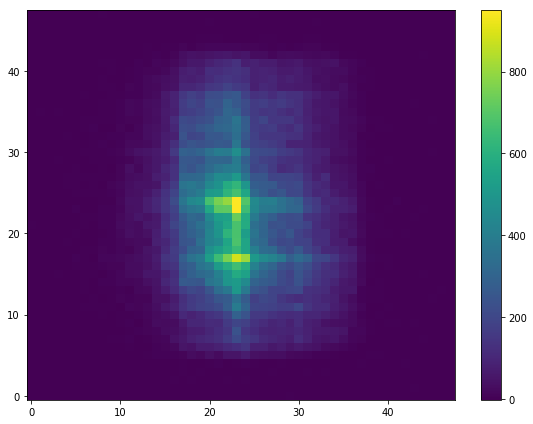

Current= -19.325
Files used: ['CG4B3297.dat', 'CG4B3298.dat', 'CG4B3299.dat', 'CG4B3300.dat', 'CG4B3301.dat', 'CG4B3302.dat', 'CG4B3303.dat', 'CG4B3304.dat', 'CG4B3305.dat', 'CG4B3306.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  191670.2575847713


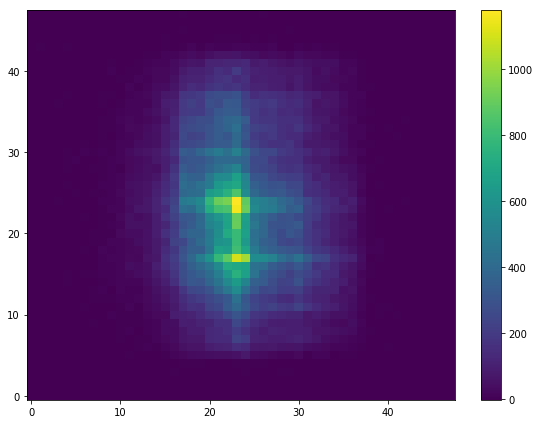

Current= -19.313
Files used: ['CG4B3307.dat', 'CG4B3308.dat', 'CG4B3309.dat', 'CG4B3310.dat', 'CG4B3311.dat', 'CG4B3312.dat', 'CG4B3313.dat', 'CG4B3314.dat', 'CG4B3315.dat', 'CG4B3316.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  229193.78405710895


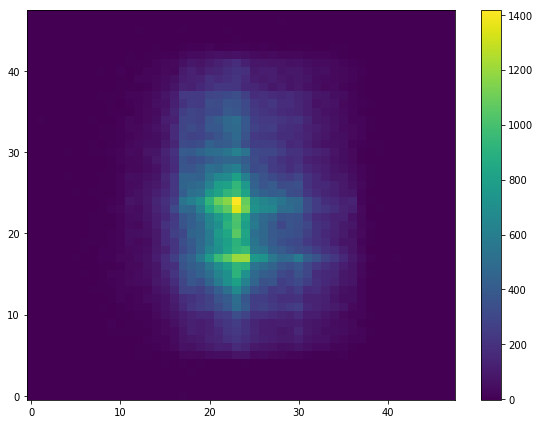

Current= -19.3
Files used: ['CG4B3317.dat', 'CG4B3318.dat', 'CG4B3319.dat', 'CG4B3320.dat', 'CG4B3321.dat', 'CG4B3322.dat', 'CG4B3323.dat', 'CG4B3324.dat', 'CG4B3325.dat', 'CG4B3326.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  266181.22070196347


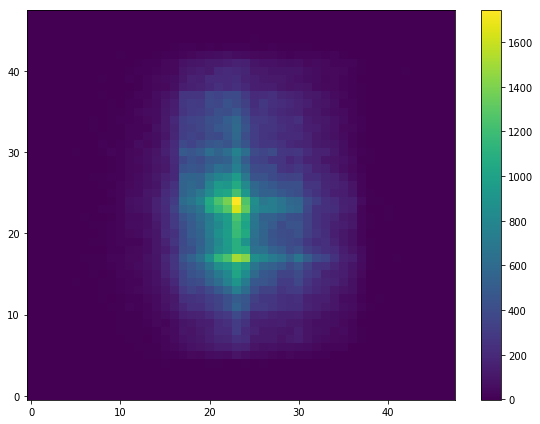

Current= -19.288
Files used: ['CG4B3327.dat', 'CG4B3328.dat', 'CG4B3329.dat', 'CG4B3330.dat', 'CG4B3331.dat', 'CG4B3332.dat', 'CG4B3333.dat', 'CG4B3334.dat', 'CG4B3335.dat', 'CG4B3336.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  303486.33670434274


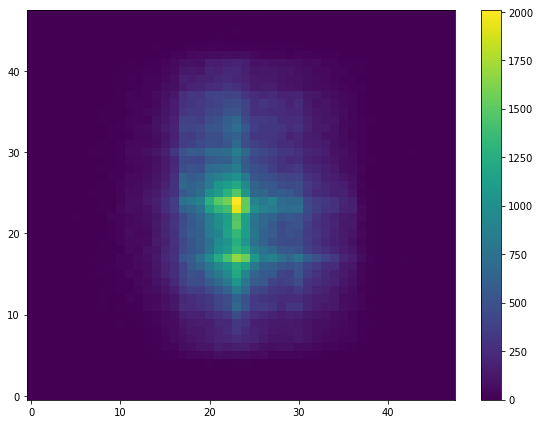

Current= -19.275
Files used: ['CG4B3337.dat', 'CG4B3338.dat', 'CG4B3339.dat', 'CG4B3340.dat', 'CG4B3341.dat', 'CG4B3342.dat', 'CG4B3343.dat', 'CG4B3344.dat', 'CG4B3345.dat', 'CG4B3346.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  338755.48602022545


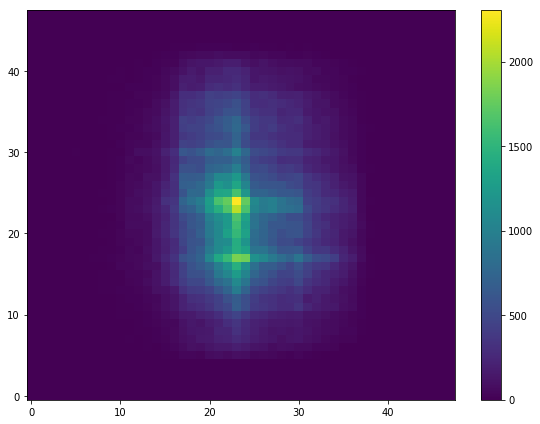

Current= -19.263
Files used: ['CG4B3347.dat', 'CG4B3348.dat', 'CG4B3349.dat', 'CG4B3350.dat', 'CG4B3351.dat', 'CG4B3352.dat', 'CG4B3353.dat', 'CG4B3354.dat', 'CG4B3355.dat', 'CG4B3356.dat']
Bin size =  5
Binned pixel size (mm) =  1.0


KeyboardInterrupt: 

In [22]:
zero_counts = []    #add all subscans that are zero counts here

currents = np.arange(-19.55,-19.,.0125)
print("Currents used: ", currents, " \n Total=", len(currents), "\n")
low_counts = []
low_totals = []
start = 3117
subscans = 10

for i in range(len(currents)):
    print("Current=", round(currents[i],3))
    if ((start + (subscans - 1) + int(i)*subscans) not in zero_counts):
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans, \
                          print_summed=True, print_fnames=True)
        low_counts.append(run[0])
        low_totals.append(run[1])
    else: 
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans - 1, \
                          print_summed=True, print_fnames=True)
        low_counts.append(run[0])
        low_totals.append(run[1])
        print("Warning: one subscan failed!")

Peak_l = max(low_totals)
Trough_l = min(low_totals)
Peak_current_l = np.argmax(low_totals)
Trough_current_l = np.argmin(low_totals)

print("\n Peak counts: ", Peak_l, "\n Current: ", round(currents[Peak_current_l],3), "\n")
print("\n Trough counts: ", Trough_l, "\n Current: ", round(currents[Trough_current_l],3), "\n")


In [ ]:
FR = Peak_l / Trough_h
print(FR, 1/FR)

In [ ]:
zero_counts = []    #add all subscans that are zero counts here

currents = np.arange(2.5,1.5,-.1)
print("Currents used: ", currents, " \n Total=", len(currents), "\n")
high_counts = []
high_totals = []
start = 688
subscans = 10

for i in range(len(currents)):
    print("Current=", round(currents[i],3))
    if ((start + (subscans - 1) + int(i)*subscans) not in zero_counts):
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans, \
                          print_summed=True, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
    else: 
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans - 1, \
                          print_summed=True, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
        print("Warning: one subscan failed!")
        
Peak_h = max(high_totals)
Trough_h = min(high_totals)
Peak_current_h = np.argmax(high_totals)
Trough_current_h = np.argmin(high_totals)

print("\n Peak counts: ", Peak_h, "\n Current: ", round(currents[Peak_current_h],3), "\n")
print("\n Trough counts: ", Trough_h, "\n Current: ", round(currents[Trough_current_h],3), "\n")


In [ ]:
zero_counts = []    #add all subscans that are zero counts here

currents = np.arange(2.5,1.5,-.1)
print("Currents used: ", currents, " \n Total=", len(currents), "\n")
low_counts = []
low_totals = []
start = 788
subscans = 10

for i in range(len(currents)):
    print("Current=", round(currents[i],3))
    if ((start + (subscans - 1) + int(i)*subscans) not in zero_counts):
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans, \
                          print_summed=True, print_fnames=True)
        low_counts.append(run[0])
        low_totals.append(run[1])
    else: 
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans - 1, \
                          print_summed=True, print_fnames=True)
        low_counts.append(run[0])
        low_totals.append(run[1])
        print("Warning: one subscan failed!")

Peak_l = max(low_totals)
Trough_l = min(low_totals)
Peak_current_l = np.argmax(low_totals)
Trough_current_l = np.argmin(low_totals)

print("\n Peak counts: ", Peak_l, "\n Current: ", round(currents[Peak_current_l],3), "\n")
print("\n Trough counts: ", Trough_l, "\n Current: ", round(currents[Trough_current_l],3), "\n")


In [ ]:
FR = Peak_l / Trough_h
print(FR, 1/FR)

In [ ]:
zero_counts = []    #add all subscans that are zero counts here

currents = np.arange(-15.5,-14.5,.1)
print("Currents used: ", currents, " \n Total=", len(currents), "\n")
high_counts = []
high_totals = []
start = 1688
subscans = 10

for i in range(len(currents)):
    print("Current=", round(currents[i],3))
    if ((start + (subscans - 1) + int(i)*subscans) not in zero_counts):
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans, \
                          print_summed=True, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
    else: 
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans - 1, \
                          print_summed=True, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
        print("Warning: one subscan failed!")
        
Peak_h = max(high_totals)
Trough_h = min(high_totals)
Peak_current_h = np.argmax(high_totals)
Trough_current_h = np.argmin(high_totals)

print("\n Peak counts: ", Peak_h, "\n Current: ", round(currents[Peak_current_h],3), "\n")
print("\n Trough counts: ", Trough_h, "\n Current: ", round(currents[Trough_current_h],3), "\n")


In [ ]:
scanned_curs = [2,6,8.5,15,19]

for sc in scanned_curs:
        blcur=sc
        print("b1cur", blcur)
        
        for N1 in [-5,5]:
            n1cur=N1
            print("\t n1cur", n1cur)
            
            for B2 in np.arange(-(sc + 0.5),-(sc - 0.5),.1):
                b2cur=B2
                print("\t \t b2cur",b2cur)
                
                print("\t \t \t subscan")

        b2cur=-sc
        print("b2cur",b2cur)
        for N1 in [-5,5]:
            n1cur=N1
            print("\t n1cur",n1cur)
            
            for B1 in np.arange(sc + 0.5,sc - 0.5,-.1):
                b1cur=B1
                print("\t \t b1cur",b1cur)

                print("\t \t \t subscan")


In [ ]:
count_time = [60, 15]
for N1 in [-5,5]:
    time = count_time[int((N1 + 5)/10)]
    print(time)

Currents used:  [-19.55 -19.54 -19.53 -19.52 -19.51 -19.5  -19.49 -19.48 -19.47 -19.46
 -19.45 -19.44 -19.43 -19.42 -19.41 -19.4  -19.39 -19.38 -19.37 -19.36
 -19.35 -19.34 -19.33 -19.32 -19.31 -19.3  -19.29 -19.28 -19.27 -19.26
 -19.25 -19.24 -19.23 -19.22 -19.21 -19.2  -19.19 -19.18 -19.17 -19.16
 -19.15 -19.14 -19.13 -19.12 -19.11 -19.1  -19.09 -19.08 -19.07 -19.06
 -19.05 -19.04 -19.03 -19.02 -19.01 -19.  ]  
 Total= 56 

Current= -19.55
Files used: ['CG4B4988.dat', 'CG4B4989.dat', 'CG4B4990.dat', 'CG4B4991.dat', 'CG4B4992.dat', 'CG4B4993.dat', 'CG4B4994.dat', 'CG4B4995.dat', 'CG4B4996.dat', 'CG4B4997.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1112525.588935158


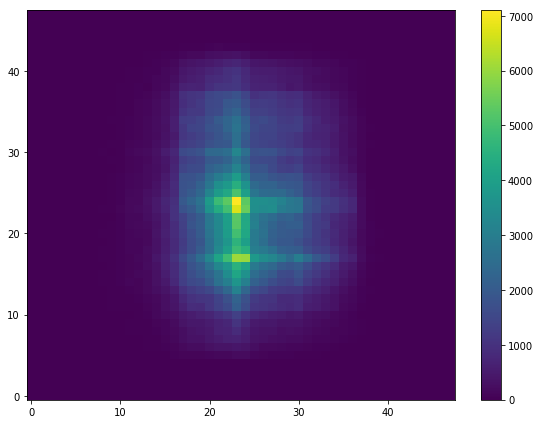

Current= -19.54
Files used: ['CG4B4998.dat', 'CG4B4999.dat', 'CG4B5000.dat', 'CG4B5001.dat', 'CG4B5002.dat', 'CG4B5003.dat', 'CG4B5004.dat', 'CG4B5005.dat', 'CG4B5006.dat', 'CG4B5007.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1039471.0493753718


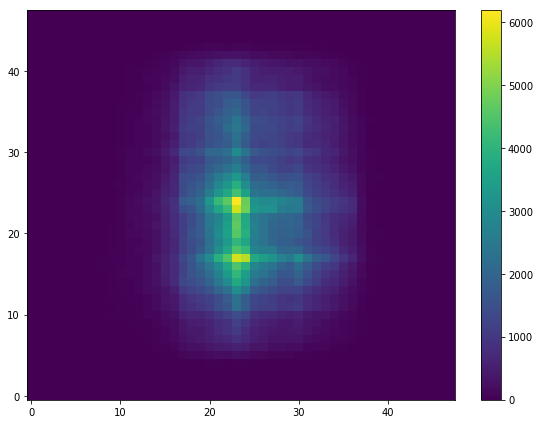

Current= -19.53
Files used: ['CG4B5008.dat', 'CG4B5009.dat', 'CG4B5010.dat', 'CG4B5011.dat', 'CG4B5012.dat', 'CG4B5013.dat', 'CG4B5014.dat', 'CG4B5015.dat', 'CG4B5016.dat', 'CG4B5017.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  892165.0142772165


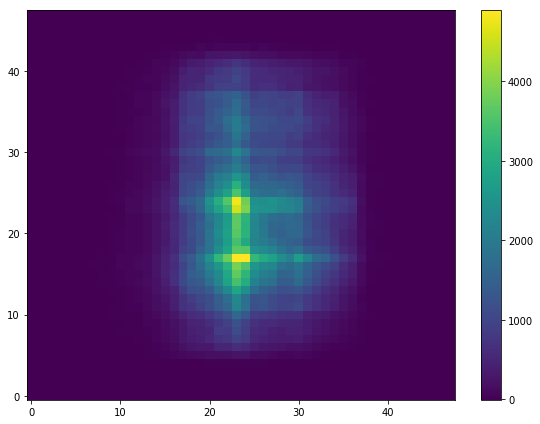

Current= -19.52
Files used: ['CG4B5018.dat', 'CG4B5019.dat', 'CG4B5020.dat', 'CG4B5021.dat', 'CG4B5022.dat', 'CG4B5023.dat', 'CG4B5024.dat', 'CG4B5025.dat', 'CG4B5026.dat', 'CG4B5027.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  692369.2331945273


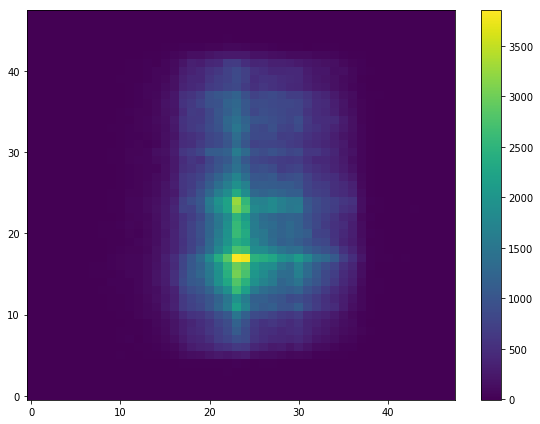

Current= -19.51
Files used: ['CG4B5028.dat', 'CG4B5029.dat', 'CG4B5030.dat', 'CG4B5031.dat', 'CG4B5032.dat', 'CG4B5033.dat', 'CG4B5034.dat', 'CG4B5035.dat', 'CG4B5036.dat', 'CG4B5037.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  480256.820345033


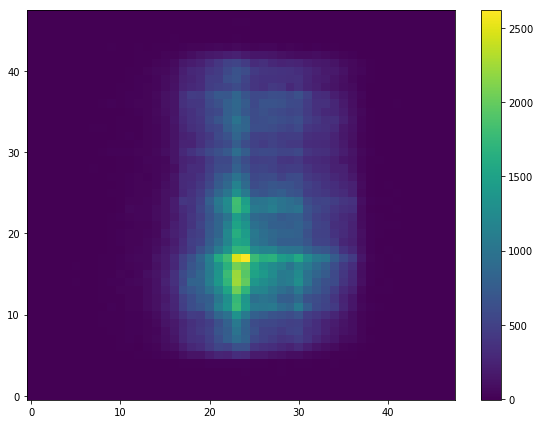

Current= -19.5
Files used: ['CG4B5038.dat', 'CG4B5039.dat', 'CG4B5040.dat', 'CG4B5041.dat', 'CG4B5042.dat', 'CG4B5043.dat', 'CG4B5044.dat', 'CG4B5045.dat', 'CG4B5046.dat', 'CG4B5047.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  301373.3283759662


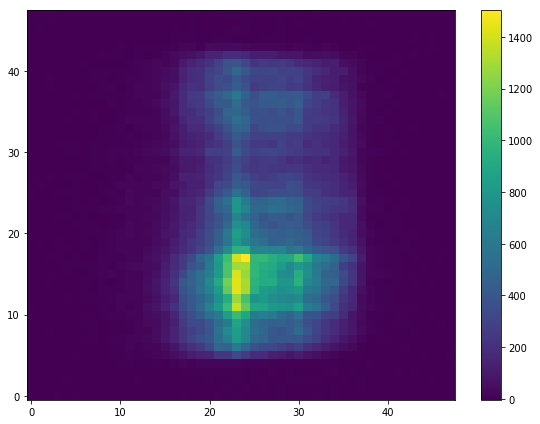

Current= -19.49
Files used: ['CG4B5048.dat', 'CG4B5049.dat', 'CG4B5050.dat', 'CG4B5051.dat', 'CG4B5052.dat', 'CG4B5053.dat', 'CG4B5054.dat', 'CG4B5055.dat', 'CG4B5056.dat', 'CG4B5057.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  175798.04461629954


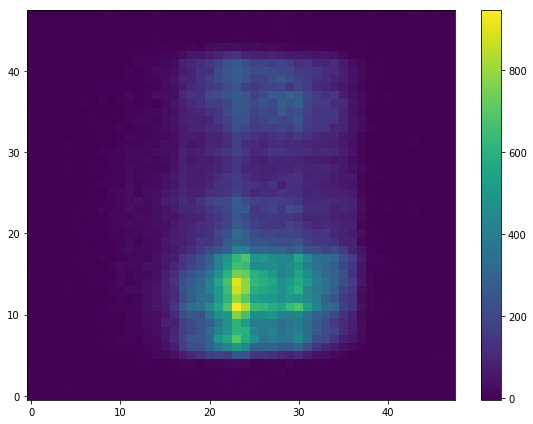

Current= -19.48
Files used: ['CG4B5058.dat', 'CG4B5059.dat', 'CG4B5060.dat', 'CG4B5061.dat', 'CG4B5062.dat', 'CG4B5063.dat', 'CG4B5064.dat', 'CG4B5065.dat', 'CG4B5066.dat', 'CG4B5067.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  131310.16478286727


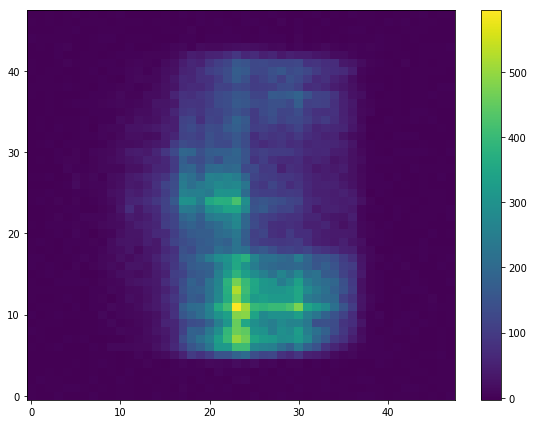

Current= -19.47
Files used: ['CG4B5068.dat', 'CG4B5069.dat', 'CG4B5070.dat', 'CG4B5071.dat', 'CG4B5072.dat', 'CG4B5073.dat', 'CG4B5074.dat', 'CG4B5075.dat', 'CG4B5076.dat', 'CG4B5077.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  174365.07911957186


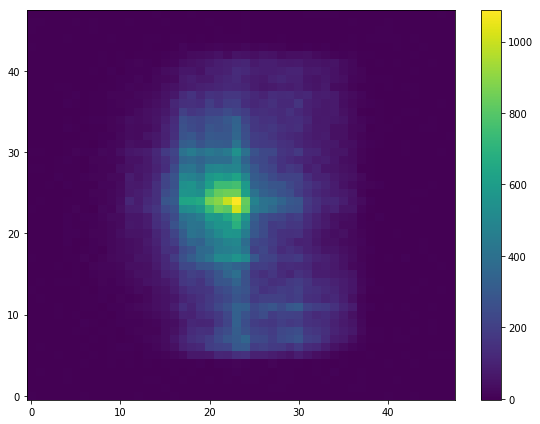

Current= -19.46
Files used: ['CG4B5078.dat', 'CG4B5079.dat', 'CG4B5080.dat', 'CG4B5081.dat', 'CG4B5082.dat', 'CG4B5083.dat', 'CG4B5084.dat', 'CG4B5085.dat', 'CG4B5086.dat', 'CG4B5087.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  299967.4366448541


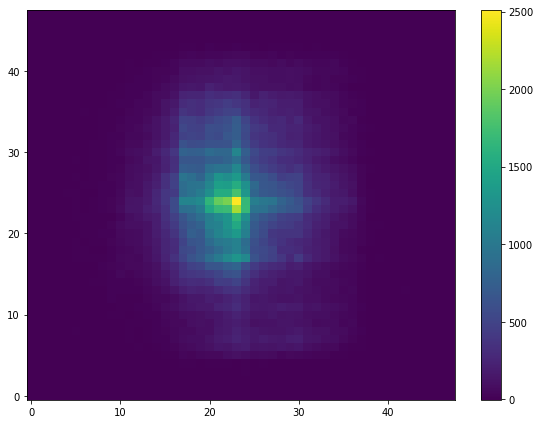

Current= -19.45
Files used: ['CG4B5088.dat', 'CG4B5089.dat', 'CG4B5090.dat', 'CG4B5091.dat', 'CG4B5092.dat', 'CG4B5093.dat', 'CG4B5094.dat', 'CG4B5095.dat', 'CG4B5096.dat', 'CG4B5097.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  490696.64961332554


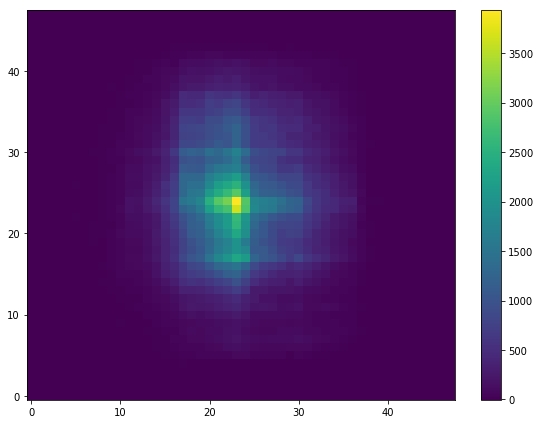

Current= -19.44
Files used: ['CG4B5098.dat', 'CG4B5099.dat', 'CG4B5100.dat', 'CG4B5101.dat', 'CG4B5102.dat', 'CG4B5103.dat', 'CG4B5104.dat', 'CG4B5105.dat', 'CG4B5106.dat', 'CG4B5107.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  692688.5800118974


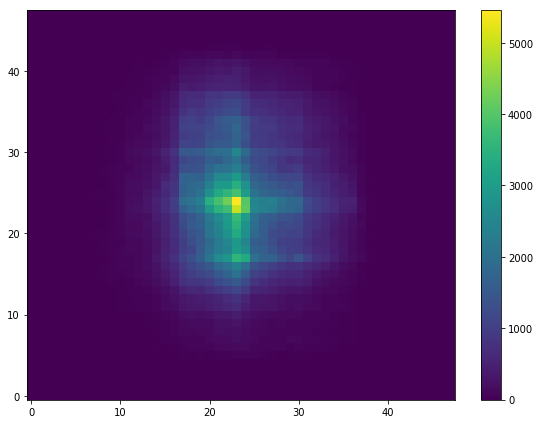

Current= -19.43
Files used: ['CG4B5108.dat', 'CG4B5109.dat', 'CG4B5110.dat', 'CG4B5111.dat', 'CG4B5112.dat', 'CG4B5113.dat', 'CG4B5114.dat', 'CG4B5115.dat', 'CG4B5116.dat', 'CG4B5117.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  887177.4360499703


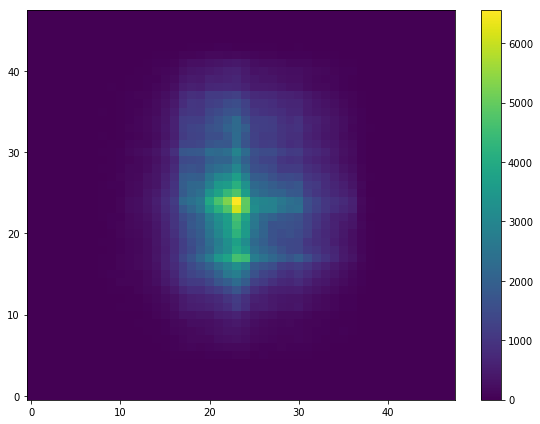

Current= -19.42
Files used: ['CG4B5118.dat', 'CG4B5119.dat', 'CG4B5120.dat', 'CG4B5121.dat', 'CG4B5122.dat', 'CG4B5123.dat', 'CG4B5124.dat', 'CG4B5125.dat', 'CG4B5126.dat', 'CG4B5127.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1038685.1273051759


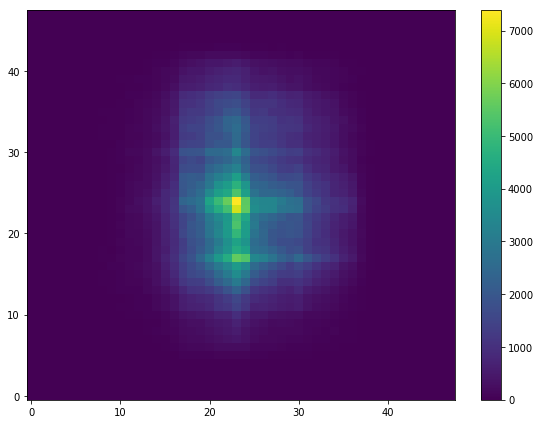

Current= -19.41
Files used: ['CG4B5128.dat', 'CG4B5129.dat', 'CG4B5130.dat', 'CG4B5131.dat', 'CG4B5132.dat', 'CG4B5133.dat', 'CG4B5134.dat', 'CG4B5135.dat', 'CG4B5136.dat', 'CG4B5137.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1111933.1915526455


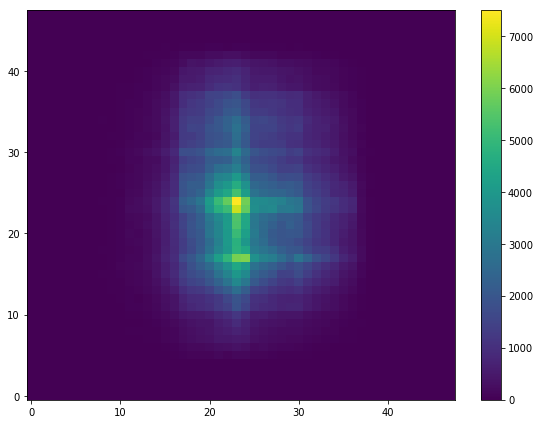

Current= -19.4
Files used: ['CG4B5138.dat', 'CG4B5139.dat', 'CG4B5140.dat', 'CG4B5141.dat', 'CG4B5142.dat', 'CG4B5143.dat', 'CG4B5144.dat', 'CG4B5145.dat', 'CG4B5146.dat', 'CG4B5147.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1104143.1897679933


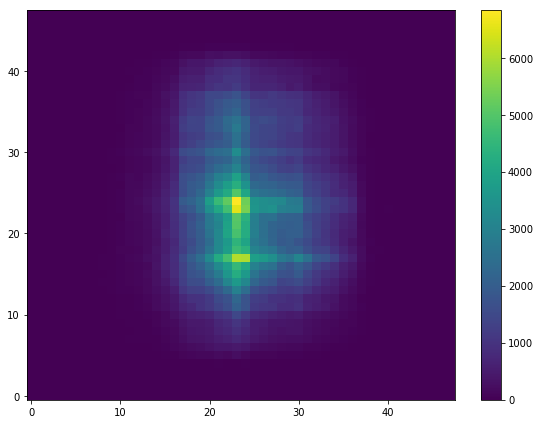

Current= -19.39
Files used: ['CG4B5148.dat', 'CG4B5149.dat', 'CG4B5150.dat', 'CG4B5151.dat', 'CG4B5152.dat', 'CG4B5153.dat', 'CG4B5154.dat', 'CG4B5155.dat', 'CG4B5156.dat', 'CG4B5157.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  999396.2599643081


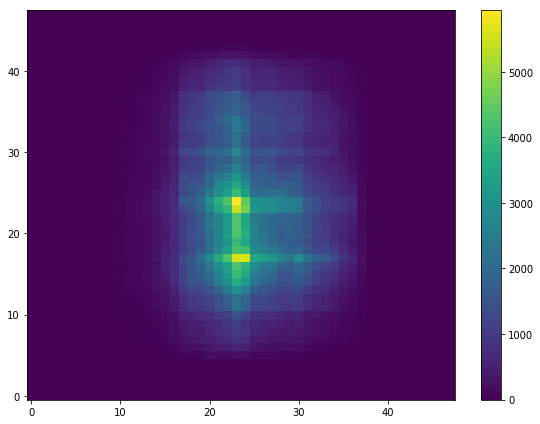

Current= -19.38
Files used: ['CG4B5158.dat', 'CG4B5159.dat', 'CG4B5160.dat', 'CG4B5161.dat', 'CG4B5162.dat', 'CG4B5163.dat', 'CG4B5164.dat', 'CG4B5165.dat', 'CG4B5166.dat', 'CG4B5167.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  836801.0999405107


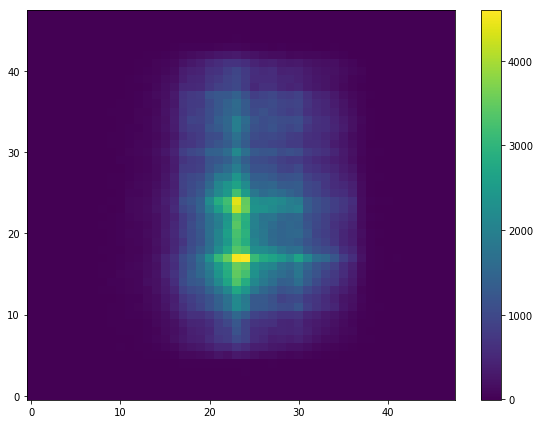

Current= -19.37
Files used: ['CG4B5168.dat', 'CG4B5169.dat', 'CG4B5170.dat', 'CG4B5171.dat', 'CG4B5172.dat', 'CG4B5173.dat', 'CG4B5174.dat', 'CG4B5175.dat', 'CG4B5176.dat', 'CG4B5177.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  636649.7507436052


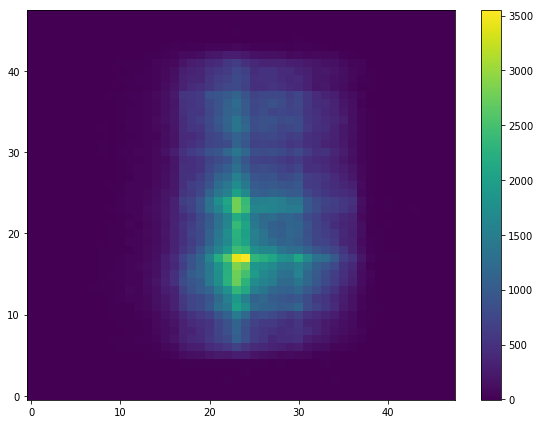

Current= -19.36
Files used: ['CG4B5178.dat', 'CG4B5179.dat', 'CG4B5180.dat', 'CG4B5181.dat', 'CG4B5182.dat', 'CG4B5183.dat', 'CG4B5184.dat', 'CG4B5185.dat', 'CG4B5186.dat', 'CG4B5187.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  427504.38370017865


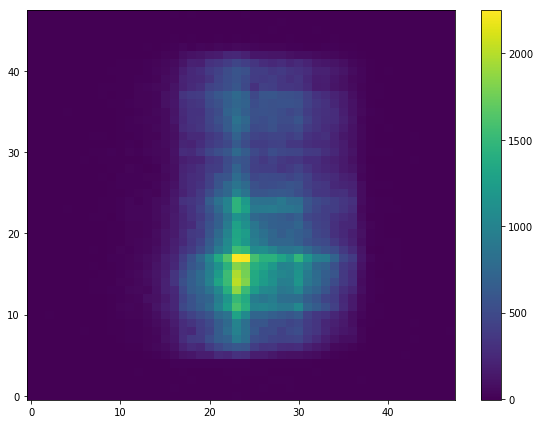

Current= -19.35
Files used: ['CG4B5188.dat', 'CG4B5189.dat', 'CG4B5190.dat', 'CG4B5191.dat', 'CG4B5192.dat', 'CG4B5193.dat', 'CG4B5194.dat', 'CG4B5195.dat', 'CG4B5196.dat', 'CG4B5197.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  259771.87447947642


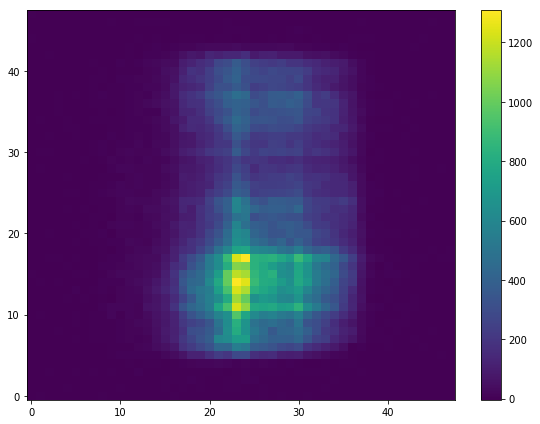

Current= -19.34
Files used: ['CG4B5198.dat', 'CG4B5199.dat', 'CG4B5200.dat', 'CG4B5201.dat', 'CG4B5202.dat', 'CG4B5203.dat', 'CG4B5204.dat', 'CG4B5205.dat', 'CG4B5206.dat', 'CG4B5207.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  155939.57763236162


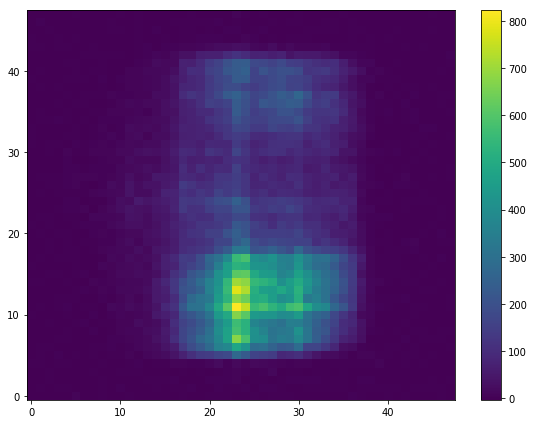

Current= -19.33
Files used: ['CG4B5208.dat', 'CG4B5209.dat', 'CG4B5210.dat', 'CG4B5211.dat', 'CG4B5212.dat', 'CG4B5213.dat', 'CG4B5214.dat', 'CG4B5215.dat', 'CG4B5216.dat', 'CG4B5217.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  135458.78762641287


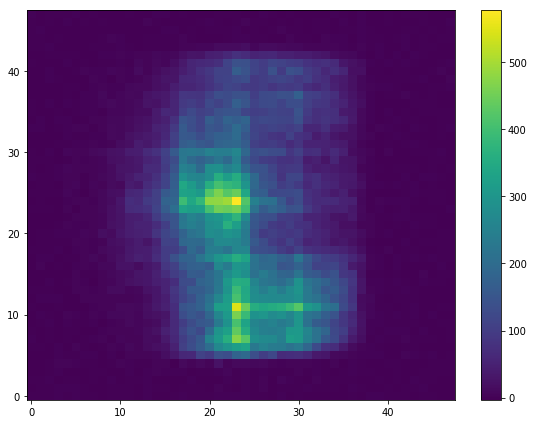

Current= -19.32
Files used: ['CG4B5218.dat', 'CG4B5219.dat', 'CG4B5220.dat', 'CG4B5221.dat', 'CG4B5222.dat', 'CG4B5223.dat', 'CG4B5224.dat', 'CG4B5225.dat', 'CG4B5226.dat', 'CG4B5227.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  204353.7566924453


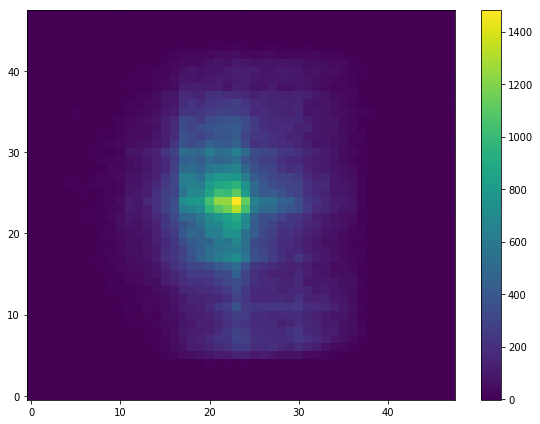

Current= -19.31
Files used: ['CG4B5228.dat', 'CG4B5229.dat', 'CG4B5230.dat', 'CG4B5231.dat', 'CG4B5232.dat', 'CG4B5233.dat', 'CG4B5234.dat', 'CG4B5235.dat', 'CG4B5236.dat', 'CG4B5237.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  347792.9452706723


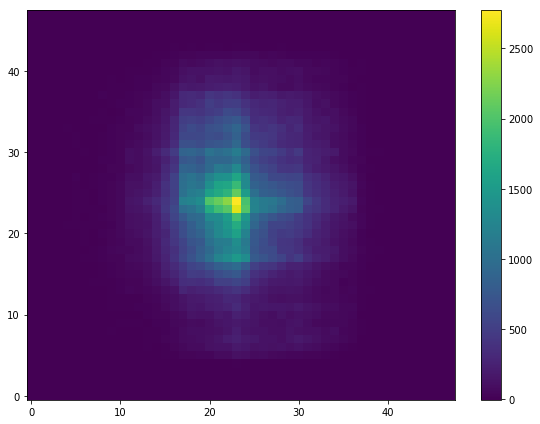

Current= -19.3
Files used: ['CG4B5238.dat', 'CG4B5239.dat', 'CG4B5240.dat', 'CG4B5241.dat', 'CG4B5242.dat', 'CG4B5243.dat', 'CG4B5244.dat', 'CG4B5245.dat', 'CG4B5246.dat', 'CG4B5247.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  551877.553242117


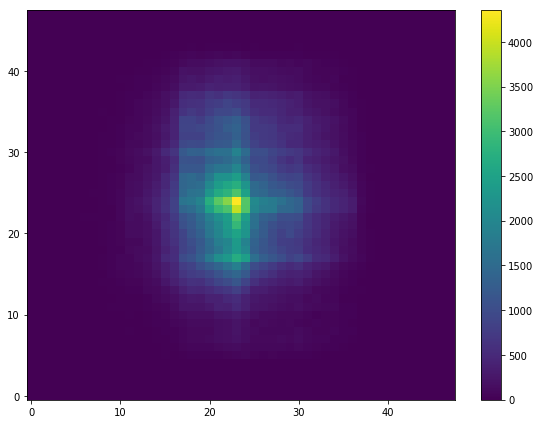

Current= -19.29
Files used: ['CG4B5248.dat', 'CG4B5249.dat', 'CG4B5250.dat', 'CG4B5251.dat', 'CG4B5252.dat', 'CG4B5253.dat', 'CG4B5254.dat', 'CG4B5255.dat', 'CG4B5256.dat', 'CG4B5257.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  753530.7709696613


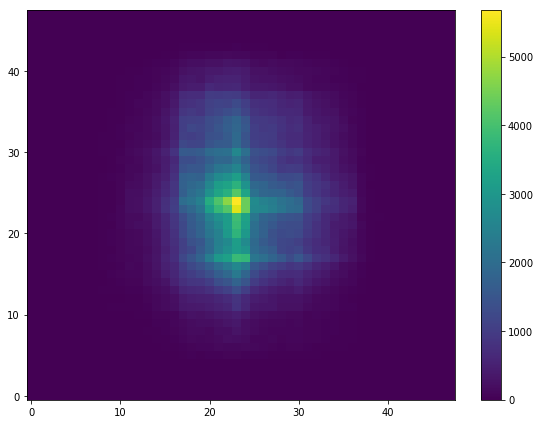

Current= -19.28
Files used: ['CG4B5258.dat', 'CG4B5259.dat', 'CG4B5260.dat', 'CG4B5261.dat', 'CG4B5262.dat', 'CG4B5263.dat', 'CG4B5264.dat', 'CG4B5265.dat', 'CG4B5266.dat', 'CG4B5267.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  941752.8352171328


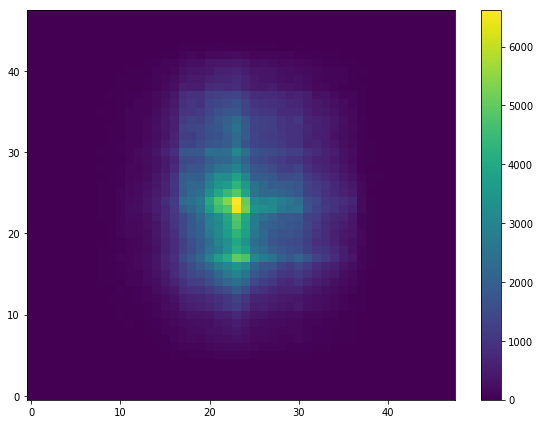

Current= -19.27
Files used: ['CG4B5268.dat', 'CG4B5269.dat', 'CG4B5270.dat', 'CG4B5271.dat', 'CG4B5272.dat', 'CG4B5273.dat', 'CG4B5274.dat', 'CG4B5275.dat', 'CG4B5276.dat', 'CG4B5277.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1078140.6954193923


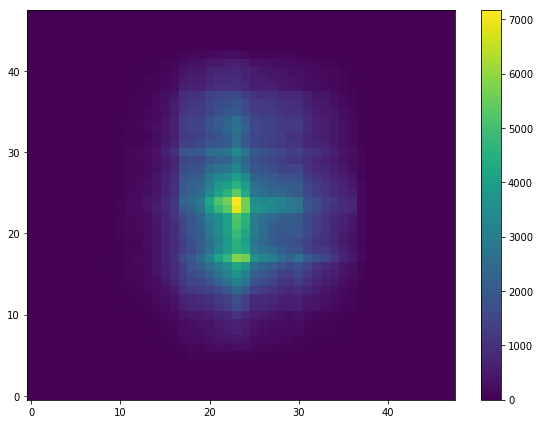

Current= -19.26
Files used: ['CG4B5278.dat', 'CG4B5279.dat', 'CG4B5280.dat', 'CG4B5281.dat', 'CG4B5282.dat', 'CG4B5283.dat', 'CG4B5284.dat', 'CG4B5285.dat', 'CG4B5286.dat', 'CG4B5287.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1122876.2135633556


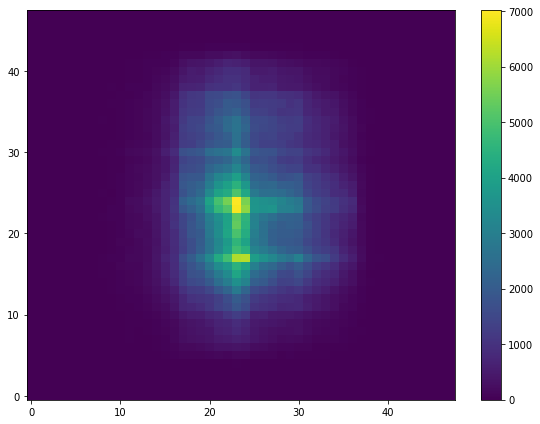

Current= -19.25
Files used: ['CG4B5288.dat', 'CG4B5289.dat', 'CG4B5290.dat', 'CG4B5291.dat', 'CG4B5292.dat', 'CG4B5293.dat', 'CG4B5294.dat', 'CG4B5295.dat', 'CG4B5296.dat', 'CG4B5297.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1082100.032123735


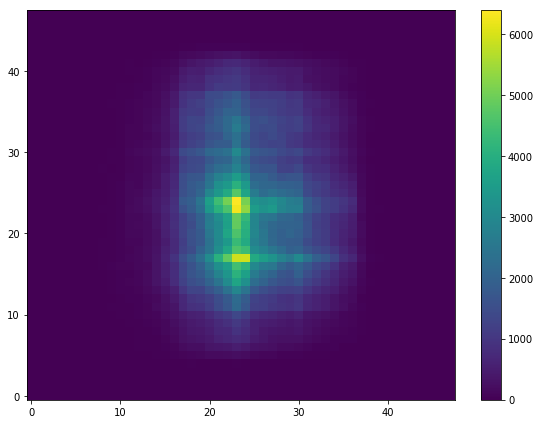

Current= -19.24
Files used: ['CG4B5298.dat', 'CG4B5299.dat', 'CG4B5300.dat', 'CG4B5301.dat', 'CG4B5302.dat', 'CG4B5303.dat', 'CG4B5304.dat', 'CG4B5305.dat', 'CG4B5306.dat', 'CG4B5307.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  950970.1171921463


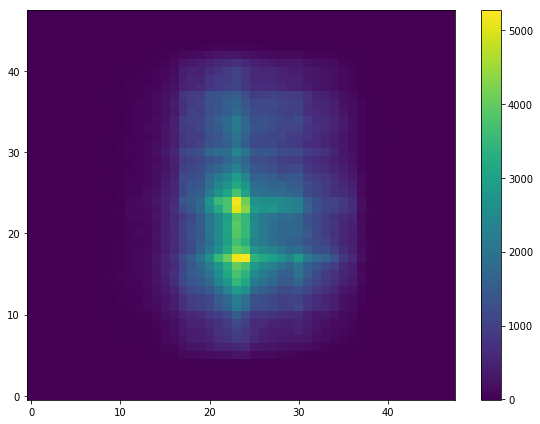

Current= -19.23
Files used: ['CG4B5308.dat', 'CG4B5309.dat', 'CG4B5310.dat', 'CG4B5311.dat', 'CG4B5312.dat', 'CG4B5313.dat', 'CG4B5314.dat', 'CG4B5315.dat', 'CG4B5316.dat', 'CG4B5317.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  772430.8209399177


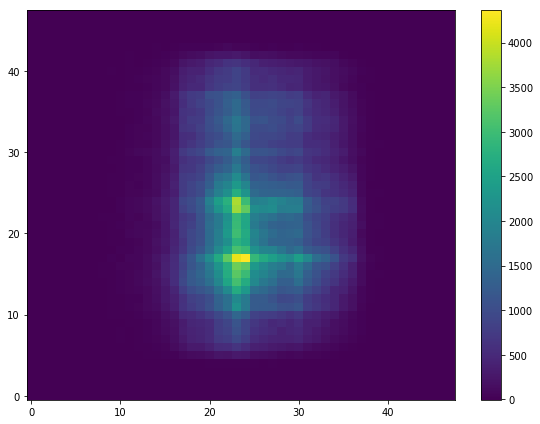

Current= -19.22
Files used: ['CG4B5318.dat', 'CG4B5319.dat', 'CG4B5320.dat', 'CG4B5321.dat', 'CG4B5322.dat', 'CG4B5323.dat', 'CG4B5324.dat', 'CG4B5325.dat', 'CG4B5326.dat', 'CG4B5327.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  564640.97620464


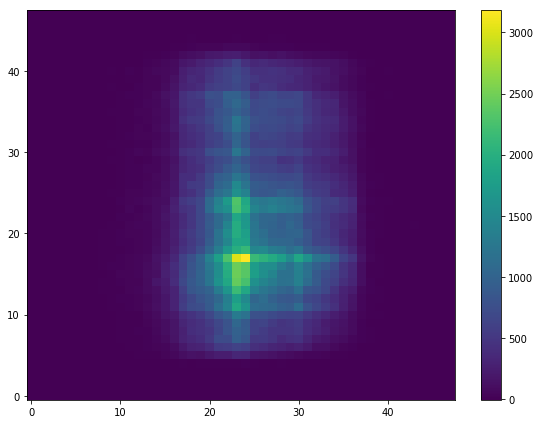

Current= -19.21
Files used: ['CG4B5328.dat', 'CG4B5329.dat', 'CG4B5330.dat', 'CG4B5331.dat', 'CG4B5332.dat', 'CG4B5333.dat', 'CG4B5334.dat', 'CG4B5335.dat', 'CG4B5336.dat', 'CG4B5337.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  354839.47769185004


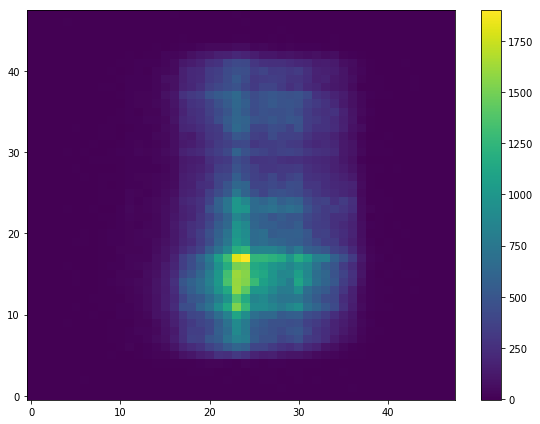

Current= -19.2
Files used: ['CG4B5338.dat', 'CG4B5339.dat', 'CG4B5340.dat', 'CG4B5341.dat', 'CG4B5342.dat', 'CG4B5343.dat', 'CG4B5344.dat', 'CG4B5345.dat', 'CG4B5346.dat', 'CG4B5347.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  210885.23140987504


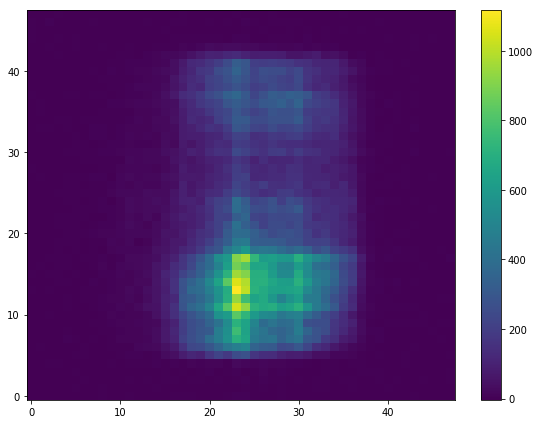

Current= -19.19
Files used: ['CG4B5348.dat', 'CG4B5349.dat', 'CG4B5350.dat', 'CG4B5351.dat', 'CG4B5352.dat', 'CG4B5353.dat', 'CG4B5354.dat', 'CG4B5355.dat', 'CG4B5356.dat', 'CG4B5357.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  137825.5687091017


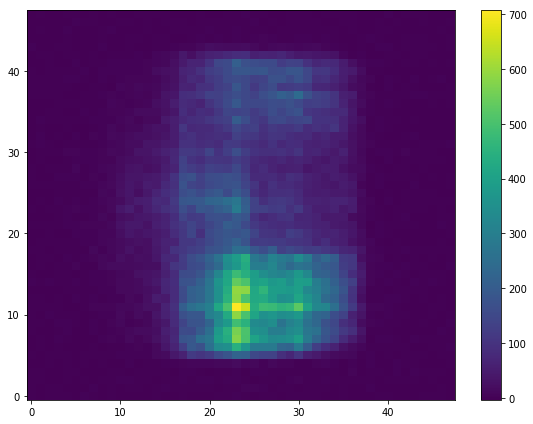

Current= -19.18
Files used: ['CG4B5358.dat', 'CG4B5359.dat', 'CG4B5360.dat', 'CG4B5361.dat', 'CG4B5362.dat', 'CG4B5363.dat', 'CG4B5364.dat', 'CG4B5365.dat', 'CG4B5366.dat', 'CG4B5367.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  153072.93872694843


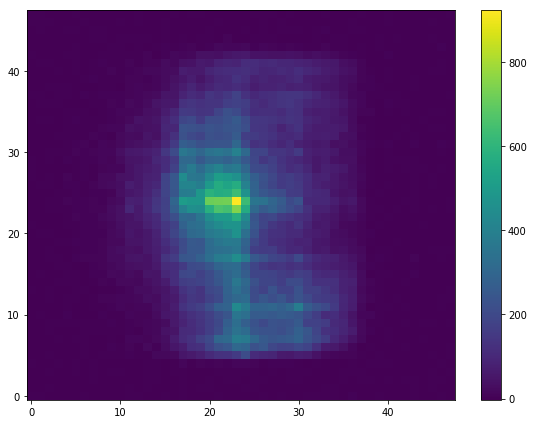

Current= -19.17
Files used: ['CG4B5368.dat', 'CG4B5369.dat', 'CG4B5370.dat', 'CG4B5371.dat', 'CG4B5372.dat', 'CG4B5373.dat', 'CG4B5374.dat', 'CG4B5375.dat', 'CG4B5376.dat', 'CG4B5377.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  255945.715050565


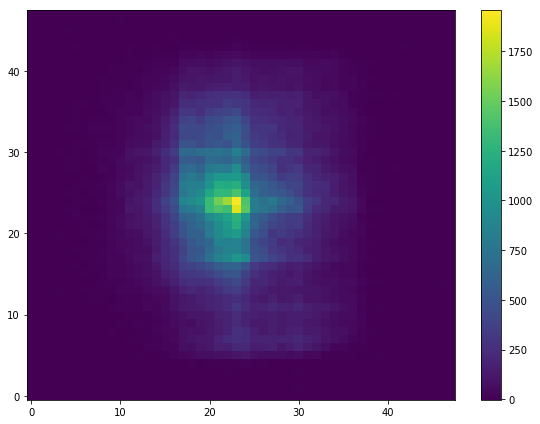

Current= -19.16
Files used: ['CG4B5378.dat', 'CG4B5379.dat', 'CG4B5380.dat', 'CG4B5381.dat', 'CG4B5382.dat', 'CG4B5383.dat', 'CG4B5384.dat', 'CG4B5385.dat', 'CG4B5386.dat', 'CG4B5387.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  426426.9411064848


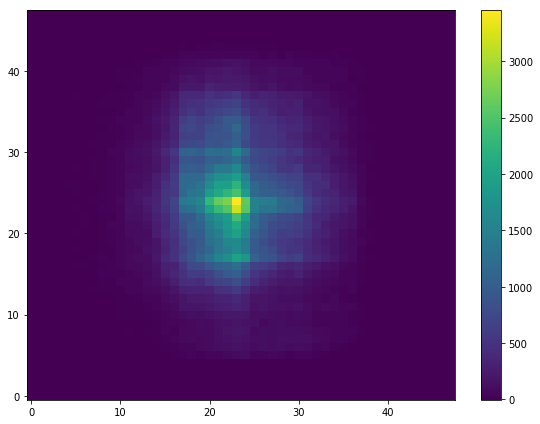

Current= -19.15
Files used: ['CG4B5388.dat', 'CG4B5389.dat', 'CG4B5390.dat', 'CG4B5391.dat', 'CG4B5392.dat', 'CG4B5393.dat', 'CG4B5394.dat', 'CG4B5395.dat', 'CG4B5396.dat', 'CG4B5397.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  643433.7792980381


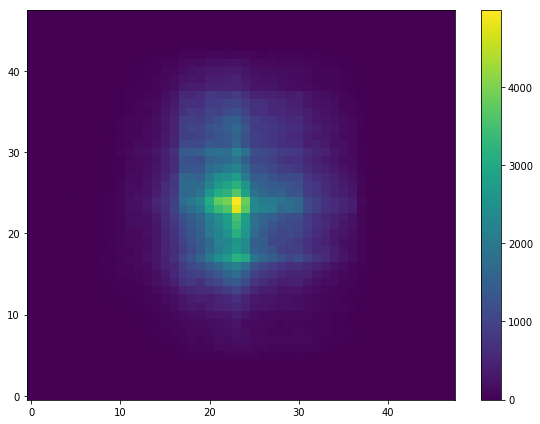

Current= -19.14
Files used: ['CG4B5398.dat', 'CG4B5399.dat', 'CG4B5400.dat', 'CG4B5401.dat', 'CG4B5402.dat', 'CG4B5403.dat', 'CG4B5404.dat', 'CG4B5405.dat', 'CG4B5406.dat', 'CG4B5407.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  843038.8084473525


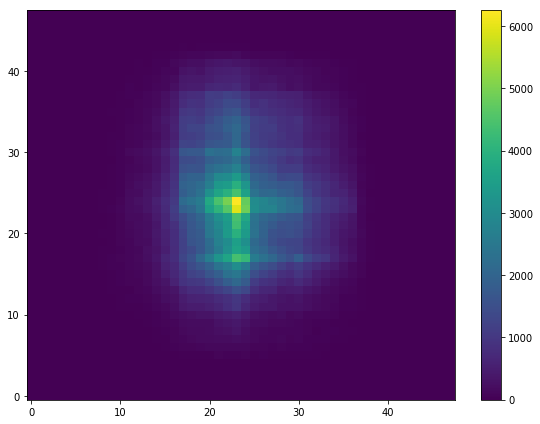

Current= -19.13
Files used: ['CG4B5408.dat', 'CG4B5409.dat', 'CG4B5410.dat', 'CG4B5411.dat', 'CG4B5412.dat', 'CG4B5413.dat', 'CG4B5414.dat', 'CG4B5415.dat', 'CG4B5416.dat', 'CG4B5417.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1005771.6841165972


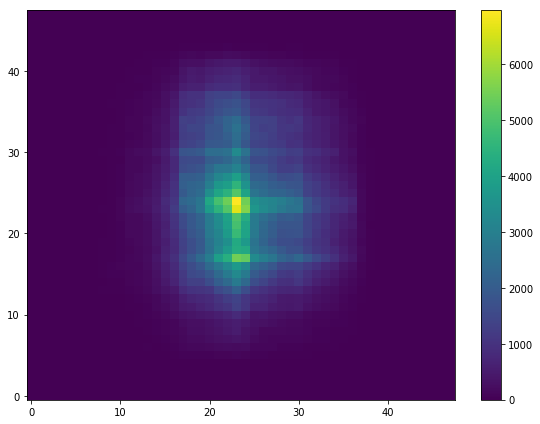

Current= -19.12
Files used: ['CG4B5418.dat', 'CG4B5419.dat', 'CG4B5420.dat', 'CG4B5421.dat', 'CG4B5422.dat', 'CG4B5423.dat', 'CG4B5424.dat', 'CG4B5425.dat', 'CG4B5426.dat', 'CG4B5427.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1106609.4568709098


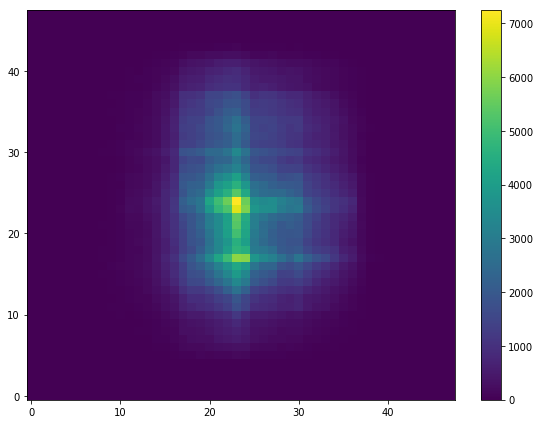

Current= -19.11
Files used: ['CG4B5428.dat', 'CG4B5429.dat', 'CG4B5430.dat', 'CG4B5431.dat', 'CG4B5432.dat', 'CG4B5433.dat', 'CG4B5434.dat', 'CG4B5435.dat', 'CG4B5436.dat', 'CG4B5437.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1114431.4991076738


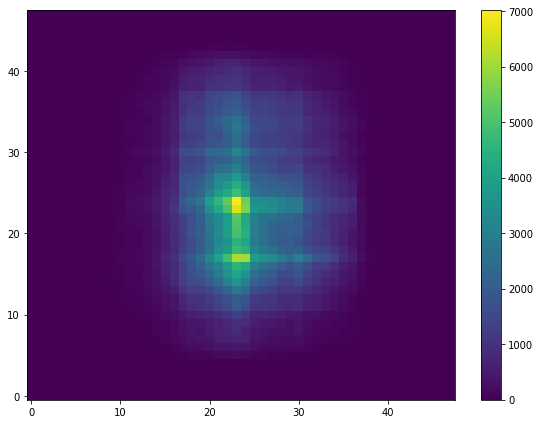

Current= -19.1
Files used: ['CG4B5438.dat', 'CG4B5439.dat', 'CG4B5440.dat', 'CG4B5441.dat', 'CG4B5442.dat', 'CG4B5443.dat', 'CG4B5444.dat', 'CG4B5445.dat', 'CG4B5446.dat', 'CG4B5447.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  1039478.7007733493


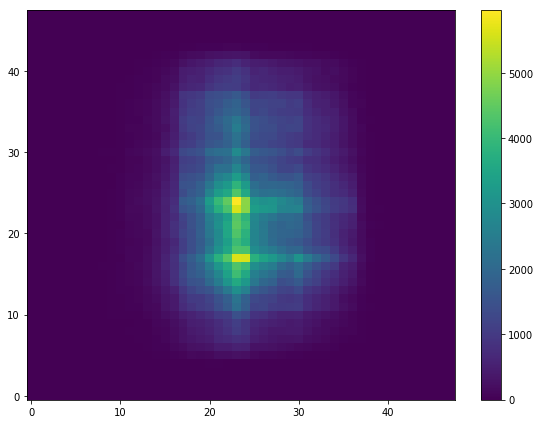

Current= -19.09
Files used: ['CG4B5448.dat', 'CG4B5449.dat', 'CG4B5450.dat', 'CG4B5451.dat', 'CG4B5452.dat', 'CG4B5453.dat', 'CG4B5454.dat', 'CG4B5455.dat', 'CG4B5456.dat', 'CG4B5457.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  878820.1041046993


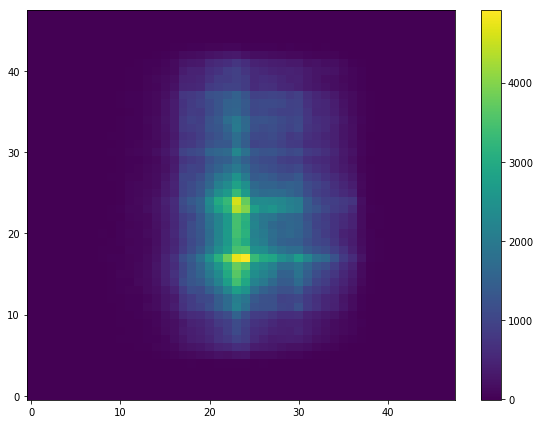

Current= -19.08
Files used: ['CG4B5458.dat', 'CG4B5459.dat', 'CG4B5460.dat', 'CG4B5461.dat', 'CG4B5462.dat', 'CG4B5463.dat', 'CG4B5464.dat', 'CG4B5465.dat', 'CG4B5466.dat', 'CG4B5467.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  680020.972040451


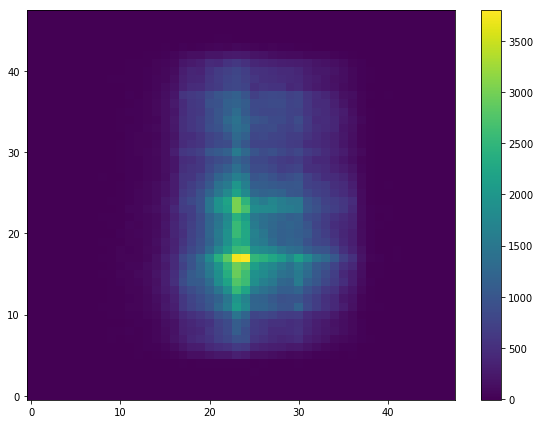

Current= -19.07
Files used: ['CG4B5468.dat', 'CG4B5469.dat', 'CG4B5470.dat', 'CG4B5471.dat', 'CG4B5472.dat', 'CG4B5473.dat', 'CG4B5474.dat', 'CG4B5475.dat', 'CG4B5476.dat', 'CG4B5477.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  473669.23497917823


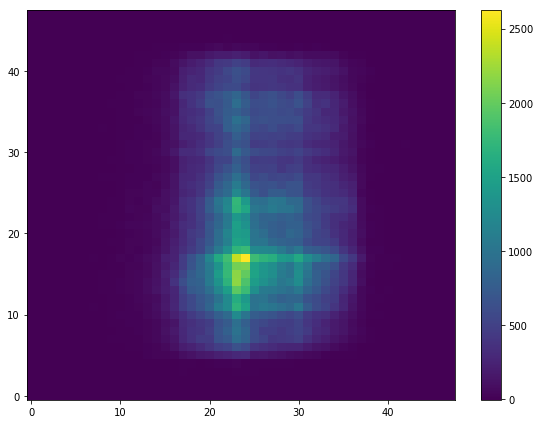

Current= -19.06
Files used: ['CG4B5478.dat', 'CG4B5479.dat', 'CG4B5480.dat', 'CG4B5481.dat', 'CG4B5482.dat', 'CG4B5483.dat', 'CG4B5484.dat', 'CG4B5485.dat', 'CG4B5486.dat', 'CG4B5487.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  88350.65080309339


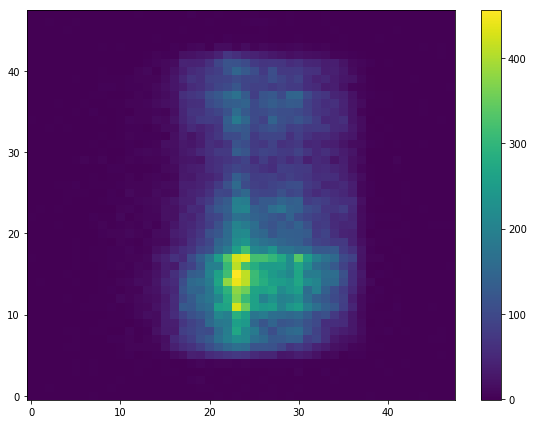

Warning! Missing files:  ['CG4B5481.dat', 'CG4B5482.dat', 'CG4B5483.dat', 'CG4B5484.dat', 'CG4B5485.dat', 'CG4B5486.dat', 'CG4B5487.dat']
Current= -19.05
Files used: ['CG4B5488.dat', 'CG4B5489.dat', 'CG4B5490.dat', 'CG4B5491.dat', 'CG4B5492.dat', 'CG4B5493.dat', 'CG4B5494.dat', 'CG4B5495.dat', 'CG4B5496.dat', 'CG4B5497.dat']
Bin size =  5
Binned pixel size (mm) =  1.0


IndexError: list index out of range

In [47]:
zero_counts = []    #add all subscans that are zero counts here

currents = np.arange(-19.55,-19.,.01)
print("Currents used: ", currents, " \n Total=", len(currents), "\n")
high_counts = []
high_totals = []
start = 4408
subscans = 10

for i in range(len(currents)):
    print("Current=", round(currents[i],3))
    if ((start + (subscans - 1) + int(i)*subscans) not in zero_counts):
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans, \
                          print_summed=True, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
    else: 
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans - 1, \
                          print_summed=True, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
        print("Warning: one subscan failed!")
        
Peak_h = max(high_totals)
Trough_h = min(high_totals)
Peak_current_h = np.argmax(high_totals)
Trough_current_h = np.argmin(high_totals)

print("\n Peak counts: ", Peak_h, "\n Current: ", round(currents[Peak_current_h],3), "\n")
print("\n Trough counts: ", Trough_h, "\n Current: ", round(currents[Trough_current_h],3), "\n")


Precession mode FR= 8.551327427089355


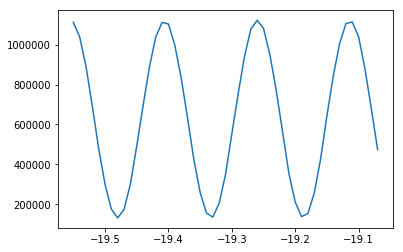

In [54]:
fig = plt.plot(currents[:-7], high_totals[:-1], 'o-')
print("Precession mode FR=", max(high_totals[:-7])/min(high_totals[:-7]))

Currents used:  [19.55 19.54 19.53 19.52 19.51 19.5  19.49 19.48 19.47 19.46 19.45 19.44
 19.43 19.42 19.41 19.4  19.39 19.38 19.37 19.36 19.35 19.34 19.33 19.32
 19.31 19.3  19.29 19.28 19.27 19.26 19.25 19.24 19.23 19.22 19.21 19.2
 19.19 19.18 19.17 19.16 19.15 19.14 19.13 19.12 19.11 19.1  19.09 19.08
 19.07 19.06 19.05 19.04 19.03 19.02 19.01 19.  ]  
 Total= 56 

Current= 19.55
Files used: ['CG4B4408.dat', 'CG4B4409.dat', 'CG4B4410.dat', 'CG4B4411.dat', 'CG4B4412.dat', 'CG4B4413.dat', 'CG4B4414.dat', 'CG4B4415.dat', 'CG4B4416.dat', 'CG4B4417.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  729289.6008328378


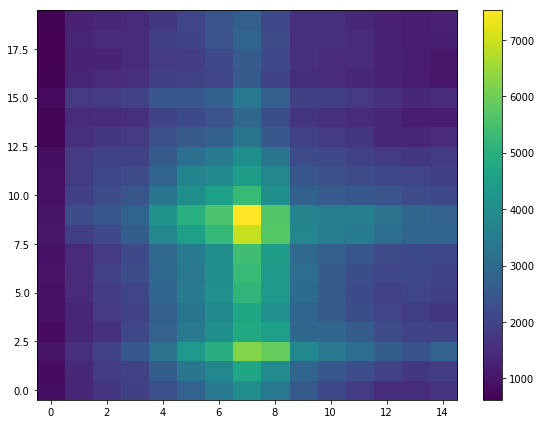

Current= 19.54
Files used: ['CG4B4418.dat', 'CG4B4419.dat', 'CG4B4420.dat', 'CG4B4421.dat', 'CG4B4422.dat', 'CG4B4423.dat', 'CG4B4424.dat', 'CG4B4425.dat', 'CG4B4426.dat', 'CG4B4427.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  709651.7346817369


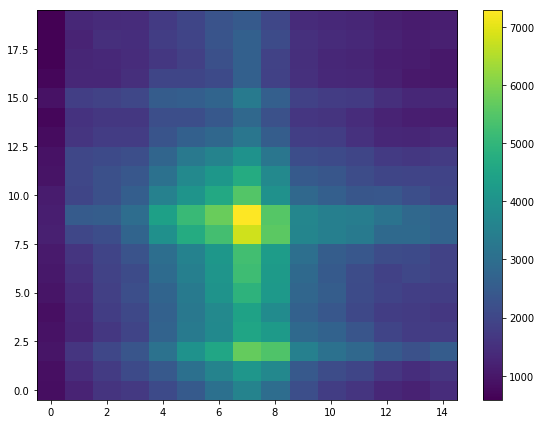

Current= 19.53
Files used: ['CG4B4428.dat', 'CG4B4429.dat', 'CG4B4430.dat', 'CG4B4431.dat', 'CG4B4432.dat', 'CG4B4433.dat', 'CG4B4434.dat', 'CG4B4435.dat', 'CG4B4436.dat', 'CG4B4437.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  633890.4051160022


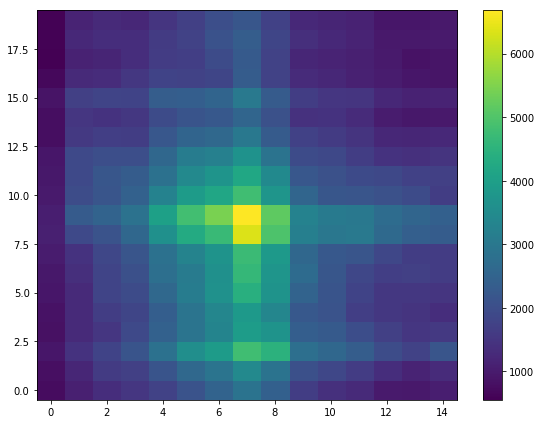

Current= 19.52
Files used: ['CG4B4438.dat', 'CG4B4439.dat', 'CG4B4440.dat', 'CG4B4441.dat', 'CG4B4442.dat', 'CG4B4443.dat', 'CG4B4444.dat', 'CG4B4445.dat', 'CG4B4446.dat', 'CG4B4447.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  516849.45032718615


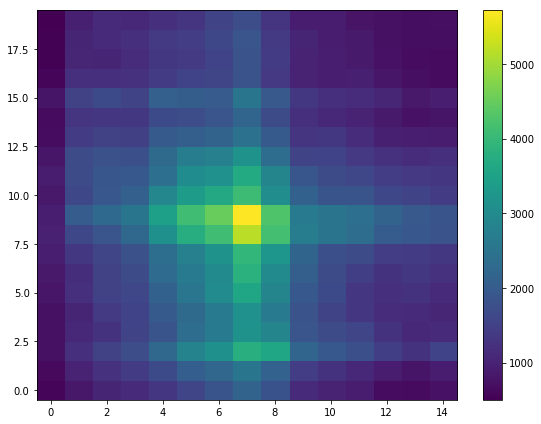

Current= 19.51
Files used: ['CG4B4448.dat', 'CG4B4449.dat', 'CG4B4450.dat', 'CG4B4451.dat', 'CG4B4452.dat', 'CG4B4453.dat', 'CG4B4454.dat', 'CG4B4455.dat', 'CG4B4456.dat', 'CG4B4457.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  368769.4396192743


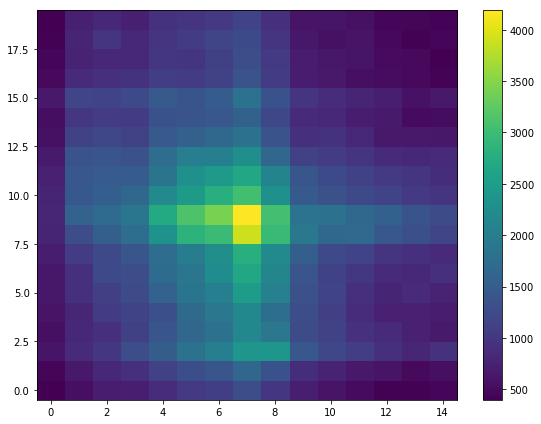

Current= 19.5
Files used: ['CG4B4458.dat', 'CG4B4459.dat', 'CG4B4460.dat', 'CG4B4461.dat', 'CG4B4462.dat', 'CG4B4463.dat', 'CG4B4464.dat', 'CG4B4465.dat', 'CG4B4466.dat', 'CG4B4467.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  234558.78881618087


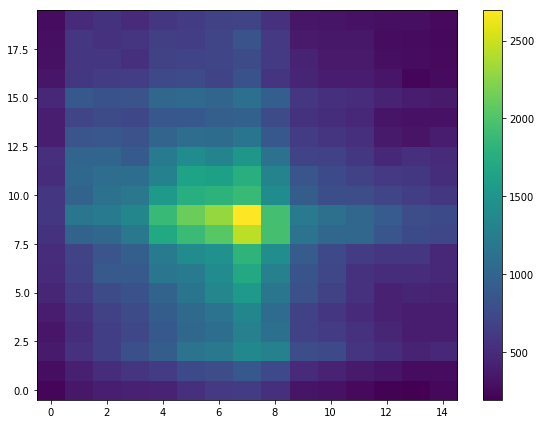

Current= 19.49
Files used: ['CG4B4468.dat', 'CG4B4469.dat', 'CG4B4470.dat', 'CG4B4471.dat', 'CG4B4472.dat', 'CG4B4473.dat', 'CG4B4474.dat', 'CG4B4475.dat', 'CG4B4476.dat', 'CG4B4477.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  126302.21951219512


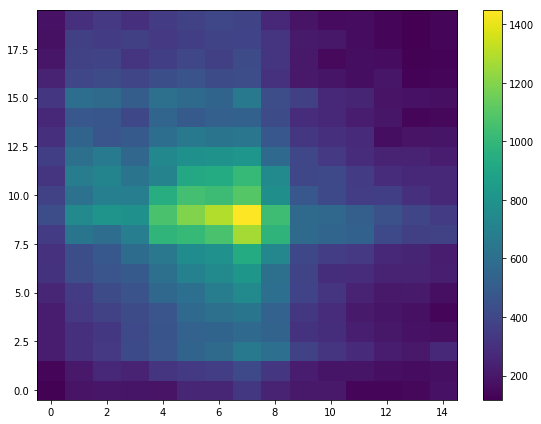

Current= 19.48
Files used: ['CG4B4478.dat', 'CG4B4479.dat', 'CG4B4480.dat', 'CG4B4481.dat', 'CG4B4482.dat', 'CG4B4483.dat', 'CG4B4484.dat', 'CG4B4485.dat', 'CG4B4486.dat', 'CG4B4487.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  52948.68590124924


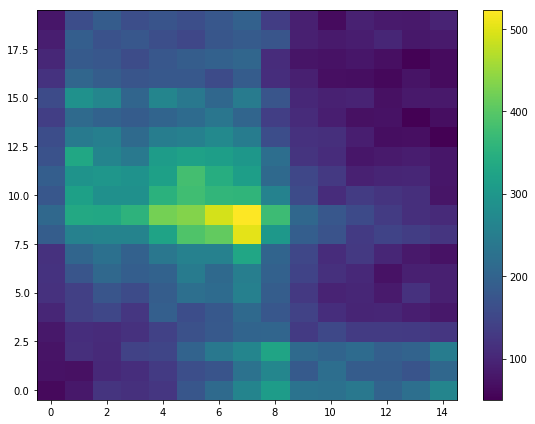

Current= 19.47
Files used: ['CG4B4488.dat', 'CG4B4489.dat', 'CG4B4490.dat', 'CG4B4491.dat', 'CG4B4492.dat', 'CG4B4493.dat', 'CG4B4494.dat', 'CG4B4495.dat', 'CG4B4496.dat', 'CG4B4497.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  48412.37953599049


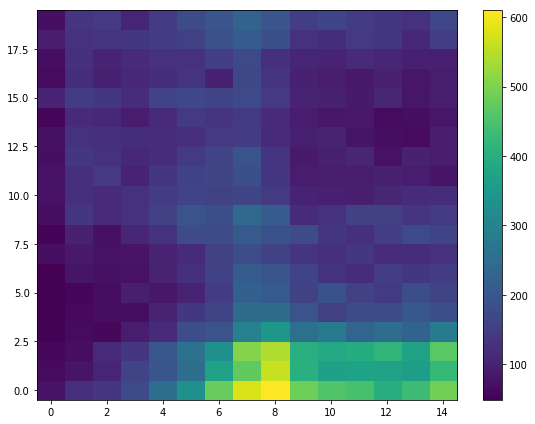

Current= 19.46
Files used: ['CG4B4498.dat', 'CG4B4499.dat', 'CG4B4500.dat', 'CG4B4501.dat', 'CG4B4502.dat', 'CG4B4503.dat', 'CG4B4504.dat', 'CG4B4505.dat', 'CG4B4506.dat', 'CG4B4507.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  101856.18084473531


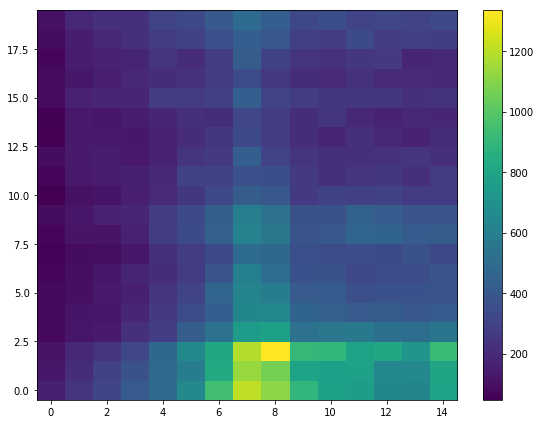

Current= 19.45
Files used: ['CG4B4508.dat', 'CG4B4509.dat', 'CG4B4510.dat', 'CG4B4511.dat', 'CG4B4512.dat', 'CG4B4513.dat', 'CG4B4514.dat', 'CG4B4515.dat', 'CG4B4516.dat', 'CG4B4517.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  211814.70791195714


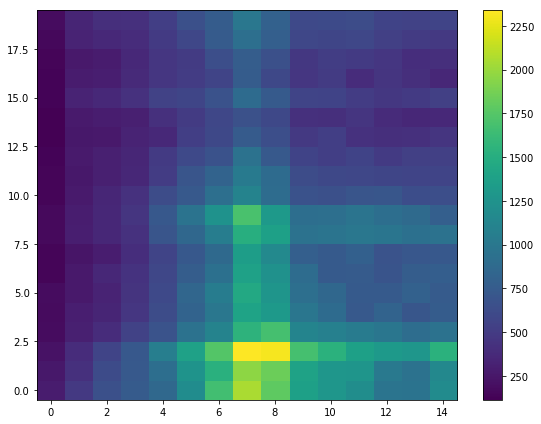

Current= 19.44
Files used: ['CG4B4518.dat', 'CG4B4519.dat', 'CG4B4520.dat', 'CG4B4521.dat', 'CG4B4522.dat', 'CG4B4523.dat', 'CG4B4524.dat', 'CG4B4525.dat', 'CG4B4526.dat', 'CG4B4527.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  344464.8143961927


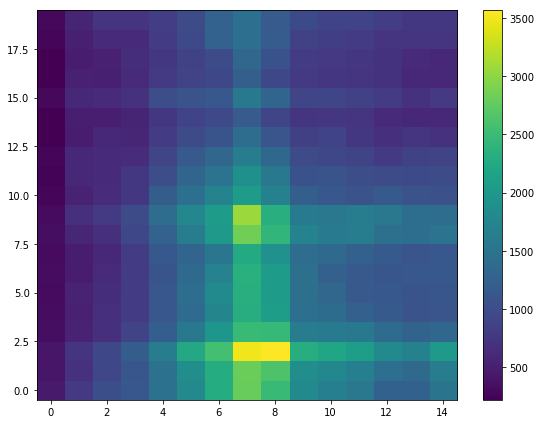

Current= 19.43
Files used: ['CG4B4528.dat', 'CG4B4529.dat', 'CG4B4530.dat', 'CG4B4531.dat', 'CG4B4532.dat', 'CG4B4533.dat', 'CG4B4534.dat', 'CG4B4535.dat', 'CG4B4536.dat', 'CG4B4537.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  480086.3444378347


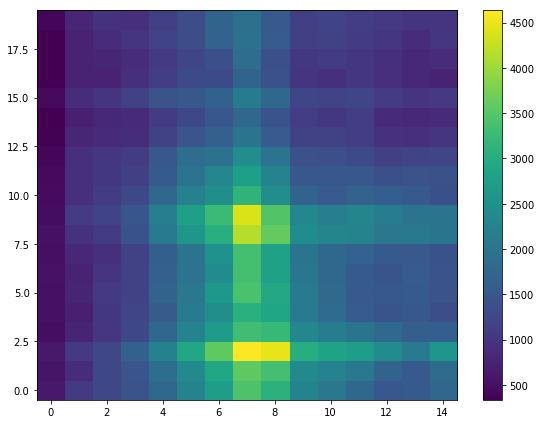

Current= 19.42
Files used: ['CG4B4538.dat', 'CG4B4539.dat', 'CG4B4540.dat', 'CG4B4541.dat', 'CG4B4542.dat', 'CG4B4543.dat', 'CG4B4544.dat', 'CG4B4545.dat', 'CG4B4546.dat', 'CG4B4547.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  616198.6335514574


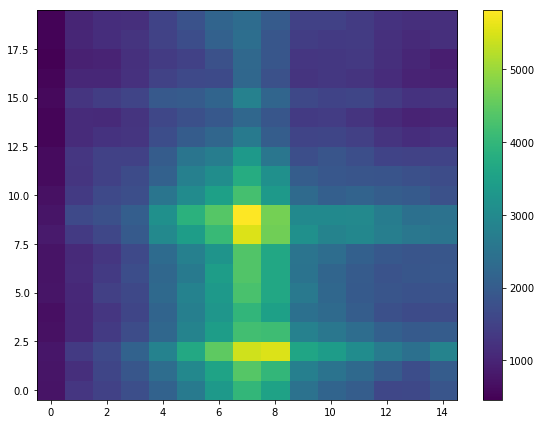

Current= 19.41
Files used: ['CG4B4548.dat', 'CG4B4549.dat', 'CG4B4550.dat', 'CG4B4551.dat', 'CG4B4552.dat', 'CG4B4553.dat', 'CG4B4554.dat', 'CG4B4555.dat', 'CG4B4556.dat', 'CG4B4557.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  701124.1600237954


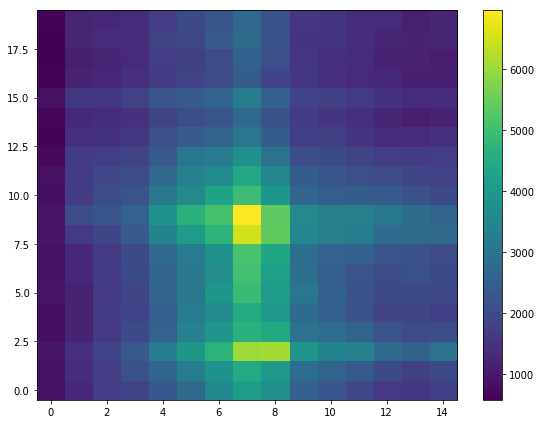

Current= 19.4
Files used: ['CG4B4558.dat', 'CG4B4559.dat', 'CG4B4560.dat', 'CG4B4561.dat', 'CG4B4562.dat', 'CG4B4563.dat', 'CG4B4564.dat', 'CG4B4565.dat', 'CG4B4566.dat', 'CG4B4567.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  731006.3087447947


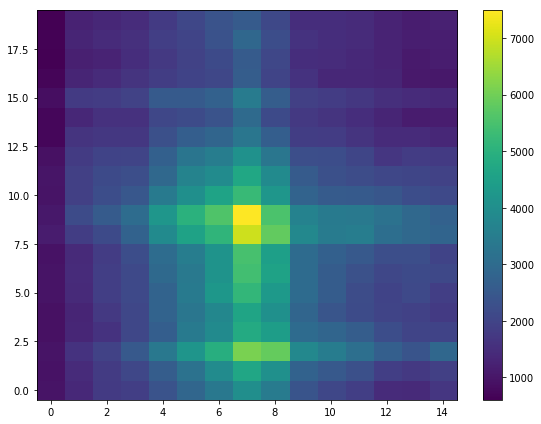

Current= 19.39
Files used: ['CG4B4568.dat', 'CG4B4569.dat', 'CG4B4570.dat', 'CG4B4571.dat', 'CG4B4572.dat', 'CG4B4573.dat', 'CG4B4574.dat', 'CG4B4575.dat', 'CG4B4576.dat', 'CG4B4577.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  700768.6430696016


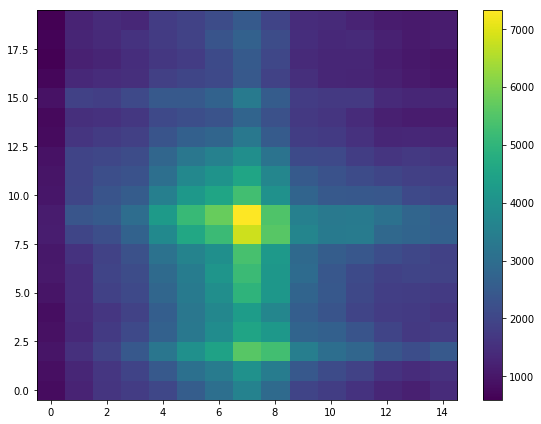

Current= 19.38
Files used: ['CG4B4578.dat', 'CG4B4579.dat', 'CG4B4580.dat', 'CG4B4581.dat', 'CG4B4582.dat', 'CG4B4583.dat', 'CG4B4584.dat', 'CG4B4585.dat', 'CG4B4586.dat', 'CG4B4587.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  619476.7031528851


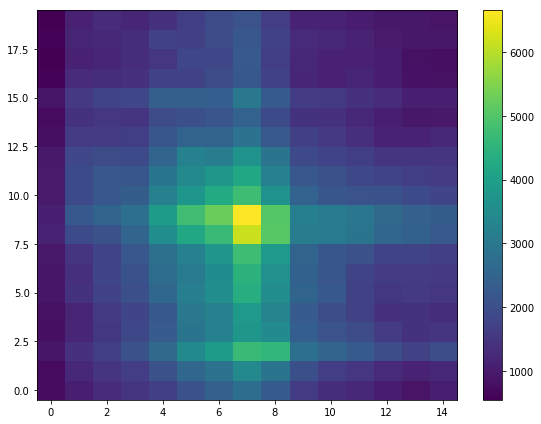

Current= 19.37
Files used: ['CG4B4588.dat', 'CG4B4589.dat', 'CG4B4590.dat', 'CG4B4591.dat', 'CG4B4592.dat', 'CG4B4593.dat', 'CG4B4594.dat', 'CG4B4595.dat', 'CG4B4596.dat', 'CG4B4597.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  504225.07733491965


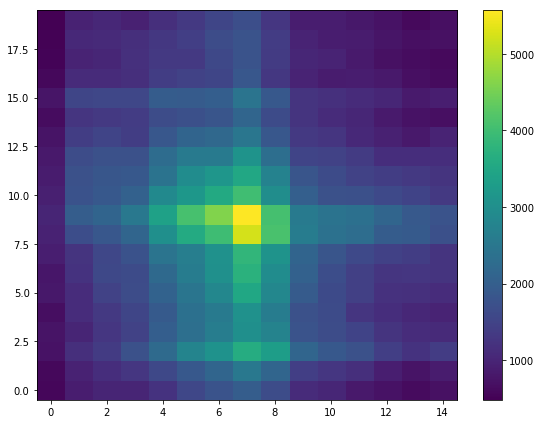

Current= 19.36
Files used: ['CG4B4598.dat', 'CG4B4599.dat', 'CG4B4600.dat', 'CG4B4601.dat', 'CG4B4602.dat', 'CG4B4603.dat', 'CG4B4604.dat', 'CG4B4605.dat', 'CG4B4606.dat', 'CG4B4607.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  349439.3129089827


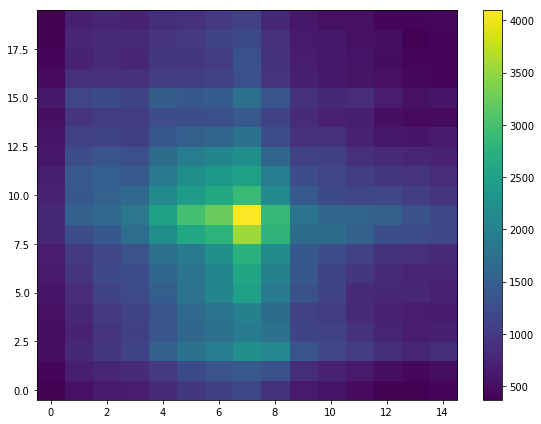

Current= 19.35
Files used: ['CG4B4608.dat', 'CG4B4609.dat', 'CG4B4610.dat', 'CG4B4611.dat', 'CG4B4612.dat', 'CG4B4613.dat', 'CG4B4614.dat', 'CG4B4615.dat', 'CG4B4616.dat', 'CG4B4617.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  207871.97917906014


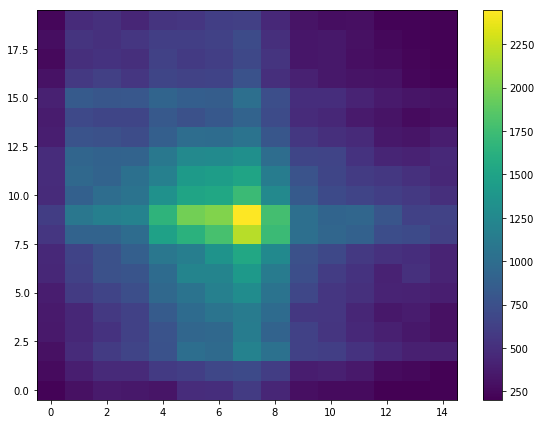

Current= 19.34
Files used: ['CG4B4618.dat', 'CG4B4619.dat', 'CG4B4620.dat', 'CG4B4621.dat', 'CG4B4622.dat', 'CG4B4623.dat', 'CG4B4624.dat', 'CG4B4625.dat', 'CG4B4626.dat', 'CG4B4627.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  105468.87447947648


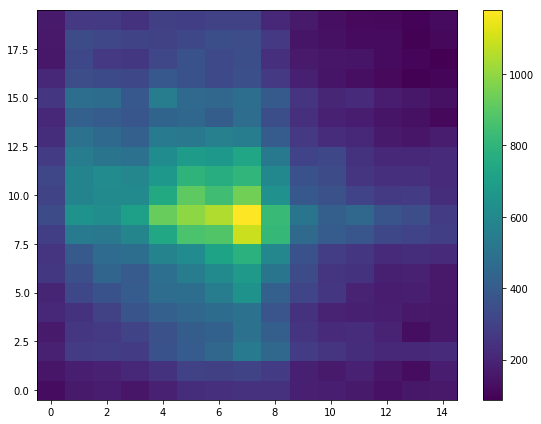

Current= 19.33
Files used: ['CG4B4628.dat', 'CG4B4629.dat', 'CG4B4630.dat', 'CG4B4631.dat', 'CG4B4632.dat', 'CG4B4633.dat', 'CG4B4634.dat', 'CG4B4635.dat', 'CG4B4636.dat', 'CG4B4637.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  47572.35693039857


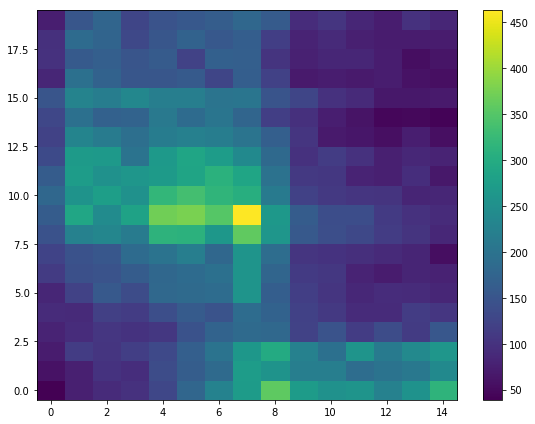

Current= 19.32
Files used: ['CG4B4638.dat', 'CG4B4639.dat', 'CG4B4640.dat', 'CG4B4641.dat', 'CG4B4642.dat', 'CG4B4643.dat', 'CG4B4644.dat', 'CG4B4645.dat', 'CG4B4646.dat', 'CG4B4647.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  53758.98274836406


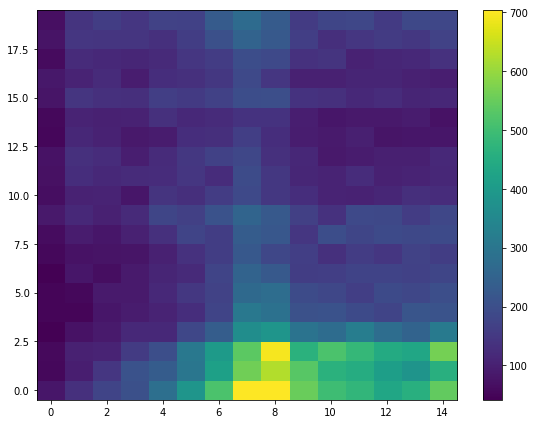

Current= 19.31
Files used: ['CG4B4648.dat', 'CG4B4649.dat', 'CG4B4650.dat', 'CG4B4651.dat', 'CG4B4652.dat', 'CG4B4653.dat', 'CG4B4654.dat', 'CG4B4655.dat', 'CG4B4656.dat', 'CG4B4657.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  117555.43604997029


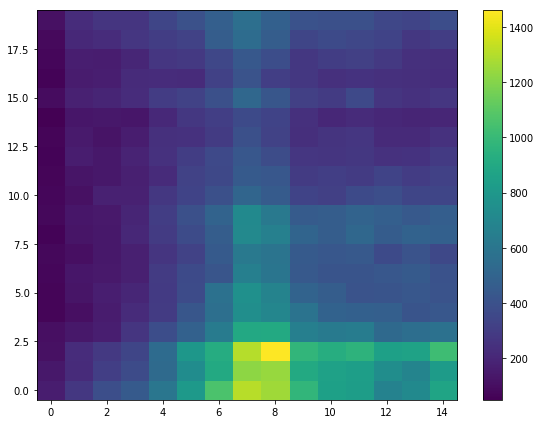

Current= 19.3
Files used: ['CG4B4658.dat', 'CG4B4659.dat', 'CG4B4660.dat', 'CG4B4661.dat', 'CG4B4662.dat', 'CG4B4663.dat', 'CG4B4664.dat', 'CG4B4665.dat', 'CG4B4666.dat', 'CG4B4667.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  236954.42474717431


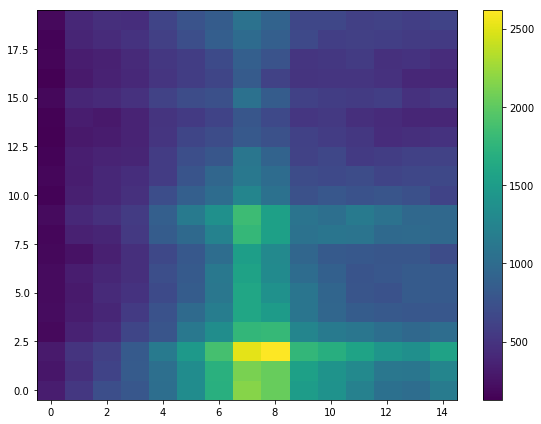

Current= 19.29
Files used: ['CG4B4668.dat', 'CG4B4669.dat', 'CG4B4670.dat', 'CG4B4671.dat', 'CG4B4672.dat', 'CG4B4673.dat', 'CG4B4674.dat', 'CG4B4675.dat', 'CG4B4676.dat', 'CG4B4677.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  382549.85603807267


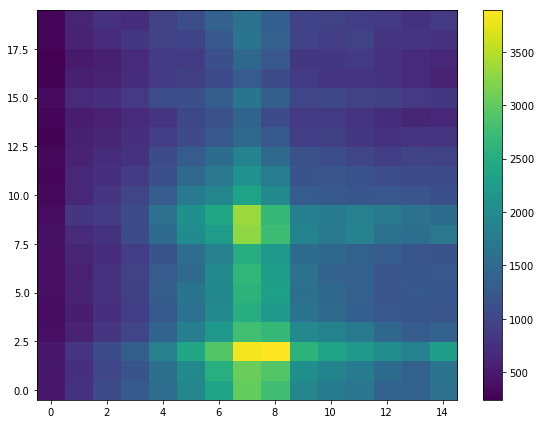

Current= 19.28
Files used: ['CG4B4678.dat', 'CG4B4679.dat', 'CG4B4680.dat', 'CG4B4681.dat', 'CG4B4682.dat', 'CG4B4683.dat', 'CG4B4684.dat', 'CG4B4685.dat', 'CG4B4686.dat', 'CG4B4687.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  518559.5348007142


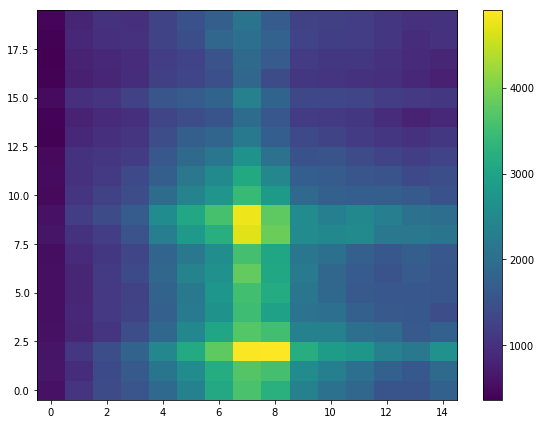

Current= 19.27
Files used: ['CG4B4688.dat', 'CG4B4689.dat', 'CG4B4690.dat', 'CG4B4691.dat', 'CG4B4692.dat', 'CG4B4693.dat', 'CG4B4694.dat', 'CG4B4695.dat', 'CG4B4696.dat', 'CG4B4697.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  637881.1838191554


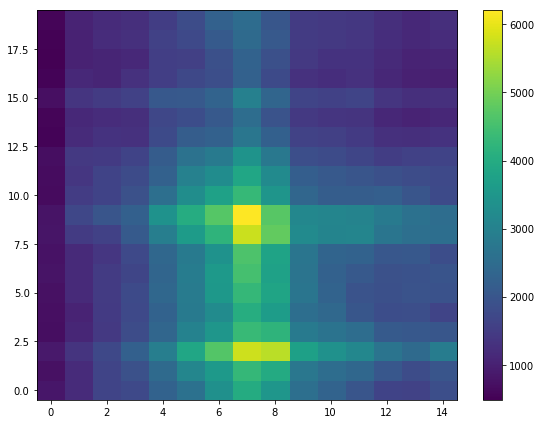

Current= 19.26
Files used: ['CG4B4698.dat', 'CG4B4699.dat', 'CG4B4700.dat', 'CG4B4701.dat', 'CG4B4702.dat', 'CG4B4703.dat', 'CG4B4704.dat', 'CG4B4705.dat', 'CG4B4706.dat', 'CG4B4707.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  713391.3813206425


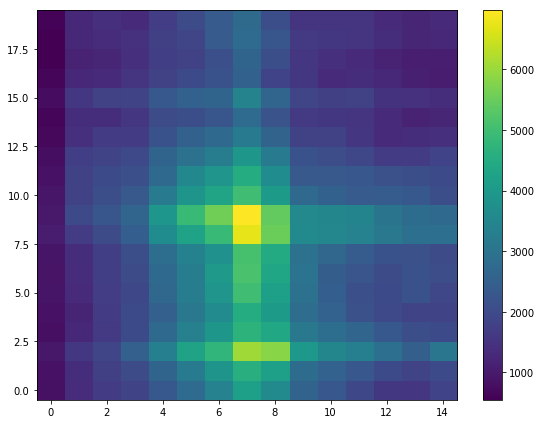

Current= 19.25
Files used: ['CG4B4708.dat', 'CG4B4709.dat', 'CG4B4710.dat', 'CG4B4711.dat', 'CG4B4712.dat', 'CG4B4713.dat', 'CG4B4714.dat', 'CG4B4715.dat', 'CG4B4716.dat', 'CG4B4717.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  728760.0993456277


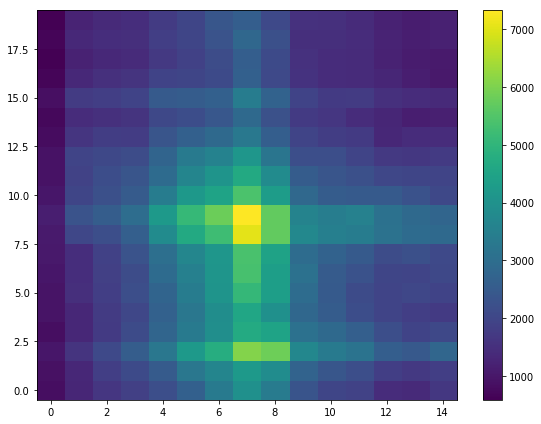

Current= 19.24
Files used: ['CG4B4718.dat', 'CG4B4719.dat', 'CG4B4720.dat', 'CG4B4721.dat', 'CG4B4722.dat', 'CG4B4723.dat', 'CG4B4724.dat', 'CG4B4725.dat', 'CG4B4726.dat', 'CG4B4727.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  679886.2064247468


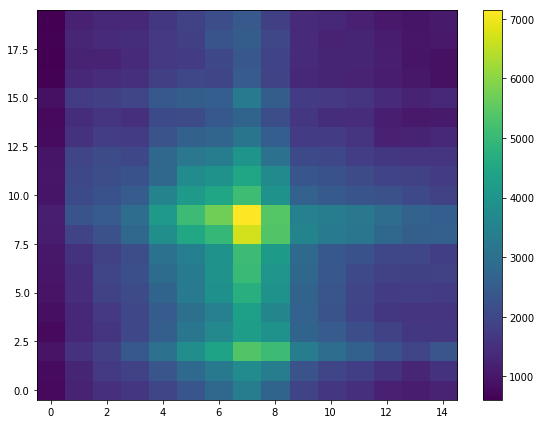

Current= 19.23
Files used: ['CG4B4728.dat', 'CG4B4729.dat', 'CG4B4730.dat', 'CG4B4731.dat', 'CG4B4732.dat', 'CG4B4733.dat', 'CG4B4734.dat', 'CG4B4735.dat', 'CG4B4736.dat', 'CG4B4737.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  576341.6305770373


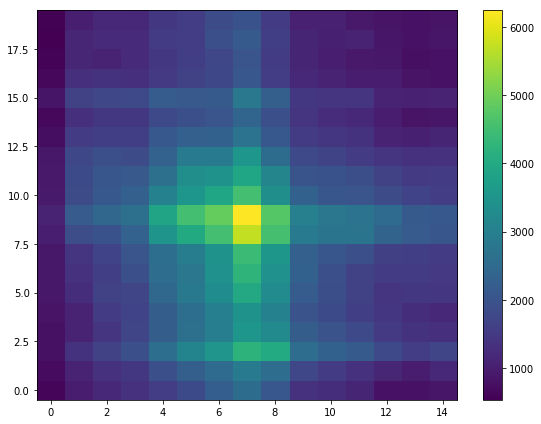

Current= 19.22
Files used: ['CG4B4738.dat', 'CG4B4739.dat', 'CG4B4740.dat', 'CG4B4741.dat', 'CG4B4742.dat', 'CG4B4743.dat', 'CG4B4744.dat', 'CG4B4745.dat', 'CG4B4746.dat', 'CG4B4747.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  445104.48423557397


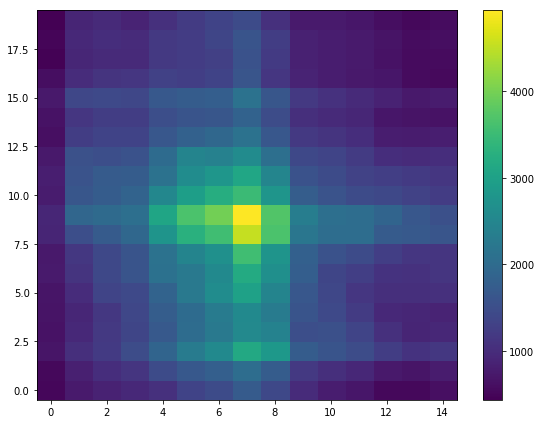

Current= 19.21
Files used: ['CG4B4748.dat', 'CG4B4749.dat', 'CG4B4750.dat', 'CG4B4751.dat', 'CG4B4752.dat', 'CG4B4753.dat', 'CG4B4754.dat', 'CG4B4755.dat', 'CG4B4756.dat', 'CG4B4757.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  298321.0339083878


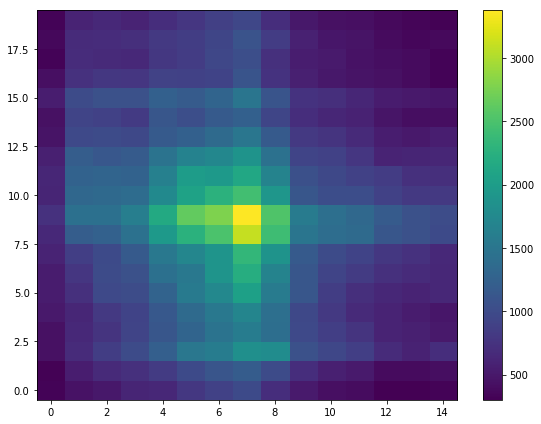

Current= 19.2
Files used: ['CG4B4758.dat', 'CG4B4759.dat', 'CG4B4760.dat', 'CG4B4761.dat', 'CG4B4762.dat', 'CG4B4763.dat', 'CG4B4764.dat', 'CG4B4765.dat', 'CG4B4766.dat', 'CG4B4767.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  167032.8066627008


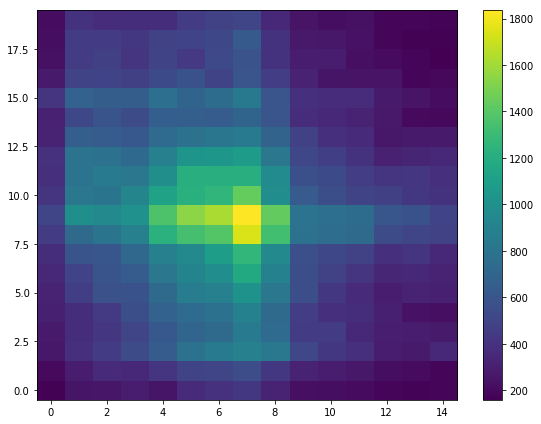

Current= 19.19
Files used: ['CG4B4768.dat', 'CG4B4769.dat', 'CG4B4770.dat', 'CG4B4771.dat', 'CG4B4772.dat', 'CG4B4773.dat', 'CG4B4774.dat', 'CG4B4775.dat', 'CG4B4776.dat', 'CG4B4777.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  78846.95121951218


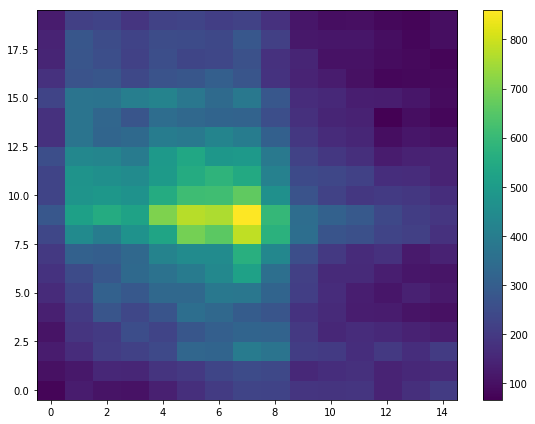

Current= 19.18
Files used: ['CG4B4778.dat', 'CG4B4779.dat', 'CG4B4780.dat', 'CG4B4781.dat', 'CG4B4782.dat', 'CG4B4783.dat', 'CG4B4784.dat', 'CG4B4785.dat', 'CG4B4786.dat', 'CG4B4787.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  43404.74063057703


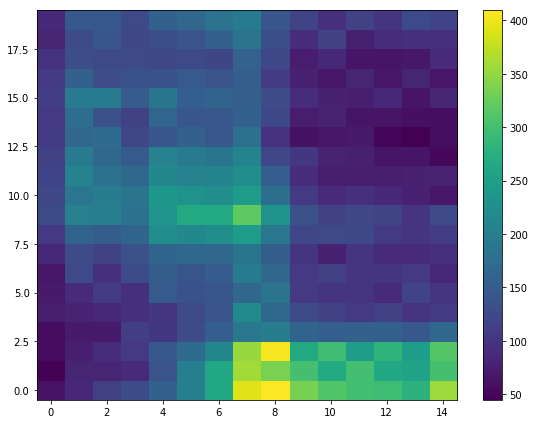

Current= 19.17
Files used: ['CG4B4788.dat', 'CG4B4789.dat', 'CG4B4790.dat', 'CG4B4791.dat', 'CG4B4792.dat', 'CG4B4793.dat', 'CG4B4794.dat', 'CG4B4795.dat', 'CG4B4796.dat', 'CG4B4797.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  71203.18203450325


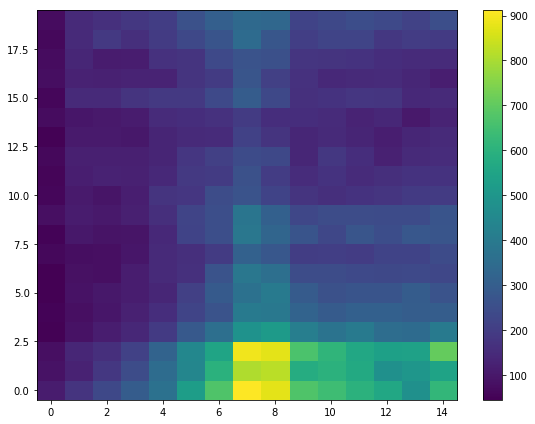

Current= 19.16
Files used: ['CG4B4798.dat', 'CG4B4799.dat', 'CG4B4800.dat', 'CG4B4801.dat', 'CG4B4802.dat', 'CG4B4803.dat', 'CG4B4804.dat', 'CG4B4805.dat', 'CG4B4806.dat', 'CG4B4807.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  155411.02498512782


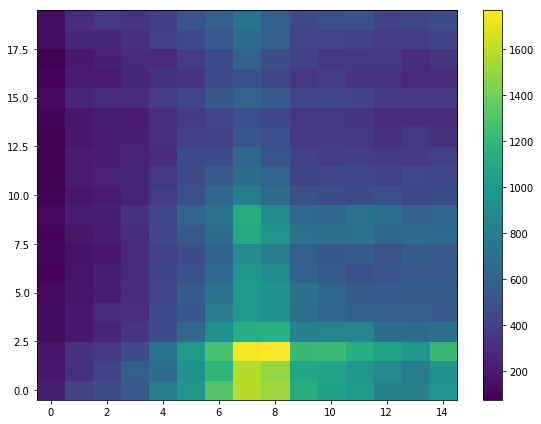

Current= 19.15
Files used: ['CG4B4808.dat', 'CG4B4809.dat', 'CG4B4810.dat', 'CG4B4811.dat', 'CG4B4812.dat', 'CG4B4813.dat', 'CG4B4814.dat', 'CG4B4815.dat', 'CG4B4816.dat', 'CG4B4817.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  277908.57703747763


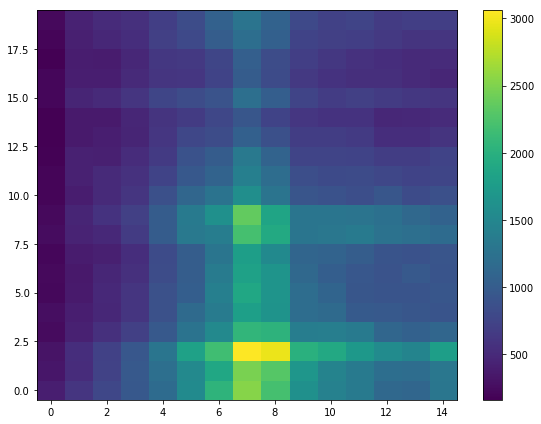

Current= 19.14
Files used: ['CG4B4818.dat', 'CG4B4819.dat', 'CG4B4820.dat', 'CG4B4821.dat', 'CG4B4822.dat', 'CG4B4823.dat', 'CG4B4824.dat', 'CG4B4825.dat', 'CG4B4826.dat', 'CG4B4827.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  419939.62165377743


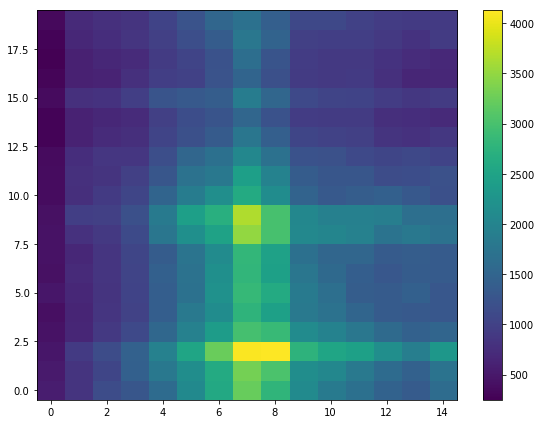

Current= 19.13
Files used: ['CG4B4828.dat', 'CG4B4829.dat', 'CG4B4830.dat', 'CG4B4831.dat', 'CG4B4832.dat', 'CG4B4833.dat', 'CG4B4834.dat', 'CG4B4835.dat', 'CG4B4836.dat', 'CG4B4837.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  558580.8637715647


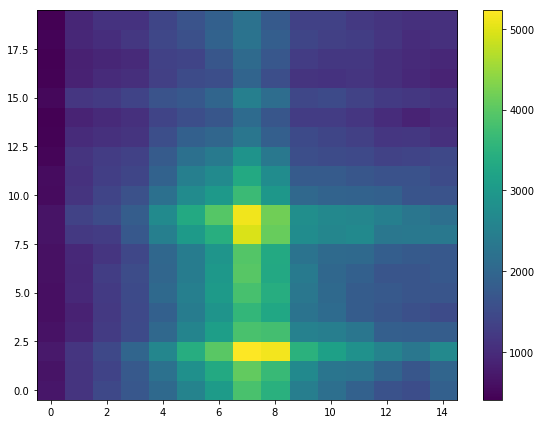

Current= 19.12
Files used: ['CG4B4838.dat', 'CG4B4839.dat', 'CG4B4840.dat', 'CG4B4841.dat', 'CG4B4842.dat', 'CG4B4843.dat', 'CG4B4844.dat', 'CG4B4845.dat', 'CG4B4846.dat', 'CG4B4847.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  667118.4419988103


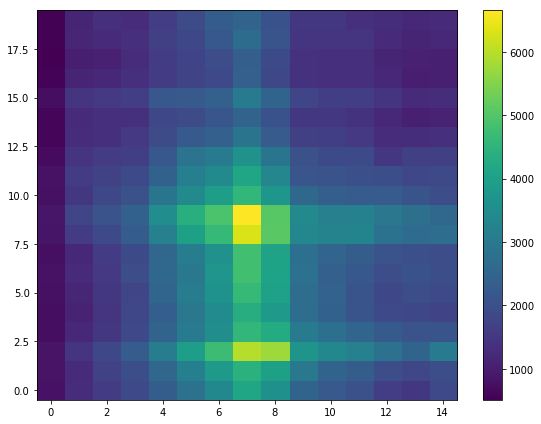

Current= 19.11
Files used: ['CG4B4848.dat', 'CG4B4849.dat', 'CG4B4850.dat', 'CG4B4851.dat', 'CG4B4852.dat', 'CG4B4853.dat', 'CG4B4854.dat', 'CG4B4855.dat', 'CG4B4856.dat', 'CG4B4857.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  724121.8929208808


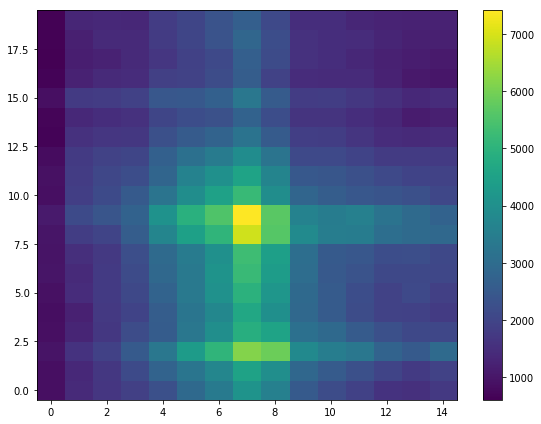

Current= 19.1
Files used: ['CG4B4858.dat', 'CG4B4859.dat', 'CG4B4860.dat', 'CG4B4861.dat', 'CG4B4862.dat', 'CG4B4863.dat', 'CG4B4864.dat', 'CG4B4865.dat', 'CG4B4866.dat', 'CG4B4867.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  719011.2111838188


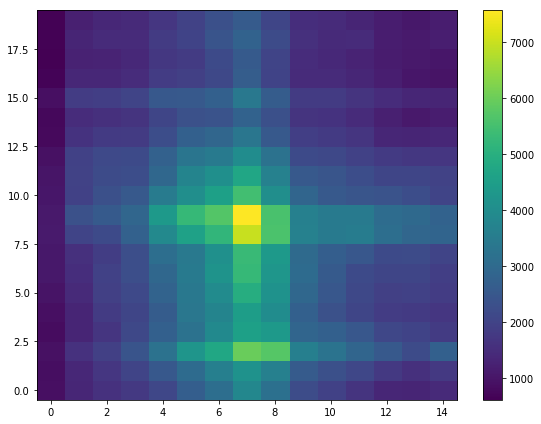

Current= 19.09
Files used: ['CG4B4868.dat', 'CG4B4869.dat', 'CG4B4870.dat', 'CG4B4871.dat', 'CG4B4872.dat', 'CG4B4873.dat', 'CG4B4874.dat', 'CG4B4875.dat', 'CG4B4876.dat', 'CG4B4877.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  655135.9791790602


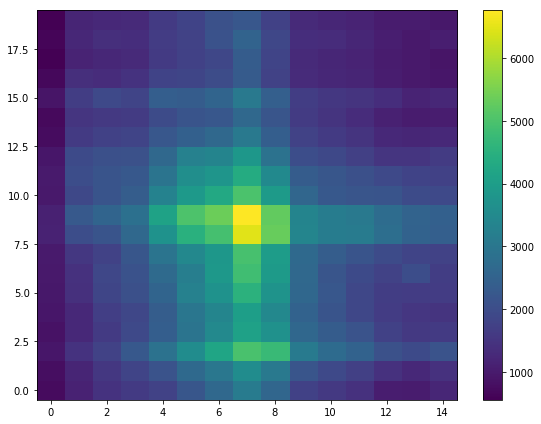

Current= 19.08
Files used: ['CG4B4878.dat', 'CG4B4879.dat', 'CG4B4880.dat', 'CG4B4881.dat', 'CG4B4882.dat', 'CG4B4883.dat', 'CG4B4884.dat', 'CG4B4885.dat', 'CG4B4886.dat', 'CG4B4887.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  542111.8798334327


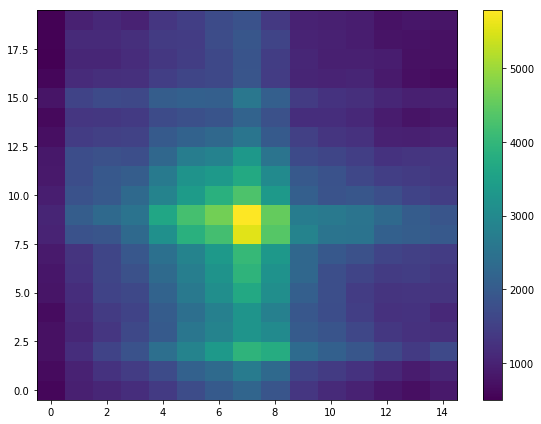

Current= 19.07
Files used: ['CG4B4888.dat', 'CG4B4889.dat', 'CG4B4890.dat', 'CG4B4891.dat', 'CG4B4892.dat', 'CG4B4893.dat', 'CG4B4894.dat', 'CG4B4895.dat', 'CG4B4896.dat', 'CG4B4897.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  395547.19631171937


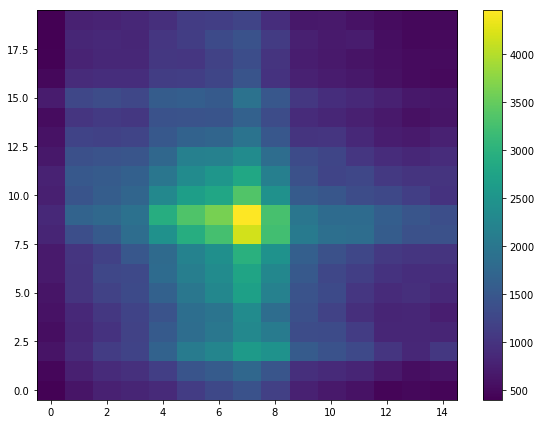

Current= 19.06
Files used: ['CG4B4898.dat', 'CG4B4899.dat', 'CG4B4900.dat', 'CG4B4901.dat', 'CG4B4902.dat', 'CG4B4903.dat', 'CG4B4904.dat', 'CG4B4905.dat', 'CG4B4906.dat', 'CG4B4907.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  254249.24925639492


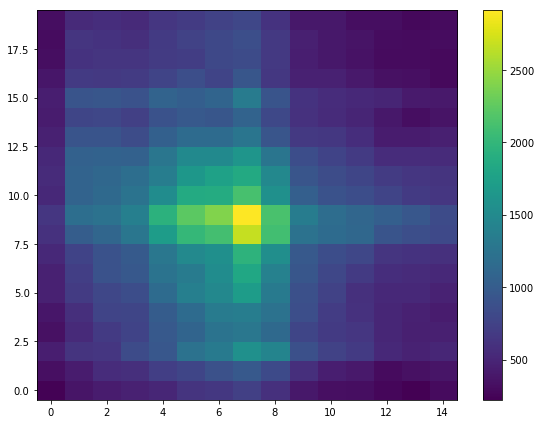

Current= 19.05
Files used: ['CG4B4908.dat', 'CG4B4909.dat', 'CG4B4910.dat', 'CG4B4911.dat', 'CG4B4912.dat', 'CG4B4913.dat', 'CG4B4914.dat', 'CG4B4915.dat', 'CG4B4916.dat', 'CG4B4917.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  134653.7299226651


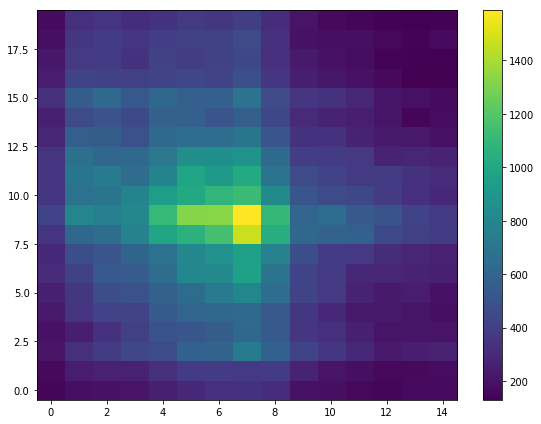

Current= 19.04
Files used: ['CG4B4918.dat', 'CG4B4919.dat', 'CG4B4920.dat', 'CG4B4921.dat', 'CG4B4922.dat', 'CG4B4923.dat', 'CG4B4924.dat', 'CG4B4925.dat', 'CG4B4926.dat', 'CG4B4927.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  59495.73884592507


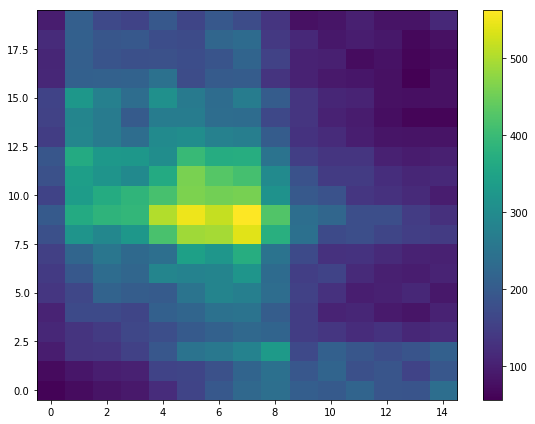

Current= 19.03
Files used: ['CG4B4928.dat', 'CG4B4929.dat', 'CG4B4930.dat', 'CG4B4931.dat', 'CG4B4932.dat', 'CG4B4933.dat', 'CG4B4934.dat', 'CG4B4935.dat', 'CG4B4936.dat', 'CG4B4937.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  44683.6537775134


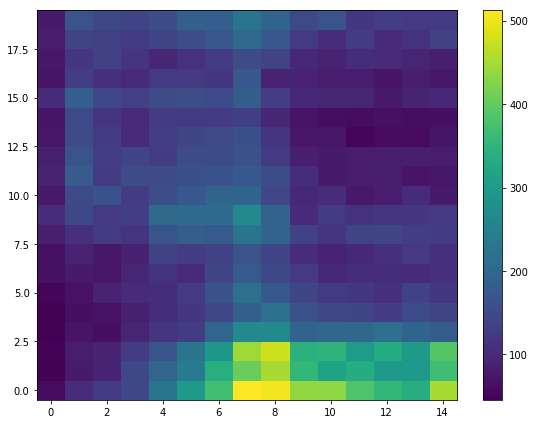

Current= 19.02
Files used: ['CG4B4938.dat', 'CG4B4939.dat', 'CG4B4940.dat', 'CG4B4941.dat', 'CG4B4942.dat', 'CG4B4943.dat', 'CG4B4944.dat', 'CG4B4945.dat', 'CG4B4946.dat', 'CG4B4947.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  89511.34741225459


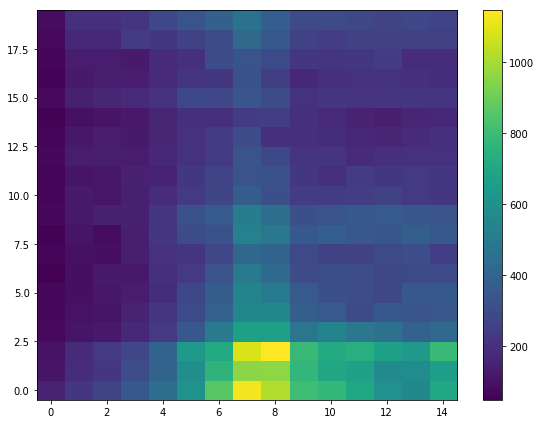

Current= 19.01
Files used: ['CG4B4948.dat', 'CG4B4949.dat', 'CG4B4950.dat', 'CG4B4951.dat', 'CG4B4952.dat', 'CG4B4953.dat', 'CG4B4954.dat', 'CG4B4955.dat', 'CG4B4956.dat', 'CG4B4957.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  195969.4217727543


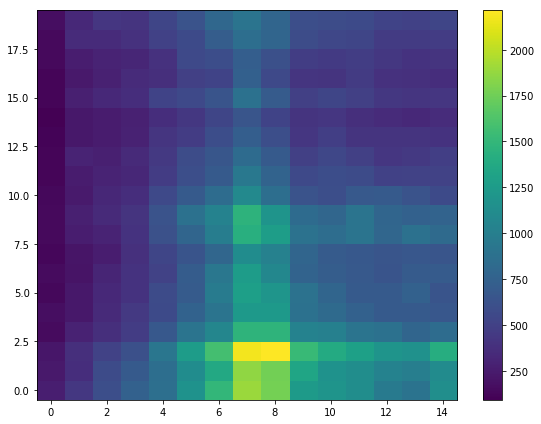

Current= 19.0
Files used: ['CG4B4958.dat', 'CG4B4959.dat', 'CG4B4960.dat', 'CG4B4961.dat', 'CG4B4962.dat', 'CG4B4963.dat', 'CG4B4964.dat', 'CG4B4965.dat', 'CG4B4966.dat', 'CG4B4967.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  351617.6579417013


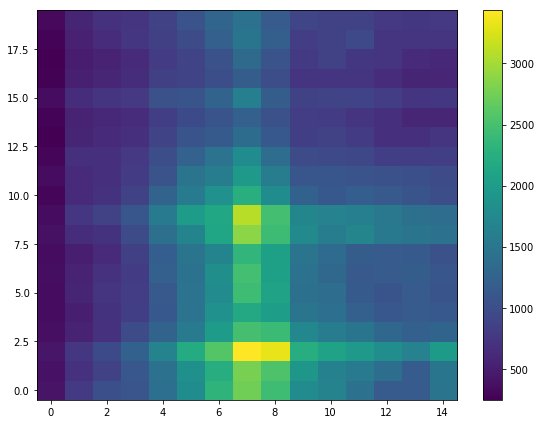


 Peak counts:  731006.3087447947 
 Current:  19.4 


 Trough counts:  43404.74063057703 
 Current:  19.18 



In [87]:
zero_counts = []    #add all subscans that are zero counts here

currents = np.arange(19.55,19.,-.01)
print("Currents used: ", currents, " \n Total=", len(currents), "\n")
high_counts = []
high_totals = []
start = 4408
subscans = 10

for i in range(len(currents)):
    print("Current=", round(currents[i],3))
    if ((start + (subscans - 1) + int(i)*subscans) not in zero_counts):
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans, \
                          print_summed=True, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
    else: 
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans - 1, \
                          print_summed=True, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
        print("Warning: one subscan failed!")
        
Peak_h = max(high_totals)
Trough_h = min(high_totals)
Peak_current_h = np.argmax(high_totals)
Trough_current_h = np.argmin(high_totals)

print("\n Peak counts: ", Peak_h, "\n Current: ", round(currents[Peak_current_h],3), "\n")
print("\n Trough counts: ", Trough_h, "\n Current: ", round(currents[Trough_current_h],3), "\n")


Precession mode FR= 16.841623705725542


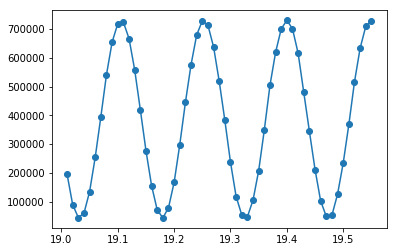

In [88]:
fig = plt.plot(currents[:-1], high_totals[:-1], "-o")
print("Precession mode FR=", max(high_totals[:-1])/min(high_totals[:-1]))

In [64]:
period = 0.16
lambda0 = 5.5
larmor_constant = 4.63e4
length = .075

GPA = 2*np.pi/(larmor_constant*lambda0*length*period)
print("Gauss per amp =", GPA*1e4)

Gauss per amp = 20.56150699384641


Currents used:  [8.   8.02 8.04 8.06 8.08 8.1  8.12 8.14 8.16 8.18 8.2  8.22 8.24 8.26
 8.28 8.3  8.32 8.34 8.36 8.38 8.4  8.42 8.44 8.46 8.48]  
 Total= 25 

Current= 8.0
Files used: ['CG4B5629.dat', 'CG4B5630.dat', 'CG4B5631.dat', 'CG4B5632.dat', 'CG4B5633.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  80017.78584176078


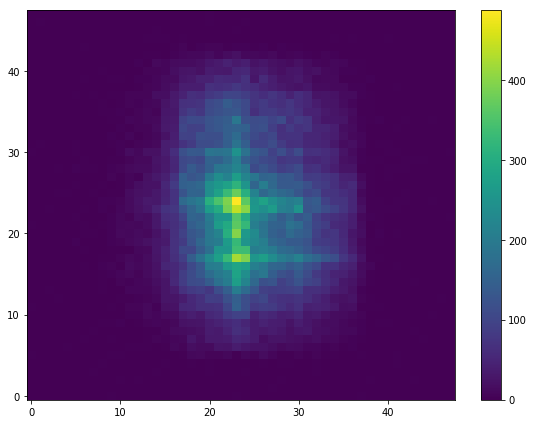

Current= 8.02
Files used: ['CG4B5634.dat', 'CG4B5635.dat', 'CG4B5636.dat', 'CG4B5637.dat', 'CG4B5638.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  80258.15645449141


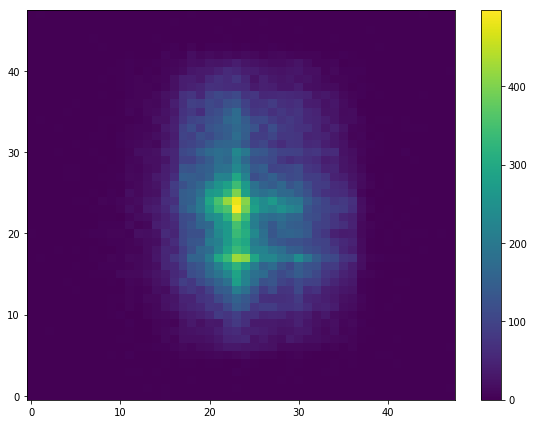

Current= 8.04
Files used: ['CG4B5639.dat', 'CG4B5640.dat', 'CG4B5641.dat', 'CG4B5642.dat', 'CG4B5643.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  79870.80785246885


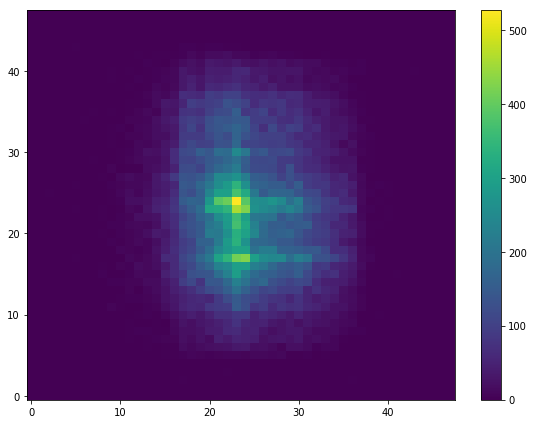

Current= 8.06
Files used: ['CG4B5644.dat', 'CG4B5645.dat', 'CG4B5646.dat', 'CG4B5647.dat', 'CG4B5648.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  78937.7025580011


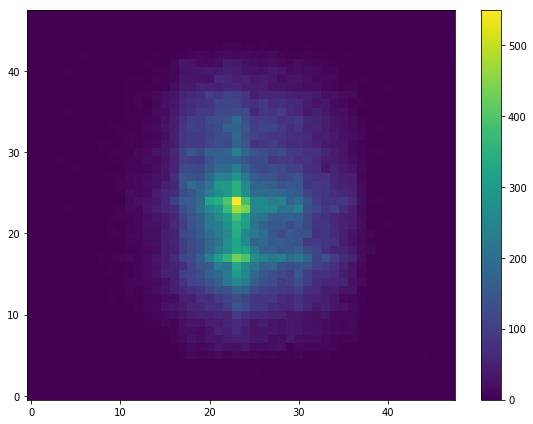

Current= 8.08
Files used: ['CG4B5649.dat', 'CG4B5650.dat', 'CG4B5651.dat', 'CG4B5652.dat', 'CG4B5653.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  78620.70910172517


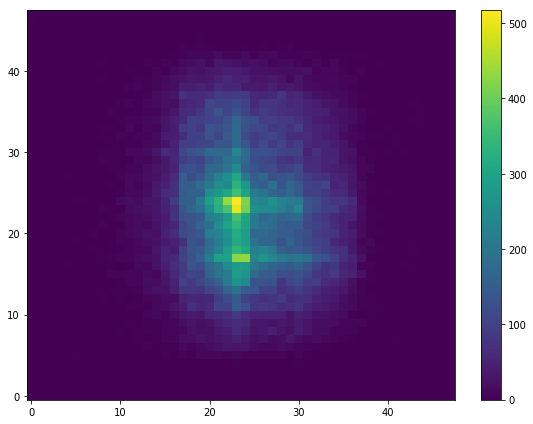

Current= 8.1
Files used: ['CG4B5654.dat', 'CG4B5655.dat', 'CG4B5656.dat', 'CG4B5657.dat', 'CG4B5658.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  79149.7727543128


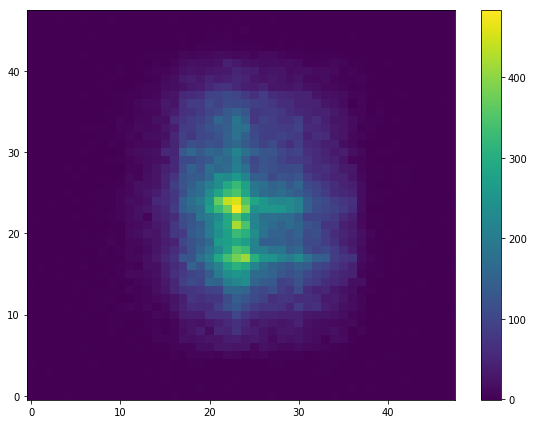

Current= 8.12
Files used: ['CG4B5659.dat', 'CG4B5660.dat', 'CG4B5661.dat', 'CG4B5662.dat', 'CG4B5663.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  80537.80785246886


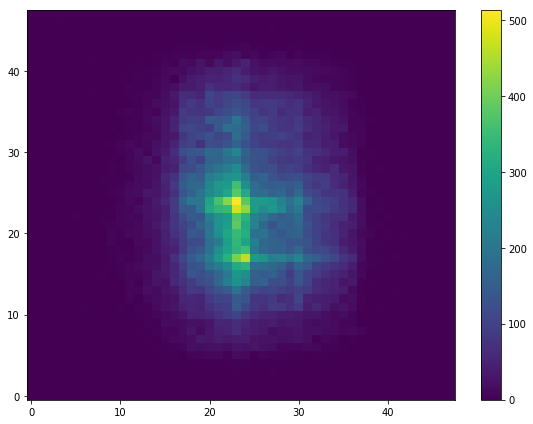

Current= 8.14
Files used: ['CG4B5664.dat', 'CG4B5665.dat', 'CG4B5666.dat', 'CG4B5667.dat', 'CG4B5668.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  80012.14991076736


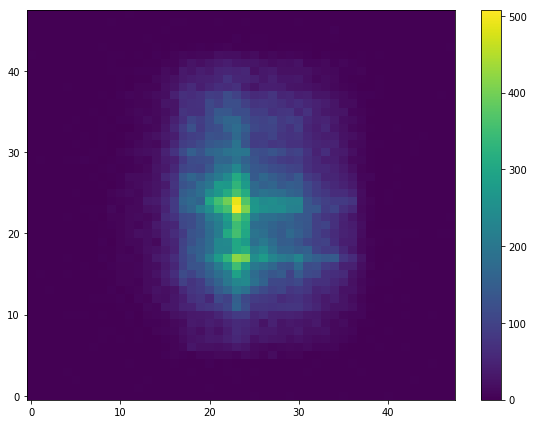

Current= 8.16
Files used: ['CG4B5669.dat', 'CG4B5670.dat', 'CG4B5671.dat', 'CG4B5672.dat', 'CG4B5673.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  77391.44378346225


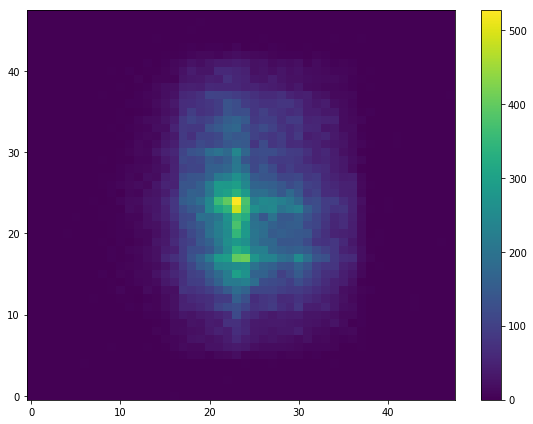

Current= 8.18
Files used: ['CG4B5674.dat', 'CG4B5675.dat', 'CG4B5676.dat', 'CG4B5677.dat', 'CG4B5678.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  70572.00951814394


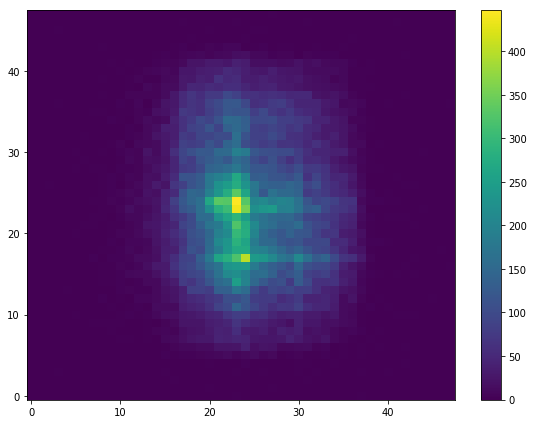

Current= 8.2
Files used: ['CG4B5679.dat', 'CG4B5680.dat', 'CG4B5681.dat', 'CG4B5682.dat', 'CG4B5683.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  59460.792385484776


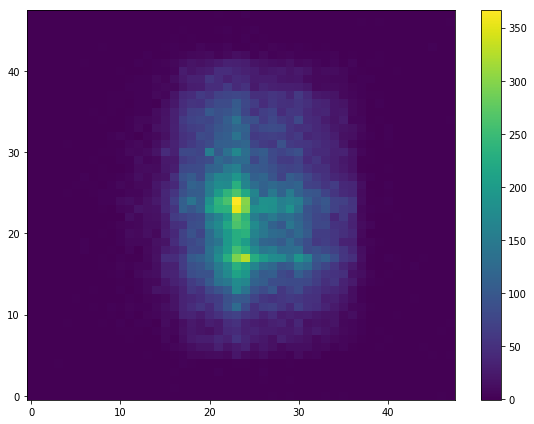

Current= 8.22
Files used: ['CG4B5684.dat', 'CG4B5685.dat', 'CG4B5686.dat', 'CG4B5687.dat', 'CG4B5688.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  45812.24628197504


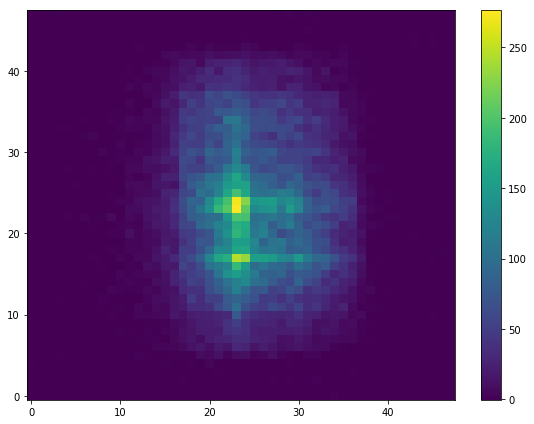

Current= 8.24
Files used: ['CG4B5689.dat', 'CG4B5690.dat', 'CG4B5691.dat', 'CG4B5692.dat', 'CG4B5693.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  30635.28792385487


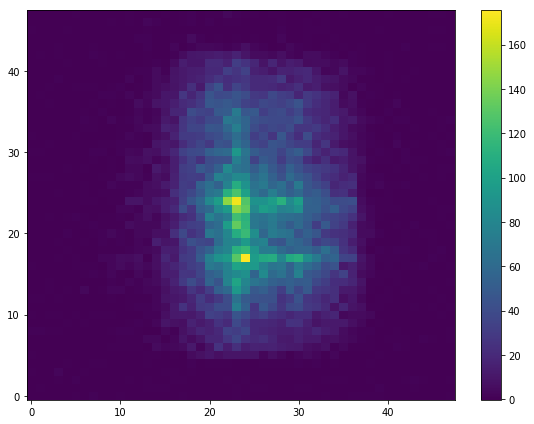

Current= 8.26
Files used: ['CG4B5694.dat', 'CG4B5695.dat', 'CG4B5696.dat', 'CG4B5697.dat', 'CG4B5698.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  18057.364663890552


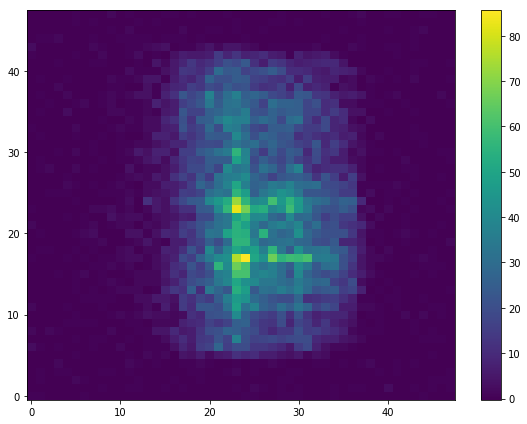

Current= 8.28
Files used: ['CG4B5699.dat', 'CG4B5700.dat', 'CG4B5701.dat', 'CG4B5702.dat', 'CG4B5703.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  10118.594883997637


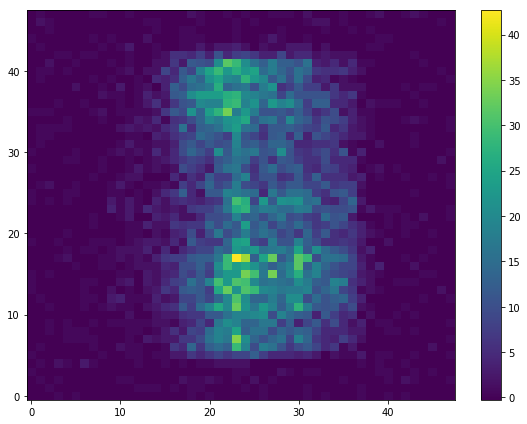

Current= 8.3
Files used: ['CG4B5704.dat', 'CG4B5705.dat', 'CG4B5706.dat', 'CG4B5707.dat', 'CG4B5708.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  8824.706722189176


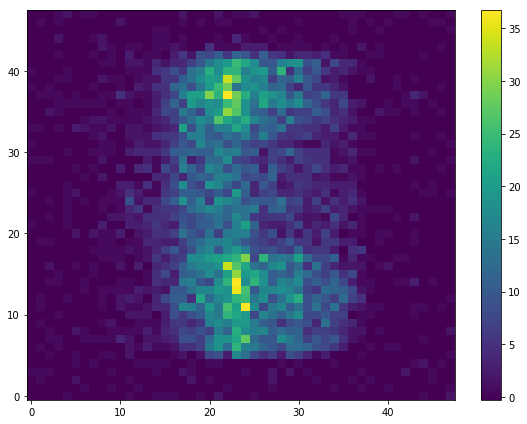

Current= 8.32
Files used: ['CG4B5709.dat', 'CG4B5710.dat', 'CG4B5711.dat', 'CG4B5712.dat', 'CG4B5713.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  15222.406305770384


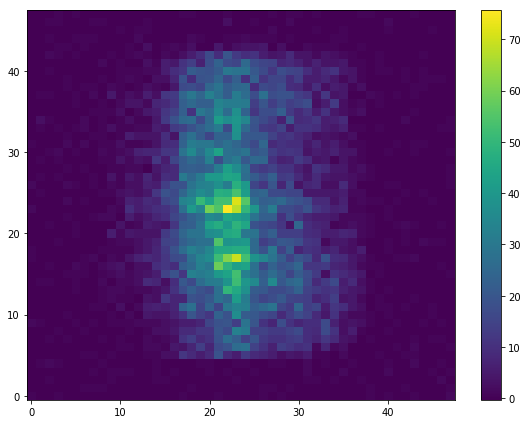

Current= 8.34
Files used: ['CG4B5714.dat', 'CG4B5715.dat', 'CG4B5716.dat', 'CG4B5717.dat', 'CG4B5718.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  27381.700178465246


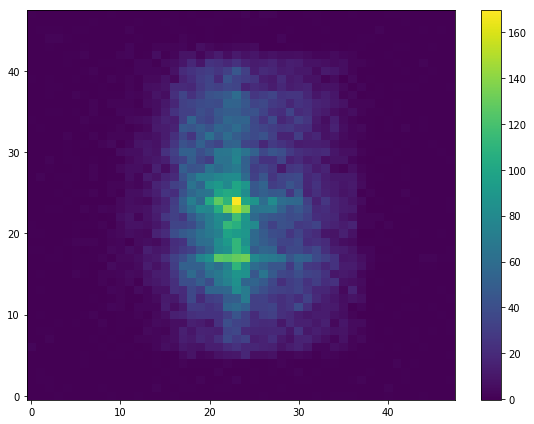

Current= 8.36
Files used: ['CG4B5719.dat', 'CG4B5720.dat', 'CG4B5721.dat', 'CG4B5722.dat', 'CG4B5723.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  43263.65199286134


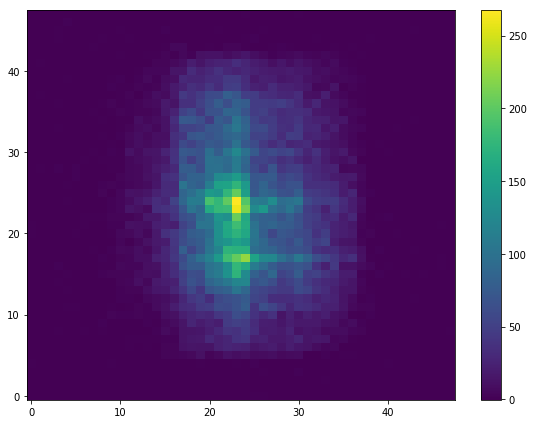

Current= 8.38
Files used: ['CG4B5724.dat', 'CG4B5725.dat', 'CG4B5726.dat', 'CG4B5727.dat', 'CG4B5728.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  58392.309934562756


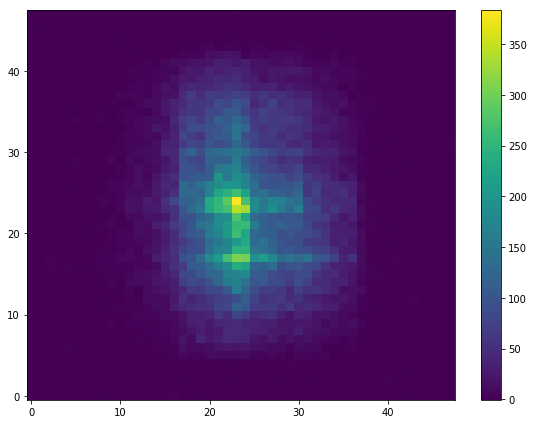

Current= 8.4
Files used: ['CG4B5729.dat', 'CG4B5730.dat', 'CG4B5731.dat', 'CG4B5732.dat', 'CG4B5733.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  69137.18500892325


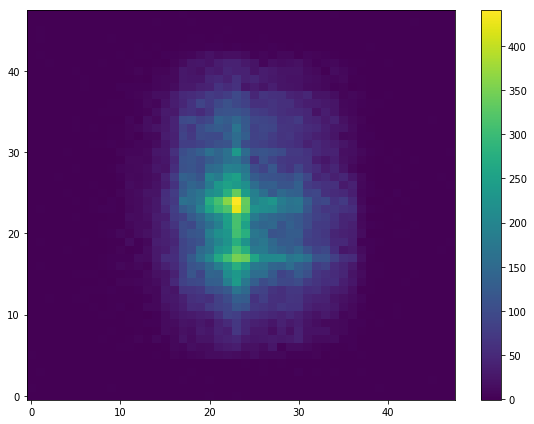

Current= 8.42
Files used: ['CG4B5734.dat', 'CG4B5735.dat', 'CG4B5736.dat', 'CG4B5737.dat', 'CG4B5738.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  76407.63890541346


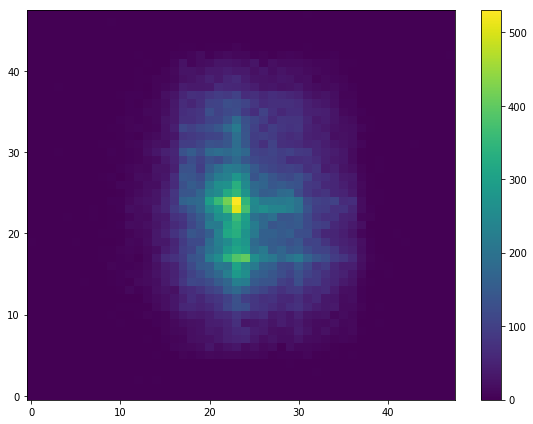

Current= 8.44
Files used: ['CG4B5739.dat', 'CG4B5740.dat', 'CG4B5741.dat', 'CG4B5742.dat', 'CG4B5743.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  79101.73765615714


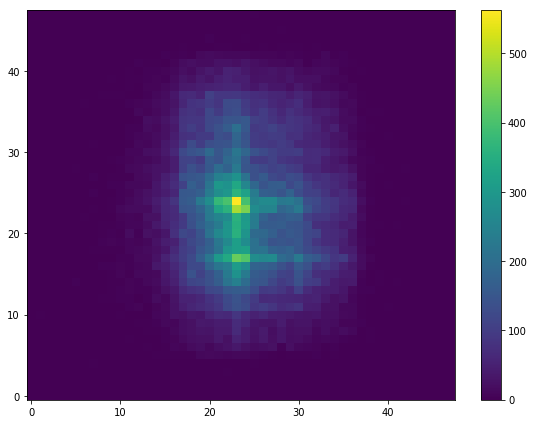

Current= 8.46
Files used: ['CG4B5744.dat', 'CG4B5745.dat', 'CG4B5746.dat', 'CG4B5747.dat', 'CG4B5748.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  79633.33194527084


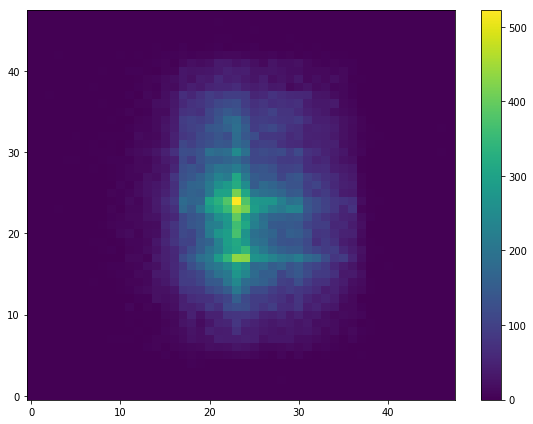

Current= 8.48
Files used: ['CG4B5749.dat', 'CG4B5750.dat', 'CG4B5751.dat', 'CG4B5752.dat', 'CG4B5753.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  74709.09934562765


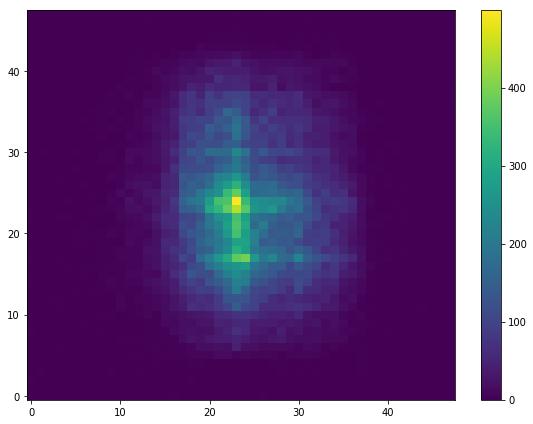


 Peak counts:  80537.80785246886 
 Current:  8.12 


 Trough counts:  8824.706722189176 
 Current:  8.3 



In [150]:
zero_counts = []    #add all subscans that are zero counts here

currents = np.arange(8,8.5,.02)
print("Currents used: ", currents, " \n Total=", len(currents), "\n")
high_counts = []
high_totals = []
start = 5629 #characterize b2 for MIEZE
subscans = 5

for i in range(len(currents)):
    print("Current=", round(currents[i],3))
    if ((start + (subscans - 1) + int(i)*subscans) not in zero_counts):
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans, \
                          print_summed=True, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
    else: 
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans - 1, \
                          print_summed=True, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
        print("Warning: one subscan failed!")
        
Peak_h = max(high_totals)
Trough_h = min(high_totals)
Peak_current_h = np.argmax(high_totals)
Trough_current_h = np.argmin(high_totals)

print("\n Peak counts: ", Peak_h, "\n Current: ", round(currents[Peak_current_h],3), "\n")
print("\n Trough counts: ", Trough_h, "\n Current: ", round(currents[Trough_current_h],3), "\n")


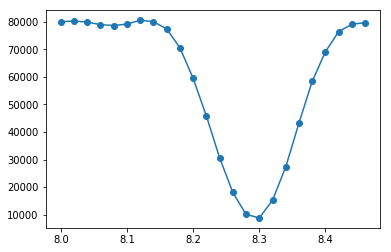

In [151]:
fig = plt.plot(currents[:-1], high_totals[:-1], "-o")

In [174]:
zero_counts = []    #add all subscans that are zero counts here

currents = np.arange(8.35,8.71,.02)
print("Currents used: ", currents, " \n Total=", len(currents), "\n")
high_counts = []
high_totals = []
start = 5814 #characterize b1 for MIEZE
subscans = 5

for i in range(len(currents)):
    print("Current=", round(currents[i],3))
    if ((start + (subscans - 1) + int(i)*subscans) not in zero_counts):
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans, \
                          print_summed=False, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
    else: 
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans - 1, \
                          print_summed=True, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
        print("Warning: one subscan failed!")
        
Peak_h = max(high_totals)
Trough_h = min(high_totals)
Peak_current_h = np.argmax(high_totals)
Trough_current_h = np.argmin(high_totals)

print("\n Peak counts: ", Peak_h, "\n Current: ", round(currents[Peak_current_h],3), "\n")
print("\n Trough counts: ", Trough_h, "\n Current: ", round(currents[Trough_current_h],3), "\n")


Currents used:  [8.35 8.37 8.39 8.41 8.43 8.45 8.47 8.49 8.51 8.53 8.55 8.57 8.59 8.61
 8.63 8.65 8.67 8.69 8.71]  
 Total= 19 

Current= 8.35
Files used: ['CG4B5814.dat', 'CG4B5815.dat', 'CG4B5816.dat', 'CG4B5817.dat', 'CG4B5818.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Current= 8.37
Files used: ['CG4B5819.dat', 'CG4B5820.dat', 'CG4B5821.dat', 'CG4B5822.dat', 'CG4B5823.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Current= 8.39
Files used: ['CG4B5824.dat', 'CG4B5825.dat', 'CG4B5826.dat', 'CG4B5827.dat', 'CG4B5828.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Current= 8.41
Files used: ['CG4B5829.dat', 'CG4B5830.dat', 'CG4B5831.dat', 'CG4B5832.dat', 'CG4B5833.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Current= 8.43
Files used: ['CG4B5834.dat', 'CG4B5835.dat', 'CG4B5836.dat', 'CG4B5837.dat', 'CG4B5838.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Current= 8.45
Files used: ['CG4B5839.dat', 'CG4B5840.dat', 'CG4B5841.dat', 'CG4B5842.dat', 'CG4B5843.dat']
Bin size 

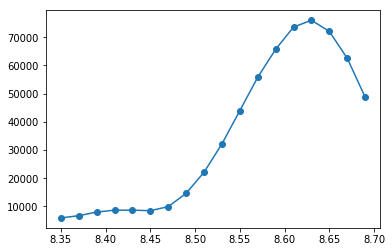

In [175]:
fig = plt.plot(currents[:-1], high_totals[:-1], "-o")

Currents used:  [-8.1  -8.08 -8.06 -8.04 -8.02 -8.   -7.98 -7.96 -7.94 -7.92]  
 Total= 10 

Current= -8.1
Files used: ['CG4B5528.dat', 'CG4B5529.dat', 'CG4B5530.dat', 'CG4B5531.dat', 'CG4B5532.dat', 'CG4B5533.dat', 'CG4B5534.dat', 'CG4B5535.dat', 'CG4B5536.dat', 'CG4B5537.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  71280.78643664486


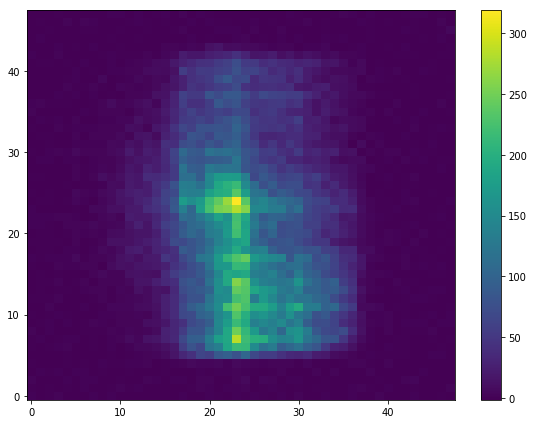

Current= -8.08
Files used: ['CG4B5538.dat', 'CG4B5539.dat', 'CG4B5540.dat', 'CG4B5541.dat', 'CG4B5542.dat', 'CG4B5543.dat', 'CG4B5544.dat', 'CG4B5545.dat', 'CG4B5546.dat', 'CG4B5547.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  116808.41641879833


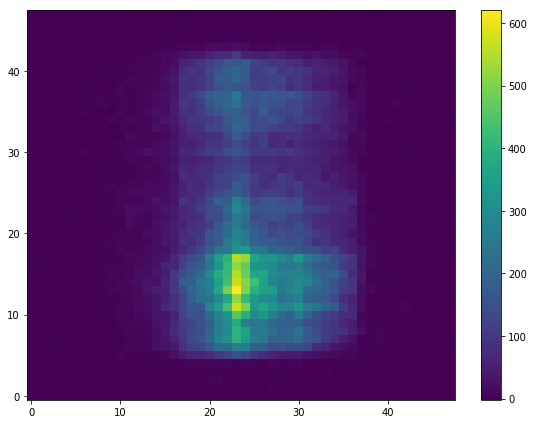

Current= -8.06
Files used: ['CG4B5548.dat', 'CG4B5549.dat', 'CG4B5550.dat', 'CG4B5551.dat', 'CG4B5552.dat', 'CG4B5553.dat', 'CG4B5554.dat', 'CG4B5555.dat', 'CG4B5556.dat', 'CG4B5557.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  294998.94765020825


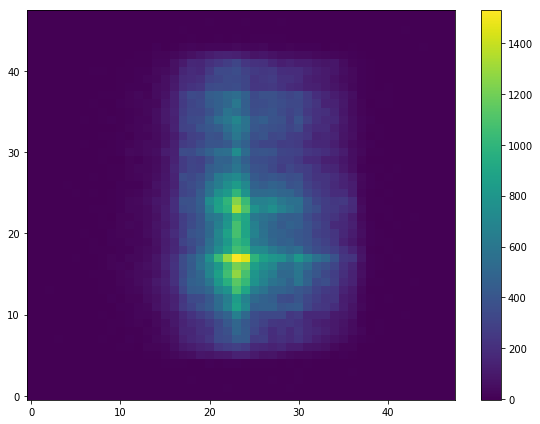

Current= -8.04
Files used: ['CG4B5558.dat', 'CG4B5559.dat', 'CG4B5560.dat', 'CG4B5561.dat', 'CG4B5562.dat', 'CG4B5563.dat', 'CG4B5564.dat', 'CG4B5565.dat', 'CG4B5566.dat', 'CG4B5567.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  489844.6276026179


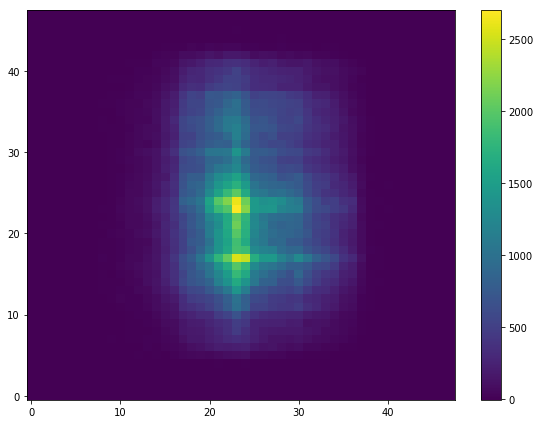

Current= -8.02
Files used: ['CG4B5568.dat', 'CG4B5569.dat', 'CG4B5570.dat', 'CG4B5571.dat', 'CG4B5572.dat', 'CG4B5573.dat', 'CG4B5574.dat', 'CG4B5575.dat', 'CG4B5576.dat', 'CG4B5577.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  565420.033313503


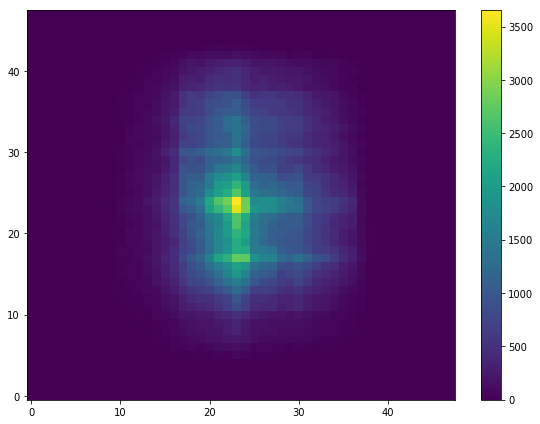

Current= -8.0
Files used: ['CG4B5578.dat', 'CG4B5579.dat', 'CG4B5580.dat', 'CG4B5581.dat', 'CG4B5582.dat', 'CG4B5583.dat', 'CG4B5584.dat', 'CG4B5585.dat', 'CG4B5586.dat', 'CG4B5587.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  472318.72932778107


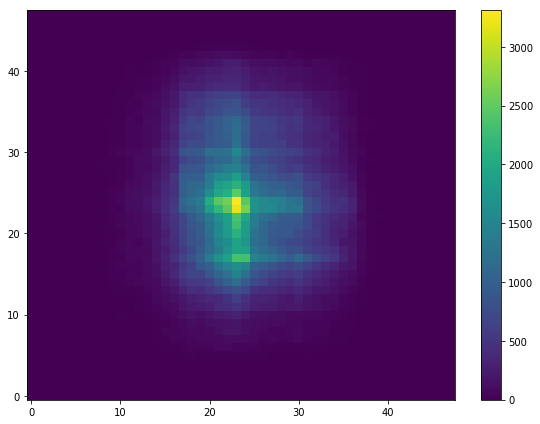

Current= -7.98
Files used: ['CG4B5588.dat', 'CG4B5589.dat', 'CG4B5590.dat', 'CG4B5591.dat', 'CG4B5592.dat', 'CG4B5593.dat', 'CG4B5594.dat', 'CG4B5595.dat', 'CG4B5596.dat', 'CG4B5597.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  265034.86198691244


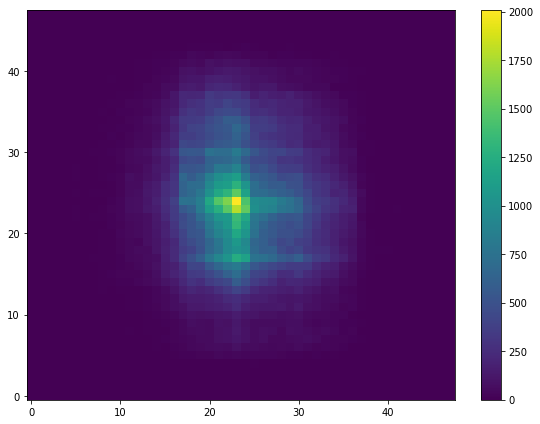

Current= -7.96
Files used: ['CG4B5598.dat', 'CG4B5599.dat', 'CG4B5600.dat', 'CG4B5601.dat', 'CG4B5602.dat', 'CG4B5603.dat', 'CG4B5604.dat', 'CG4B5605.dat', 'CG4B5606.dat', 'CG4B5607.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  93923.72575847698


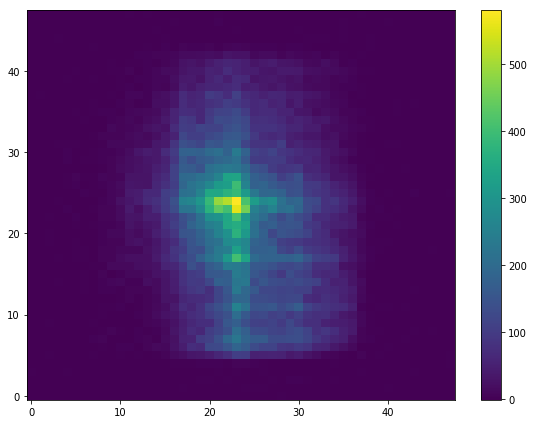

Current= -7.94
Files used: ['CG4B5608.dat', 'CG4B5609.dat', 'CG4B5610.dat', 'CG4B5611.dat', 'CG4B5612.dat', 'CG4B5613.dat', 'CG4B5614.dat', 'CG4B5615.dat', 'CG4B5616.dat', 'CG4B5617.dat']
Bin size =  5
Binned pixel size (mm) =  1.0
Total counts in summed ROI:  84415.82986317674


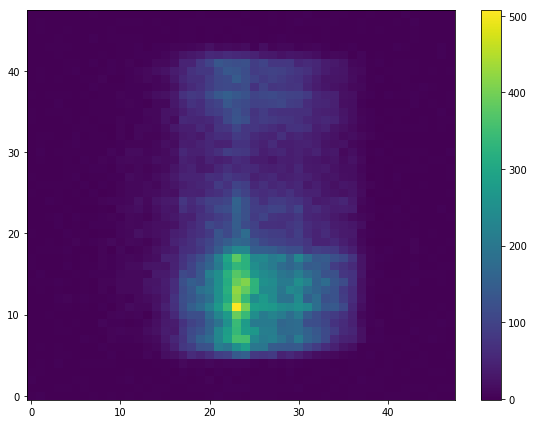

Current= -7.92
Files used: ['CG4B5618.dat', 'CG4B5619.dat', 'CG4B5620.dat', 'CG4B5621.dat', 'CG4B5622.dat', 'CG4B5623.dat', 'CG4B5624.dat', 'CG4B5625.dat', 'CG4B5626.dat', 'CG4B5627.dat']
Bin size =  5
Binned pixel size (mm) =  1.0


ValueError: max() arg is an empty sequence

In [141]:
zero_counts = []    #add all subscans that are zero counts here

currents = np.arange(-8.1,-7.9,.02)
print("Currents used: ", currents, " \n Total=", len(currents), "\n")
high_counts = []
high_totals = []
start = 5528
subscans = 10

for i in range(len(currents)):
    print("Current=", round(currents[i],3))
    if ((start + (subscans - 1) + int(i)*subscans) not in zero_counts):
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans, \
                          print_summed=True, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
    else: 
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans - 1, \
                          print_summed=True, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
        print("Warning: one subscan failed!")
        
Peak_h = max(high_totals)
Trough_h = min(high_totals)
Peak_current_h = np.argmax(high_totals)
Trough_current_h = np.argmin(high_totals)

print("\n Peak counts: ", Peak_h, "\n Current: ", round(currents[Peak_current_h],3), "\n")
print("\n Trough counts: ", Trough_h, "\n Current: ", round(currents[Trough_current_h],3), "\n")


amp,freq,phase,shim: [ 2.50448495e+05 -4.29575053e+01  4.78516805e+02  3.16875495e+05]
FR: 8.540023937931858
Period= 0.14626513497619636


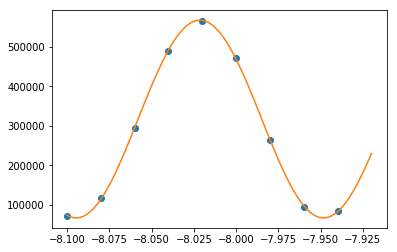

In [149]:
def simple_cos(x,amp,freq,phase,shim):
    return amp*np.cos(x*freq + phase) + shim

c_fine = np.linspace(currents[0],currents[-1],100)

fit, cov = sp.optimize.curve_fit(simple_cos, currents[:-1], high_totals[:])

fig = plt.plot(currents[:-1], high_totals[:], "o")
plt.plot(c_fine, simple_cos(c_fine, *fit), "-")
print("amp,freq,phase,shim:", fit)
print('FR:', max(simple_cos(c_fine, *fit))/min(simple_cos(c_fine, *fit)) )
print('Period=',-2*np.pi/fit[1])

# Start of MIEZE Analysis

0
0


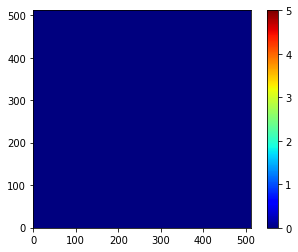

Initial guesses:  [0.3141592653589793, 0.0, 0, 0.0]
Parameters: freq, amp, phase, shim
Parameters:  [0.31415927 0.         0.         0.        ]
Errors:  [inf inf inf inf]


C:\Users\Larmor\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in double_scalars


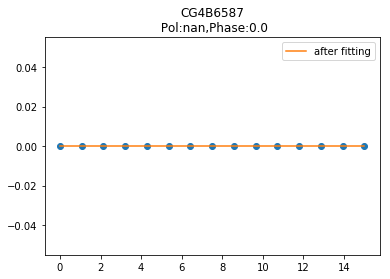

In [329]:
# -*- coding: utf-8 -*-
"""
Spyder Editor

This is a temporary script file.
"""
import struct
import numpy
import pylab
import matplotlib.colors as colors
import scipy.optimize
from scipy.optimize import curve_fit
EVT_FMT = 'ddd'
EVT_SZ = struct .calcsize(EVT_FMT)
Z=numpy.zeros((512,512))
Ztof=numpy.zeros(170000)
NZtof=numpy.zeros(170000)
data=numpy.zeros(170000)
lengthscale=512.0/116.0


#for run_num in [1,2,6527,6554, 6582,6583,6584,6585]: #range(6482,1000000000):
for run_num in [6587]:
    run = 'CG4B' + str(run_num)
    #run='MURR5204'
    #run='CG4B6334'
    wf='C:/Users/Larmor/Dropbox/AngerCamera/Wide_Angle_NSE_2022/'+run+'.dat'
    myfile=open(wf,'r+b')
    loopcount=0

    #sxlow=170 #Region of interest
    #sxhigh= 310
    #sylow=185
    #syhigh=360

    sxlow=225 #Region of interest
    sxhigh= 275
    sylow=225
    syhigh=325
    
    nxlow=350 #background
    nxhigh=500
    nylow=0
    nyhigh=160

    nTotal = 0
    while True:
        buf=myfile.read(EVT_SZ*1024)
        if len(buf)<EVT_SZ:
            break
        for i in range(0, len(buf),EVT_SZ):
            tof,x,y=struct.unpack(EVT_FMT, buf[i:i+EVT_SZ])
            ix=int(x*lengthscale)   
            iy=int(y*lengthscale)

            itof=int(tof/20)
            nTotal += 1
            if itof < 170000 and sxlow<ix<sxhigh and sylow<iy<syhigh:
                Ztof[itof]=Ztof[itof]+1
                loopcount=loopcount +1
            if itof < 170000 and nxlow<ix<nxhigh and nylow<iy<nyhigh:
                NZtof[itof]=NZtof[itof]+1

            Z[iy,ix]=Z[iy,ix]+1

    data=(Ztof-NZtof)[:15]
    myfile.close()
    print(loopcount)
    print(str(nTotal))
    im=pylab.imshow(Z,cmap=pylab.cm.jet,origin='lower', vmax = 5)
    cbar=pylab.colorbar()
    pylab.show()
    #Zline=numpy.average(Z[50:450,:],axis=0)
    #pylab.plot(Zline)
    #pylab.show()
    #pylab.plot(data)
    #pylab.show()

    N = len(data) # number of data points
    t  = numpy.linspace(0, N, N)

    guess_freq = 2*np.pi/20
    guess_amplitude = (numpy.max(data)- numpy.min(data))/2
    guess_phase = 0
    guess_offset = numpy.mean(data)

    p0=[guess_freq, guess_amplitude,
        guess_phase, guess_offset]
    print('Initial guesses: ', p0)
    
    # create the function we want to fit
    def my_sin(x, freq, amplitude, phase, offset):
        return numpy.cos(x * freq + phase) * amplitude + offset
    print('Parameters: freq, amp, phase, shim')
    
    # now do the fit
    fit = curve_fit(my_sin, t, data, p0=p0)
    para=fit[0]
    # we'll use this to plot our first estimate. This might already be good enough for you
    data_first_guess = my_sin(t, *p0)
    error = numpy.sqrt(numpy.diag(fit[1]))
    print('Parameters: ', fit[0])
    print ('Errors: ', error)
    # recreate the fitted curve using the optimized parameters
    fine_t = np.linspace(t[0],t[-1],100)
    data_fit = my_sin(fine_t, *fit[0])

    pylab.plot(t, data, 'o')
    pylab.plot(fine_t, data_fit, '-', label='after fitting')
    pylab.legend()
    pylab.title(run+'\n Pol:'+str(para[1]/para[3])[:6]+',Phase:'+str(para[2])[:6])
    pylab.show()


# Start of Correction Coil Analysis

Currents used:  [-1.   -1.01 -1.02 -1.03 -1.04 -1.05 -1.06 -1.07 -1.08 -1.09 -1.1  -1.11
 -1.12 -1.13]  
 Total= 14 

Current= -1.0
Files used: ['CG4B7041.dat', 'CG4B7042.dat', 'CG4B7043.dat', 'CG4B7044.dat', 'CG4B7045.dat', 'CG4B7046.dat', 'CG4B7047.dat', 'CG4B7048.dat', 'CG4B7049.dat', 'CG4B7050.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  1140424.5841760845


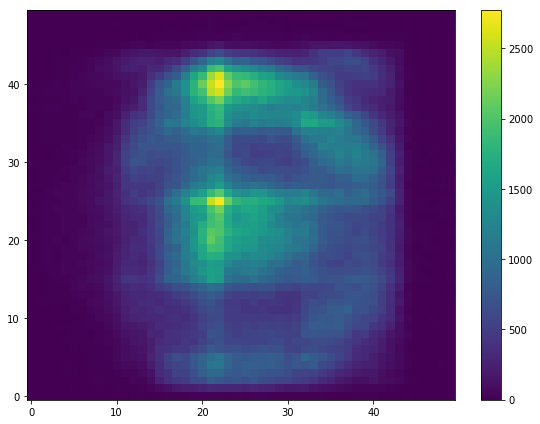

Current= -1.01
Files used: ['CG4B7051.dat', 'CG4B7052.dat', 'CG4B7053.dat', 'CG4B7054.dat', 'CG4B7055.dat', 'CG4B7056.dat', 'CG4B7057.dat', 'CG4B7058.dat', 'CG4B7059.dat', 'CG4B7060.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  1295687.8399762064


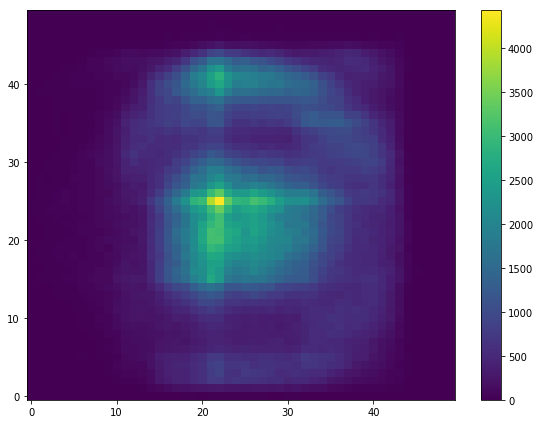

Current= -1.02
Files used: ['CG4B7061.dat', 'CG4B7062.dat', 'CG4B7063.dat', 'CG4B7064.dat', 'CG4B7065.dat', 'CG4B7066.dat', 'CG4B7067.dat', 'CG4B7068.dat', 'CG4B7069.dat', 'CG4B7070.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  1522754.6829268304


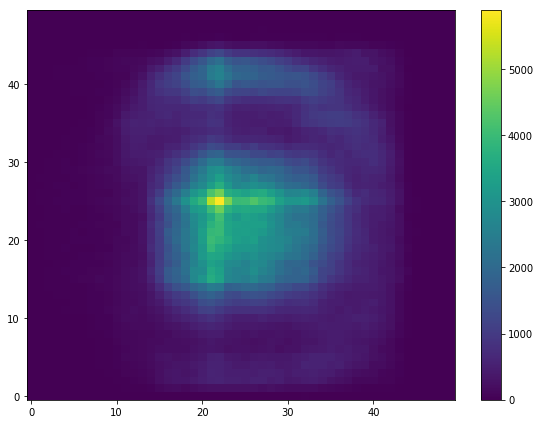

Current= -1.03
Files used: ['CG4B7071.dat', 'CG4B7072.dat', 'CG4B7073.dat', 'CG4B7074.dat', 'CG4B7075.dat', 'CG4B7076.dat', 'CG4B7077.dat', 'CG4B7078.dat', 'CG4B7079.dat', 'CG4B7080.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  1756390.838786436


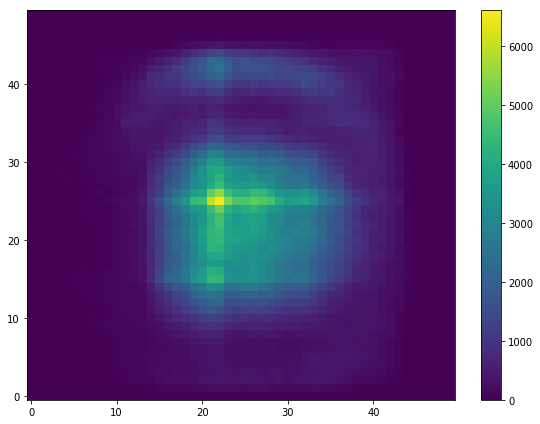

Current= -1.04
Files used: ['CG4B7081.dat', 'CG4B7082.dat', 'CG4B7083.dat', 'CG4B7084.dat', 'CG4B7085.dat', 'CG4B7086.dat', 'CG4B7087.dat', 'CG4B7088.dat', 'CG4B7089.dat', 'CG4B7090.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  1905839.0713860784


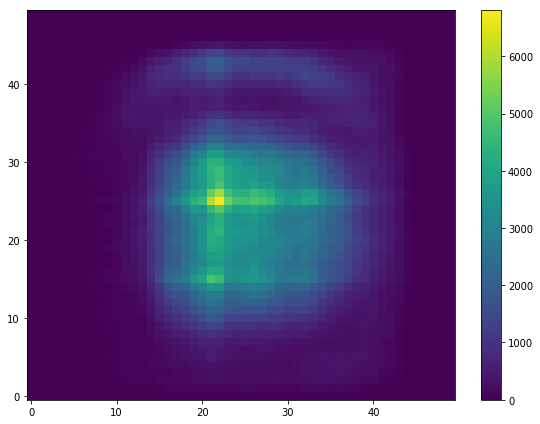

Current= -1.05
Files used: ['CG4B7091.dat', 'CG4B7092.dat', 'CG4B7093.dat', 'CG4B7094.dat', 'CG4B7095.dat', 'CG4B7096.dat', 'CG4B7097.dat', 'CG4B7098.dat', 'CG4B7099.dat', 'CG4B7100.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  1903207.7852468765


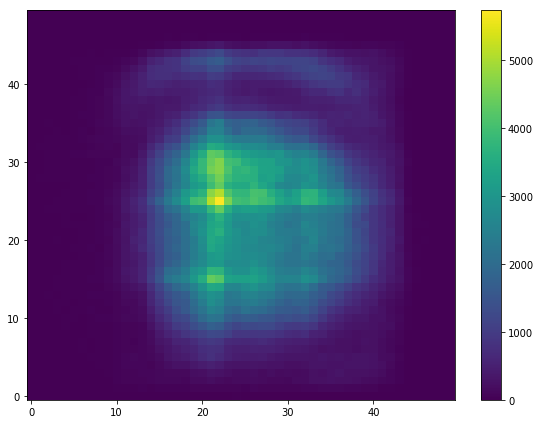

Current= -1.06
Files used: ['CG4B7101.dat', 'CG4B7102.dat', 'CG4B7103.dat', 'CG4B7104.dat', 'CG4B7105.dat', 'CG4B7106.dat', 'CG4B7107.dat', 'CG4B7108.dat', 'CG4B7109.dat', 'CG4B7110.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  1769817.1980963699


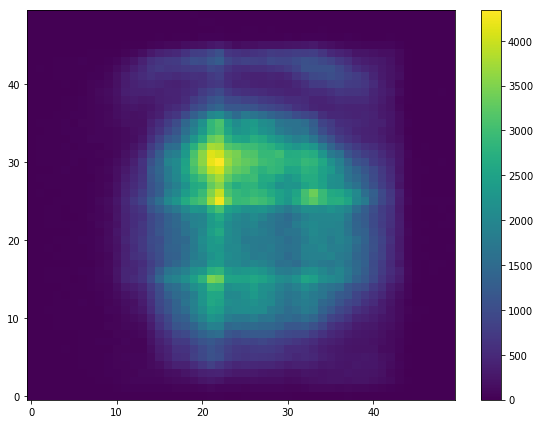

Current= -1.07
Files used: ['CG4B7111.dat', 'CG4B7112.dat', 'CG4B7113.dat', 'CG4B7114.dat', 'CG4B7115.dat', 'CG4B7116.dat', 'CG4B7117.dat', 'CG4B7118.dat', 'CG4B7119.dat', 'CG4B7120.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  1537941.813206424


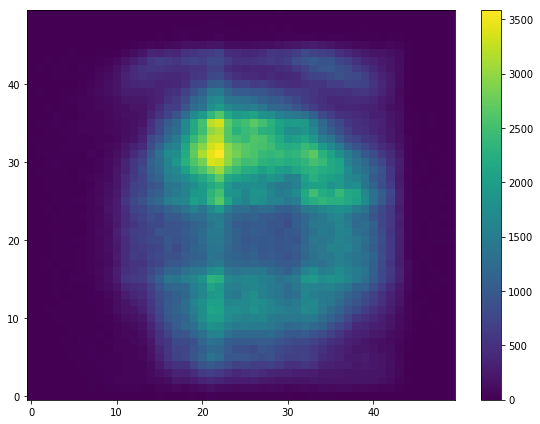

Current= -1.08
Files used: ['CG4B7121.dat', 'CG4B7122.dat', 'CG4B7123.dat', 'CG4B7124.dat', 'CG4B7125.dat', 'CG4B7126.dat', 'CG4B7127.dat', 'CG4B7128.dat', 'CG4B7129.dat', 'CG4B7130.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  1305317.2748364068


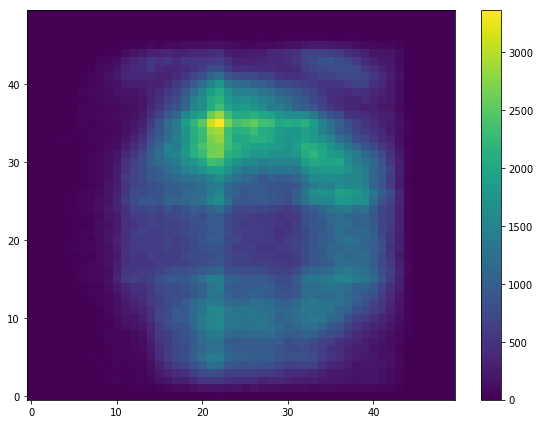

Current= -1.09
Files used: ['CG4B7131.dat', 'CG4B7132.dat', 'CG4B7133.dat', 'CG4B7134.dat', 'CG4B7135.dat', 'CG4B7136.dat', 'CG4B7137.dat', 'CG4B7138.dat', 'CG4B7139.dat', 'CG4B7140.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  1138367.3515764426


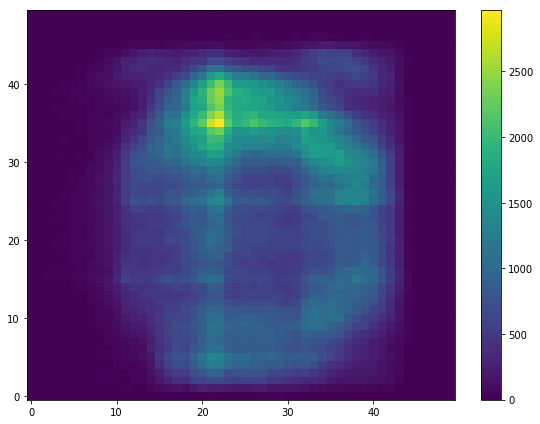

Current= -1.1
Files used: ['CG4B7141.dat', 'CG4B7142.dat', 'CG4B7143.dat', 'CG4B7144.dat', 'CG4B7145.dat', 'CG4B7146.dat', 'CG4B7147.dat', 'CG4B7148.dat', 'CG4B7149.dat', 'CG4B7150.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  1112274.5306365255


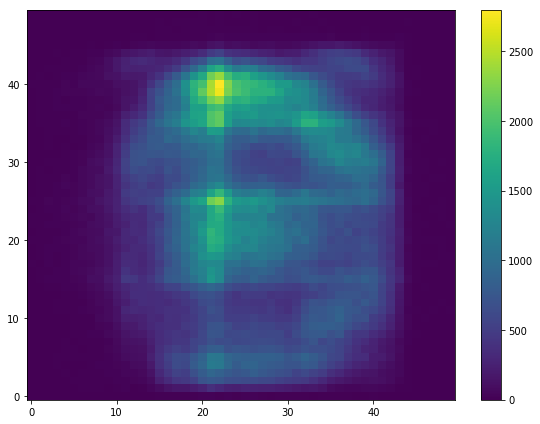

Current= -1.11
Files used: ['CG4B7151.dat', 'CG4B7152.dat', 'CG4B7153.dat', 'CG4B7154.dat', 'CG4B7155.dat', 'CG4B7156.dat', 'CG4B7157.dat', 'CG4B7158.dat', 'CG4B7159.dat', 'CG4B7160.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  1235624.686496134


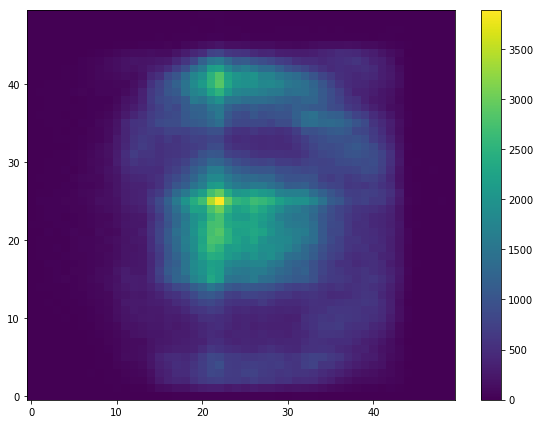

Current= -1.12
Files used: ['CG4B7161.dat', 'CG4B7162.dat', 'CG4B7163.dat', 'CG4B7164.dat', 'CG4B7165.dat', 'CG4B7166.dat', 'CG4B7167.dat', 'CG4B7168.dat', 'CG4B7169.dat', 'CG4B7170.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  1472106.7352766204


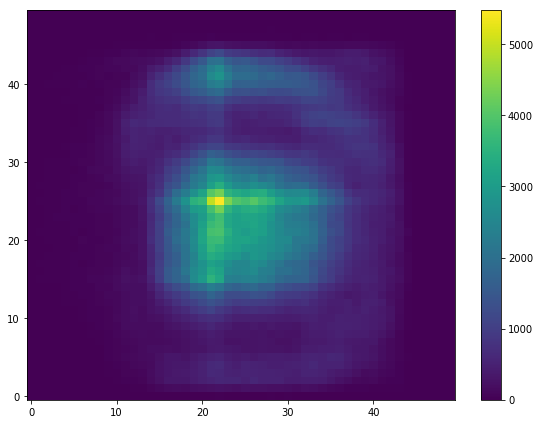

Current= -1.13
Files used: ['CG4B7171.dat', 'CG4B7172.dat', 'CG4B7173.dat', 'CG4B7174.dat', 'CG4B7175.dat', 'CG4B7176.dat', 'CG4B7177.dat', 'CG4B7178.dat', 'CG4B7179.dat', 'CG4B7180.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  1740849.2992266538


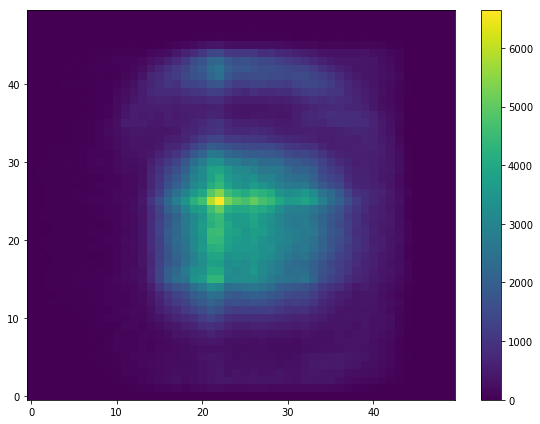


 Peak counts:  1905839.0713860784 
 Current:  -1.04 


 Trough counts:  1112274.5306365255 
 Current:  -1.1 



In [429]:
zero_counts = []    #add all subscans that are zero counts here

currents = np.arange(-1,-1.14,-.01)
print("Currents used: ", currents, " \n Total=", len(currents), "\n")
high_counts = []
high_totals = []
start = 7041
subscans = 10

for i in range(len(currents)):
    print("Current=", round(currents[i],3))
    if ((start + (subscans - 1) + int(i)*subscans) not in zero_counts):
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans, \
                          print_summed=True, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
    else: 
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans - 1, \
                          print_summed=True, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
        print("Warning: one subscan failed!")
        
Peak_h = max(high_totals)
Trough_h = min(high_totals)
Peak_current_h = np.argmax(high_totals)
Trough_current_h = np.argmin(high_totals)

print("\n Peak counts: ", Peak_h, "\n Current: ", round(currents[Peak_current_h],3), "\n")
print("\n Trough counts: ", Trough_h, "\n Current: ", round(currents[Trough_current_h],3), "\n")


In [432]:
high_counts = np.asarray(high_counts)

phase_plot = np.zeros((35,35))
print(high_counts[:,2,20]) #used to check if index is x or y
print(high_counts[:,10,41]) # used to check if index is x or y

for i in range(10,60): #i is y
    for j in range(15,65): #j is x
    #for j in [15]:
        
        test_px = high_counts[:,i,j] #check later-- i is y, j is x
        #print(test_px)
        #print('Parameters: amp,freq,phase,shim')

        
        c_fine = np.linspace(currents[0],currents[-1],100, endpoint=True)
        guess = [(np.max(test_px) - np.min(test_px))/2, 2*np.pi/.1, 0, np.mean(test_px)]
        fit, cov = sp.optimize.curve_fit(simple_cos, currents, test_px, p0=guess)

        #phase_plot[int(i - 5),int(j - 5)] = fit[2]
        phase_plot[int(i-10),int(j-15)] = fit[2]
        #color = 'C' + str(int(i/5))
        
        """fig = plt.plot(currents, test_px , 'o', color=color)
        plt.plot(c_fine, simple_cos(c_fine, *fit), "-", label="Pixel: " + str(i) + ","+ str(j), color=color)
        plt.legend()"""
        """print("amp,freq,phase,shim:", fit)
        print('FR:', max(simple_cos(c_fine, *fit))/min(simple_cos(c_fine, *fit)) )
        print('Period=',-2*np.pi/fit[1])"""
        #plt.show()
        
fig = plt.imshow(phase_plot, origin='lower')

[627.39143367 611.37953599 493.31707317 335.35633551 225.39202855
 174.3123141  238.36287924 343.35752528 535.35930993 605.35574063
 713.34741225 648.3866746  488.33789411 332.33491969]
[416.39143367 383.37953599 378.31707317 332.35633551 230.39202855
 270.3123141  265.36287924 305.35752528 348.35930993 404.35574063
 436.34741225 455.3866746  386.33789411 333.33491969]


IndexError: index 50 is out of bounds for axis 2 with size 50

In [470]:
#wide angle
zero_counts = []    #add all subscans that are zero counts here

currents = np.arange(1,1.1,.1)
print("Currents used: ", currents, " \n Total=", len(currents), "\n")
high_counts = []
high_totals = []
start = 9167
subscans = 5

for i in range(len(currents)):
    print("Current=", round(currents[i],3))
    if ((start + (subscans - 1) + int(i)*subscans) not in zero_counts):
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans, \
                          print_summed=True, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
    else: 
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans - 1, \
                          print_summed=True, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
        print("Warning: one subscan failed!")
        
Peak_h = max(high_totals)
Trough_h = min(high_totals)
Peak_current_h = np.argmax(high_totals)
Trough_current_h = np.argmin(high_totals)

print("\n Peak counts: ", Peak_h, "\n Current: ", round(currents[Peak_current_h],3), "\n")
print("\n Trough counts: ", Trough_h, "\n Current: ", round(currents[Trough_current_h],3), "\n")


Currents used:  [1.  1.1]  
 Total= 2 

Current= 1.0
Files used: ['CG4B9167.dat', 'CG4B9168.dat', 'CG4B9169.dat', 'CG4B9170.dat', 'CG4B9171.dat']
Bin size =  3
Binned pixel size (mm) =  0.6


ValueError: max() arg is an empty sequence

# Wide-angle Analysis

Currents used:  [1.    1.005 1.01  1.015 1.02  1.025 1.03  1.035 1.04  1.045 1.05  1.055
 1.06  1.065 1.07  1.075 1.08  1.085 1.09  1.095 1.1   1.105 1.11  1.115
 1.12  1.125 1.13  1.135 1.14  1.145 1.15  1.155 1.16  1.165 1.17  1.175
 1.18  1.185 1.19  1.195 1.2   1.205 1.21  1.215 1.22  1.225 1.23  1.235
 1.24  1.245 1.25  1.255 1.26  1.265 1.27  1.275 1.28  1.285 1.29  1.295
 1.3  ]  
 Total= 61 

Current= 1.0
Files used: ['CG4B9172.dat', 'CG4B9173.dat', 'CG4B9174.dat', 'CG4B9175.dat', 'CG4B9176.dat', 'CG4B9177.dat', 'CG4B9178.dat', 'CG4B9179.dat', 'CG4B9180.dat', 'CG4B9181.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  2058539.4800713835


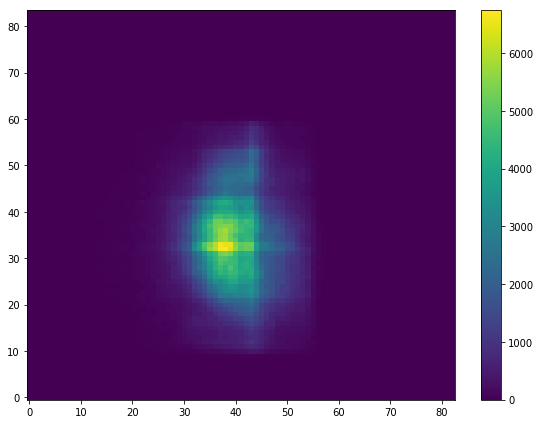

Current= 1.005
Files used: ['CG4B9182.dat', 'CG4B9183.dat', 'CG4B9184.dat', 'CG4B9185.dat', 'CG4B9186.dat', 'CG4B9187.dat', 'CG4B9188.dat', 'CG4B9189.dat', 'CG4B9190.dat', 'CG4B9191.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  1712879.4140392651


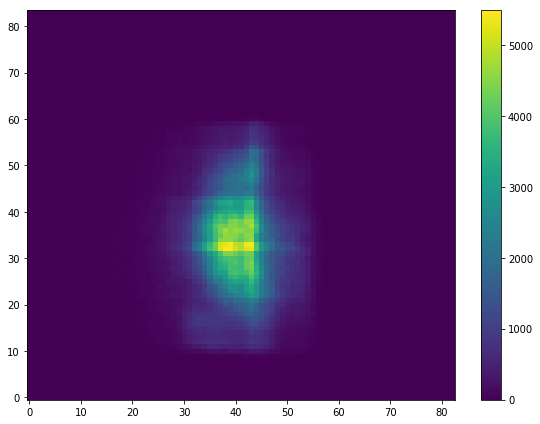

Current= 1.01
Files used: ['CG4B9192.dat', 'CG4B9193.dat', 'CG4B9194.dat', 'CG4B9195.dat', 'CG4B9196.dat', 'CG4B9197.dat', 'CG4B9198.dat', 'CG4B9199.dat', 'CG4B9200.dat', 'CG4B9201.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  1519270.480071382


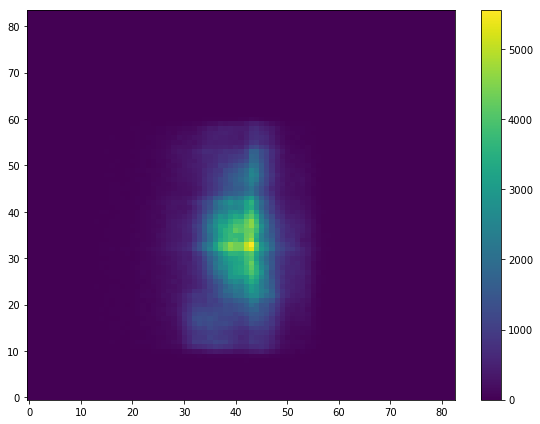

Current= 1.015
Files used: ['CG4B9202.dat', 'CG4B9203.dat', 'CG4B9204.dat', 'CG4B9205.dat', 'CG4B9206.dat', 'CG4B9207.dat', 'CG4B9208.dat', 'CG4B9209.dat', 'CG4B9210.dat', 'CG4B9211.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  1471184.9226650812


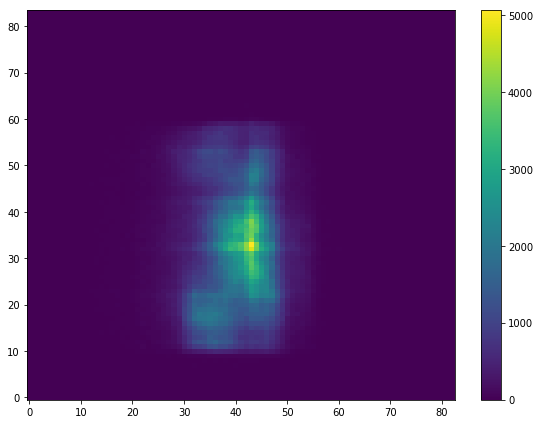

Current= 1.02
Files used: ['CG4B9212.dat', 'CG4B9213.dat', 'CG4B9214.dat', 'CG4B9215.dat', 'CG4B9216.dat', 'CG4B9217.dat', 'CG4B9218.dat', 'CG4B9219.dat', 'CG4B9220.dat', 'CG4B9221.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  1662358.5145746577


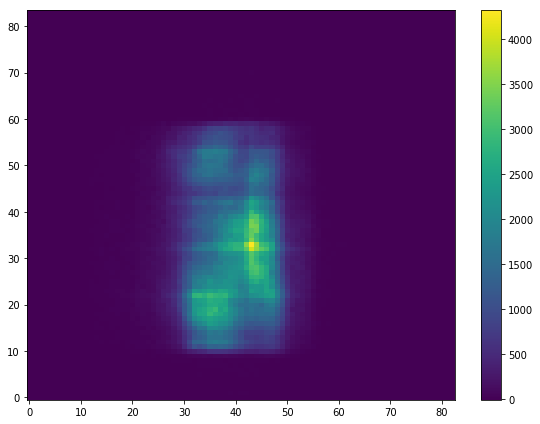

Current= 1.025
Files used: ['CG4B9222.dat', 'CG4B9223.dat', 'CG4B9224.dat', 'CG4B9225.dat', 'CG4B9226.dat', 'CG4B9227.dat', 'CG4B9228.dat', 'CG4B9229.dat', 'CG4B9230.dat', 'CG4B9231.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  1978207.249851282


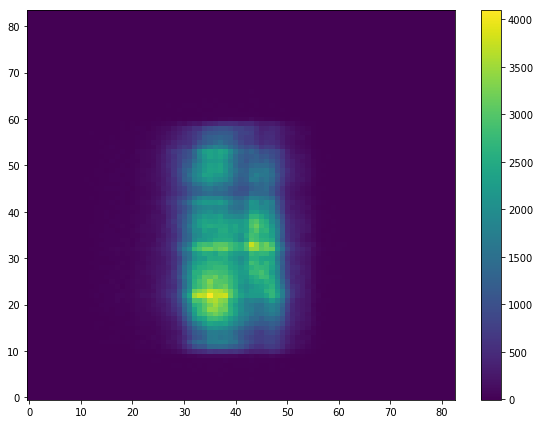

Current= 1.03
Files used: ['CG4B9232.dat', 'CG4B9233.dat', 'CG4B9234.dat', 'CG4B9235.dat', 'CG4B9236.dat', 'CG4B9237.dat', 'CG4B9238.dat', 'CG4B9239.dat', 'CG4B9240.dat', 'CG4B9241.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  2353482.5639500315


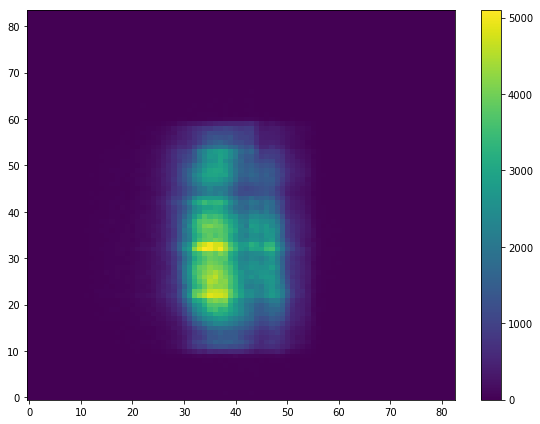

Current= 1.035
Files used: ['CG4B9242.dat', 'CG4B9243.dat', 'CG4B9244.dat', 'CG4B9245.dat', 'CG4B9246.dat', 'CG4B9247.dat', 'CG4B9248.dat', 'CG4B9249.dat', 'CG4B9250.dat', 'CG4B9251.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  2590468.547888159


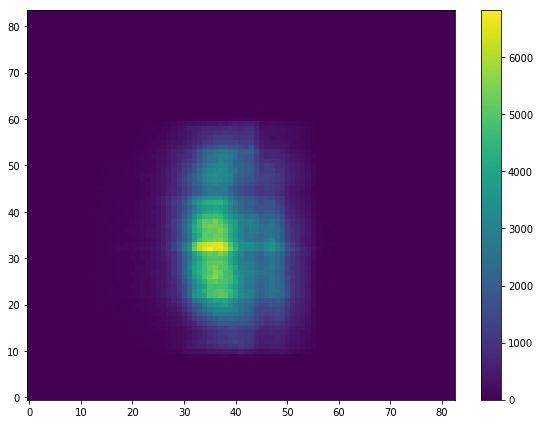

Current= 1.04
Files used: ['CG4B9252.dat', 'CG4B9253.dat', 'CG4B9254.dat', 'CG4B9255.dat', 'CG4B9256.dat', 'CG4B9257.dat', 'CG4B9258.dat', 'CG4B9259.dat', 'CG4B9260.dat', 'CG4B9261.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  2588441.1017251597


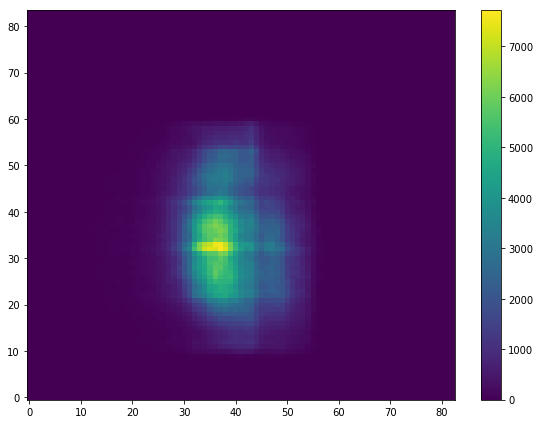

Current= 1.045
Files used: ['CG4B9262.dat', 'CG4B9263.dat', 'CG4B9264.dat', 'CG4B9265.dat', 'CG4B9266.dat', 'CG4B9267.dat', 'CG4B9268.dat', 'CG4B9269.dat', 'CG4B9270.dat', 'CG4B9271.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  2357023.2849494405


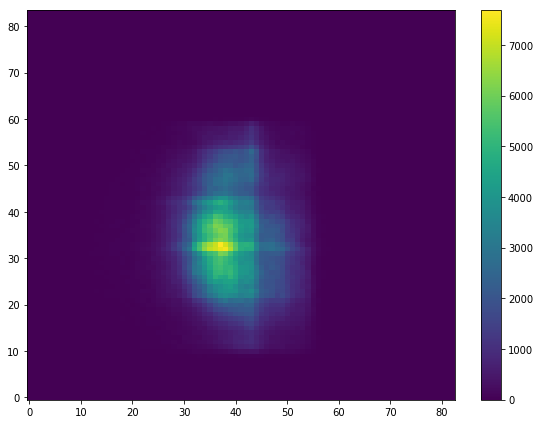

Current= 1.05
Files used: ['CG4B9272.dat', 'CG4B9273.dat', 'CG4B9274.dat', 'CG4B9275.dat', 'CG4B9276.dat', 'CG4B9277.dat', 'CG4B9278.dat', 'CG4B9279.dat', 'CG4B9280.dat', 'CG4B9281.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  2006048.449137421


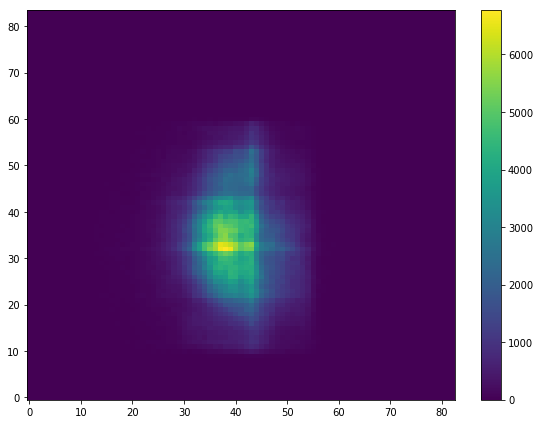

Current= 1.055
Files used: ['CG4B9282.dat', 'CG4B9283.dat', 'CG4B9284.dat', 'CG4B9285.dat', 'CG4B9286.dat', 'CG4B9287.dat', 'CG4B9288.dat', 'CG4B9289.dat', 'CG4B9290.dat', 'CG4B9291.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  1683023.4961332504


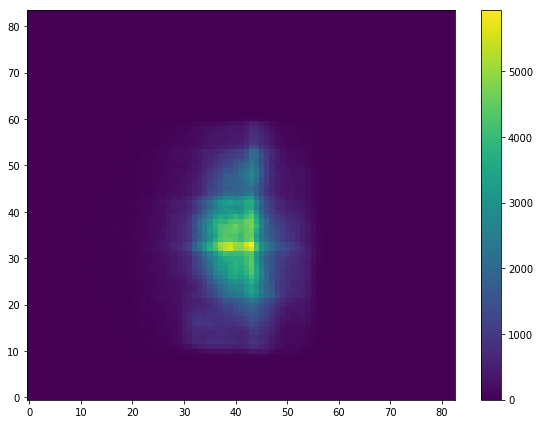

Current= 1.06
Files used: ['CG4B9292.dat', 'CG4B9293.dat', 'CG4B9294.dat', 'CG4B9295.dat', 'CG4B9296.dat', 'CG4B9297.dat', 'CG4B9298.dat', 'CG4B9299.dat', 'CG4B9300.dat', 'CG4B9301.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  1466694.2510410473


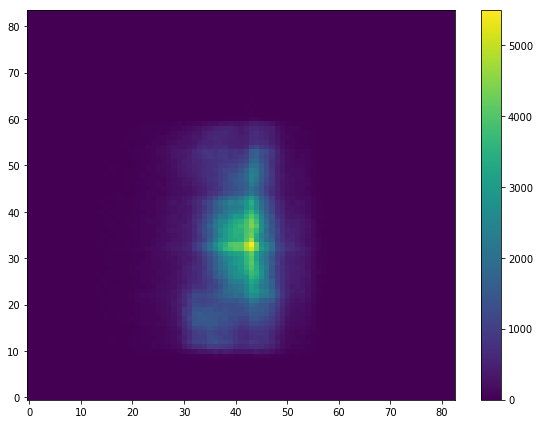

Current= 1.065
Files used: ['CG4B9302.dat', 'CG4B9303.dat', 'CG4B9304.dat', 'CG4B9305.dat', 'CG4B9306.dat', 'CG4B9307.dat', 'CG4B9308.dat', 'CG4B9309.dat', 'CG4B9310.dat', 'CG4B9311.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  1545702.2837596675


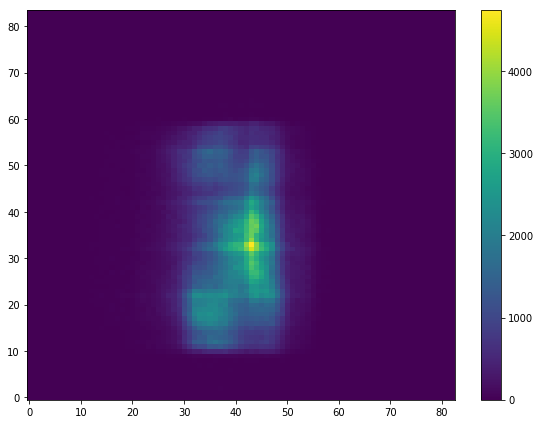

Current= 1.07
Files used: ['CG4B9312.dat', 'CG4B9313.dat', 'CG4B9314.dat', 'CG4B9315.dat', 'CG4B9316.dat', 'CG4B9317.dat', 'CG4B9318.dat', 'CG4B9319.dat', 'CG4B9320.dat', 'CG4B9321.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  1817813.5639500255


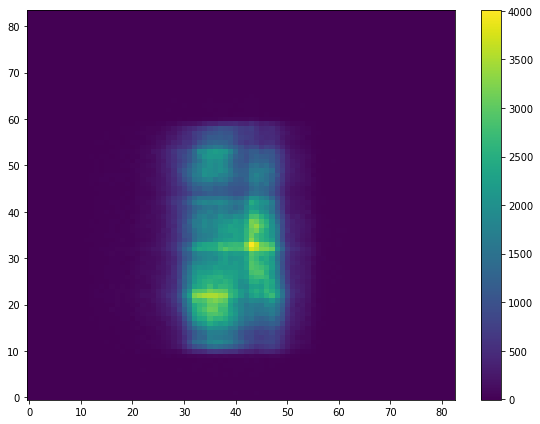

Current= 1.075
Files used: ['CG4B9322.dat', 'CG4B9323.dat', 'CG4B9324.dat', 'CG4B9325.dat', 'CG4B9326.dat', 'CG4B9327.dat', 'CG4B9328.dat', 'CG4B9329.dat', 'CG4B9330.dat', 'CG4B9331.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  2212178.676977992


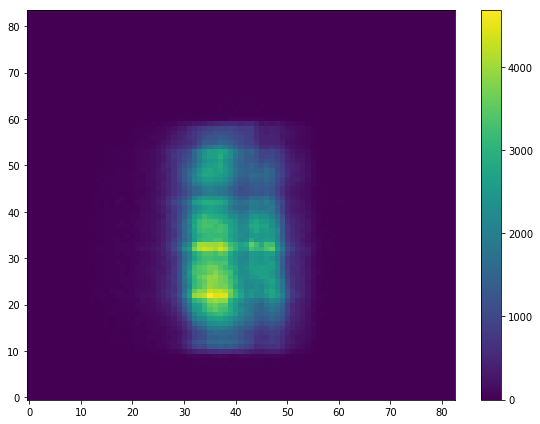

Current= 1.08
Files used: ['CG4B9332.dat', 'CG4B9333.dat', 'CG4B9334.dat', 'CG4B9335.dat', 'CG4B9336.dat', 'CG4B9337.dat', 'CG4B9338.dat', 'CG4B9339.dat', 'CG4B9340.dat', 'CG4B9341.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  2510289.0880428366


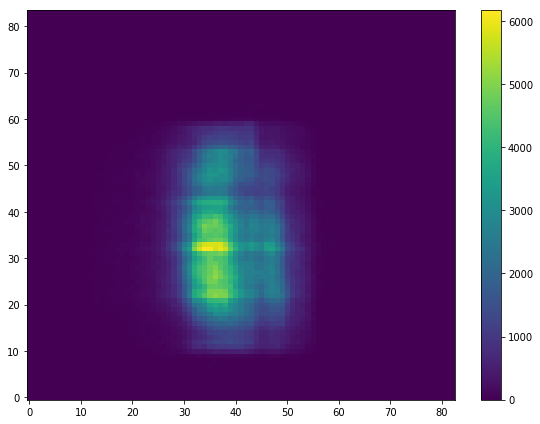

Current= 1.085
Files used: ['CG4B9342.dat', 'CG4B9343.dat', 'CG4B9344.dat', 'CG4B9345.dat', 'CG4B9346.dat', 'CG4B9347.dat', 'CG4B9348.dat', 'CG4B9349.dat', 'CG4B9350.dat', 'CG4B9351.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  2610735.448542533


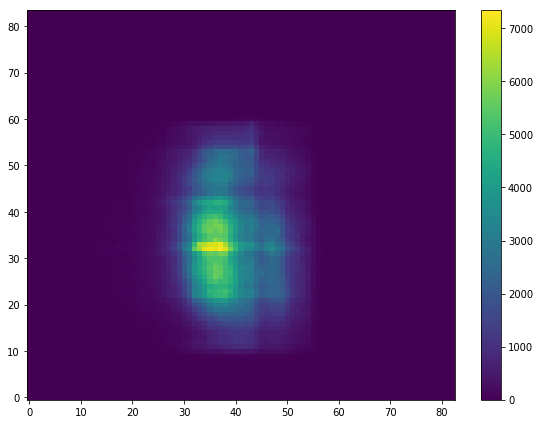

Current= 1.09
Files used: ['CG4B9352.dat', 'CG4B9353.dat', 'CG4B9354.dat', 'CG4B9355.dat', 'CG4B9356.dat', 'CG4B9357.dat', 'CG4B9358.dat', 'CG4B9359.dat', 'CG4B9360.dat', 'CG4B9361.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  2461735.6121356385


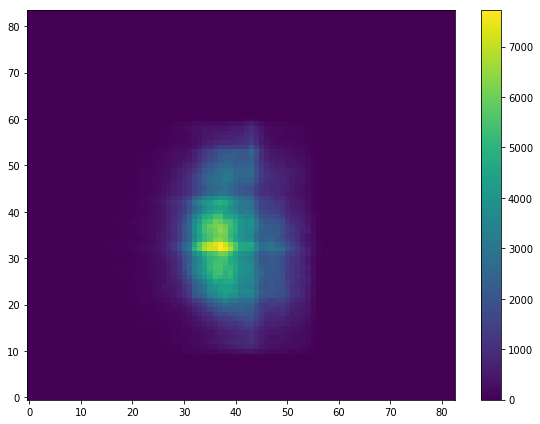

Current= 1.095
Files used: ['CG4B9362.dat', 'CG4B9363.dat', 'CG4B9364.dat', 'CG4B9365.dat', 'CG4B9366.dat', 'CG4B9367.dat', 'CG4B9368.dat', 'CG4B9369.dat', 'CG4B9370.dat', 'CG4B9371.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  2113897.4949434847


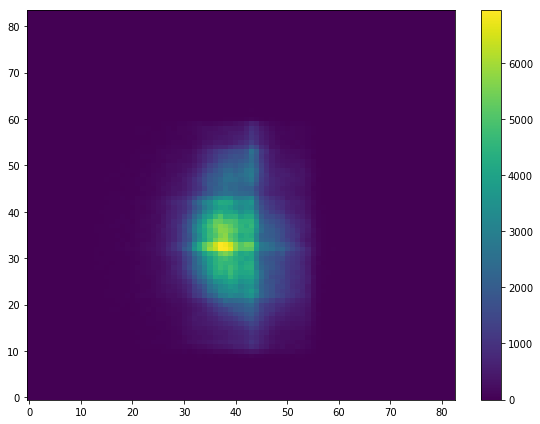

Current= 1.1
Files used: ['CG4B9372.dat', 'CG4B9373.dat', 'CG4B9374.dat', 'CG4B9375.dat', 'CG4B9376.dat', 'CG4B9377.dat', 'CG4B9378.dat', 'CG4B9379.dat', 'CG4B9380.dat', 'CG4B9381.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  1768054.6091612154


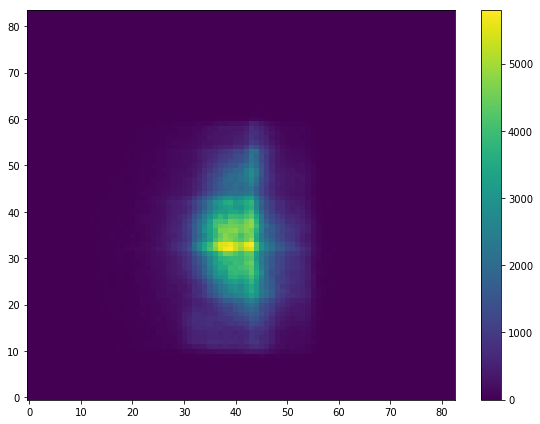

Current= 1.105
Files used: ['CG4B9382.dat', 'CG4B9383.dat', 'CG4B9384.dat', 'CG4B9385.dat', 'CG4B9386.dat', 'CG4B9387.dat', 'CG4B9388.dat', 'CG4B9389.dat', 'CG4B9390.dat', 'CG4B9391.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  1505466.9559785794


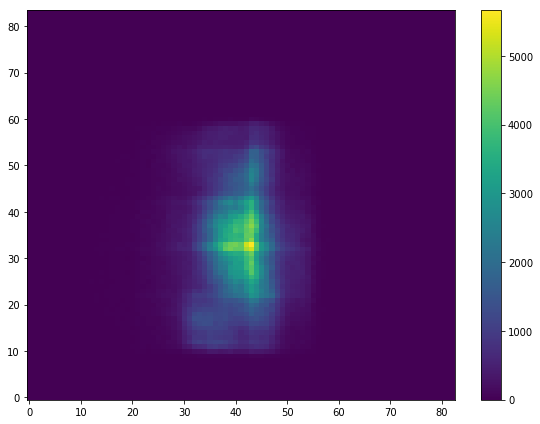

Current= 1.11
Files used: ['CG4B9392.dat', 'CG4B9393.dat', 'CG4B9394.dat', 'CG4B9395.dat', 'CG4B9396.dat', 'CG4B9397.dat', 'CG4B9398.dat', 'CG4B9399.dat', 'CG4B9400.dat', 'CG4B9401.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  1484094.0850684138


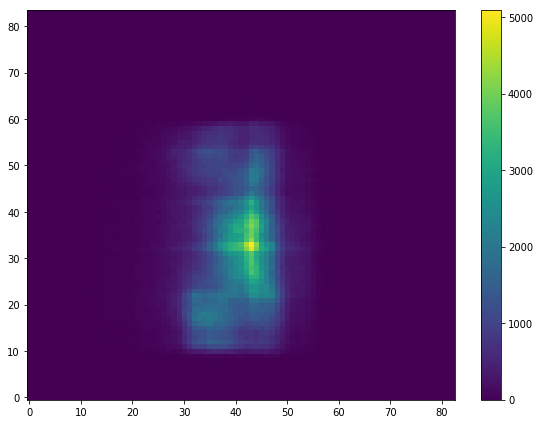

Current= 1.115
Files used: ['CG4B9402.dat', 'CG4B9403.dat', 'CG4B9404.dat', 'CG4B9405.dat', 'CG4B9406.dat', 'CG4B9407.dat', 'CG4B9408.dat', 'CG4B9409.dat', 'CG4B9410.dat', 'CG4B9411.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  1680272.741820344


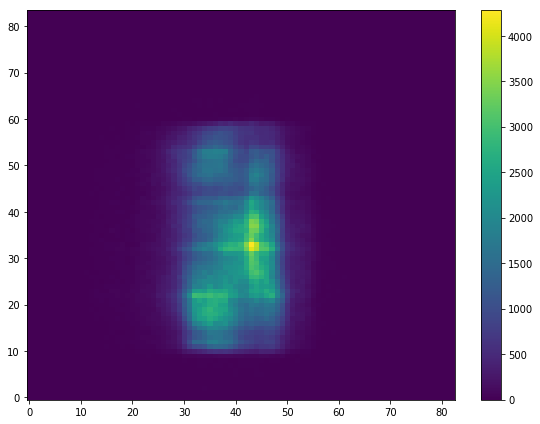

Current= 1.12
Files used: ['CG4B9412.dat', 'CG4B9413.dat', 'CG4B9414.dat', 'CG4B9415.dat', 'CG4B9416.dat', 'CG4B9417.dat', 'CG4B9418.dat', 'CG4B9419.dat', 'CG4B9420.dat', 'CG4B9421.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  2082592.610945866


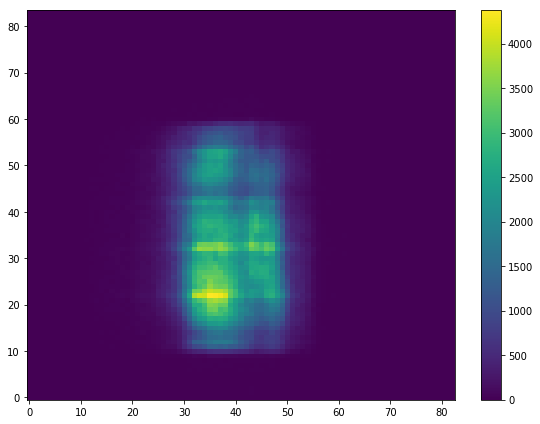

Current= 1.125
Files used: ['CG4B9422.dat', 'CG4B9423.dat', 'CG4B9424.dat', 'CG4B9425.dat', 'CG4B9426.dat', 'CG4B9427.dat', 'CG4B9428.dat', 'CG4B9429.dat', 'CG4B9430.dat', 'CG4B9431.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  2423222.3640690097


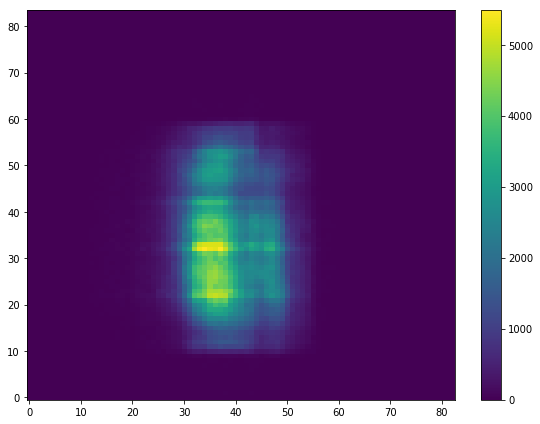

Current= 1.13
Files used: ['CG4B9432.dat', 'CG4B9433.dat', 'CG4B9434.dat', 'CG4B9435.dat', 'CG4B9436.dat', 'CG4B9437.dat', 'CG4B9438.dat', 'CG4B9439.dat', 'CG4B9440.dat', 'CG4B9441.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  2598761.00535396


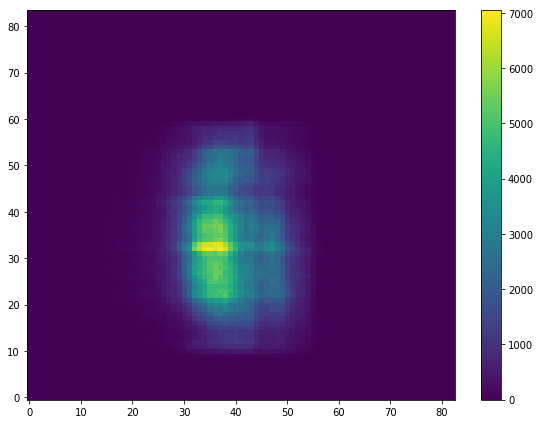

Current= 1.135
Files used: ['CG4B9442.dat', 'CG4B9443.dat', 'CG4B9444.dat', 'CG4B9445.dat', 'CG4B9446.dat', 'CG4B9447.dat', 'CG4B9448.dat', 'CG4B9449.dat', 'CG4B9450.dat', 'CG4B9451.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  2533581.544318863


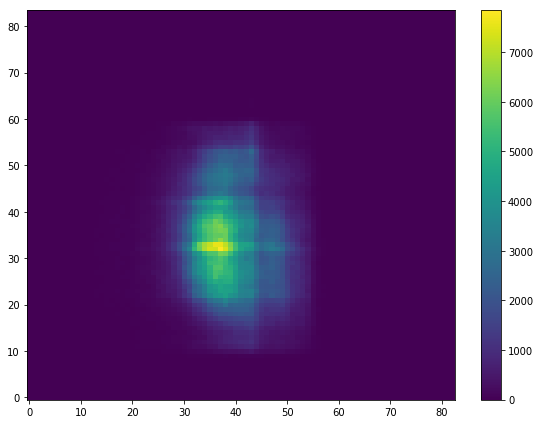

Current= 1.14
Files used: ['CG4B9452.dat', 'CG4B9453.dat', 'CG4B9454.dat', 'CG4B9455.dat', 'CG4B9456.dat', 'CG4B9457.dat', 'CG4B9458.dat', 'CG4B9459.dat', 'CG4B9460.dat', 'CG4B9461.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  2264716.234384287


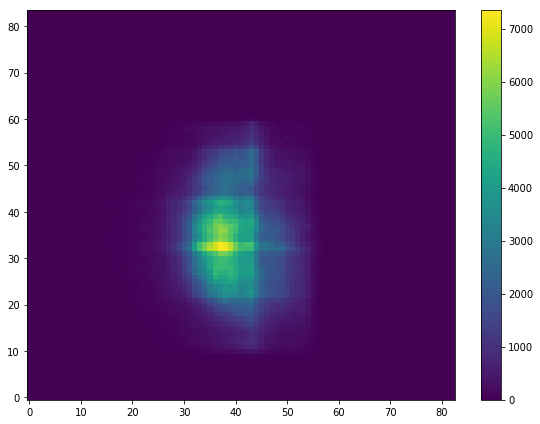

Current= 1.145
Files used: ['CG4B9462.dat', 'CG4B9463.dat', 'CG4B9464.dat', 'CG4B9465.dat', 'CG4B9466.dat', 'CG4B9467.dat', 'CG4B9468.dat', 'CG4B9469.dat', 'CG4B9470.dat', 'CG4B9471.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  1914980.201070787


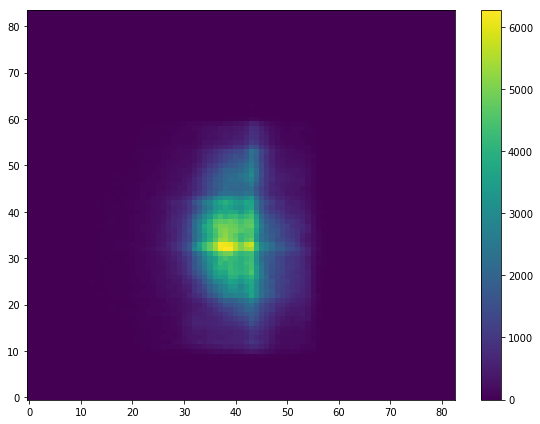

Current= 1.15
Files used: ['CG4B9472.dat', 'CG4B9473.dat', 'CG4B9474.dat', 'CG4B9475.dat', 'CG4B9476.dat', 'CG4B9477.dat', 'CG4B9478.dat', 'CG4B9479.dat', 'CG4B9480.dat', 'CG4B9481.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  1577587.6115407487


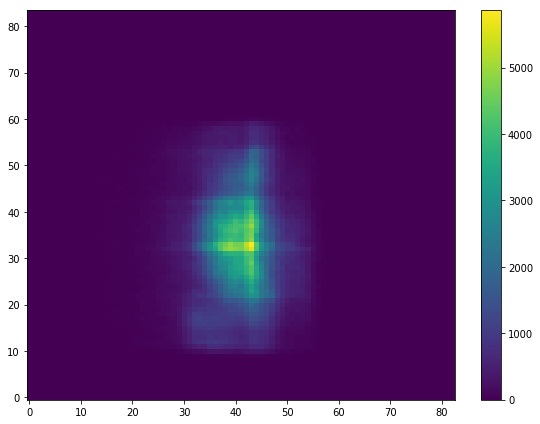

Current= 1.155
Files used: ['CG4B9482.dat', 'CG4B9483.dat', 'CG4B9484.dat', 'CG4B9485.dat', 'CG4B9486.dat', 'CG4B9487.dat', 'CG4B9488.dat', 'CG4B9489.dat', 'CG4B9490.dat', 'CG4B9491.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  1463432.398572283


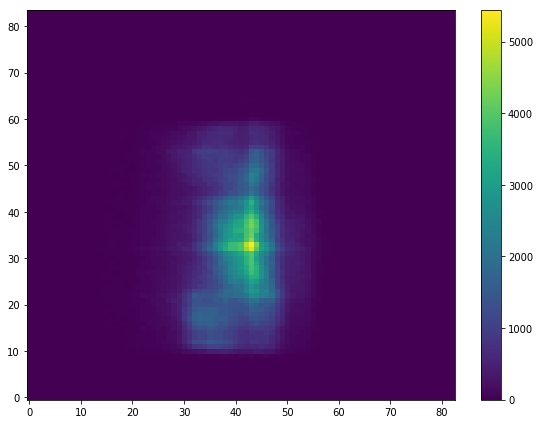

Current= 1.16
Files used: ['CG4B9492.dat', 'CG4B9493.dat', 'CG4B9494.dat', 'CG4B9495.dat', 'CG4B9496.dat', 'CG4B9497.dat', 'CG4B9498.dat', 'CG4B9499.dat', 'CG4B9500.dat', 'CG4B9501.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  1584798.773944081


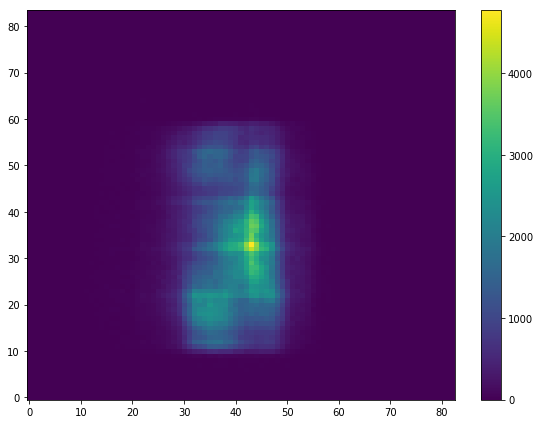

Current= 1.165
Files used: ['CG4B9502.dat', 'CG4B9503.dat', 'CG4B9504.dat', 'CG4B9505.dat', 'CG4B9506.dat', 'CG4B9507.dat', 'CG4B9508.dat', 'CG4B9509.dat', 'CG4B9510.dat', 'CG4B9511.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  1901794.430696014


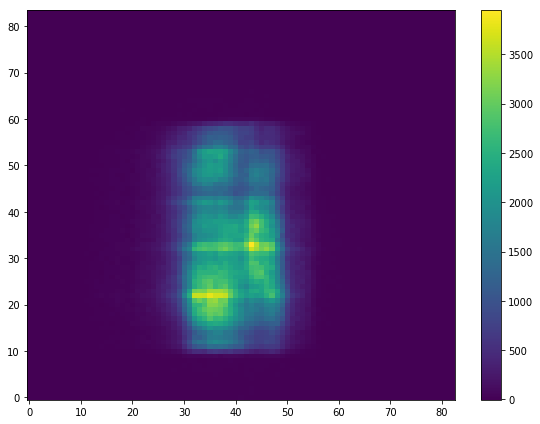

Current= 1.17
Files used: ['CG4B9512.dat', 'CG4B9513.dat', 'CG4B9514.dat', 'CG4B9515.dat', 'CG4B9516.dat', 'CG4B9517.dat', 'CG4B9518.dat', 'CG4B9519.dat', 'CG4B9520.dat', 'CG4B9521.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  2258069.791790603


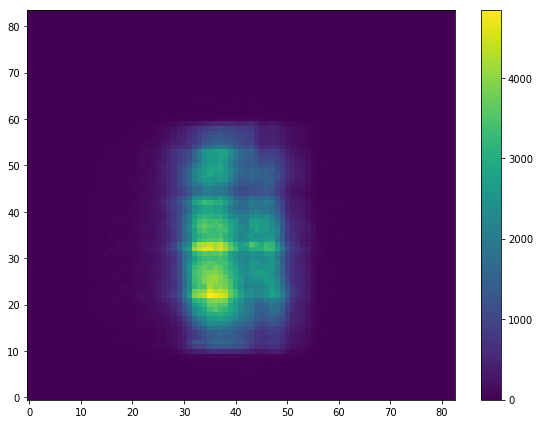

Current= 1.175
Files used: ['CG4B9522.dat', 'CG4B9523.dat', 'CG4B9524.dat', 'CG4B9525.dat', 'CG4B9526.dat', 'CG4B9527.dat', 'CG4B9528.dat', 'CG4B9529.dat', 'CG4B9530.dat', 'CG4B9531.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  2528034.665080306


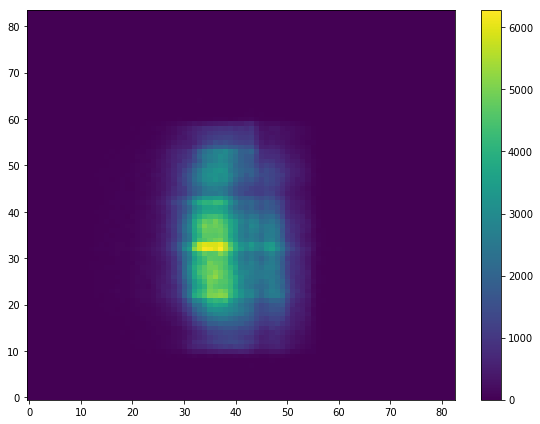

Current= 1.18
Files used: ['CG4B9532.dat', 'CG4B9533.dat', 'CG4B9534.dat', 'CG4B9535.dat', 'CG4B9536.dat', 'CG4B9537.dat', 'CG4B9538.dat', 'CG4B9539.dat', 'CG4B9540.dat', 'CG4B9541.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  2591316.9220701936


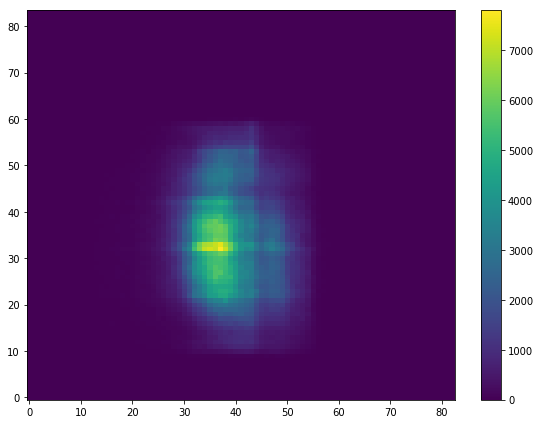

Current= 1.185
Files used: ['CG4B9542.dat', 'CG4B9543.dat', 'CG4B9544.dat', 'CG4B9545.dat', 'CG4B9546.dat', 'CG4B9547.dat', 'CG4B9548.dat', 'CG4B9549.dat', 'CG4B9550.dat', 'CG4B9551.dat']
Bin size =  3
Binned pixel size (mm) =  0.6


KeyboardInterrupt: 

In [474]:
zero_counts = []    #add all subscans that are zero counts here

currents = np.arange(1,1.3,.005)
print("Currents used: ", currents, " \n Total=", len(currents), "\n")
high_counts = []
high_totals = []
start = 9172
subscans = 10

for i in range(len(currents)):
    print("Current=", round(currents[i],3))
    if ((start + (subscans - 1) + int(i)*subscans) not in zero_counts):
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans, \
                          print_summed=True, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
    else: 
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans - 1, \
                          print_summed=True, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
        print("Warning: one subscan failed!")
        
Peak_h = max(high_totals)
Trough_h = min(high_totals)
Peak_current_h = np.argmax(high_totals)
Trough_current_h = np.argmin(high_totals)

print("\n Peak counts: ", Peak_h, "\n Current: ", round(currents[Peak_current_h],3), "\n")
print("\n Trough counts: ", Trough_h, "\n Current: ", round(currents[Trough_current_h],3), "\n")

amp,freq,phase,shim: [ 5.72498708e+05  1.32988910e+02 -5.97264464e+00  2.03284158e+06]
FR: 1.7838272039237166
Period= 0.047245934281471814


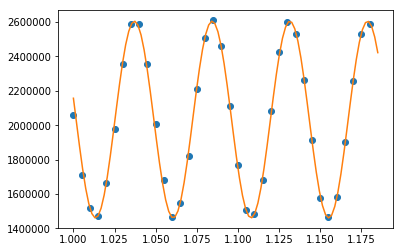

In [506]:
def simple_cos(x,amp,freq,phase,shim):
    return amp*np.cos(x*freq + phase) + shim

currents = np.arange(1,1.185,.005)
c_fine = np.linspace(currents[0],currents[-1],100)

guess = [(np.max(high_totals)-np.min(high_totals))/2.,2*np.pi/.05,np.pi,np.mean(high_totals)]

fit, cov = sp.optimize.curve_fit(simple_cos, currents[:-1], high_totals, p0=guess)

fig = plt.plot(currents[:-1], high_totals[:], "o")
plt.plot(c_fine, simple_cos(c_fine, *fit), "-")
print("amp,freq,phase,shim:", fit)
print('FR:', max(simple_cos(c_fine, *fit))/min(simple_cos(c_fine, *fit)) )
print('Period=',2*np.pi/fit[1])

In [509]:
period = 0.047
lambda0 = 5.5
larmor_constant = 4.63e4
length = .21

GPA = 2*np.pi/(larmor_constant*lambda0*length*period)
print("Gauss per amp =", GPA*1e4)

Gauss per amp = 24.998792697685605


Currents used:  [1.    1.005 1.01  1.015 1.02  1.025 1.03  1.035 1.04  1.045 1.05  1.055
 1.06  1.065 1.07  1.075 1.08  1.085 1.09  1.095 1.1   1.105 1.11  1.115
 1.12  1.125 1.13  1.135 1.14  1.145 1.15  1.155 1.16  1.165 1.17  1.175
 1.18  1.185 1.19  1.195 1.2   1.205 1.21  1.215 1.22  1.225 1.23  1.235
 1.24  1.245 1.25  1.255 1.26  1.265 1.27  1.275 1.28  1.285 1.29  1.295
 1.3  ]  
 Total= 61 

Current= 1.0
Files used: ['CG4B9563.dat', 'CG4B9564.dat', 'CG4B9565.dat', 'CG4B9566.dat', 'CG4B9567.dat', 'CG4B9568.dat', 'CG4B9569.dat', 'CG4B9570.dat', 'CG4B9571.dat', 'CG4B9572.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  3066212.1356335515


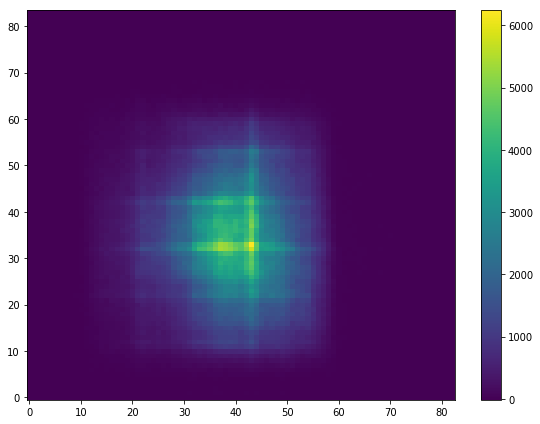

Current= 1.005
Files used: ['CG4B9573.dat', 'CG4B9574.dat', 'CG4B9575.dat', 'CG4B9576.dat', 'CG4B9577.dat', 'CG4B9578.dat', 'CG4B9579.dat', 'CG4B9580.dat', 'CG4B9581.dat', 'CG4B9582.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  2639531.5847709654


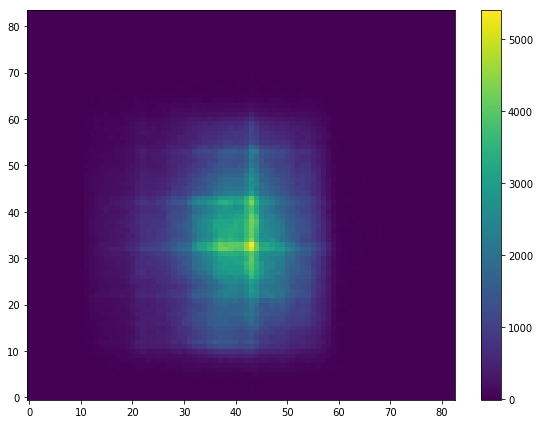

Current= 1.01
Files used: ['CG4B9583.dat', 'CG4B9584.dat', 'CG4B9585.dat', 'CG4B9586.dat', 'CG4B9587.dat', 'CG4B9588.dat', 'CG4B9589.dat', 'CG4B9590.dat', 'CG4B9591.dat', 'CG4B9592.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  2410458.1594289034


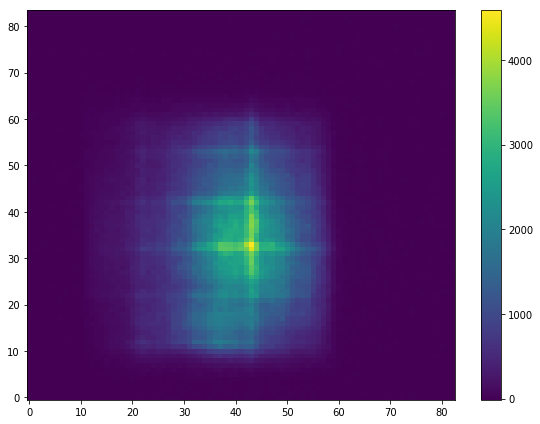

Current= 1.015
Files used: ['CG4B9593.dat', 'CG4B9594.dat', 'CG4B9595.dat', 'CG4B9596.dat', 'CG4B9597.dat', 'CG4B9598.dat', 'CG4B9599.dat', 'CG4B9600.dat', 'CG4B9601.dat', 'CG4B9602.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  2402369.2914931616


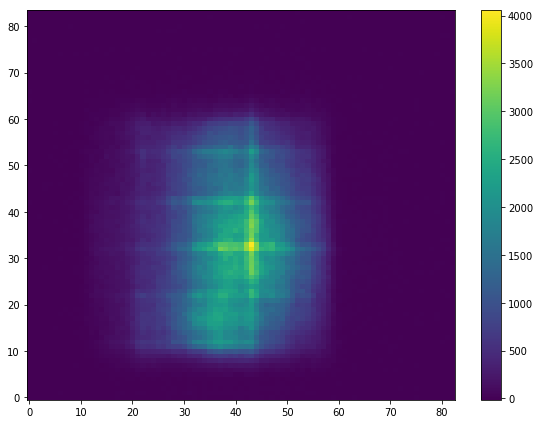

Current= 1.02
Files used: ['CG4B9603.dat', 'CG4B9604.dat', 'CG4B9605.dat', 'CG4B9606.dat', 'CG4B9607.dat', 'CG4B9608.dat', 'CG4B9609.dat', 'CG4B9610.dat', 'CG4B9611.dat', 'CG4B9612.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  2631116.6157049304


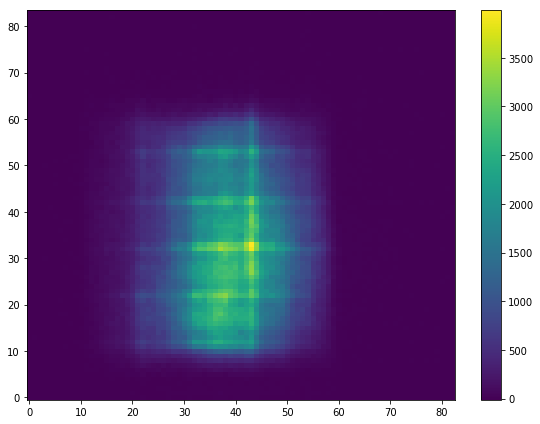

Current= 1.025
Files used: ['CG4B9613.dat', 'CG4B9614.dat', 'CG4B9615.dat', 'CG4B9616.dat', 'CG4B9617.dat', 'CG4B9618.dat', 'CG4B9619.dat', 'CG4B9620.dat', 'CG4B9621.dat', 'CG4B9622.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  2982980.884592508


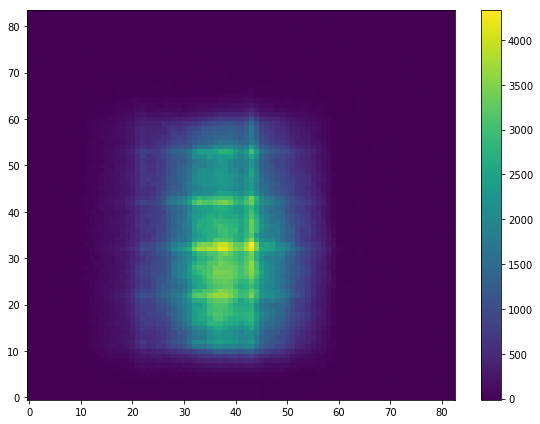

Current= 1.03
Files used: ['CG4B9623.dat', 'CG4B9624.dat', 'CG4B9625.dat', 'CG4B9626.dat', 'CG4B9627.dat', 'CG4B9628.dat', 'CG4B9629.dat', 'CG4B9630.dat', 'CG4B9631.dat', 'CG4B9632.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  3416517.619869131


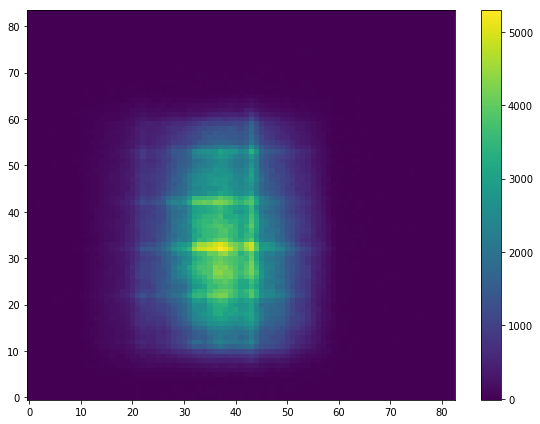

Current= 1.035
Files used: ['CG4B9633.dat', 'CG4B9634.dat', 'CG4B9635.dat', 'CG4B9636.dat', 'CG4B9637.dat', 'CG4B9638.dat', 'CG4B9639.dat', 'CG4B9640.dat', 'CG4B9641.dat', 'CG4B9642.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  3672931.698393803


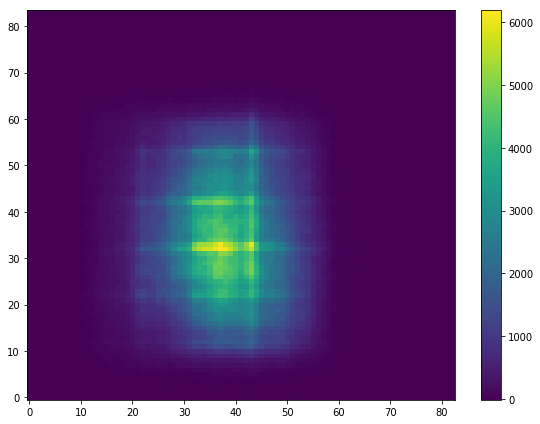

Current= 1.04
Files used: ['CG4B9643.dat', 'CG4B9644.dat', 'CG4B9645.dat', 'CG4B9646.dat', 'CG4B9647.dat', 'CG4B9648.dat', 'CG4B9649.dat', 'CG4B9650.dat', 'CG4B9651.dat', 'CG4B9652.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  3658540.2111838143


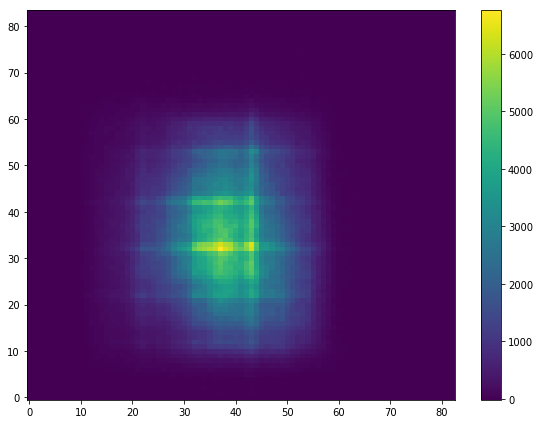

Current= 1.045
Files used: ['CG4B9653.dat', 'CG4B9654.dat', 'CG4B9655.dat', 'CG4B9656.dat', 'CG4B9657.dat', 'CG4B9658.dat', 'CG4B9659.dat', 'CG4B9660.dat', 'CG4B9661.dat', 'CG4B9662.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  3399755.797739436


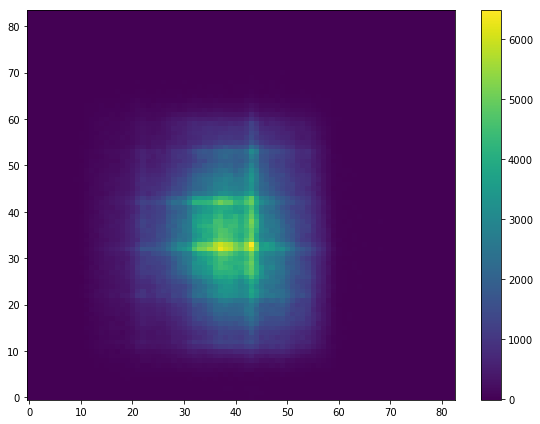

Current= 1.05
Files used: ['CG4B9663.dat', 'CG4B9664.dat', 'CG4B9665.dat', 'CG4B9666.dat', 'CG4B9667.dat', 'CG4B9668.dat', 'CG4B9669.dat', 'CG4B9670.dat', 'CG4B9671.dat', 'CG4B9672.dat']
Bin size =  3
Binned pixel size (mm) =  0.6
Total counts in summed ROI:  426569.37775133905


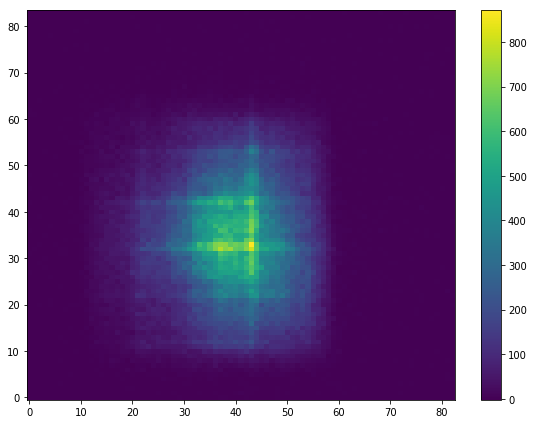

Warning! Missing files:  ['CG4B9665.dat', 'CG4B9666.dat', 'CG4B9667.dat', 'CG4B9668.dat', 'CG4B9669.dat', 'CG4B9670.dat', 'CG4B9671.dat', 'CG4B9672.dat']
Current= 1.055
Files used: ['CG4B9673.dat', 'CG4B9674.dat', 'CG4B9675.dat', 'CG4B9676.dat', 'CG4B9677.dat', 'CG4B9678.dat', 'CG4B9679.dat', 'CG4B9680.dat', 'CG4B9681.dat', 'CG4B9682.dat']
Bin size =  3
Binned pixel size (mm) =  0.6


IndexError: list index out of range

In [513]:
#wide angle
zero_counts = []    #add all subscans that are zero counts here

currents = np.arange(1,1.3,.005)
print("Currents used: ", currents, " \n Total=", len(currents), "\n")
high_counts = []
high_totals = []
start = 9563
subscans = 10

for i in range(len(currents)):
    print("Current=", round(currents[i],3))
    if ((start + (subscans - 1) + int(i)*subscans) not in zero_counts):
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans, \
                          print_summed=True, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
    else: 
        run = reduce_data(start + i*subscans, start + (subscans - 1) + i*subscans - 1, \
                          print_summed=True, print_fnames=True)
        high_counts.append(run[0])
        high_totals.append(run[1])
        print("Warning: one subscan failed!")
        
Peak_h = max(high_totals)
Trough_h = min(high_totals)
Peak_current_h = np.argmax(high_totals)
Trough_current_h = np.argmin(high_totals)

print("\n Peak counts: ", Peak_h, "\n Current: ", round(currents[Peak_current_h],3), "\n")
print("\n Trough counts: ", Trough_h, "\n Current: ", round(currents[Trough_current_h],3), "\n")

amp,freq,phase,shim: [6.64311806e+05 1.27124172e+02 6.34186746e+00 3.02550513e+06]
FR: 1.562593697715266
Period= 0.0494255750972348


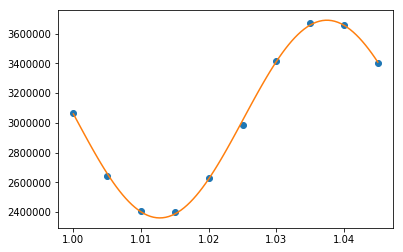

In [533]:
def simple_cos(x,amp,freq,phase,shim):
    return amp*np.cos(x*freq + phase) + shim

currents = np.arange(1,1.049,.005)
c_fine = np.linspace(currents[0],currents[-1],100)

guess = [(np.max(high_totals[:-1])-np.min(high_totals[:-1]))/2.,2*np.pi/.05,np.pi,np.mean(high_totals[:-1])]

fit, cov = sp.optimize.curve_fit(simple_cos, currents, high_totals[:-1], p0=guess)

fig = plt.plot(currents, high_totals[:-1], "o")
plt.plot(c_fine, simple_cos(c_fine, *fit), "-")
print("amp,freq,phase,shim:", fit)
print('FR:', max(simple_cos(c_fine, *fit))/min(simple_cos(c_fine, *fit)) )
print('Period=',2*np.pi/fit[1])

In [534]:
period = 0.0494255750972348
lambda0 = 5.5
larmor_constant = 4.63e4
length = .21

GPA = 2*np.pi/(larmor_constant*lambda0*length*period)
print("Gauss per amp =", GPA*1e4)

Gauss per amp = 23.77196935958278
